# 1. XG Boost by SK Learn model - Detailed

### We are here trying the XG Boost by SKLearn model for forecast

## I. Loading libraries and the sample dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Library Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import scipy.stats as st

from datetime import datetime, timedelta
from statsmodels.tsa.api import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor, XGBRFRegressor

In [2]:
# Creating list of times to start the prediction
warnings.filterwarnings("ignore")
time = pd.Timestamp("00:00:00")
time_list = []
time_list.append(str(time)[-8:])

# Adding 15 minutes every time
#for i in range(1):
for i in range(24*4-1):
    time += pd.Timedelta(minutes=15)
    time_list.append(str(time)[-8:])
    
print(time_list)

['00:00:00', '00:15:00', '00:30:00', '00:45:00', '01:00:00', '01:15:00', '01:30:00', '01:45:00', '02:00:00', '02:15:00', '02:30:00', '02:45:00', '03:00:00', '03:15:00', '03:30:00', '03:45:00', '04:00:00', '04:15:00', '04:30:00', '04:45:00', '05:00:00', '05:15:00', '05:30:00', '05:45:00', '06:00:00', '06:15:00', '06:30:00', '06:45:00', '07:00:00', '07:15:00', '07:30:00', '07:45:00', '08:00:00', '08:15:00', '08:30:00', '08:45:00', '09:00:00', '09:15:00', '09:30:00', '09:45:00', '10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00', '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00', '14:45:00', '15:00:00', '15:15:00', '15:30:00', '15:45:00', '16:00:00', '16:15:00', '16:30:00', '16:45:00', '17:00:00', '17:15:00', '17:30:00', '17:45:00', '18:00:00', '18:15:00', '18:30:00', '18:45:00', '19:00:00', '19:15:00', '19:30:00', '19:45:00', '20:00:00', '20:15:00', '20:30:00', '20

## II. Preprocessing of the data

### A. Restraining the dataset over a time period

### B. Creating the good format dataset

In [3]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [4]:
def model_generation(time, time_step):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["minute"] = df_station.date.apply(lambda x: x[14:16])
    df_station.minute = df_station.minute.astype(int)
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])


    # XGBoost doesn't support anything else than numbers. 
    # So prior to modeling we need to encode the weekday variable into numerical
    mappings = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5}
    df_station.weekday.replace(mappings, inplace = True)


    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]

    # Creation of time bounds
    
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]
    
    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before
        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 
        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    
    df_day_lower = df_station[df_station["day"] == day_backtest]
    
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start)) 
                                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    
    df_backtest = np.array(df_day_lower)
    
    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]


    df_station["day"] = df_station.day.apply(lambda x: x[8:10])
    df_station.pop('date')

    df_conso["day"] = df_conso.day.apply(lambda x: x[8:10])

    df_conso2 = pd.DataFrame(df_conso, columns=["date", "weekday", "hour", "minute", "day"])

    df_conso2["weekday"] = df_conso2["weekday"].astype(int)
    df_conso2["hour"] = df_conso2["hour"].astype(int)
    df_conso2["minute"] = df_conso2["minute"].astype(int)
    df_conso2["day"] = df_conso2["day"].astype(int)

    df_conso.pop('date')

    df_conso["weekday"] = df_conso["weekday"].astype(int)
    df_conso["hour"] = df_conso["hour"].astype(int)
    df_conso["minute"] = df_conso["minute"].astype(int)
    df_conso["day"] = df_conso["day"].astype(int)



    # This will be our model pipe

    predictors = [x for x in df_conso.columns if x not in ['availiable_docks']]

    X = df_conso[predictors]
    y = df_conso.availiable_docks

    
    # X_fut & y_fut creation
    
    
    dt = day_list[-1:][0] + " " + target_start
    dt = pd.to_datetime(pd.Series(dt))

    columns = ["Date", "weekday"]
    columnsy = ["Date", "Prediction"]
    rows = []

    for i in range(1, 31):
               dtt = dt + timedelta(minutes=i)
               row = [dtt[0], 3]
               rows.append(row)

    X_fut = pd.DataFrame(rows, columns=columns)
    X_fut.set_index('Date', inplace=True)

    y_fut = pd.DataFrame(rows, columns=columnsy)
    y_fut.loc[:,'Prediction'] = 0
    y_fut.set_index('Date', inplace=True)

    # X_fut & y_fut creation: data extraction
    X_fut['hour'] = X_fut.index.hour
    X_fut['minute'] = X_fut.index.minute
    X_fut['day'] = X_fut.index.day

    #np.log(df_conso.availiable_docks) # log transformation of availiable_docks

    # split the data into train/test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 60/540, random_state=False)


    # XGB with sklearn wrapper
    xgb_model = XGBRegressor(booster='gbtree', 
                             objective='reg:squarederror', 
                             subsample=0.8,
                             colsample_bytree=0.85, 
                             learning_rate=0.1, 
                             max_depth=10, 
                             n_estimators=2000, 
                             n_jobs=-1)

    xgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)])

    best_iter = xgb_model.best_iteration

    xgb_model = XGBRegressor(booster='gbtree', 
                             objective='reg:squarederror', 
                             subsample=0.8, 
                             colsample_bytree=0.85, 
                             learning_rate=0.1, 
                             max_depth=10, 
                             n_estimators=best_iter, 
                             n_jobs=-1)

    xgb_model.fit(X_train, y_train)


    #RandomizedSearchCV

    params_grid = {
        'learning_rate': st.uniform(0.01, 0.3), 
        'max_depth': list(range(10, 20, 2)), 
        'gamma': st.uniform(0, 10), 
        'reg_alpha': st.expon(0, 50), 
        'n_estimators': range(10, 2000, 10)}

    xgb_model = RandomizedSearchCV(xgb_model, params_grid, cv = 10) # 5 fold cross validation

    xgb_model.fit(X_train, y_train)

    #create variable for best parameters found in the RandomizedSearchCV
    params_best = xgb_model.best_estimator_.get_params()

    bestgamma = params_best['gamma']
    bestregalpha = params_best['reg_alpha']
    bestlearningrate = params_best['learning_rate']
    bestmaxdepth = params_best['max_depth']
    bestnestimators = params_best['n_estimators']

    # XGB with new parameters with sklearn wrapper 
    xgb_model_final = XGBRegressor(gamma=bestgamma, 
                                   reg_alpha=bestregalpha, 
                                   learning_rate=bestlearningrate, 
                                   max_depth=bestmaxdepth, 
                                   n_estimators=bestnestimators, 
                                   n_jobs=-1, 
                                   objective='reg:squarederror')

    xgb_model_final.fit(X, y)

    # predicting on all time serie for global RMSE
    pred_model = xgb_model.predict(X_test)
    RMSE_test = measure_rmse(y_test,pred_model)


    # Prediction the dataset + time variation
    final_prediction = xgb_model_final.predict(X_fut)
    
    best_parameters = xgb_model_final.get_params()
    
    # IV - Making the prediction up to the time variation and creating assessment dataframe

    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_first_run","forecast_optimized","forecast_optimized_round","backtest"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso2["date"]
    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]

    # V. SYNTHESIS

    # Time to run

    elapsed = timeit.default_timer() - start_time

    # RMSE for assessement

    rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
    rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
    #reminder of best parameters

    results = [str(target_start)[-8:], rmse_f_b, rmse_rf_b, RMSE_test, best_parameters, elapsed, final_prediction]
    return results

In [5]:
# Creating a result list to assess the results
# Here, the model will be trained for every hour and will output:
# - time
# - RMSE forecast vs backtest
# - RMSE round forecast vs backtest
# - RMSE forecast vs backtest from the first test
# - The best parameters
# - The time elapsed to run the pipe


result = []
step =0
for i in time_list:
    step += 1
    try:
        temp = model_generation(i, 30)
        result.append(temp)
        print(temp)
    except:
        pass
    print("progression:",step,"/",len(time_list))

[0]	validation_0-rmse:17.6705
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.9453
[2]	validation_0-rmse:14.3914
[3]	validation_0-rmse:12.9914
[4]	validation_0-rmse:11.7431
[5]	validation_0-rmse:10.5906
[6]	validation_0-rmse:9.55401
[7]	validation_0-rmse:8.61067
[8]	validation_0-rmse:7.78061
[9]	validation_0-rmse:7.01489
[10]	validation_0-rmse:6.31474
[11]	validation_0-rmse:5.68032
[12]	validation_0-rmse:5.13916
[13]	validation_0-rmse:4.64665
[14]	validation_0-rmse:4.1812
[15]	validation_0-rmse:3.76126
[16]	validation_0-rmse:3.40038
[17]	validation_0-rmse:3.07343
[18]	validation_0-rmse:2.76385
[19]	validation_0-rmse:2.49748
[20]	validation_0-rmse:2.25094
[21]	validation_0-rmse:2.03353
[22]	validation_0-rmse:1.83868
[23]	validation_0-rmse:1.66242
[24]	validation_0-rmse:1.50225
[25]	validation_0-rmse:1.358
[26]	validation_0-rmse:1.22752
[27]	validation_0-rmse:1.10383
[28]	validation_0-rmse:0.998404
[29]	validation_0-rmse:0.90354
[30]	validation_

[251]	validation_0-rmse:0.000136
[252]	validation_0-rmse:0.000137
[253]	validation_0-rmse:0.000137
[254]	validation_0-rmse:0.000137
[255]	validation_0-rmse:0.000137
[256]	validation_0-rmse:0.000137
[257]	validation_0-rmse:0.000137
[258]	validation_0-rmse:0.000137
[259]	validation_0-rmse:0.000137
[260]	validation_0-rmse:0.000137
[261]	validation_0-rmse:0.000137
[262]	validation_0-rmse:0.000137
[263]	validation_0-rmse:0.000137
[264]	validation_0-rmse:0.000137
[265]	validation_0-rmse:0.000137
[266]	validation_0-rmse:0.000137
[267]	validation_0-rmse:0.000137
[268]	validation_0-rmse:0.000137
[269]	validation_0-rmse:0.000137
[270]	validation_0-rmse:0.000137
[271]	validation_0-rmse:0.000137
[272]	validation_0-rmse:0.000137
[273]	validation_0-rmse:0.000137
[274]	validation_0-rmse:0.000137
[275]	validation_0-rmse:0.000137
[276]	validation_0-rmse:0.000137
[277]	validation_0-rmse:0.000137
[278]	validation_0-rmse:0.000137
[279]	validation_0-rmse:0.000137
[280]	validation_0-rmse:0.000137
[281]	vali

[172]	validation_0-rmse:0.007091
[173]	validation_0-rmse:0.007091
[174]	validation_0-rmse:0.007088
[175]	validation_0-rmse:0.007062
[176]	validation_0-rmse:0.007066
[177]	validation_0-rmse:0.007061
[178]	validation_0-rmse:0.007064
[179]	validation_0-rmse:0.007048
[180]	validation_0-rmse:0.007022
[181]	validation_0-rmse:0.007032
[182]	validation_0-rmse:0.00704
[183]	validation_0-rmse:0.00705
[184]	validation_0-rmse:0.007075
[185]	validation_0-rmse:0.00707
[186]	validation_0-rmse:0.007078
[187]	validation_0-rmse:0.007049
[188]	validation_0-rmse:0.007049
[189]	validation_0-rmse:0.007037
[190]	validation_0-rmse:0.007037
[191]	validation_0-rmse:0.007042
[192]	validation_0-rmse:0.007043
[193]	validation_0-rmse:0.007038
[194]	validation_0-rmse:0.007025
[195]	validation_0-rmse:0.007022
[196]	validation_0-rmse:0.006982
[197]	validation_0-rmse:0.006979
[198]	validation_0-rmse:0.006896
[199]	validation_0-rmse:0.006901
[200]	validation_0-rmse:0.006885
[201]	validation_0-rmse:0.006902
[202]	validat

[421]	validation_0-rmse:0.006651
[422]	validation_0-rmse:0.006655
[423]	validation_0-rmse:0.006666
[424]	validation_0-rmse:0.006665
[425]	validation_0-rmse:0.006658
[426]	validation_0-rmse:0.00665
[427]	validation_0-rmse:0.006673
[428]	validation_0-rmse:0.006672
[429]	validation_0-rmse:0.006672
[430]	validation_0-rmse:0.006663
[431]	validation_0-rmse:0.006668
[432]	validation_0-rmse:0.00666
[433]	validation_0-rmse:0.006663
[434]	validation_0-rmse:0.006667
[435]	validation_0-rmse:0.00667
[436]	validation_0-rmse:0.00668
[437]	validation_0-rmse:0.006677
[438]	validation_0-rmse:0.006682
[439]	validation_0-rmse:0.00669
[440]	validation_0-rmse:0.006687
[441]	validation_0-rmse:0.006687
[442]	validation_0-rmse:0.006682
[443]	validation_0-rmse:0.006677
[444]	validation_0-rmse:0.006685
[445]	validation_0-rmse:0.006685
[446]	validation_0-rmse:0.006687
[447]	validation_0-rmse:0.006693
[448]	validation_0-rmse:0.006688
[449]	validation_0-rmse:0.006687
[450]	validation_0-rmse:0.006687
[451]	validatio

[670]	validation_0-rmse:0.006574
[671]	validation_0-rmse:0.006572
[672]	validation_0-rmse:0.006572
[673]	validation_0-rmse:0.006582
[674]	validation_0-rmse:0.00658
[675]	validation_0-rmse:0.006567
[676]	validation_0-rmse:0.006567
[677]	validation_0-rmse:0.006572
[678]	validation_0-rmse:0.006582
Stopping. Best iteration:
[578]	validation_0-rmse:0.006551

progression: 2 / 96
[0]	validation_0-rmse:16.9249
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.2118
[2]	validation_0-rmse:13.6572
[3]	validation_0-rmse:12.2602
[4]	validation_0-rmse:11.0098
[5]	validation_0-rmse:9.87577
[6]	validation_0-rmse:8.88691
[7]	validation_0-rmse:7.96675
[8]	validation_0-rmse:7.16807
[9]	validation_0-rmse:6.44767
[10]	validation_0-rmse:5.79571
[11]	validation_0-rmse:5.21949
[12]	validation_0-rmse:4.68021
[13]	validation_0-rmse:4.19563
[14]	validation_0-rmse:3.7882
[15]	validation_0-rmse:3.4104
[16]	validation_0-rmse:3.07757
[17]	validation_0-rmse:2.77925
[18]	validat

[42]	validation_0-rmse:0.23411
[43]	validation_0-rmse:0.218954
[44]	validation_0-rmse:0.199326
[45]	validation_0-rmse:0.186619
[46]	validation_0-rmse:0.172424
[47]	validation_0-rmse:0.163327
[48]	validation_0-rmse:0.151232
[49]	validation_0-rmse:0.138111
[50]	validation_0-rmse:0.127935
[51]	validation_0-rmse:0.117143
[52]	validation_0-rmse:0.109072
[53]	validation_0-rmse:0.100388
[54]	validation_0-rmse:0.093873
[55]	validation_0-rmse:0.086145
[56]	validation_0-rmse:0.07923
[57]	validation_0-rmse:0.076396
[58]	validation_0-rmse:0.070275
[59]	validation_0-rmse:0.068458
[60]	validation_0-rmse:0.063345
[61]	validation_0-rmse:0.058604
[62]	validation_0-rmse:0.054325
[63]	validation_0-rmse:0.051502
[64]	validation_0-rmse:0.048831
[65]	validation_0-rmse:0.045502
[66]	validation_0-rmse:0.044441
[67]	validation_0-rmse:0.042669
[68]	validation_0-rmse:0.042145
[69]	validation_0-rmse:0.039415
[70]	validation_0-rmse:0.036882
[71]	validation_0-rmse:0.035538
[72]	validation_0-rmse:0.033736
[73]	valid

[293]	validation_0-rmse:0.009921
[294]	validation_0-rmse:0.009921
[295]	validation_0-rmse:0.009921
[296]	validation_0-rmse:0.009921
[297]	validation_0-rmse:0.009921
[298]	validation_0-rmse:0.009914
[299]	validation_0-rmse:0.009915
[300]	validation_0-rmse:0.009915
[301]	validation_0-rmse:0.009915
[302]	validation_0-rmse:0.009916
[303]	validation_0-rmse:0.009916
[304]	validation_0-rmse:0.009915
[305]	validation_0-rmse:0.009914
[306]	validation_0-rmse:0.009912
[307]	validation_0-rmse:0.009912
[308]	validation_0-rmse:0.009911
[309]	validation_0-rmse:0.009912
[310]	validation_0-rmse:0.009913
[311]	validation_0-rmse:0.009912
[312]	validation_0-rmse:0.009915
[313]	validation_0-rmse:0.009915
[314]	validation_0-rmse:0.009914
[315]	validation_0-rmse:0.009909
[316]	validation_0-rmse:0.009912
[317]	validation_0-rmse:0.009912
[318]	validation_0-rmse:0.009912
[319]	validation_0-rmse:0.009912
[320]	validation_0-rmse:0.009912
[321]	validation_0-rmse:0.009912
[322]	validation_0-rmse:0.009913
[323]	vali

[542]	validation_0-rmse:0.009843
[543]	validation_0-rmse:0.009843
[544]	validation_0-rmse:0.009848
[545]	validation_0-rmse:0.009848
[546]	validation_0-rmse:0.009844
[547]	validation_0-rmse:0.009844
[548]	validation_0-rmse:0.009844
[549]	validation_0-rmse:0.009844
[550]	validation_0-rmse:0.009842
[551]	validation_0-rmse:0.009838
[552]	validation_0-rmse:0.009839
[553]	validation_0-rmse:0.009838
[554]	validation_0-rmse:0.00984
[555]	validation_0-rmse:0.00984
[556]	validation_0-rmse:0.009839
[557]	validation_0-rmse:0.009831
[558]	validation_0-rmse:0.009831
[559]	validation_0-rmse:0.00983
[560]	validation_0-rmse:0.009831
[561]	validation_0-rmse:0.009831
[562]	validation_0-rmse:0.009829
[563]	validation_0-rmse:0.009829
[564]	validation_0-rmse:0.009833
[565]	validation_0-rmse:0.009833
[566]	validation_0-rmse:0.009833
[567]	validation_0-rmse:0.009834
[568]	validation_0-rmse:0.009833
[569]	validation_0-rmse:0.009833
[570]	validation_0-rmse:0.009833
[571]	validation_0-rmse:0.009831
[572]	validat

[792]	validation_0-rmse:0.009785
[793]	validation_0-rmse:0.009785
[794]	validation_0-rmse:0.009785
[795]	validation_0-rmse:0.009785
[796]	validation_0-rmse:0.009785
[797]	validation_0-rmse:0.009788
[798]	validation_0-rmse:0.009788
[799]	validation_0-rmse:0.009783
[800]	validation_0-rmse:0.009781
[801]	validation_0-rmse:0.009785
[802]	validation_0-rmse:0.009785
[803]	validation_0-rmse:0.009789
[804]	validation_0-rmse:0.009789
[805]	validation_0-rmse:0.00979
[806]	validation_0-rmse:0.00979
[807]	validation_0-rmse:0.009788
[808]	validation_0-rmse:0.009788
[809]	validation_0-rmse:0.009788
[810]	validation_0-rmse:0.009788
[811]	validation_0-rmse:0.009788
[812]	validation_0-rmse:0.009788
[813]	validation_0-rmse:0.009789
[814]	validation_0-rmse:0.00979
[815]	validation_0-rmse:0.009789
[816]	validation_0-rmse:0.009787
[817]	validation_0-rmse:0.009783
[818]	validation_0-rmse:0.009783
[819]	validation_0-rmse:0.009788
[820]	validation_0-rmse:0.009789
[821]	validation_0-rmse:0.009789
[822]	validat

[140]	validation_0-rmse:0.002439
[141]	validation_0-rmse:0.002435
[142]	validation_0-rmse:0.002425
[143]	validation_0-rmse:0.002412
[144]	validation_0-rmse:0.002389
[145]	validation_0-rmse:0.002365
[146]	validation_0-rmse:0.002353
[147]	validation_0-rmse:0.002348
[148]	validation_0-rmse:0.002348
[149]	validation_0-rmse:0.002341
[150]	validation_0-rmse:0.002317
[151]	validation_0-rmse:0.002312
[152]	validation_0-rmse:0.002311
[153]	validation_0-rmse:0.002349
[154]	validation_0-rmse:0.002335
[155]	validation_0-rmse:0.002315
[156]	validation_0-rmse:0.002305
[157]	validation_0-rmse:0.002315
[158]	validation_0-rmse:0.002304
[159]	validation_0-rmse:0.002293
[160]	validation_0-rmse:0.002273
[161]	validation_0-rmse:0.002273
[162]	validation_0-rmse:0.002247
[163]	validation_0-rmse:0.002247
[164]	validation_0-rmse:0.002241
[165]	validation_0-rmse:0.002233
[166]	validation_0-rmse:0.002215
[167]	validation_0-rmse:0.002201
[168]	validation_0-rmse:0.002199
[169]	validation_0-rmse:0.0022
[170]	valida

[389]	validation_0-rmse:0.002064
[390]	validation_0-rmse:0.002064
[391]	validation_0-rmse:0.002065
[392]	validation_0-rmse:0.002066
[393]	validation_0-rmse:0.002056
[394]	validation_0-rmse:0.002057
[395]	validation_0-rmse:0.002057
[396]	validation_0-rmse:0.002056
[397]	validation_0-rmse:0.002057
[398]	validation_0-rmse:0.002057
[399]	validation_0-rmse:0.002057
[400]	validation_0-rmse:0.002057
[401]	validation_0-rmse:0.002057
[402]	validation_0-rmse:0.002056
[403]	validation_0-rmse:0.002056
[404]	validation_0-rmse:0.002056
[405]	validation_0-rmse:0.002056
[406]	validation_0-rmse:0.002056
[407]	validation_0-rmse:0.002055
[408]	validation_0-rmse:0.002056
[409]	validation_0-rmse:0.002056
[410]	validation_0-rmse:0.002054
[411]	validation_0-rmse:0.002053
[412]	validation_0-rmse:0.002054
[413]	validation_0-rmse:0.002054
[414]	validation_0-rmse:0.002054
[415]	validation_0-rmse:0.002055
[416]	validation_0-rmse:0.002055
[417]	validation_0-rmse:0.002055
[418]	validation_0-rmse:0.002054
[419]	vali

[638]	validation_0-rmse:0.002038
[639]	validation_0-rmse:0.002038
[640]	validation_0-rmse:0.002039
[641]	validation_0-rmse:0.002039
[642]	validation_0-rmse:0.002039
[643]	validation_0-rmse:0.00204
[644]	validation_0-rmse:0.002034
[645]	validation_0-rmse:0.002033
[646]	validation_0-rmse:0.002033
[647]	validation_0-rmse:0.002031
[648]	validation_0-rmse:0.002031
[649]	validation_0-rmse:0.002031
[650]	validation_0-rmse:0.00203
[651]	validation_0-rmse:0.00203
[652]	validation_0-rmse:0.00203
[653]	validation_0-rmse:0.002029
[654]	validation_0-rmse:0.00203
[655]	validation_0-rmse:0.00203
[656]	validation_0-rmse:0.00203
[657]	validation_0-rmse:0.002029
[658]	validation_0-rmse:0.00203
[659]	validation_0-rmse:0.002029
[660]	validation_0-rmse:0.002029
[661]	validation_0-rmse:0.002029
[662]	validation_0-rmse:0.00203
[663]	validation_0-rmse:0.00203
[664]	validation_0-rmse:0.00203
[665]	validation_0-rmse:0.00203
[666]	validation_0-rmse:0.00203
[667]	validation_0-rmse:0.002031
[668]	validation_0-rmse

[162]	validation_0-rmse:0.009774
[163]	validation_0-rmse:0.009787
[164]	validation_0-rmse:0.009769
[165]	validation_0-rmse:0.009764
[166]	validation_0-rmse:0.009754
[167]	validation_0-rmse:0.009745
[168]	validation_0-rmse:0.009739
[169]	validation_0-rmse:0.009721
[170]	validation_0-rmse:0.009701
[171]	validation_0-rmse:0.009702
[172]	validation_0-rmse:0.009683
[173]	validation_0-rmse:0.009681
[174]	validation_0-rmse:0.009681
[175]	validation_0-rmse:0.009679
[176]	validation_0-rmse:0.009672
[177]	validation_0-rmse:0.009642
[178]	validation_0-rmse:0.009642
[179]	validation_0-rmse:0.009642
[180]	validation_0-rmse:0.00964
[181]	validation_0-rmse:0.00964
[182]	validation_0-rmse:0.009644
[183]	validation_0-rmse:0.009647
[184]	validation_0-rmse:0.009632
[185]	validation_0-rmse:0.009632
[186]	validation_0-rmse:0.009633
[187]	validation_0-rmse:0.009633
[188]	validation_0-rmse:0.009644
[189]	validation_0-rmse:0.009643
[190]	validation_0-rmse:0.009626
[191]	validation_0-rmse:0.009632
[192]	valida

[67]	validation_0-rmse:0.02401
[68]	validation_0-rmse:0.023171
[69]	validation_0-rmse:0.022745
[70]	validation_0-rmse:0.022486
[71]	validation_0-rmse:0.020618
[72]	validation_0-rmse:0.020306
[73]	validation_0-rmse:0.018301
[74]	validation_0-rmse:0.016845
[75]	validation_0-rmse:0.015557
[76]	validation_0-rmse:0.01437
[77]	validation_0-rmse:0.014222
[78]	validation_0-rmse:0.01321
[79]	validation_0-rmse:0.012429
[80]	validation_0-rmse:0.012311
[81]	validation_0-rmse:0.01164
[82]	validation_0-rmse:0.011768
[83]	validation_0-rmse:0.010509
[84]	validation_0-rmse:0.00935
[85]	validation_0-rmse:0.00886
[86]	validation_0-rmse:0.008704
[87]	validation_0-rmse:0.007683
[88]	validation_0-rmse:0.007291
[89]	validation_0-rmse:0.006839
[90]	validation_0-rmse:0.006442
[91]	validation_0-rmse:0.006096
[92]	validation_0-rmse:0.005371
[93]	validation_0-rmse:0.005243
[94]	validation_0-rmse:0.005131
[95]	validation_0-rmse:0.004943
[96]	validation_0-rmse:0.004771
[97]	validation_0-rmse:0.004631
[98]	validatio

[10]	validation_0-rmse:6.08335
[11]	validation_0-rmse:5.48269
[12]	validation_0-rmse:4.94097
[13]	validation_0-rmse:4.45111
[14]	validation_0-rmse:4.00712
[15]	validation_0-rmse:3.61219
[16]	validation_0-rmse:3.25646
[17]	validation_0-rmse:2.93514
[18]	validation_0-rmse:2.64652
[19]	validation_0-rmse:2.38775
[20]	validation_0-rmse:2.15275
[21]	validation_0-rmse:1.94103
[22]	validation_0-rmse:1.75002
[23]	validation_0-rmse:1.57788
[24]	validation_0-rmse:1.42348
[25]	validation_0-rmse:1.28435
[26]	validation_0-rmse:1.1591
[27]	validation_0-rmse:1.04473
[28]	validation_0-rmse:0.942587
[29]	validation_0-rmse:0.850537
[30]	validation_0-rmse:0.768793
[31]	validation_0-rmse:0.694153
[32]	validation_0-rmse:0.626112
[33]	validation_0-rmse:0.566009
[34]	validation_0-rmse:0.509816
[35]	validation_0-rmse:0.459154
[36]	validation_0-rmse:0.41567
[37]	validation_0-rmse:0.376334
[38]	validation_0-rmse:0.338859
[39]	validation_0-rmse:0.306961
[40]	validation_0-rmse:0.278316
[41]	validation_0-rmse:0.251

[42]	validation_0-rmse:0.242874
[43]	validation_0-rmse:0.225155
[44]	validation_0-rmse:0.209021
[45]	validation_0-rmse:0.195932
[46]	validation_0-rmse:0.179568
[47]	validation_0-rmse:0.164192
[48]	validation_0-rmse:0.151195
[49]	validation_0-rmse:0.142745
[50]	validation_0-rmse:0.132321
[51]	validation_0-rmse:0.122127
[52]	validation_0-rmse:0.113166
[53]	validation_0-rmse:0.105777
[54]	validation_0-rmse:0.098702
[55]	validation_0-rmse:0.092548
[56]	validation_0-rmse:0.089171
[57]	validation_0-rmse:0.084227
[58]	validation_0-rmse:0.08152
[59]	validation_0-rmse:0.078076
[60]	validation_0-rmse:0.076316
[61]	validation_0-rmse:0.072137
[62]	validation_0-rmse:0.0697
[63]	validation_0-rmse:0.067235
[64]	validation_0-rmse:0.065971
[65]	validation_0-rmse:0.064044
[66]	validation_0-rmse:0.063358
[67]	validation_0-rmse:0.061034
[68]	validation_0-rmse:0.060462
[69]	validation_0-rmse:0.060089
[70]	validation_0-rmse:0.060178
[71]	validation_0-rmse:0.058773
[72]	validation_0-rmse:0.058374
[73]	valida

[64]	validation_0-rmse:0.038906
[65]	validation_0-rmse:0.035593
[66]	validation_0-rmse:0.034665
[67]	validation_0-rmse:0.031844
[68]	validation_0-rmse:0.031319
[69]	validation_0-rmse:0.031099
[70]	validation_0-rmse:0.031002
[71]	validation_0-rmse:0.028639
[72]	validation_0-rmse:0.028522
[73]	validation_0-rmse:0.026461
[74]	validation_0-rmse:0.024562
[75]	validation_0-rmse:0.022884
[76]	validation_0-rmse:0.021402
[77]	validation_0-rmse:0.021378
[78]	validation_0-rmse:0.020063
[79]	validation_0-rmse:0.019359
[80]	validation_0-rmse:0.019265
[81]	validation_0-rmse:0.018665
[82]	validation_0-rmse:0.018616
[83]	validation_0-rmse:0.017625
[84]	validation_0-rmse:0.016696
[85]	validation_0-rmse:0.016254
[86]	validation_0-rmse:0.016208
[87]	validation_0-rmse:0.015463
[88]	validation_0-rmse:0.015118
[89]	validation_0-rmse:0.014467
[90]	validation_0-rmse:0.013955
[91]	validation_0-rmse:0.013507
[92]	validation_0-rmse:0.013056
[93]	validation_0-rmse:0.01298
[94]	validation_0-rmse:0.012633
[95]	vali

[315]	validation_0-rmse:0.007944
[316]	validation_0-rmse:0.007944
[317]	validation_0-rmse:0.007944
[318]	validation_0-rmse:0.007928
[319]	validation_0-rmse:0.00794
[320]	validation_0-rmse:0.00794
[321]	validation_0-rmse:0.007939
[322]	validation_0-rmse:0.007939
[323]	validation_0-rmse:0.007939
[324]	validation_0-rmse:0.007938
[325]	validation_0-rmse:0.007938
[326]	validation_0-rmse:0.007938
[327]	validation_0-rmse:0.007938
[328]	validation_0-rmse:0.007938
[329]	validation_0-rmse:0.007937
[330]	validation_0-rmse:0.007937
[331]	validation_0-rmse:0.007937
[332]	validation_0-rmse:0.007937
[333]	validation_0-rmse:0.007924
[334]	validation_0-rmse:0.007924
[335]	validation_0-rmse:0.007932
[336]	validation_0-rmse:0.007932
[337]	validation_0-rmse:0.007932
[338]	validation_0-rmse:0.007932
[339]	validation_0-rmse:0.007933
[340]	validation_0-rmse:0.007933
[341]	validation_0-rmse:0.007933
[342]	validation_0-rmse:0.007933
[343]	validation_0-rmse:0.007932
[344]	validation_0-rmse:0.007932
[345]	valida

[565]	validation_0-rmse:0.00788
[566]	validation_0-rmse:0.00788
[567]	validation_0-rmse:0.00788
[568]	validation_0-rmse:0.00788
[569]	validation_0-rmse:0.00788
[570]	validation_0-rmse:0.00788
[571]	validation_0-rmse:0.00788
[572]	validation_0-rmse:0.00788
[573]	validation_0-rmse:0.00788
[574]	validation_0-rmse:0.00788
[575]	validation_0-rmse:0.00788
[576]	validation_0-rmse:0.00788
[577]	validation_0-rmse:0.00788
[578]	validation_0-rmse:0.00788
Stopping. Best iteration:
[478]	validation_0-rmse:0.007873

['02:15:00', 0.3833789825439453, 0.0, 0.2760817526781225, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.2577098526990835, 'importance_type': 'gain', 'learning_rate': 0.13076333228432008, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 270, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 8.390504215597156, 'reg_lambda': 1

[0]	validation_0-rmse:17.2686
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5533
[2]	validation_0-rmse:14.0083
[3]	validation_0-rmse:12.6221
[4]	validation_0-rmse:11.3747
[5]	validation_0-rmse:10.2464
[6]	validation_0-rmse:9.23459
[7]	validation_0-rmse:8.32073
[8]	validation_0-rmse:7.49708
[9]	validation_0-rmse:6.76181
[10]	validation_0-rmse:6.0916
[11]	validation_0-rmse:5.49355
[12]	validation_0-rmse:4.9574
[13]	validation_0-rmse:4.47193
[14]	validation_0-rmse:4.03027
[15]	validation_0-rmse:3.63499
[16]	validation_0-rmse:3.28189
[17]	validation_0-rmse:2.96268
[18]	validation_0-rmse:2.67269
[19]	validation_0-rmse:2.41314
[20]	validation_0-rmse:2.17657
[21]	validation_0-rmse:1.96652
[22]	validation_0-rmse:1.77809
[23]	validation_0-rmse:1.60675
[24]	validation_0-rmse:1.44849
[25]	validation_0-rmse:1.30721
[26]	validation_0-rmse:1.1828
[27]	validation_0-rmse:1.06755
[28]	validation_0-rmse:0.963287
[29]	validation_0-rmse:0.872515
[30]	validation

[252]	validation_0-rmse:0.007544
[253]	validation_0-rmse:0.00754
[254]	validation_0-rmse:0.007543
[255]	validation_0-rmse:0.007531
[256]	validation_0-rmse:0.007529
[257]	validation_0-rmse:0.007535
[258]	validation_0-rmse:0.007521
[259]	validation_0-rmse:0.007522
[260]	validation_0-rmse:0.007521
[261]	validation_0-rmse:0.007522
[262]	validation_0-rmse:0.007522
[263]	validation_0-rmse:0.007522
[264]	validation_0-rmse:0.007529
[265]	validation_0-rmse:0.007529
[266]	validation_0-rmse:0.007529
[267]	validation_0-rmse:0.007531
[268]	validation_0-rmse:0.00753
[269]	validation_0-rmse:0.00753
[270]	validation_0-rmse:0.007525
[271]	validation_0-rmse:0.007525
[272]	validation_0-rmse:0.007527
[273]	validation_0-rmse:0.00752
[274]	validation_0-rmse:0.007505
[275]	validation_0-rmse:0.007493
[276]	validation_0-rmse:0.007492
[277]	validation_0-rmse:0.007492
[278]	validation_0-rmse:0.007492
[279]	validation_0-rmse:0.007492
[280]	validation_0-rmse:0.0075
[281]	validation_0-rmse:0.0075
[282]	validation_0

[86]	validation_0-rmse:0.010795
[87]	validation_0-rmse:0.010154
[88]	validation_0-rmse:0.009719
[89]	validation_0-rmse:0.00916
[90]	validation_0-rmse:0.008703
[91]	validation_0-rmse:0.008295
[92]	validation_0-rmse:0.007913
[93]	validation_0-rmse:0.007848
[94]	validation_0-rmse:0.007553
[95]	validation_0-rmse:0.007227
[96]	validation_0-rmse:0.006966
[97]	validation_0-rmse:0.006751
[98]	validation_0-rmse:0.006612
[99]	validation_0-rmse:0.006436
[100]	validation_0-rmse:0.006394
[101]	validation_0-rmse:0.006277
[102]	validation_0-rmse:0.006169
[103]	validation_0-rmse:0.00609
[104]	validation_0-rmse:0.005993
[105]	validation_0-rmse:0.005893
[106]	validation_0-rmse:0.005822
[107]	validation_0-rmse:0.00577
[108]	validation_0-rmse:0.005703
[109]	validation_0-rmse:0.005634
[110]	validation_0-rmse:0.005612
[111]	validation_0-rmse:0.005562
[112]	validation_0-rmse:0.005513
[113]	validation_0-rmse:0.005464
[114]	validation_0-rmse:0.005413
[115]	validation_0-rmse:0.005406
[116]	validation_0-rmse:0.0

[336]	validation_0-rmse:0.004872
[337]	validation_0-rmse:0.004871
[338]	validation_0-rmse:0.004872
[339]	validation_0-rmse:0.004873
[340]	validation_0-rmse:0.004872
[341]	validation_0-rmse:0.004874
[342]	validation_0-rmse:0.004875
[343]	validation_0-rmse:0.004874
[344]	validation_0-rmse:0.004874
[345]	validation_0-rmse:0.004874
[346]	validation_0-rmse:0.004875
[347]	validation_0-rmse:0.004875
[348]	validation_0-rmse:0.004875
[349]	validation_0-rmse:0.004875
[350]	validation_0-rmse:0.004875
[351]	validation_0-rmse:0.004875
[352]	validation_0-rmse:0.004875
[353]	validation_0-rmse:0.004876
[354]	validation_0-rmse:0.004875
[355]	validation_0-rmse:0.004875
[356]	validation_0-rmse:0.004875
[357]	validation_0-rmse:0.004862
[358]	validation_0-rmse:0.004862
[359]	validation_0-rmse:0.004861
[360]	validation_0-rmse:0.004861
[361]	validation_0-rmse:0.004862
[362]	validation_0-rmse:0.004862
[363]	validation_0-rmse:0.004862
[364]	validation_0-rmse:0.004861
[365]	validation_0-rmse:0.004862
[366]	vali

[586]	validation_0-rmse:0.004846
[587]	validation_0-rmse:0.004846
[588]	validation_0-rmse:0.004846
[589]	validation_0-rmse:0.004846
[590]	validation_0-rmse:0.004848
[591]	validation_0-rmse:0.004848
[592]	validation_0-rmse:0.004848
[593]	validation_0-rmse:0.004848
[594]	validation_0-rmse:0.004848
[595]	validation_0-rmse:0.004847
[596]	validation_0-rmse:0.004847
[597]	validation_0-rmse:0.004847
[598]	validation_0-rmse:0.004847
[599]	validation_0-rmse:0.004847
[600]	validation_0-rmse:0.004847
[601]	validation_0-rmse:0.004847
[602]	validation_0-rmse:0.004848
[603]	validation_0-rmse:0.004848
[604]	validation_0-rmse:0.004846
[605]	validation_0-rmse:0.004839
[606]	validation_0-rmse:0.00484
[607]	validation_0-rmse:0.00484
[608]	validation_0-rmse:0.00484
[609]	validation_0-rmse:0.00484
[610]	validation_0-rmse:0.00484
[611]	validation_0-rmse:0.00484
[612]	validation_0-rmse:0.004841
[613]	validation_0-rmse:0.004841
[614]	validation_0-rmse:0.00484
[615]	validation_0-rmse:0.00484
[616]	validation_0

[836]	validation_0-rmse:0.004805
[837]	validation_0-rmse:0.004804
[838]	validation_0-rmse:0.004804
[839]	validation_0-rmse:0.004804
[840]	validation_0-rmse:0.004803
[841]	validation_0-rmse:0.004803
[842]	validation_0-rmse:0.004803
[843]	validation_0-rmse:0.004804
[844]	validation_0-rmse:0.004803
[845]	validation_0-rmse:0.004803
[846]	validation_0-rmse:0.004804
[847]	validation_0-rmse:0.004804
[848]	validation_0-rmse:0.004804
[849]	validation_0-rmse:0.004805
[850]	validation_0-rmse:0.004805
[851]	validation_0-rmse:0.004805
[852]	validation_0-rmse:0.004805
[853]	validation_0-rmse:0.004805
[854]	validation_0-rmse:0.004804
[855]	validation_0-rmse:0.004804
[856]	validation_0-rmse:0.004804
[857]	validation_0-rmse:0.004804
[858]	validation_0-rmse:0.004804
[859]	validation_0-rmse:0.004804
[860]	validation_0-rmse:0.004804
[861]	validation_0-rmse:0.004804
[862]	validation_0-rmse:0.004804
[863]	validation_0-rmse:0.004804
[864]	validation_0-rmse:0.004804
[865]	validation_0-rmse:0.004804
[866]	vali

[114]	validation_0-rmse:0.111319
[115]	validation_0-rmse:0.111304
[116]	validation_0-rmse:0.111291
[117]	validation_0-rmse:0.111363
[118]	validation_0-rmse:0.111432
[119]	validation_0-rmse:0.111426
[120]	validation_0-rmse:0.111409
[121]	validation_0-rmse:0.111402
[122]	validation_0-rmse:0.111466
[123]	validation_0-rmse:0.111527
[124]	validation_0-rmse:0.11147
[125]	validation_0-rmse:0.111468
[126]	validation_0-rmse:0.111454
[127]	validation_0-rmse:0.111437
[128]	validation_0-rmse:0.111482
[129]	validation_0-rmse:0.111537
[130]	validation_0-rmse:0.11152
[131]	validation_0-rmse:0.111513
[132]	validation_0-rmse:0.111498
[133]	validation_0-rmse:0.111548
[134]	validation_0-rmse:0.111595
[135]	validation_0-rmse:0.111641
[136]	validation_0-rmse:0.111684
[137]	validation_0-rmse:0.111682
[138]	validation_0-rmse:0.111723
[139]	validation_0-rmse:0.111707
[140]	validation_0-rmse:0.111692
[141]	validation_0-rmse:0.111731
[142]	validation_0-rmse:0.111732
[143]	validation_0-rmse:0.11172
[144]	validat

[138]	validation_0-rmse:0.002227
[139]	validation_0-rmse:0.002223
[140]	validation_0-rmse:0.002221
[141]	validation_0-rmse:0.002211
[142]	validation_0-rmse:0.002208
[143]	validation_0-rmse:0.002203
[144]	validation_0-rmse:0.0022
[145]	validation_0-rmse:0.002199
[146]	validation_0-rmse:0.0022
[147]	validation_0-rmse:0.002196
[148]	validation_0-rmse:0.002197
[149]	validation_0-rmse:0.0022
[150]	validation_0-rmse:0.0022
[151]	validation_0-rmse:0.002188
[152]	validation_0-rmse:0.002188
[153]	validation_0-rmse:0.002182
[154]	validation_0-rmse:0.002182
[155]	validation_0-rmse:0.002183
[156]	validation_0-rmse:0.002182
[157]	validation_0-rmse:0.002182
[158]	validation_0-rmse:0.002182
[159]	validation_0-rmse:0.002178
[160]	validation_0-rmse:0.002178
[161]	validation_0-rmse:0.002177
[162]	validation_0-rmse:0.002177
[163]	validation_0-rmse:0.002177
[164]	validation_0-rmse:0.002178
[165]	validation_0-rmse:0.002183
[166]	validation_0-rmse:0.002183
[167]	validation_0-rmse:0.002178
[168]	validation_0

[388]	validation_0-rmse:0.002112
[389]	validation_0-rmse:0.002112
[390]	validation_0-rmse:0.002112
[391]	validation_0-rmse:0.002112
[392]	validation_0-rmse:0.002112
[393]	validation_0-rmse:0.002112
[394]	validation_0-rmse:0.002112
[395]	validation_0-rmse:0.00211
[396]	validation_0-rmse:0.00211
[397]	validation_0-rmse:0.00211
[398]	validation_0-rmse:0.002111
[399]	validation_0-rmse:0.002109
[400]	validation_0-rmse:0.002109
[401]	validation_0-rmse:0.002109
[402]	validation_0-rmse:0.002109
[403]	validation_0-rmse:0.002109
[404]	validation_0-rmse:0.002109
[405]	validation_0-rmse:0.002109
[406]	validation_0-rmse:0.002109
[407]	validation_0-rmse:0.002109
[408]	validation_0-rmse:0.002109
[409]	validation_0-rmse:0.002108
[410]	validation_0-rmse:0.002109
[411]	validation_0-rmse:0.002109
[412]	validation_0-rmse:0.002109
[413]	validation_0-rmse:0.002109
[414]	validation_0-rmse:0.002108
[415]	validation_0-rmse:0.002108
[416]	validation_0-rmse:0.002108
[417]	validation_0-rmse:0.002108
[418]	validat

[187]	validation_0-rmse:0.002608
[188]	validation_0-rmse:0.002608
[189]	validation_0-rmse:0.002608
[190]	validation_0-rmse:0.002602
[191]	validation_0-rmse:0.002599
[192]	validation_0-rmse:0.002597
[193]	validation_0-rmse:0.002603
[194]	validation_0-rmse:0.002603
[195]	validation_0-rmse:0.002597
[196]	validation_0-rmse:0.002597
[197]	validation_0-rmse:0.002597
[198]	validation_0-rmse:0.002595
[199]	validation_0-rmse:0.002596
[200]	validation_0-rmse:0.002596
[201]	validation_0-rmse:0.002596
[202]	validation_0-rmse:0.002596
[203]	validation_0-rmse:0.002596
[204]	validation_0-rmse:0.002596
[205]	validation_0-rmse:0.00258
[206]	validation_0-rmse:0.00258
[207]	validation_0-rmse:0.00258
[208]	validation_0-rmse:0.00258
[209]	validation_0-rmse:0.00258
[210]	validation_0-rmse:0.00258
[211]	validation_0-rmse:0.002575
[212]	validation_0-rmse:0.002576
[213]	validation_0-rmse:0.002576
[214]	validation_0-rmse:0.002576
[215]	validation_0-rmse:0.002576
[216]	validation_0-rmse:0.002576
[217]	validation

[48]	validation_0-rmse:0.125017
[49]	validation_0-rmse:0.114867
[50]	validation_0-rmse:0.103633
[51]	validation_0-rmse:0.093516
[52]	validation_0-rmse:0.084376
[53]	validation_0-rmse:0.076135
[54]	validation_0-rmse:0.068704
[55]	validation_0-rmse:0.062001
[56]	validation_0-rmse:0.057328
[57]	validation_0-rmse:0.051736
[58]	validation_0-rmse:0.04805
[59]	validation_0-rmse:0.043367
[60]	validation_0-rmse:0.040533
[61]	validation_0-rmse:0.036599
[62]	validation_0-rmse:0.033043
[63]	validation_0-rmse:0.029845
[64]	validation_0-rmse:0.028071
[65]	validation_0-rmse:0.025359
[66]	validation_0-rmse:0.024083
[67]	validation_0-rmse:0.021759
[68]	validation_0-rmse:0.020819
[69]	validation_0-rmse:0.020376
[70]	validation_0-rmse:0.019931
[71]	validation_0-rmse:0.018108
[72]	validation_0-rmse:0.017759
[73]	validation_0-rmse:0.016177
[74]	validation_0-rmse:0.01473
[75]	validation_0-rmse:0.01346
[76]	validation_0-rmse:0.012291
[77]	validation_0-rmse:0.012208
[78]	validation_0-rmse:0.011189
[79]	valida

[299]	validation_0-rmse:0.002562
[300]	validation_0-rmse:0.002562
[301]	validation_0-rmse:0.002562
[302]	validation_0-rmse:0.002562
[303]	validation_0-rmse:0.00256
[304]	validation_0-rmse:0.00256
[305]	validation_0-rmse:0.00256
[306]	validation_0-rmse:0.00256
[307]	validation_0-rmse:0.00256
[308]	validation_0-rmse:0.00256
[309]	validation_0-rmse:0.00256
[310]	validation_0-rmse:0.00256
[311]	validation_0-rmse:0.00256
[312]	validation_0-rmse:0.00256
[313]	validation_0-rmse:0.002561
[314]	validation_0-rmse:0.002561
[315]	validation_0-rmse:0.002561
[316]	validation_0-rmse:0.002561
[317]	validation_0-rmse:0.002561
[318]	validation_0-rmse:0.002556
[319]	validation_0-rmse:0.002557
[320]	validation_0-rmse:0.002553
[321]	validation_0-rmse:0.002553
[322]	validation_0-rmse:0.002553
[323]	validation_0-rmse:0.002552
[324]	validation_0-rmse:0.002553
[325]	validation_0-rmse:0.002553
[326]	validation_0-rmse:0.002553
[327]	validation_0-rmse:0.002551
[328]	validation_0-rmse:0.002551
[329]	validation_0-r

[549]	validation_0-rmse:0.002539
[550]	validation_0-rmse:0.002539
[551]	validation_0-rmse:0.00254
Stopping. Best iteration:
[451]	validation_0-rmse:0.002536

['04:00:00', 0.4185619354248047, 0.0, 0.24678439326923707, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 8.83510585772066, 'importance_type': 'gain', 'learning_rate': 0.15154198030818986, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.616831868391304, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}, 30.127287694000017, array([18.581438, 18.581438, 18.581438, 18.581438, 18.581438, 18.581438,
       18.581438, 18.581438, 18.581438, 18.581438, 18.581438, 18.581438,
       18.581438, 18.581438, 18.581438, 18.581438, 18.581438, 18.581438,
       18.581438, 18.581

[216]	validation_0-rmse:0.003044
[217]	validation_0-rmse:0.003043
[218]	validation_0-rmse:0.003043
[219]	validation_0-rmse:0.003043
[220]	validation_0-rmse:0.003043
[221]	validation_0-rmse:0.003043
[222]	validation_0-rmse:0.003043
[223]	validation_0-rmse:0.003043
[224]	validation_0-rmse:0.003043
[225]	validation_0-rmse:0.003043
[226]	validation_0-rmse:0.003043
[227]	validation_0-rmse:0.003042
[228]	validation_0-rmse:0.003042
[229]	validation_0-rmse:0.003042
[230]	validation_0-rmse:0.003042
[231]	validation_0-rmse:0.003042
[232]	validation_0-rmse:0.00304
[233]	validation_0-rmse:0.00304
[234]	validation_0-rmse:0.00304
[235]	validation_0-rmse:0.00304
[236]	validation_0-rmse:0.00304
[237]	validation_0-rmse:0.00304
[238]	validation_0-rmse:0.003038
[239]	validation_0-rmse:0.003038
[240]	validation_0-rmse:0.003038
[241]	validation_0-rmse:0.003038
[242]	validation_0-rmse:0.003038
[243]	validation_0-rmse:0.003038
[244]	validation_0-rmse:0.003038
[245]	validation_0-rmse:0.003038
[246]	validation

[467]	validation_0-rmse:0.003017
[468]	validation_0-rmse:0.003017
[469]	validation_0-rmse:0.003017
[470]	validation_0-rmse:0.003017
[471]	validation_0-rmse:0.003017
[472]	validation_0-rmse:0.003017
[473]	validation_0-rmse:0.003017
[474]	validation_0-rmse:0.003017
[475]	validation_0-rmse:0.003017
[476]	validation_0-rmse:0.003017
[477]	validation_0-rmse:0.003017
[478]	validation_0-rmse:0.003017
[479]	validation_0-rmse:0.003017
[480]	validation_0-rmse:0.003017
[481]	validation_0-rmse:0.003017
[482]	validation_0-rmse:0.003017
[483]	validation_0-rmse:0.003017
[484]	validation_0-rmse:0.003017
[485]	validation_0-rmse:0.003017
[486]	validation_0-rmse:0.003017
[487]	validation_0-rmse:0.003017
[488]	validation_0-rmse:0.003017
[489]	validation_0-rmse:0.003017
[490]	validation_0-rmse:0.003017
[491]	validation_0-rmse:0.003017
[492]	validation_0-rmse:0.003017
[493]	validation_0-rmse:0.003017
[494]	validation_0-rmse:0.003017
[495]	validation_0-rmse:0.003017
[496]	validation_0-rmse:0.003017
[497]	vali

[121]	validation_0-rmse:0.005204
[122]	validation_0-rmse:0.005144
[123]	validation_0-rmse:0.005114
[124]	validation_0-rmse:0.005082
[125]	validation_0-rmse:0.005072
[126]	validation_0-rmse:0.005064
[127]	validation_0-rmse:0.005008
[128]	validation_0-rmse:0.004992
[129]	validation_0-rmse:0.004953
[130]	validation_0-rmse:0.004924
[131]	validation_0-rmse:0.004902
[132]	validation_0-rmse:0.004892
[133]	validation_0-rmse:0.004867
[134]	validation_0-rmse:0.004848
[135]	validation_0-rmse:0.004806
[136]	validation_0-rmse:0.004778
[137]	validation_0-rmse:0.004775
[138]	validation_0-rmse:0.004736
[139]	validation_0-rmse:0.004733
[140]	validation_0-rmse:0.004712
[141]	validation_0-rmse:0.004687
[142]	validation_0-rmse:0.004682
[143]	validation_0-rmse:0.004677
[144]	validation_0-rmse:0.004659
[145]	validation_0-rmse:0.004645
[146]	validation_0-rmse:0.004628
[147]	validation_0-rmse:0.004616
[148]	validation_0-rmse:0.004594
[149]	validation_0-rmse:0.004563
[150]	validation_0-rmse:0.004532
[151]	vali

[370]	validation_0-rmse:0.004224
[371]	validation_0-rmse:0.004224
[372]	validation_0-rmse:0.004224
[373]	validation_0-rmse:0.004225
[374]	validation_0-rmse:0.004225
[375]	validation_0-rmse:0.004225
[376]	validation_0-rmse:0.004225
[377]	validation_0-rmse:0.004225
[378]	validation_0-rmse:0.004225
[379]	validation_0-rmse:0.004225
[380]	validation_0-rmse:0.004225
[381]	validation_0-rmse:0.004225
[382]	validation_0-rmse:0.004225
[383]	validation_0-rmse:0.004225
[384]	validation_0-rmse:0.004225
[385]	validation_0-rmse:0.004225
[386]	validation_0-rmse:0.004222
[387]	validation_0-rmse:0.004221
[388]	validation_0-rmse:0.004221
[389]	validation_0-rmse:0.004222
[390]	validation_0-rmse:0.004222
[391]	validation_0-rmse:0.004222
[392]	validation_0-rmse:0.004222
[393]	validation_0-rmse:0.004222
[394]	validation_0-rmse:0.004223
[395]	validation_0-rmse:0.004222
[396]	validation_0-rmse:0.004222
[397]	validation_0-rmse:0.004223
[398]	validation_0-rmse:0.004224
[399]	validation_0-rmse:0.004224
[400]	vali

[619]	validation_0-rmse:0.004187
[620]	validation_0-rmse:0.004187
[621]	validation_0-rmse:0.004187
[622]	validation_0-rmse:0.004187
[623]	validation_0-rmse:0.004187
[624]	validation_0-rmse:0.004187
[625]	validation_0-rmse:0.004188
[626]	validation_0-rmse:0.004188
[627]	validation_0-rmse:0.004188
[628]	validation_0-rmse:0.004187
[629]	validation_0-rmse:0.004187
[630]	validation_0-rmse:0.004188
[631]	validation_0-rmse:0.004188
[632]	validation_0-rmse:0.004188
[633]	validation_0-rmse:0.004187
[634]	validation_0-rmse:0.004187
[635]	validation_0-rmse:0.004187
[636]	validation_0-rmse:0.004187
[637]	validation_0-rmse:0.004187
[638]	validation_0-rmse:0.004187
[639]	validation_0-rmse:0.004188
[640]	validation_0-rmse:0.004188
[641]	validation_0-rmse:0.004187
[642]	validation_0-rmse:0.004187
[643]	validation_0-rmse:0.004188
[644]	validation_0-rmse:0.004188
[645]	validation_0-rmse:0.004188
[646]	validation_0-rmse:0.004188
[647]	validation_0-rmse:0.004187
[648]	validation_0-rmse:0.004187
[649]	vali

[868]	validation_0-rmse:0.004173
[869]	validation_0-rmse:0.004173
[870]	validation_0-rmse:0.00417
[871]	validation_0-rmse:0.00417
[872]	validation_0-rmse:0.004171
[873]	validation_0-rmse:0.004171
[874]	validation_0-rmse:0.004171
[875]	validation_0-rmse:0.004171
[876]	validation_0-rmse:0.004171
[877]	validation_0-rmse:0.004171
[878]	validation_0-rmse:0.004171
[879]	validation_0-rmse:0.004171
[880]	validation_0-rmse:0.004171
[881]	validation_0-rmse:0.004171
[882]	validation_0-rmse:0.004171
[883]	validation_0-rmse:0.00417
[884]	validation_0-rmse:0.00417
[885]	validation_0-rmse:0.004164
[886]	validation_0-rmse:0.004164
[887]	validation_0-rmse:0.004164
[888]	validation_0-rmse:0.004164
[889]	validation_0-rmse:0.004164
[890]	validation_0-rmse:0.004164
[891]	validation_0-rmse:0.004163
[892]	validation_0-rmse:0.004163
[893]	validation_0-rmse:0.004163
[894]	validation_0-rmse:0.004163
[895]	validation_0-rmse:0.004163
[896]	validation_0-rmse:0.004163
[897]	validation_0-rmse:0.004162
[898]	validati

[1114]	validation_0-rmse:0.004146
[1115]	validation_0-rmse:0.004146
[1116]	validation_0-rmse:0.004146
[1117]	validation_0-rmse:0.004146
[1118]	validation_0-rmse:0.004146
[1119]	validation_0-rmse:0.004146
[1120]	validation_0-rmse:0.004145
[1121]	validation_0-rmse:0.004146
[1122]	validation_0-rmse:0.004146
[1123]	validation_0-rmse:0.004146
[1124]	validation_0-rmse:0.004146
[1125]	validation_0-rmse:0.004146
[1126]	validation_0-rmse:0.004146
[1127]	validation_0-rmse:0.004145
[1128]	validation_0-rmse:0.004145
[1129]	validation_0-rmse:0.004145
[1130]	validation_0-rmse:0.004145
[1131]	validation_0-rmse:0.004145
[1132]	validation_0-rmse:0.004142
[1133]	validation_0-rmse:0.004142
[1134]	validation_0-rmse:0.004138
[1135]	validation_0-rmse:0.004138
[1136]	validation_0-rmse:0.004138
[1137]	validation_0-rmse:0.004138
[1138]	validation_0-rmse:0.004142
[1139]	validation_0-rmse:0.004142
[1140]	validation_0-rmse:0.004142
[1141]	validation_0-rmse:0.004142
[1142]	validation_0-rmse:0.004142
[1143]	validat

[1356]	validation_0-rmse:0.004136
[1357]	validation_0-rmse:0.004136
[1358]	validation_0-rmse:0.004136
[1359]	validation_0-rmse:0.004135
[1360]	validation_0-rmse:0.004135
[1361]	validation_0-rmse:0.004135
[1362]	validation_0-rmse:0.004136
[1363]	validation_0-rmse:0.004136
[1364]	validation_0-rmse:0.004136
[1365]	validation_0-rmse:0.004136
[1366]	validation_0-rmse:0.004136
[1367]	validation_0-rmse:0.004136
Stopping. Best iteration:
[1267]	validation_0-rmse:0.00413

['04:30:00', 0.4159393310546875, 0.0, 0.27139348940921193, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 6.7198483644125995, 'importance_type': 'gain', 'learning_rate': 0.19772737341369556, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1820, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.6074728260723203, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None

[208]	validation_0-rmse:0.042469
[209]	validation_0-rmse:0.042469
[210]	validation_0-rmse:0.042469
[211]	validation_0-rmse:0.042469
[212]	validation_0-rmse:0.04247
[213]	validation_0-rmse:0.04247
[214]	validation_0-rmse:0.042471
[215]	validation_0-rmse:0.042471
[216]	validation_0-rmse:0.04247
[217]	validation_0-rmse:0.042471
[218]	validation_0-rmse:0.042474
[219]	validation_0-rmse:0.042474
[220]	validation_0-rmse:0.042474
[221]	validation_0-rmse:0.042474
[222]	validation_0-rmse:0.04248
[223]	validation_0-rmse:0.04248
[224]	validation_0-rmse:0.042448
[225]	validation_0-rmse:0.042448
[226]	validation_0-rmse:0.042448
[227]	validation_0-rmse:0.042448
[228]	validation_0-rmse:0.042448
[229]	validation_0-rmse:0.042448
[230]	validation_0-rmse:0.042447
[231]	validation_0-rmse:0.042447
[232]	validation_0-rmse:0.042448
[233]	validation_0-rmse:0.042448
[234]	validation_0-rmse:0.042449
[235]	validation_0-rmse:0.042449
[236]	validation_0-rmse:0.042449
[237]	validation_0-rmse:0.042448
[238]	validatio

[458]	validation_0-rmse:0.042381
[459]	validation_0-rmse:0.042381
[460]	validation_0-rmse:0.04238
[461]	validation_0-rmse:0.042381
[462]	validation_0-rmse:0.042381
[463]	validation_0-rmse:0.042381
[464]	validation_0-rmse:0.042381
[465]	validation_0-rmse:0.042382
[466]	validation_0-rmse:0.042382
[467]	validation_0-rmse:0.042382
[468]	validation_0-rmse:0.042382
[469]	validation_0-rmse:0.042382
[470]	validation_0-rmse:0.042382
[471]	validation_0-rmse:0.042382
[472]	validation_0-rmse:0.042382
[473]	validation_0-rmse:0.042382
[474]	validation_0-rmse:0.042382
[475]	validation_0-rmse:0.042382
[476]	validation_0-rmse:0.042381
[477]	validation_0-rmse:0.042381
[478]	validation_0-rmse:0.042381
[479]	validation_0-rmse:0.042381
[480]	validation_0-rmse:0.042381
[481]	validation_0-rmse:0.042381
[482]	validation_0-rmse:0.042382
[483]	validation_0-rmse:0.042382
[484]	validation_0-rmse:0.042382
[485]	validation_0-rmse:0.042382
[486]	validation_0-rmse:0.042382
[487]	validation_0-rmse:0.042382
[488]	valid

[127]	validation_0-rmse:0.005289
[128]	validation_0-rmse:0.005265
[129]	validation_0-rmse:0.005259
[130]	validation_0-rmse:0.005233
[131]	validation_0-rmse:0.005239
[132]	validation_0-rmse:0.005228
[133]	validation_0-rmse:0.005211
[134]	validation_0-rmse:0.005209
[135]	validation_0-rmse:0.005209
[136]	validation_0-rmse:0.005205
[137]	validation_0-rmse:0.005195
[138]	validation_0-rmse:0.005195
[139]	validation_0-rmse:0.00518
[140]	validation_0-rmse:0.005175
[141]	validation_0-rmse:0.005182
[142]	validation_0-rmse:0.005172
[143]	validation_0-rmse:0.005172
[144]	validation_0-rmse:0.005177
[145]	validation_0-rmse:0.005176
[146]	validation_0-rmse:0.005169
[147]	validation_0-rmse:0.005172
[148]	validation_0-rmse:0.005174
[149]	validation_0-rmse:0.005167
[150]	validation_0-rmse:0.005167
[151]	validation_0-rmse:0.005174
[152]	validation_0-rmse:0.005174
[153]	validation_0-rmse:0.005171
[154]	validation_0-rmse:0.005168
[155]	validation_0-rmse:0.005165
[156]	validation_0-rmse:0.005145
[157]	valid

[0]	validation_0-rmse:17.4458
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.7122
[2]	validation_0-rmse:14.1497
[3]	validation_0-rmse:12.7455
[4]	validation_0-rmse:11.4824
[5]	validation_0-rmse:10.3418
[6]	validation_0-rmse:9.30992
[7]	validation_0-rmse:8.3853
[8]	validation_0-rmse:7.55228
[9]	validation_0-rmse:6.79825
[10]	validation_0-rmse:6.12469
[11]	validation_0-rmse:5.51868
[12]	validation_0-rmse:4.9741
[13]	validation_0-rmse:4.47826
[14]	validation_0-rmse:4.03698
[15]	validation_0-rmse:3.63618
[16]	validation_0-rmse:3.27792
[17]	validation_0-rmse:2.95455
[18]	validation_0-rmse:2.66434
[19]	validation_0-rmse:2.40054
[20]	validation_0-rmse:2.16494
[21]	validation_0-rmse:1.95198
[22]	validation_0-rmse:1.75963
[23]	validation_0-rmse:1.58649
[24]	validation_0-rmse:1.42968
[25]	validation_0-rmse:1.28993
[26]	validation_0-rmse:1.16411
[27]	validation_0-rmse:1.04945
[28]	validation_0-rmse:0.946442
[29]	validation_0-rmse:0.854363
[30]	validatio

[252]	validation_0-rmse:0.002268
[253]	validation_0-rmse:0.002268
[254]	validation_0-rmse:0.002262
[255]	validation_0-rmse:0.002257
[256]	validation_0-rmse:0.002252
[257]	validation_0-rmse:0.002254
[258]	validation_0-rmse:0.002255
[259]	validation_0-rmse:0.002254
[260]	validation_0-rmse:0.002254
[261]	validation_0-rmse:0.002254
[262]	validation_0-rmse:0.002254
[263]	validation_0-rmse:0.002254
[264]	validation_0-rmse:0.002254
[265]	validation_0-rmse:0.002254
[266]	validation_0-rmse:0.002254
[267]	validation_0-rmse:0.002254
[268]	validation_0-rmse:0.002254
[269]	validation_0-rmse:0.002254
[270]	validation_0-rmse:0.002254
[271]	validation_0-rmse:0.002252
[272]	validation_0-rmse:0.002253
[273]	validation_0-rmse:0.002253
[274]	validation_0-rmse:0.002253
[275]	validation_0-rmse:0.002257
[276]	validation_0-rmse:0.002257
[277]	validation_0-rmse:0.002258
[278]	validation_0-rmse:0.002259
[279]	validation_0-rmse:0.002257
[280]	validation_0-rmse:0.002257
[281]	validation_0-rmse:0.002257
[282]	vali

[114]	validation_0-rmse:0.002175
[115]	validation_0-rmse:0.002145
[116]	validation_0-rmse:0.002109
[117]	validation_0-rmse:0.002083
[118]	validation_0-rmse:0.002058
[119]	validation_0-rmse:0.002037
[120]	validation_0-rmse:0.002025
[121]	validation_0-rmse:0.002006
[122]	validation_0-rmse:0.00199
[123]	validation_0-rmse:0.001972
[124]	validation_0-rmse:0.001946
[125]	validation_0-rmse:0.001931
[126]	validation_0-rmse:0.001921
[127]	validation_0-rmse:0.001911
[128]	validation_0-rmse:0.001904
[129]	validation_0-rmse:0.001899
[130]	validation_0-rmse:0.001876
[131]	validation_0-rmse:0.001873
[132]	validation_0-rmse:0.001862
[133]	validation_0-rmse:0.001855
[134]	validation_0-rmse:0.00185
[135]	validation_0-rmse:0.001837
[136]	validation_0-rmse:0.001837
[137]	validation_0-rmse:0.001834
[138]	validation_0-rmse:0.001832
[139]	validation_0-rmse:0.001826
[140]	validation_0-rmse:0.001824
[141]	validation_0-rmse:0.001815
[142]	validation_0-rmse:0.001815
[143]	validation_0-rmse:0.001809
[144]	valida

[364]	validation_0-rmse:0.001727
[365]	validation_0-rmse:0.001727
[366]	validation_0-rmse:0.001727
[367]	validation_0-rmse:0.001727
[368]	validation_0-rmse:0.001727
[369]	validation_0-rmse:0.001727
[370]	validation_0-rmse:0.001727
[371]	validation_0-rmse:0.001727
[372]	validation_0-rmse:0.001727
[373]	validation_0-rmse:0.001727
[374]	validation_0-rmse:0.001727
[375]	validation_0-rmse:0.001727
[376]	validation_0-rmse:0.001727
[377]	validation_0-rmse:0.001727
[378]	validation_0-rmse:0.001727
[379]	validation_0-rmse:0.001727
[380]	validation_0-rmse:0.001727
[381]	validation_0-rmse:0.001726
[382]	validation_0-rmse:0.001726
[383]	validation_0-rmse:0.001725
[384]	validation_0-rmse:0.001725
[385]	validation_0-rmse:0.001725
[386]	validation_0-rmse:0.001725
[387]	validation_0-rmse:0.001725
[388]	validation_0-rmse:0.001725
[389]	validation_0-rmse:0.001725
[390]	validation_0-rmse:0.001725
[391]	validation_0-rmse:0.001725
[392]	validation_0-rmse:0.001725
[393]	validation_0-rmse:0.001725
[394]	vali

[617]	validation_0-rmse:0.001688
[618]	validation_0-rmse:0.001688
[619]	validation_0-rmse:0.001688
[620]	validation_0-rmse:0.001688
[621]	validation_0-rmse:0.001688
[622]	validation_0-rmse:0.001688
[623]	validation_0-rmse:0.001688
[624]	validation_0-rmse:0.001688
[625]	validation_0-rmse:0.001688
[626]	validation_0-rmse:0.001688
[627]	validation_0-rmse:0.001688
[628]	validation_0-rmse:0.001688
[629]	validation_0-rmse:0.001688
[630]	validation_0-rmse:0.001688
[631]	validation_0-rmse:0.001688
[632]	validation_0-rmse:0.001688
[633]	validation_0-rmse:0.001688
[634]	validation_0-rmse:0.001688
[635]	validation_0-rmse:0.001688
[636]	validation_0-rmse:0.001688
[637]	validation_0-rmse:0.001688
[638]	validation_0-rmse:0.001688
[639]	validation_0-rmse:0.001688
[640]	validation_0-rmse:0.001688
[641]	validation_0-rmse:0.001688
[642]	validation_0-rmse:0.001688
[643]	validation_0-rmse:0.001688
[644]	validation_0-rmse:0.001688
[645]	validation_0-rmse:0.001688
[646]	validation_0-rmse:0.001688
[647]	vali

[84]	validation_0-rmse:0.065467
[85]	validation_0-rmse:0.065701
[86]	validation_0-rmse:0.065285
[87]	validation_0-rmse:0.064172
[88]	validation_0-rmse:0.064213
[89]	validation_0-rmse:0.06393
[90]	validation_0-rmse:0.063642
[91]	validation_0-rmse:0.062417
[92]	validation_0-rmse:0.06224
[93]	validation_0-rmse:0.062324
[94]	validation_0-rmse:0.062018
[95]	validation_0-rmse:0.061547
[96]	validation_0-rmse:0.06069
[97]	validation_0-rmse:0.060433
[98]	validation_0-rmse:0.06039
[99]	validation_0-rmse:0.060373
[100]	validation_0-rmse:0.060442
[101]	validation_0-rmse:0.06044
[102]	validation_0-rmse:0.060376
[103]	validation_0-rmse:0.060183
[104]	validation_0-rmse:0.060039
[105]	validation_0-rmse:0.059944
[106]	validation_0-rmse:0.05998
[107]	validation_0-rmse:0.060058
[108]	validation_0-rmse:0.060233
[109]	validation_0-rmse:0.059761
[110]	validation_0-rmse:0.059639
[111]	validation_0-rmse:0.059628
[112]	validation_0-rmse:0.059496
[113]	validation_0-rmse:0.059429
[114]	validation_0-rmse:0.059129

[334]	validation_0-rmse:0.057109
[335]	validation_0-rmse:0.057109
[336]	validation_0-rmse:0.057108
[337]	validation_0-rmse:0.057108
[338]	validation_0-rmse:0.057107
[339]	validation_0-rmse:0.057118
[340]	validation_0-rmse:0.057118
[341]	validation_0-rmse:0.057118
[342]	validation_0-rmse:0.057118
[343]	validation_0-rmse:0.057118
[344]	validation_0-rmse:0.057118
[345]	validation_0-rmse:0.057118
[346]	validation_0-rmse:0.057118
[347]	validation_0-rmse:0.057118
[348]	validation_0-rmse:0.057118
[349]	validation_0-rmse:0.057117
[350]	validation_0-rmse:0.057117
[351]	validation_0-rmse:0.057117
[352]	validation_0-rmse:0.057122
[353]	validation_0-rmse:0.057115
[354]	validation_0-rmse:0.057115
[355]	validation_0-rmse:0.057116
[356]	validation_0-rmse:0.057116
[357]	validation_0-rmse:0.057116
[358]	validation_0-rmse:0.057115
[359]	validation_0-rmse:0.057115
[360]	validation_0-rmse:0.057115
[361]	validation_0-rmse:0.057115
[362]	validation_0-rmse:0.057115
[363]	validation_0-rmse:0.057115
[364]	vali

[583]	validation_0-rmse:0.057088
[584]	validation_0-rmse:0.057088
[585]	validation_0-rmse:0.057088
[586]	validation_0-rmse:0.057086
[587]	validation_0-rmse:0.057086
[588]	validation_0-rmse:0.057077
[589]	validation_0-rmse:0.057077
[590]	validation_0-rmse:0.057077
[591]	validation_0-rmse:0.057077
[592]	validation_0-rmse:0.057077
[593]	validation_0-rmse:0.057078
[594]	validation_0-rmse:0.057079
[595]	validation_0-rmse:0.057076
[596]	validation_0-rmse:0.057076
[597]	validation_0-rmse:0.057076
[598]	validation_0-rmse:0.057075
[599]	validation_0-rmse:0.057076
[600]	validation_0-rmse:0.057076
[601]	validation_0-rmse:0.057077
[602]	validation_0-rmse:0.057068
[603]	validation_0-rmse:0.057068
[604]	validation_0-rmse:0.057068
[605]	validation_0-rmse:0.057072
[606]	validation_0-rmse:0.057072
[607]	validation_0-rmse:0.057072
[608]	validation_0-rmse:0.057072
[609]	validation_0-rmse:0.057072
[610]	validation_0-rmse:0.057071
[611]	validation_0-rmse:0.057071
[612]	validation_0-rmse:0.057071
[613]	vali

[99]	validation_0-rmse:0.016359
[100]	validation_0-rmse:0.01635
[101]	validation_0-rmse:0.016043
[102]	validation_0-rmse:0.016
[103]	validation_0-rmse:0.015881
[104]	validation_0-rmse:0.015628
[105]	validation_0-rmse:0.015605
[106]	validation_0-rmse:0.015549
[107]	validation_0-rmse:0.015363
[108]	validation_0-rmse:0.015426
[109]	validation_0-rmse:0.015189
[110]	validation_0-rmse:0.015037
[111]	validation_0-rmse:0.015025
[112]	validation_0-rmse:0.015068
[113]	validation_0-rmse:0.014908
[114]	validation_0-rmse:0.014761
[115]	validation_0-rmse:0.014627
[116]	validation_0-rmse:0.014547
[117]	validation_0-rmse:0.014595
[118]	validation_0-rmse:0.01449
[119]	validation_0-rmse:0.014466
[120]	validation_0-rmse:0.014463
[121]	validation_0-rmse:0.014468
[122]	validation_0-rmse:0.014588
[123]	validation_0-rmse:0.014547
[124]	validation_0-rmse:0.014478
[125]	validation_0-rmse:0.014467
[126]	validation_0-rmse:0.014459
[127]	validation_0-rmse:0.014506
[128]	validation_0-rmse:0.014531
[129]	validation

[37]	validation_0-rmse:0.412912
[38]	validation_0-rmse:0.374759
[39]	validation_0-rmse:0.345446
[40]	validation_0-rmse:0.317556
[41]	validation_0-rmse:0.290034
[42]	validation_0-rmse:0.263601
[43]	validation_0-rmse:0.244817
[44]	validation_0-rmse:0.229162
[45]	validation_0-rmse:0.21333
[46]	validation_0-rmse:0.197629
[47]	validation_0-rmse:0.184023
[48]	validation_0-rmse:0.17194
[49]	validation_0-rmse:0.162465
[50]	validation_0-rmse:0.152082
[51]	validation_0-rmse:0.143959
[52]	validation_0-rmse:0.136895
[53]	validation_0-rmse:0.13009
[54]	validation_0-rmse:0.124963
[55]	validation_0-rmse:0.12093
[56]	validation_0-rmse:0.117083
[57]	validation_0-rmse:0.113801
[58]	validation_0-rmse:0.111299
[59]	validation_0-rmse:0.108306
[60]	validation_0-rmse:0.106978
[61]	validation_0-rmse:0.105369
[62]	validation_0-rmse:0.10326
[63]	validation_0-rmse:0.102382
[64]	validation_0-rmse:0.10114
[65]	validation_0-rmse:0.100378
[66]	validation_0-rmse:0.100011
[67]	validation_0-rmse:0.097393
[68]	validatio

[0]	validation_0-rmse:17.1704
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.469
[2]	validation_0-rmse:13.9355
[3]	validation_0-rmse:12.5551
[4]	validation_0-rmse:11.312
[5]	validation_0-rmse:10.1938
[6]	validation_0-rmse:9.18556
[7]	validation_0-rmse:8.27521
[8]	validation_0-rmse:7.45746
[9]	validation_0-rmse:6.71945
[10]	validation_0-rmse:6.05658
[11]	validation_0-rmse:5.45988
[12]	validation_0-rmse:4.92087
[13]	validation_0-rmse:4.43471
[14]	validation_0-rmse:4.00571
[15]	validation_0-rmse:3.61497
[16]	validation_0-rmse:3.26273
[17]	validation_0-rmse:2.94524
[18]	validation_0-rmse:2.66176
[19]	validation_0-rmse:2.39961
[20]	validation_0-rmse:2.16658
[21]	validation_0-rmse:1.95647
[22]	validation_0-rmse:1.77094
[23]	validation_0-rmse:1.60186
[24]	validation_0-rmse:1.45245
[25]	validation_0-rmse:1.31183
[26]	validation_0-rmse:1.19183
[27]	validation_0-rmse:1.07951
[28]	validation_0-rmse:0.979943
[29]	validation_0-rmse:0.888673
[30]	validatio

[21]	validation_0-rmse:1.89078
[22]	validation_0-rmse:1.7061
[23]	validation_0-rmse:1.54426
[24]	validation_0-rmse:1.39718
[25]	validation_0-rmse:1.26526
[26]	validation_0-rmse:1.14554
[27]	validation_0-rmse:1.03259
[28]	validation_0-rmse:0.935035
[29]	validation_0-rmse:0.848102
[30]	validation_0-rmse:0.770169
[31]	validation_0-rmse:0.699341
[32]	validation_0-rmse:0.63462
[33]	validation_0-rmse:0.574598
[34]	validation_0-rmse:0.521454
[35]	validation_0-rmse:0.47365
[36]	validation_0-rmse:0.433303
[37]	validation_0-rmse:0.396878
[38]	validation_0-rmse:0.361338
[39]	validation_0-rmse:0.332589
[40]	validation_0-rmse:0.306224
[41]	validation_0-rmse:0.277579
[42]	validation_0-rmse:0.254522
[43]	validation_0-rmse:0.236914
[44]	validation_0-rmse:0.220005
[45]	validation_0-rmse:0.207514
[46]	validation_0-rmse:0.189307
[47]	validation_0-rmse:0.174377
[48]	validation_0-rmse:0.160358
[49]	validation_0-rmse:0.152023
[50]	validation_0-rmse:0.143744
[51]	validation_0-rmse:0.133186
[52]	validation_0-

[74]	validation_0-rmse:0.148825
[75]	validation_0-rmse:0.149231
[76]	validation_0-rmse:0.150018
[77]	validation_0-rmse:0.150567
[78]	validation_0-rmse:0.150476
[79]	validation_0-rmse:0.150946
[80]	validation_0-rmse:0.151372
[81]	validation_0-rmse:0.151809
[82]	validation_0-rmse:0.152163
[83]	validation_0-rmse:0.152077
[84]	validation_0-rmse:0.15251
[85]	validation_0-rmse:0.152578
[86]	validation_0-rmse:0.153094
[87]	validation_0-rmse:0.153568
[88]	validation_0-rmse:0.153938
[89]	validation_0-rmse:0.154337
[90]	validation_0-rmse:0.154296
[91]	validation_0-rmse:0.153791
[92]	validation_0-rmse:0.153639
[93]	validation_0-rmse:0.154191
[94]	validation_0-rmse:0.154491
[95]	validation_0-rmse:0.15518
[96]	validation_0-rmse:0.155234
[97]	validation_0-rmse:0.155732
[98]	validation_0-rmse:0.156418
[99]	validation_0-rmse:0.156057
[100]	validation_0-rmse:0.156608
[101]	validation_0-rmse:0.157013
[102]	validation_0-rmse:0.157256
[103]	validation_0-rmse:0.157942
[104]	validation_0-rmse:0.158092
[105]

[129]	validation_0-rmse:0.173922
[130]	validation_0-rmse:0.174189
[131]	validation_0-rmse:0.174713
[132]	validation_0-rmse:0.174718
[133]	validation_0-rmse:0.174584
[134]	validation_0-rmse:0.17475
[135]	validation_0-rmse:0.174874
[136]	validation_0-rmse:0.174944
[137]	validation_0-rmse:0.174954
[138]	validation_0-rmse:0.17503
[139]	validation_0-rmse:0.175051
[140]	validation_0-rmse:0.175118
[141]	validation_0-rmse:0.175025
[142]	validation_0-rmse:0.175029
[143]	validation_0-rmse:0.175029
[144]	validation_0-rmse:0.175366
[145]	validation_0-rmse:0.175472
[146]	validation_0-rmse:0.175539
[147]	validation_0-rmse:0.17559
[148]	validation_0-rmse:0.175729
[149]	validation_0-rmse:0.175716
[150]	validation_0-rmse:0.175917
[151]	validation_0-rmse:0.175963
[152]	validation_0-rmse:0.175977
[153]	validation_0-rmse:0.175987
[154]	validation_0-rmse:0.176031
[155]	validation_0-rmse:0.176168
[156]	validation_0-rmse:0.176167
[157]	validation_0-rmse:0.176199
[158]	validation_0-rmse:0.17626
[159]	validati

[144]	validation_0-rmse:0.29043
[145]	validation_0-rmse:0.290469
[146]	validation_0-rmse:0.290374
[147]	validation_0-rmse:0.290008
[148]	validation_0-rmse:0.28993
[149]	validation_0-rmse:0.289749
[150]	validation_0-rmse:0.289703
[151]	validation_0-rmse:0.289639
[152]	validation_0-rmse:0.289634
[153]	validation_0-rmse:0.289631
[154]	validation_0-rmse:0.289567
[155]	validation_0-rmse:0.289424
[156]	validation_0-rmse:0.289405
[157]	validation_0-rmse:0.289385
[158]	validation_0-rmse:0.289269
[159]	validation_0-rmse:0.289265
[160]	validation_0-rmse:0.289171
[161]	validation_0-rmse:0.289012
[162]	validation_0-rmse:0.288999
[163]	validation_0-rmse:0.288825
[164]	validation_0-rmse:0.288584
[165]	validation_0-rmse:0.288344
[166]	validation_0-rmse:0.288334
[167]	validation_0-rmse:0.288245
[168]	validation_0-rmse:0.288051
[169]	validation_0-rmse:0.288015
[170]	validation_0-rmse:0.288201
[171]	validation_0-rmse:0.288202
[172]	validation_0-rmse:0.288193
[173]	validation_0-rmse:0.288075
[174]	valida

[393]	validation_0-rmse:0.2854
[394]	validation_0-rmse:0.285405
[395]	validation_0-rmse:0.285417
[396]	validation_0-rmse:0.285414
[397]	validation_0-rmse:0.285407
[398]	validation_0-rmse:0.285402
[399]	validation_0-rmse:0.285405
[400]	validation_0-rmse:0.285406
[401]	validation_0-rmse:0.285407
[402]	validation_0-rmse:0.28541
[403]	validation_0-rmse:0.285418
[404]	validation_0-rmse:0.285418
[405]	validation_0-rmse:0.285401
[406]	validation_0-rmse:0.285394
[407]	validation_0-rmse:0.285393
[408]	validation_0-rmse:0.285402
[409]	validation_0-rmse:0.285402
[410]	validation_0-rmse:0.285401
[411]	validation_0-rmse:0.285402
[412]	validation_0-rmse:0.285401
[413]	validation_0-rmse:0.2854
[414]	validation_0-rmse:0.285401
[415]	validation_0-rmse:0.285397
[416]	validation_0-rmse:0.285398
[417]	validation_0-rmse:0.285401
[418]	validation_0-rmse:0.285378
[419]	validation_0-rmse:0.28537
[420]	validation_0-rmse:0.285367
[421]	validation_0-rmse:0.285367
[422]	validation_0-rmse:0.285375
[423]	validation

[72]	validation_0-rmse:0.389223
[73]	validation_0-rmse:0.38706
[74]	validation_0-rmse:0.386734
[75]	validation_0-rmse:0.385969
[76]	validation_0-rmse:0.385131
[77]	validation_0-rmse:0.38456
[78]	validation_0-rmse:0.384464
[79]	validation_0-rmse:0.384053
[80]	validation_0-rmse:0.38429
[81]	validation_0-rmse:0.38351
[82]	validation_0-rmse:0.384243
[83]	validation_0-rmse:0.383563
[84]	validation_0-rmse:0.383293
[85]	validation_0-rmse:0.383076
[86]	validation_0-rmse:0.38315
[87]	validation_0-rmse:0.384726
[88]	validation_0-rmse:0.384478
[89]	validation_0-rmse:0.383929
[90]	validation_0-rmse:0.384812
[91]	validation_0-rmse:0.384831
[92]	validation_0-rmse:0.384799
[93]	validation_0-rmse:0.385377
[94]	validation_0-rmse:0.385212
[95]	validation_0-rmse:0.385584
[96]	validation_0-rmse:0.386247
[97]	validation_0-rmse:0.385985
[98]	validation_0-rmse:0.3853
[99]	validation_0-rmse:0.385804
[100]	validation_0-rmse:0.385942
[101]	validation_0-rmse:0.385622
[102]	validation_0-rmse:0.385738
[103]	valida

[105]	validation_0-rmse:0.346247
[106]	validation_0-rmse:0.346165
[107]	validation_0-rmse:0.345522
[108]	validation_0-rmse:0.345019
[109]	validation_0-rmse:0.344767
[110]	validation_0-rmse:0.344891
[111]	validation_0-rmse:0.344679
[112]	validation_0-rmse:0.34456
[113]	validation_0-rmse:0.344756
[114]	validation_0-rmse:0.345142
[115]	validation_0-rmse:0.345188
[116]	validation_0-rmse:0.344994
[117]	validation_0-rmse:0.34452
[118]	validation_0-rmse:0.34417
[119]	validation_0-rmse:0.344046
[120]	validation_0-rmse:0.344192
[121]	validation_0-rmse:0.34402
[122]	validation_0-rmse:0.343756
[123]	validation_0-rmse:0.34347
[124]	validation_0-rmse:0.343171
[125]	validation_0-rmse:0.343174
[126]	validation_0-rmse:0.343037
[127]	validation_0-rmse:0.342983
[128]	validation_0-rmse:0.342636
[129]	validation_0-rmse:0.342636
[130]	validation_0-rmse:0.342326
[131]	validation_0-rmse:0.342233
[132]	validation_0-rmse:0.342197
[133]	validation_0-rmse:0.3419
[134]	validation_0-rmse:0.341785
[135]	validation_

[25]	validation_0-rmse:1.23299
[26]	validation_0-rmse:1.14004
[27]	validation_0-rmse:1.0552
[28]	validation_0-rmse:0.978813
[29]	validation_0-rmse:0.91605
[30]	validation_0-rmse:0.858295
[31]	validation_0-rmse:0.811792
[32]	validation_0-rmse:0.769356
[33]	validation_0-rmse:0.732754
[34]	validation_0-rmse:0.689922
[35]	validation_0-rmse:0.655
[36]	validation_0-rmse:0.630823
[37]	validation_0-rmse:0.609451
[38]	validation_0-rmse:0.584419
[39]	validation_0-rmse:0.560988
[40]	validation_0-rmse:0.550525
[41]	validation_0-rmse:0.529204
[42]	validation_0-rmse:0.513944
[43]	validation_0-rmse:0.504765
[44]	validation_0-rmse:0.493584
[45]	validation_0-rmse:0.489418
[46]	validation_0-rmse:0.478807
[47]	validation_0-rmse:0.463856
[48]	validation_0-rmse:0.456671
[49]	validation_0-rmse:0.452633
[50]	validation_0-rmse:0.449491
[51]	validation_0-rmse:0.444824
[52]	validation_0-rmse:0.440178
[53]	validation_0-rmse:0.438339
[54]	validation_0-rmse:0.433023
[55]	validation_0-rmse:0.430612
[56]	validation_

[277]	validation_0-rmse:0.394452
[278]	validation_0-rmse:0.394471
[279]	validation_0-rmse:0.394464
[280]	validation_0-rmse:0.394486
[281]	validation_0-rmse:0.394533
[282]	validation_0-rmse:0.394522
[283]	validation_0-rmse:0.394523
[284]	validation_0-rmse:0.394564
[285]	validation_0-rmse:0.394552
[286]	validation_0-rmse:0.394614
[287]	validation_0-rmse:0.394616
[288]	validation_0-rmse:0.394647
[289]	validation_0-rmse:0.394667
[290]	validation_0-rmse:0.394725
[291]	validation_0-rmse:0.394775
[292]	validation_0-rmse:0.394747
[293]	validation_0-rmse:0.394759
[294]	validation_0-rmse:0.394771
[295]	validation_0-rmse:0.394802
[296]	validation_0-rmse:0.394803
[297]	validation_0-rmse:0.394835
[298]	validation_0-rmse:0.394884
[299]	validation_0-rmse:0.394927
[300]	validation_0-rmse:0.394905
[301]	validation_0-rmse:0.394923
[302]	validation_0-rmse:0.394878
[303]	validation_0-rmse:0.394865
[304]	validation_0-rmse:0.394872
[305]	validation_0-rmse:0.394871
[306]	validation_0-rmse:0.394931
[307]	vali

[177]	validation_0-rmse:0.467403
[178]	validation_0-rmse:0.467404
[179]	validation_0-rmse:0.46732
[180]	validation_0-rmse:0.467327
[181]	validation_0-rmse:0.467849
[182]	validation_0-rmse:0.468092
[183]	validation_0-rmse:0.467913
[184]	validation_0-rmse:0.467946
[185]	validation_0-rmse:0.467624
[186]	validation_0-rmse:0.467061
[187]	validation_0-rmse:0.467027
[188]	validation_0-rmse:0.467049
[189]	validation_0-rmse:0.467058
[190]	validation_0-rmse:0.466887
[191]	validation_0-rmse:0.466804
[192]	validation_0-rmse:0.466948
[193]	validation_0-rmse:0.466967
[194]	validation_0-rmse:0.466942
[195]	validation_0-rmse:0.466996
[196]	validation_0-rmse:0.466844
[197]	validation_0-rmse:0.466853
[198]	validation_0-rmse:0.467091
[199]	validation_0-rmse:0.466713
[200]	validation_0-rmse:0.466868
[201]	validation_0-rmse:0.466857
[202]	validation_0-rmse:0.466871
[203]	validation_0-rmse:0.466961
[204]	validation_0-rmse:0.467002
[205]	validation_0-rmse:0.46694
[206]	validation_0-rmse:0.466942
[207]	valida

[28]	validation_0-rmse:1.18496
[29]	validation_0-rmse:1.14244
[30]	validation_0-rmse:1.11068
[31]	validation_0-rmse:1.08012
[32]	validation_0-rmse:1.04243
[33]	validation_0-rmse:1.02196
[34]	validation_0-rmse:0.98043
[35]	validation_0-rmse:0.948465
[36]	validation_0-rmse:0.932269
[37]	validation_0-rmse:0.915958
[38]	validation_0-rmse:0.882352
[39]	validation_0-rmse:0.873148
[40]	validation_0-rmse:0.863432
[41]	validation_0-rmse:0.840914
[42]	validation_0-rmse:0.817805
[43]	validation_0-rmse:0.810711
[44]	validation_0-rmse:0.803268
[45]	validation_0-rmse:0.796352
[46]	validation_0-rmse:0.774426
[47]	validation_0-rmse:0.756271
[48]	validation_0-rmse:0.738213
[49]	validation_0-rmse:0.734575
[50]	validation_0-rmse:0.726803
[51]	validation_0-rmse:0.714064
[52]	validation_0-rmse:0.700623
[53]	validation_0-rmse:0.694785
[54]	validation_0-rmse:0.682898
[55]	validation_0-rmse:0.673493
[56]	validation_0-rmse:0.671337
[57]	validation_0-rmse:0.663289
[58]	validation_0-rmse:0.662418
[59]	validation

[280]	validation_0-rmse:0.566362
[281]	validation_0-rmse:0.566406
[282]	validation_0-rmse:0.566465
[283]	validation_0-rmse:0.566506
[284]	validation_0-rmse:0.566481
[285]	validation_0-rmse:0.566519
[286]	validation_0-rmse:0.566431
[287]	validation_0-rmse:0.566352
[288]	validation_0-rmse:0.566436
[289]	validation_0-rmse:0.56647
[290]	validation_0-rmse:0.566215
[291]	validation_0-rmse:0.566228
[292]	validation_0-rmse:0.566291
[293]	validation_0-rmse:0.56631
[294]	validation_0-rmse:0.566297
[295]	validation_0-rmse:0.566148
[296]	validation_0-rmse:0.566152
[297]	validation_0-rmse:0.566036
[298]	validation_0-rmse:0.56597
[299]	validation_0-rmse:0.565896
[300]	validation_0-rmse:0.565742
[301]	validation_0-rmse:0.565757
[302]	validation_0-rmse:0.56572
[303]	validation_0-rmse:0.565601
[304]	validation_0-rmse:0.565603
[305]	validation_0-rmse:0.565607
[306]	validation_0-rmse:0.565595
[307]	validation_0-rmse:0.565593
[308]	validation_0-rmse:0.565481
[309]	validation_0-rmse:0.565471
[310]	validati

[530]	validation_0-rmse:0.564054
[531]	validation_0-rmse:0.564063
[532]	validation_0-rmse:0.564065
[533]	validation_0-rmse:0.564064
[534]	validation_0-rmse:0.564054
[535]	validation_0-rmse:0.564042
[536]	validation_0-rmse:0.56404
[537]	validation_0-rmse:0.564032
[538]	validation_0-rmse:0.56403
[539]	validation_0-rmse:0.564025
[540]	validation_0-rmse:0.564027
[541]	validation_0-rmse:0.564029
[542]	validation_0-rmse:0.564038
[543]	validation_0-rmse:0.564036
[544]	validation_0-rmse:0.564037
[545]	validation_0-rmse:0.564036
[546]	validation_0-rmse:0.564042
[547]	validation_0-rmse:0.564042
[548]	validation_0-rmse:0.564042
[549]	validation_0-rmse:0.564033
[550]	validation_0-rmse:0.564034
[551]	validation_0-rmse:0.564034
[552]	validation_0-rmse:0.564035
[553]	validation_0-rmse:0.564033
[554]	validation_0-rmse:0.564055
[555]	validation_0-rmse:0.564058
[556]	validation_0-rmse:0.564058
[557]	validation_0-rmse:0.564055
[558]	validation_0-rmse:0.564079
[559]	validation_0-rmse:0.564068
[560]	valida

[109]	validation_0-rmse:0.639408
[110]	validation_0-rmse:0.639471
[111]	validation_0-rmse:0.639537
[112]	validation_0-rmse:0.639837
[113]	validation_0-rmse:0.639641
[114]	validation_0-rmse:0.639306
[115]	validation_0-rmse:0.638736
[116]	validation_0-rmse:0.637804
[117]	validation_0-rmse:0.637531
[118]	validation_0-rmse:0.638226
[119]	validation_0-rmse:0.638195
[120]	validation_0-rmse:0.638363
[121]	validation_0-rmse:0.638759
[122]	validation_0-rmse:0.63872
[123]	validation_0-rmse:0.638922
[124]	validation_0-rmse:0.638786
[125]	validation_0-rmse:0.638683
[126]	validation_0-rmse:0.638784
[127]	validation_0-rmse:0.639143
[128]	validation_0-rmse:0.639122
[129]	validation_0-rmse:0.63907
[130]	validation_0-rmse:0.638983
[131]	validation_0-rmse:0.639273
[132]	validation_0-rmse:0.639146
[133]	validation_0-rmse:0.638645
[134]	validation_0-rmse:0.638543
[135]	validation_0-rmse:0.638055
[136]	validation_0-rmse:0.638045
[137]	validation_0-rmse:0.638105
[138]	validation_0-rmse:0.638158
[139]	valida

[110]	validation_0-rmse:0.626499
[111]	validation_0-rmse:0.626187
[112]	validation_0-rmse:0.625843
[113]	validation_0-rmse:0.625051
[114]	validation_0-rmse:0.623534
[115]	validation_0-rmse:0.62281
[116]	validation_0-rmse:0.62079
[117]	validation_0-rmse:0.619725
[118]	validation_0-rmse:0.619088
[119]	validation_0-rmse:0.619007
[120]	validation_0-rmse:0.618399
[121]	validation_0-rmse:0.618595
[122]	validation_0-rmse:0.618281
[123]	validation_0-rmse:0.618511
[124]	validation_0-rmse:0.618006
[125]	validation_0-rmse:0.617919
[126]	validation_0-rmse:0.617781
[127]	validation_0-rmse:0.617775
[128]	validation_0-rmse:0.617992
[129]	validation_0-rmse:0.617242
[130]	validation_0-rmse:0.617213
[131]	validation_0-rmse:0.617349
[132]	validation_0-rmse:0.617392
[133]	validation_0-rmse:0.617276
[134]	validation_0-rmse:0.616719
[135]	validation_0-rmse:0.61579
[136]	validation_0-rmse:0.615354
[137]	validation_0-rmse:0.615451
[138]	validation_0-rmse:0.615319
[139]	validation_0-rmse:0.615372
[140]	validat

[360]	validation_0-rmse:0.607878
[361]	validation_0-rmse:0.60785
[362]	validation_0-rmse:0.607821
[363]	validation_0-rmse:0.607806
[364]	validation_0-rmse:0.607819
[365]	validation_0-rmse:0.607797
[366]	validation_0-rmse:0.607785
[367]	validation_0-rmse:0.607807
[368]	validation_0-rmse:0.607801
[369]	validation_0-rmse:0.607799
[370]	validation_0-rmse:0.607815
[371]	validation_0-rmse:0.607925
[372]	validation_0-rmse:0.607906
[373]	validation_0-rmse:0.607915
[374]	validation_0-rmse:0.607877
[375]	validation_0-rmse:0.607866
[376]	validation_0-rmse:0.607832
[377]	validation_0-rmse:0.607811
[378]	validation_0-rmse:0.607793
[379]	validation_0-rmse:0.60778
[380]	validation_0-rmse:0.607783
[381]	validation_0-rmse:0.607775
[382]	validation_0-rmse:0.607748
[383]	validation_0-rmse:0.607667
[384]	validation_0-rmse:0.607656
[385]	validation_0-rmse:0.607665
[386]	validation_0-rmse:0.607664
[387]	validation_0-rmse:0.60767
[388]	validation_0-rmse:0.607695
[389]	validation_0-rmse:0.607714
[390]	validat

[94]	validation_0-rmse:0.669931
[95]	validation_0-rmse:0.668553
[96]	validation_0-rmse:0.667149
[97]	validation_0-rmse:0.665409
[98]	validation_0-rmse:0.663996
[99]	validation_0-rmse:0.663391
[100]	validation_0-rmse:0.664011
[101]	validation_0-rmse:0.661379
[102]	validation_0-rmse:0.66089
[103]	validation_0-rmse:0.661197
[104]	validation_0-rmse:0.659074
[105]	validation_0-rmse:0.658699
[106]	validation_0-rmse:0.658468
[107]	validation_0-rmse:0.65897
[108]	validation_0-rmse:0.659079
[109]	validation_0-rmse:0.658718
[110]	validation_0-rmse:0.658383
[111]	validation_0-rmse:0.658214
[112]	validation_0-rmse:0.657934
[113]	validation_0-rmse:0.656947
[114]	validation_0-rmse:0.656864
[115]	validation_0-rmse:0.656411
[116]	validation_0-rmse:0.655554
[117]	validation_0-rmse:0.656345
[118]	validation_0-rmse:0.657197
[119]	validation_0-rmse:0.656996
[120]	validation_0-rmse:0.657329
[121]	validation_0-rmse:0.657164
[122]	validation_0-rmse:0.657081
[123]	validation_0-rmse:0.657357
[124]	validation_0

[31]	validation_0-rmse:1.01937
[32]	validation_0-rmse:0.992819
[33]	validation_0-rmse:0.980316
[34]	validation_0-rmse:0.939766
[35]	validation_0-rmse:0.912524
[36]	validation_0-rmse:0.906615
[37]	validation_0-rmse:0.90484
[38]	validation_0-rmse:0.876548
[39]	validation_0-rmse:0.874133
[40]	validation_0-rmse:0.874372
[41]	validation_0-rmse:0.854078
[42]	validation_0-rmse:0.837199
[43]	validation_0-rmse:0.836474
[44]	validation_0-rmse:0.833764
[45]	validation_0-rmse:0.835509
[46]	validation_0-rmse:0.819769
[47]	validation_0-rmse:0.805826
[48]	validation_0-rmse:0.793998
[49]	validation_0-rmse:0.794458
[50]	validation_0-rmse:0.787916
[51]	validation_0-rmse:0.778984
[52]	validation_0-rmse:0.768548
[53]	validation_0-rmse:0.764133
[54]	validation_0-rmse:0.752628
[55]	validation_0-rmse:0.744299
[56]	validation_0-rmse:0.744305
[57]	validation_0-rmse:0.739716
[58]	validation_0-rmse:0.739802
[59]	validation_0-rmse:0.736311
[60]	validation_0-rmse:0.736826
[61]	validation_0-rmse:0.731769
[62]	valid

[32]	validation_0-rmse:0.618849
[33]	validation_0-rmse:0.607853
[34]	validation_0-rmse:0.578508
[35]	validation_0-rmse:0.554924
[36]	validation_0-rmse:0.548756
[37]	validation_0-rmse:0.539586
[38]	validation_0-rmse:0.519443
[39]	validation_0-rmse:0.514198
[40]	validation_0-rmse:0.512453
[41]	validation_0-rmse:0.497172
[42]	validation_0-rmse:0.482103
[43]	validation_0-rmse:0.480253
[44]	validation_0-rmse:0.478979
[45]	validation_0-rmse:0.477679
[46]	validation_0-rmse:0.463264
[47]	validation_0-rmse:0.45134
[48]	validation_0-rmse:0.442147
[49]	validation_0-rmse:0.439974
[50]	validation_0-rmse:0.434616
[51]	validation_0-rmse:0.429692
[52]	validation_0-rmse:0.420745
[53]	validation_0-rmse:0.417491
[54]	validation_0-rmse:0.411604
[55]	validation_0-rmse:0.405079
[56]	validation_0-rmse:0.40422
[57]	validation_0-rmse:0.399518
[58]	validation_0-rmse:0.399097
[59]	validation_0-rmse:0.397289
[60]	validation_0-rmse:0.39713
[61]	validation_0-rmse:0.390464
[62]	validation_0-rmse:0.389482
[63]	valida

[284]	validation_0-rmse:0.341473
[285]	validation_0-rmse:0.341483
[286]	validation_0-rmse:0.34149
[287]	validation_0-rmse:0.341503
[288]	validation_0-rmse:0.341515
[289]	validation_0-rmse:0.341534
[290]	validation_0-rmse:0.341535
[291]	validation_0-rmse:0.341533
[292]	validation_0-rmse:0.341501
[293]	validation_0-rmse:0.341462
[294]	validation_0-rmse:0.341477
[295]	validation_0-rmse:0.341408
[296]	validation_0-rmse:0.341405
[297]	validation_0-rmse:0.341324
[298]	validation_0-rmse:0.341271
[299]	validation_0-rmse:0.341281
[300]	validation_0-rmse:0.3412
[301]	validation_0-rmse:0.341237
[302]	validation_0-rmse:0.341295
[303]	validation_0-rmse:0.341326
[304]	validation_0-rmse:0.341324
[305]	validation_0-rmse:0.34133
[306]	validation_0-rmse:0.341343
[307]	validation_0-rmse:0.341368
[308]	validation_0-rmse:0.341394
[309]	validation_0-rmse:0.341403
[310]	validation_0-rmse:0.341394
[311]	validation_0-rmse:0.341388
[312]	validation_0-rmse:0.341387
[313]	validation_0-rmse:0.341338
[314]	validati

[534]	validation_0-rmse:0.340977
[535]	validation_0-rmse:0.340978
[536]	validation_0-rmse:0.340978
[537]	validation_0-rmse:0.340974
[538]	validation_0-rmse:0.340974
[539]	validation_0-rmse:0.34098
[540]	validation_0-rmse:0.34098
[541]	validation_0-rmse:0.34098
[542]	validation_0-rmse:0.340983
[543]	validation_0-rmse:0.340983
[544]	validation_0-rmse:0.340984
[545]	validation_0-rmse:0.340984
[546]	validation_0-rmse:0.340984
[547]	validation_0-rmse:0.340978
[548]	validation_0-rmse:0.340978
[549]	validation_0-rmse:0.340978
[550]	validation_0-rmse:0.340978
[551]	validation_0-rmse:0.340973
[552]	validation_0-rmse:0.340975
[553]	validation_0-rmse:0.340975
[554]	validation_0-rmse:0.340978
[555]	validation_0-rmse:0.340976
[556]	validation_0-rmse:0.340974
[557]	validation_0-rmse:0.340974
[558]	validation_0-rmse:0.34097
[559]	validation_0-rmse:0.340969
[560]	validation_0-rmse:0.340969
[561]	validation_0-rmse:0.340969
[562]	validation_0-rmse:0.340969
[563]	validation_0-rmse:0.340969
[564]	validati

[86]	validation_0-rmse:0.635652
[87]	validation_0-rmse:0.635956
[88]	validation_0-rmse:0.635291
[89]	validation_0-rmse:0.632555
[90]	validation_0-rmse:0.629501
[91]	validation_0-rmse:0.628655
[92]	validation_0-rmse:0.625683
[93]	validation_0-rmse:0.62677
[94]	validation_0-rmse:0.627274
[95]	validation_0-rmse:0.627654
[96]	validation_0-rmse:0.627077
[97]	validation_0-rmse:0.625311
[98]	validation_0-rmse:0.624944
[99]	validation_0-rmse:0.624756
[100]	validation_0-rmse:0.624903
[101]	validation_0-rmse:0.623262
[102]	validation_0-rmse:0.623055
[103]	validation_0-rmse:0.623303
[104]	validation_0-rmse:0.623349
[105]	validation_0-rmse:0.622965
[106]	validation_0-rmse:0.622604
[107]	validation_0-rmse:0.621539
[108]	validation_0-rmse:0.622285
[109]	validation_0-rmse:0.622053
[110]	validation_0-rmse:0.621961
[111]	validation_0-rmse:0.621748
[112]	validation_0-rmse:0.622519
[113]	validation_0-rmse:0.621227
[114]	validation_0-rmse:0.621475
[115]	validation_0-rmse:0.620593
[116]	validation_0-rmse:0

[336]	validation_0-rmse:0.615317
[337]	validation_0-rmse:0.615283
[338]	validation_0-rmse:0.615286
[339]	validation_0-rmse:0.615289
[340]	validation_0-rmse:0.615288
[341]	validation_0-rmse:0.615295
[342]	validation_0-rmse:0.615267
[343]	validation_0-rmse:0.615266
[344]	validation_0-rmse:0.61526
[345]	validation_0-rmse:0.615262
[346]	validation_0-rmse:0.61524
[347]	validation_0-rmse:0.615238
[348]	validation_0-rmse:0.615234
[349]	validation_0-rmse:0.615234
[350]	validation_0-rmse:0.615229
[351]	validation_0-rmse:0.61523
[352]	validation_0-rmse:0.615241
[353]	validation_0-rmse:0.615238
[354]	validation_0-rmse:0.615236
[355]	validation_0-rmse:0.615242
[356]	validation_0-rmse:0.615245
[357]	validation_0-rmse:0.615244
[358]	validation_0-rmse:0.615222
[359]	validation_0-rmse:0.615225
[360]	validation_0-rmse:0.615208
[361]	validation_0-rmse:0.615214
[362]	validation_0-rmse:0.615212
[363]	validation_0-rmse:0.615198
[364]	validation_0-rmse:0.615202
[365]	validation_0-rmse:0.615189
[366]	validat

[586]	validation_0-rmse:0.614922
[587]	validation_0-rmse:0.614921
[588]	validation_0-rmse:0.614921
[589]	validation_0-rmse:0.61492
[590]	validation_0-rmse:0.61492
[591]	validation_0-rmse:0.614917
[592]	validation_0-rmse:0.614917
[593]	validation_0-rmse:0.61491
[594]	validation_0-rmse:0.614911
[595]	validation_0-rmse:0.614914
[596]	validation_0-rmse:0.614915
[597]	validation_0-rmse:0.614914
[598]	validation_0-rmse:0.614915
[599]	validation_0-rmse:0.614915
[600]	validation_0-rmse:0.614915
[601]	validation_0-rmse:0.614915
[602]	validation_0-rmse:0.614915
[603]	validation_0-rmse:0.614915
[604]	validation_0-rmse:0.614911
[605]	validation_0-rmse:0.614917
[606]	validation_0-rmse:0.614918
[607]	validation_0-rmse:0.614917
[608]	validation_0-rmse:0.614917
[609]	validation_0-rmse:0.614917
[610]	validation_0-rmse:0.614917
[611]	validation_0-rmse:0.614918
[612]	validation_0-rmse:0.614916
[613]	validation_0-rmse:0.614916
[614]	validation_0-rmse:0.614916
[615]	validation_0-rmse:0.614918
[616]	validat

[835]	validation_0-rmse:0.61488
[836]	validation_0-rmse:0.61488
[837]	validation_0-rmse:0.614884
[838]	validation_0-rmse:0.614884
[839]	validation_0-rmse:0.614884
[840]	validation_0-rmse:0.614884
[841]	validation_0-rmse:0.614884
[842]	validation_0-rmse:0.614884
[843]	validation_0-rmse:0.614881
[844]	validation_0-rmse:0.614882
[845]	validation_0-rmse:0.614882
[846]	validation_0-rmse:0.614883
[847]	validation_0-rmse:0.614883
[848]	validation_0-rmse:0.614883
[849]	validation_0-rmse:0.614883
[850]	validation_0-rmse:0.614883
[851]	validation_0-rmse:0.614885
[852]	validation_0-rmse:0.614883
[853]	validation_0-rmse:0.614884
[854]	validation_0-rmse:0.614884
[855]	validation_0-rmse:0.614886
[856]	validation_0-rmse:0.614887
[857]	validation_0-rmse:0.614887
[858]	validation_0-rmse:0.614888
[859]	validation_0-rmse:0.614887
[860]	validation_0-rmse:0.614886
[861]	validation_0-rmse:0.614886
[862]	validation_0-rmse:0.614884
[863]	validation_0-rmse:0.614887
[864]	validation_0-rmse:0.614887
[865]	valida

[181]	validation_0-rmse:0.686525
[182]	validation_0-rmse:0.686367
[183]	validation_0-rmse:0.686402
[184]	validation_0-rmse:0.686431
[185]	validation_0-rmse:0.685557
[186]	validation_0-rmse:0.685456
[187]	validation_0-rmse:0.68542
[188]	validation_0-rmse:0.685467
[189]	validation_0-rmse:0.685399
[190]	validation_0-rmse:0.685381
[191]	validation_0-rmse:0.685198
[192]	validation_0-rmse:0.684998
[193]	validation_0-rmse:0.684849
[194]	validation_0-rmse:0.684878
[195]	validation_0-rmse:0.684277
[196]	validation_0-rmse:0.68449
[197]	validation_0-rmse:0.684425
[198]	validation_0-rmse:0.684422
[199]	validation_0-rmse:0.684202
[200]	validation_0-rmse:0.684172
[201]	validation_0-rmse:0.684164
[202]	validation_0-rmse:0.684132
[203]	validation_0-rmse:0.683928
[204]	validation_0-rmse:0.684034
[205]	validation_0-rmse:0.683803
[206]	validation_0-rmse:0.683845
[207]	validation_0-rmse:0.68328
[208]	validation_0-rmse:0.6831
[209]	validation_0-rmse:0.682932
[210]	validation_0-rmse:0.682833
[211]	validatio

[431]	validation_0-rmse:0.67677
[432]	validation_0-rmse:0.676773
[433]	validation_0-rmse:0.67677
[434]	validation_0-rmse:0.676771
[435]	validation_0-rmse:0.67677
[436]	validation_0-rmse:0.676762
[437]	validation_0-rmse:0.676752
[438]	validation_0-rmse:0.676724
[439]	validation_0-rmse:0.676717
[440]	validation_0-rmse:0.676713
[441]	validation_0-rmse:0.676706
[442]	validation_0-rmse:0.67671
[443]	validation_0-rmse:0.676716
[444]	validation_0-rmse:0.676703
[445]	validation_0-rmse:0.676705
[446]	validation_0-rmse:0.676707
[447]	validation_0-rmse:0.676707
[448]	validation_0-rmse:0.676707
[449]	validation_0-rmse:0.676706
[450]	validation_0-rmse:0.676708
[451]	validation_0-rmse:0.676695
[452]	validation_0-rmse:0.676694
[453]	validation_0-rmse:0.676693
[454]	validation_0-rmse:0.676692
[455]	validation_0-rmse:0.676677
[456]	validation_0-rmse:0.676677
[457]	validation_0-rmse:0.676668
[458]	validation_0-rmse:0.676667
[459]	validation_0-rmse:0.676666
[460]	validation_0-rmse:0.676662
[461]	validati

[680]	validation_0-rmse:0.67662
[681]	validation_0-rmse:0.676621
[682]	validation_0-rmse:0.676611
[683]	validation_0-rmse:0.676612
[684]	validation_0-rmse:0.676609
[685]	validation_0-rmse:0.676607
[686]	validation_0-rmse:0.676609
[687]	validation_0-rmse:0.67661
[688]	validation_0-rmse:0.676609
[689]	validation_0-rmse:0.676609
[690]	validation_0-rmse:0.676609
[691]	validation_0-rmse:0.676608
[692]	validation_0-rmse:0.676608
[693]	validation_0-rmse:0.676605
[694]	validation_0-rmse:0.676606
[695]	validation_0-rmse:0.676605
[696]	validation_0-rmse:0.676607
[697]	validation_0-rmse:0.676608
[698]	validation_0-rmse:0.676609
[699]	validation_0-rmse:0.676609
[700]	validation_0-rmse:0.676609
[701]	validation_0-rmse:0.676608
[702]	validation_0-rmse:0.676603
[703]	validation_0-rmse:0.676601
[704]	validation_0-rmse:0.676603
[705]	validation_0-rmse:0.676606
[706]	validation_0-rmse:0.676606
[707]	validation_0-rmse:0.676606
[708]	validation_0-rmse:0.676607
[709]	validation_0-rmse:0.676606
[710]	valida

[27]	validation_0-rmse:0.831751
[28]	validation_0-rmse:0.785077
[29]	validation_0-rmse:0.767887
[30]	validation_0-rmse:0.759914
[31]	validation_0-rmse:0.752768
[32]	validation_0-rmse:0.72805
[33]	validation_0-rmse:0.7194
[34]	validation_0-rmse:0.691875
[35]	validation_0-rmse:0.666139
[36]	validation_0-rmse:0.664851
[37]	validation_0-rmse:0.663748
[38]	validation_0-rmse:0.642165
[39]	validation_0-rmse:0.644984
[40]	validation_0-rmse:0.645165
[41]	validation_0-rmse:0.629356
[42]	validation_0-rmse:0.615557
[43]	validation_0-rmse:0.61568
[44]	validation_0-rmse:0.618798
[45]	validation_0-rmse:0.61994
[46]	validation_0-rmse:0.608531
[47]	validation_0-rmse:0.59894
[48]	validation_0-rmse:0.588982
[49]	validation_0-rmse:0.589628
[50]	validation_0-rmse:0.585464
[51]	validation_0-rmse:0.580595
[52]	validation_0-rmse:0.575065
[53]	validation_0-rmse:0.572844
[54]	validation_0-rmse:0.571294
[55]	validation_0-rmse:0.565497
[56]	validation_0-rmse:0.566354
[57]	validation_0-rmse:0.563725
[58]	validatio

[279]	validation_0-rmse:0.532834
[280]	validation_0-rmse:0.532842
[281]	validation_0-rmse:0.532858
[282]	validation_0-rmse:0.532832
[283]	validation_0-rmse:0.532824
[284]	validation_0-rmse:0.532805
[285]	validation_0-rmse:0.5328
[286]	validation_0-rmse:0.532776
[287]	validation_0-rmse:0.532808
[288]	validation_0-rmse:0.532804
[289]	validation_0-rmse:0.532801
[290]	validation_0-rmse:0.532785
[291]	validation_0-rmse:0.532795
[292]	validation_0-rmse:0.532806
[293]	validation_0-rmse:0.532811
[294]	validation_0-rmse:0.532813
[295]	validation_0-rmse:0.532736
[296]	validation_0-rmse:0.532766
[297]	validation_0-rmse:0.5327
[298]	validation_0-rmse:0.532702
[299]	validation_0-rmse:0.53273
[300]	validation_0-rmse:0.532654
[301]	validation_0-rmse:0.532642
[302]	validation_0-rmse:0.532695
[303]	validation_0-rmse:0.532743
[304]	validation_0-rmse:0.53275
[305]	validation_0-rmse:0.532763
[306]	validation_0-rmse:0.532693
[307]	validation_0-rmse:0.532655
[308]	validation_0-rmse:0.532635
[309]	validation

[529]	validation_0-rmse:0.532048
[530]	validation_0-rmse:0.53204
[531]	validation_0-rmse:0.532039
[532]	validation_0-rmse:0.532039
[533]	validation_0-rmse:0.532038
[534]	validation_0-rmse:0.532038
[535]	validation_0-rmse:0.53203
[536]	validation_0-rmse:0.53203
[537]	validation_0-rmse:0.532032
[538]	validation_0-rmse:0.532033
[539]	validation_0-rmse:0.532035
[540]	validation_0-rmse:0.532036
[541]	validation_0-rmse:0.532036
[542]	validation_0-rmse:0.53203
[543]	validation_0-rmse:0.532028
[544]	validation_0-rmse:0.532028
[545]	validation_0-rmse:0.532028
[546]	validation_0-rmse:0.532023
[547]	validation_0-rmse:0.532021
[548]	validation_0-rmse:0.532021
[549]	validation_0-rmse:0.53202
[550]	validation_0-rmse:0.53202
[551]	validation_0-rmse:0.53202
[552]	validation_0-rmse:0.532017
[553]	validation_0-rmse:0.532018
[554]	validation_0-rmse:0.532017
[555]	validation_0-rmse:0.532019
[556]	validation_0-rmse:0.532019
[557]	validation_0-rmse:0.532019
[558]	validation_0-rmse:0.532018
[559]	validation_

[78]	validation_0-rmse:0.690187
[79]	validation_0-rmse:0.689862
[80]	validation_0-rmse:0.689872
[81]	validation_0-rmse:0.689513
[82]	validation_0-rmse:0.689096
[83]	validation_0-rmse:0.687389
[84]	validation_0-rmse:0.686622
[85]	validation_0-rmse:0.686524
[86]	validation_0-rmse:0.687394
[87]	validation_0-rmse:0.686529
[88]	validation_0-rmse:0.686211
[89]	validation_0-rmse:0.685293
[90]	validation_0-rmse:0.684596
[91]	validation_0-rmse:0.684184
[92]	validation_0-rmse:0.683249
[93]	validation_0-rmse:0.683715
[94]	validation_0-rmse:0.684109
[95]	validation_0-rmse:0.683015
[96]	validation_0-rmse:0.682142
[97]	validation_0-rmse:0.682
[98]	validation_0-rmse:0.682079
[99]	validation_0-rmse:0.68106
[100]	validation_0-rmse:0.681012
[101]	validation_0-rmse:0.680575
[102]	validation_0-rmse:0.680079
[103]	validation_0-rmse:0.679964
[104]	validation_0-rmse:0.679429
[105]	validation_0-rmse:0.679385
[106]	validation_0-rmse:0.679325
[107]	validation_0-rmse:0.679176
[108]	validation_0-rmse:0.679283
[10

[12]	validation_0-rmse:2.487
[13]	validation_0-rmse:2.26601
[14]	validation_0-rmse:2.08878
[15]	validation_0-rmse:1.92736
[16]	validation_0-rmse:1.76688
[17]	validation_0-rmse:1.63916
[18]	validation_0-rmse:1.52691
[19]	validation_0-rmse:1.40843
[20]	validation_0-rmse:1.31102
[21]	validation_0-rmse:1.25376
[22]	validation_0-rmse:1.20008
[23]	validation_0-rmse:1.12964
[24]	validation_0-rmse:1.06151
[25]	validation_0-rmse:0.99979
[26]	validation_0-rmse:0.976043
[27]	validation_0-rmse:0.922829
[28]	validation_0-rmse:0.879756
[29]	validation_0-rmse:0.862386
[30]	validation_0-rmse:0.845309
[31]	validation_0-rmse:0.837096
[32]	validation_0-rmse:0.809723
[33]	validation_0-rmse:0.796963
[34]	validation_0-rmse:0.763317
[35]	validation_0-rmse:0.74351
[36]	validation_0-rmse:0.733234
[37]	validation_0-rmse:0.730972
[38]	validation_0-rmse:0.704812
[39]	validation_0-rmse:0.69965
[40]	validation_0-rmse:0.700368
[41]	validation_0-rmse:0.681333
[42]	validation_0-rmse:0.659852
[43]	validation_0-rmse:0.6

[265]	validation_0-rmse:0.458246
[266]	validation_0-rmse:0.458065
[267]	validation_0-rmse:0.458038
[268]	validation_0-rmse:0.458024
[269]	validation_0-rmse:0.458016
[270]	validation_0-rmse:0.458033
[271]	validation_0-rmse:0.458051
[272]	validation_0-rmse:0.457895
[273]	validation_0-rmse:0.457949
[274]	validation_0-rmse:0.457875
[275]	validation_0-rmse:0.457761
[276]	validation_0-rmse:0.457768
[277]	validation_0-rmse:0.457806
[278]	validation_0-rmse:0.457801
[279]	validation_0-rmse:0.457739
[280]	validation_0-rmse:0.457692
[281]	validation_0-rmse:0.457706
[282]	validation_0-rmse:0.457736
[283]	validation_0-rmse:0.457728
[284]	validation_0-rmse:0.457712
[285]	validation_0-rmse:0.457706
[286]	validation_0-rmse:0.457667
[287]	validation_0-rmse:0.457622
[288]	validation_0-rmse:0.457669
[289]	validation_0-rmse:0.457704
[290]	validation_0-rmse:0.457708
[291]	validation_0-rmse:0.45773
[292]	validation_0-rmse:0.457739
[293]	validation_0-rmse:0.457726
[294]	validation_0-rmse:0.457719
[295]	valid

[37]	validation_0-rmse:0.748793
[38]	validation_0-rmse:0.716604
[39]	validation_0-rmse:0.717477
[40]	validation_0-rmse:0.722886
[41]	validation_0-rmse:0.692392
[42]	validation_0-rmse:0.667022
[43]	validation_0-rmse:0.669958
[44]	validation_0-rmse:0.665418
[45]	validation_0-rmse:0.669365
[46]	validation_0-rmse:0.644854
[47]	validation_0-rmse:0.62707
[48]	validation_0-rmse:0.611554
[49]	validation_0-rmse:0.617002
[50]	validation_0-rmse:0.614921
[51]	validation_0-rmse:0.610974
[52]	validation_0-rmse:0.599112
[53]	validation_0-rmse:0.599145
[54]	validation_0-rmse:0.580662
[55]	validation_0-rmse:0.578482
[56]	validation_0-rmse:0.579408
[57]	validation_0-rmse:0.576497
[58]	validation_0-rmse:0.579185
[59]	validation_0-rmse:0.578678
[60]	validation_0-rmse:0.580158
[61]	validation_0-rmse:0.570091
[62]	validation_0-rmse:0.569649
[63]	validation_0-rmse:0.566116
[64]	validation_0-rmse:0.566672
[65]	validation_0-rmse:0.562977
[66]	validation_0-rmse:0.565875
[67]	validation_0-rmse:0.565227
[68]	vali

[288]	validation_0-rmse:0.459195
[289]	validation_0-rmse:0.459197
[290]	validation_0-rmse:0.459237
[291]	validation_0-rmse:0.459241
[292]	validation_0-rmse:0.459211
[293]	validation_0-rmse:0.459172
[294]	validation_0-rmse:0.459175
[295]	validation_0-rmse:0.459073
[296]	validation_0-rmse:0.45908
[297]	validation_0-rmse:0.45895
[298]	validation_0-rmse:0.458912
[299]	validation_0-rmse:0.458944
[300]	validation_0-rmse:0.458925
[301]	validation_0-rmse:0.4589
[302]	validation_0-rmse:0.458853
[303]	validation_0-rmse:0.458813
[304]	validation_0-rmse:0.458813
[305]	validation_0-rmse:0.458787
[306]	validation_0-rmse:0.458821
[307]	validation_0-rmse:0.458764
[308]	validation_0-rmse:0.458744
[309]	validation_0-rmse:0.458736
[310]	validation_0-rmse:0.458737
[311]	validation_0-rmse:0.458738
[312]	validation_0-rmse:0.458751
[313]	validation_0-rmse:0.458753
[314]	validation_0-rmse:0.458749
[315]	validation_0-rmse:0.458776
[316]	validation_0-rmse:0.458807
[317]	validation_0-rmse:0.45881
[318]	validatio

[39]	validation_0-rmse:0.643244
[40]	validation_0-rmse:0.638241
[41]	validation_0-rmse:0.629919
[42]	validation_0-rmse:0.622002
[43]	validation_0-rmse:0.624409
[44]	validation_0-rmse:0.620955
[45]	validation_0-rmse:0.616096
[46]	validation_0-rmse:0.608503
[47]	validation_0-rmse:0.602545
[48]	validation_0-rmse:0.596002
[49]	validation_0-rmse:0.599312
[50]	validation_0-rmse:0.594822
[51]	validation_0-rmse:0.590246
[52]	validation_0-rmse:0.586488
[53]	validation_0-rmse:0.584639
[54]	validation_0-rmse:0.582138
[55]	validation_0-rmse:0.580514
[56]	validation_0-rmse:0.582343
[57]	validation_0-rmse:0.581601
[58]	validation_0-rmse:0.580938
[59]	validation_0-rmse:0.578912
[60]	validation_0-rmse:0.57722
[61]	validation_0-rmse:0.574849
[62]	validation_0-rmse:0.574122
[63]	validation_0-rmse:0.571849
[64]	validation_0-rmse:0.571243
[65]	validation_0-rmse:0.569592
[66]	validation_0-rmse:0.569744
[67]	validation_0-rmse:0.569572
[68]	validation_0-rmse:0.570149
[69]	validation_0-rmse:0.571543
[70]	vali

[290]	validation_0-rmse:0.531757
[291]	validation_0-rmse:0.531742
[292]	validation_0-rmse:0.531719
[293]	validation_0-rmse:0.531731
[294]	validation_0-rmse:0.531731
[295]	validation_0-rmse:0.531757
[296]	validation_0-rmse:0.531784
[297]	validation_0-rmse:0.53171
[298]	validation_0-rmse:0.531754
[299]	validation_0-rmse:0.531722
[300]	validation_0-rmse:0.531748
[301]	validation_0-rmse:0.531733
[302]	validation_0-rmse:0.531715
[303]	validation_0-rmse:0.531677
[304]	validation_0-rmse:0.531677
[305]	validation_0-rmse:0.53167
[306]	validation_0-rmse:0.531649
[307]	validation_0-rmse:0.531675
[308]	validation_0-rmse:0.531696
[309]	validation_0-rmse:0.531701
[310]	validation_0-rmse:0.5317
[311]	validation_0-rmse:0.531701
[312]	validation_0-rmse:0.531665
[313]	validation_0-rmse:0.531644
[314]	validation_0-rmse:0.531655
[315]	validation_0-rmse:0.531638
[316]	validation_0-rmse:0.531669
[317]	validation_0-rmse:0.531672
[318]	validation_0-rmse:0.531615
[319]	validation_0-rmse:0.531577
[320]	validati

[539]	validation_0-rmse:0.531404
[540]	validation_0-rmse:0.531404
[541]	validation_0-rmse:0.531403
[542]	validation_0-rmse:0.531395
[543]	validation_0-rmse:0.531394
[544]	validation_0-rmse:0.531393
[545]	validation_0-rmse:0.531394
[546]	validation_0-rmse:0.531393
[547]	validation_0-rmse:0.531391
[548]	validation_0-rmse:0.531391
[549]	validation_0-rmse:0.53139
[550]	validation_0-rmse:0.531392
[551]	validation_0-rmse:0.531393
[552]	validation_0-rmse:0.531393
[553]	validation_0-rmse:0.531394
[554]	validation_0-rmse:0.531395
[555]	validation_0-rmse:0.531395
[556]	validation_0-rmse:0.531394
[557]	validation_0-rmse:0.531395
[558]	validation_0-rmse:0.531394
[559]	validation_0-rmse:0.531396
[560]	validation_0-rmse:0.531395
[561]	validation_0-rmse:0.531395
[562]	validation_0-rmse:0.531396
[563]	validation_0-rmse:0.5314
[564]	validation_0-rmse:0.531404
[565]	validation_0-rmse:0.531405
[566]	validation_0-rmse:0.531403
[567]	validation_0-rmse:0.531404
[568]	validation_0-rmse:0.531402
[569]	validat

[109]	validation_0-rmse:0.288283
[110]	validation_0-rmse:0.288029
[111]	validation_0-rmse:0.288022
[112]	validation_0-rmse:0.288275
[113]	validation_0-rmse:0.288017
[114]	validation_0-rmse:0.287923
[115]	validation_0-rmse:0.287764
[116]	validation_0-rmse:0.287942
[117]	validation_0-rmse:0.287657
[118]	validation_0-rmse:0.287565
[119]	validation_0-rmse:0.287416
[120]	validation_0-rmse:0.287479
[121]	validation_0-rmse:0.287553
[122]	validation_0-rmse:0.287793
[123]	validation_0-rmse:0.288168
[124]	validation_0-rmse:0.288511
[125]	validation_0-rmse:0.288409
[126]	validation_0-rmse:0.288314
[127]	validation_0-rmse:0.288239
[128]	validation_0-rmse:0.288195
[129]	validation_0-rmse:0.288042
[130]	validation_0-rmse:0.28806
[131]	validation_0-rmse:0.288179
[132]	validation_0-rmse:0.287986
[133]	validation_0-rmse:0.288083
[134]	validation_0-rmse:0.287721
[135]	validation_0-rmse:0.287572
[136]	validation_0-rmse:0.287694
[137]	validation_0-rmse:0.287499
[138]	validation_0-rmse:0.287419
[139]	valid

[0]	validation_0-rmse:6.67856
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.06145
[2]	validation_0-rmse:5.49253
[3]	validation_0-rmse:4.98099
[4]	validation_0-rmse:4.52252
[5]	validation_0-rmse:4.11605
[6]	validation_0-rmse:3.74315
[7]	validation_0-rmse:3.40753
[8]	validation_0-rmse:3.14372
[9]	validation_0-rmse:2.87676
[10]	validation_0-rmse:2.62426
[11]	validation_0-rmse:2.44308
[12]	validation_0-rmse:2.24664
[13]	validation_0-rmse:2.05486
[14]	validation_0-rmse:1.87943
[15]	validation_0-rmse:1.72543
[16]	validation_0-rmse:1.59992
[17]	validation_0-rmse:1.49252
[18]	validation_0-rmse:1.40017
[19]	validation_0-rmse:1.29966
[20]	validation_0-rmse:1.20714
[21]	validation_0-rmse:1.16702
[22]	validation_0-rmse:1.12405
[23]	validation_0-rmse:1.07563
[24]	validation_0-rmse:1.00391
[25]	validation_0-rmse:0.948323
[26]	validation_0-rmse:0.923897
[27]	validation_0-rmse:0.878319
[28]	validation_0-rmse:0.830337
[29]	validation_0-rmse:0.81538
[30]	valid

[11]	validation_0-rmse:2.35284
[12]	validation_0-rmse:2.18406
[13]	validation_0-rmse:2.00115
[14]	validation_0-rmse:1.82454
[15]	validation_0-rmse:1.66736
[16]	validation_0-rmse:1.5308
[17]	validation_0-rmse:1.4354
[18]	validation_0-rmse:1.35433
[19]	validation_0-rmse:1.25204
[20]	validation_0-rmse:1.15701
[21]	validation_0-rmse:1.11883
[22]	validation_0-rmse:1.08415
[23]	validation_0-rmse:1.04139
[24]	validation_0-rmse:0.973627
[25]	validation_0-rmse:0.916583
[26]	validation_0-rmse:0.90455
[27]	validation_0-rmse:0.851021
[28]	validation_0-rmse:0.802321
[29]	validation_0-rmse:0.790673
[30]	validation_0-rmse:0.780201
[31]	validation_0-rmse:0.780957
[32]	validation_0-rmse:0.765356
[33]	validation_0-rmse:0.766913
[34]	validation_0-rmse:0.741701
[35]	validation_0-rmse:0.715197
[36]	validation_0-rmse:0.7138
[37]	validation_0-rmse:0.715448
[38]	validation_0-rmse:0.689529
[39]	validation_0-rmse:0.690307
[40]	validation_0-rmse:0.692027
[41]	validation_0-rmse:0.668421
[42]	validation_0-rmse:0.6

[264]	validation_0-rmse:0.52356
[265]	validation_0-rmse:0.523589
[266]	validation_0-rmse:0.52373
[267]	validation_0-rmse:0.523711
[268]	validation_0-rmse:0.523649
[269]	validation_0-rmse:0.523658
[270]	validation_0-rmse:0.523537
[271]	validation_0-rmse:0.523566
[272]	validation_0-rmse:0.523551
[273]	validation_0-rmse:0.523524
[274]	validation_0-rmse:0.523531
[275]	validation_0-rmse:0.523549
[276]	validation_0-rmse:0.523655
[277]	validation_0-rmse:0.52354
[278]	validation_0-rmse:0.523527
[279]	validation_0-rmse:0.5233
[280]	validation_0-rmse:0.523158
[281]	validation_0-rmse:0.52344
[282]	validation_0-rmse:0.523485
[283]	validation_0-rmse:0.523518
[284]	validation_0-rmse:0.523418
[285]	validation_0-rmse:0.523398
[286]	validation_0-rmse:0.52332
[287]	validation_0-rmse:0.523337
[288]	validation_0-rmse:0.523303
[289]	validation_0-rmse:0.523276
[290]	validation_0-rmse:0.52333
[291]	validation_0-rmse:0.52332
[292]	validation_0-rmse:0.523287
[293]	validation_0-rmse:0.523227
[294]	validation_0-

[102]	validation_0-rmse:0.594561
[103]	validation_0-rmse:0.594514
[104]	validation_0-rmse:0.594176
[105]	validation_0-rmse:0.59398
[106]	validation_0-rmse:0.59385
[107]	validation_0-rmse:0.593251
[108]	validation_0-rmse:0.592816
[109]	validation_0-rmse:0.592718
[110]	validation_0-rmse:0.593861
[111]	validation_0-rmse:0.59368
[112]	validation_0-rmse:0.593334
[113]	validation_0-rmse:0.593418
[114]	validation_0-rmse:0.593339
[115]	validation_0-rmse:0.592736
[116]	validation_0-rmse:0.592784
[117]	validation_0-rmse:0.59203
[118]	validation_0-rmse:0.591899
[119]	validation_0-rmse:0.591836
[120]	validation_0-rmse:0.591221
[121]	validation_0-rmse:0.590843
[122]	validation_0-rmse:0.590419
[123]	validation_0-rmse:0.589999
[124]	validation_0-rmse:0.58976
[125]	validation_0-rmse:0.589625
[126]	validation_0-rmse:0.58949
[127]	validation_0-rmse:0.588989
[128]	validation_0-rmse:0.588699
[129]	validation_0-rmse:0.588131
[130]	validation_0-rmse:0.587849
[131]	validation_0-rmse:0.587862
[132]	validation

[352]	validation_0-rmse:0.579343
[353]	validation_0-rmse:0.579368
[354]	validation_0-rmse:0.579368
[355]	validation_0-rmse:0.579361
[356]	validation_0-rmse:0.579361
[357]	validation_0-rmse:0.57934
[358]	validation_0-rmse:0.579342
[359]	validation_0-rmse:0.579336
[360]	validation_0-rmse:0.579356
[361]	validation_0-rmse:0.579358
[362]	validation_0-rmse:0.579357
[363]	validation_0-rmse:0.579376
[364]	validation_0-rmse:0.579406
[365]	validation_0-rmse:0.579416
[366]	validation_0-rmse:0.579376
[367]	validation_0-rmse:0.579369
Stopping. Best iteration:
[267]	validation_0-rmse:0.579174

['12:45:00', 4.32164656752863, 4.633213427705081, 0.6676675010792864, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.416178231794953, 'importance_type': 'gain', 'learning_rate': 0.29123084001730165, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1460, 'n_jobs': -1, 'nthread': None, 'objecti

[203]	validation_0-rmse:0.453653
[204]	validation_0-rmse:0.453637
[205]	validation_0-rmse:0.453424
[206]	validation_0-rmse:0.453434
[207]	validation_0-rmse:0.453301
[208]	validation_0-rmse:0.453347
[209]	validation_0-rmse:0.453109
[210]	validation_0-rmse:0.453129
[211]	validation_0-rmse:0.453102
[212]	validation_0-rmse:0.453085
[213]	validation_0-rmse:0.452767
[214]	validation_0-rmse:0.452606
[215]	validation_0-rmse:0.452382
[216]	validation_0-rmse:0.452293
[217]	validation_0-rmse:0.452258
[218]	validation_0-rmse:0.452356
[219]	validation_0-rmse:0.452354
[220]	validation_0-rmse:0.452242
[221]	validation_0-rmse:0.452209
[222]	validation_0-rmse:0.452075
[223]	validation_0-rmse:0.452052
[224]	validation_0-rmse:0.451811
[225]	validation_0-rmse:0.451633
[226]	validation_0-rmse:0.451574
[227]	validation_0-rmse:0.451439
[228]	validation_0-rmse:0.451293
[229]	validation_0-rmse:0.451026
[230]	validation_0-rmse:0.450853
[231]	validation_0-rmse:0.450808
[232]	validation_0-rmse:0.450631
[233]	vali

[452]	validation_0-rmse:0.445711
[453]	validation_0-rmse:0.445707
[454]	validation_0-rmse:0.445705
[455]	validation_0-rmse:0.445701
[456]	validation_0-rmse:0.445701
[457]	validation_0-rmse:0.4457
[458]	validation_0-rmse:0.445684
[459]	validation_0-rmse:0.445672
[460]	validation_0-rmse:0.44566
[461]	validation_0-rmse:0.445662
[462]	validation_0-rmse:0.445647
[463]	validation_0-rmse:0.445659
[464]	validation_0-rmse:0.44566
[465]	validation_0-rmse:0.445656
[466]	validation_0-rmse:0.445646
[467]	validation_0-rmse:0.445639
[468]	validation_0-rmse:0.445638
[469]	validation_0-rmse:0.445638
[470]	validation_0-rmse:0.445643
[471]	validation_0-rmse:0.445643
[472]	validation_0-rmse:0.445644
[473]	validation_0-rmse:0.445628
[474]	validation_0-rmse:0.445627
[475]	validation_0-rmse:0.445639
[476]	validation_0-rmse:0.445638
[477]	validation_0-rmse:0.445628
[478]	validation_0-rmse:0.44563
[479]	validation_0-rmse:0.445624
[480]	validation_0-rmse:0.44562
[481]	validation_0-rmse:0.445623
[482]	validation

[701]	validation_0-rmse:0.445409
[702]	validation_0-rmse:0.445406
[703]	validation_0-rmse:0.445401
[704]	validation_0-rmse:0.445401
[705]	validation_0-rmse:0.445401
[706]	validation_0-rmse:0.445398
[707]	validation_0-rmse:0.445399
[708]	validation_0-rmse:0.445399
[709]	validation_0-rmse:0.445399
[710]	validation_0-rmse:0.445396
[711]	validation_0-rmse:0.445396
[712]	validation_0-rmse:0.445396
[713]	validation_0-rmse:0.445396
[714]	validation_0-rmse:0.445397
[715]	validation_0-rmse:0.445401
[716]	validation_0-rmse:0.445398
[717]	validation_0-rmse:0.445398
[718]	validation_0-rmse:0.445398
[719]	validation_0-rmse:0.445396
[720]	validation_0-rmse:0.445396
[721]	validation_0-rmse:0.445397
[722]	validation_0-rmse:0.445401
[723]	validation_0-rmse:0.445403
[724]	validation_0-rmse:0.445403
[725]	validation_0-rmse:0.445405
[726]	validation_0-rmse:0.445405
[727]	validation_0-rmse:0.445405
[728]	validation_0-rmse:0.445404
[729]	validation_0-rmse:0.445404
[730]	validation_0-rmse:0.445404
[731]	vali

[951]	validation_0-rmse:0.445368
[952]	validation_0-rmse:0.445364
[953]	validation_0-rmse:0.445364
[954]	validation_0-rmse:0.445364
[955]	validation_0-rmse:0.445362
[956]	validation_0-rmse:0.445362
[957]	validation_0-rmse:0.445363
[958]	validation_0-rmse:0.445364
[959]	validation_0-rmse:0.445364
[960]	validation_0-rmse:0.445365
[961]	validation_0-rmse:0.445364
[962]	validation_0-rmse:0.445364
[963]	validation_0-rmse:0.445363
[964]	validation_0-rmse:0.445363
[965]	validation_0-rmse:0.445363
[966]	validation_0-rmse:0.445363
[967]	validation_0-rmse:0.445362
[968]	validation_0-rmse:0.445363
[969]	validation_0-rmse:0.445363
[970]	validation_0-rmse:0.445363
[971]	validation_0-rmse:0.445363
[972]	validation_0-rmse:0.445362
[973]	validation_0-rmse:0.445362
[974]	validation_0-rmse:0.445362
[975]	validation_0-rmse:0.445362
[976]	validation_0-rmse:0.445362
[977]	validation_0-rmse:0.445362
[978]	validation_0-rmse:0.445362
[979]	validation_0-rmse:0.445362
[980]	validation_0-rmse:0.445362
[981]	vali

[1194]	validation_0-rmse:0.445339
[1195]	validation_0-rmse:0.445339
[1196]	validation_0-rmse:0.445341
[1197]	validation_0-rmse:0.445341
[1198]	validation_0-rmse:0.445341
[1199]	validation_0-rmse:0.445341
[1200]	validation_0-rmse:0.445341
[1201]	validation_0-rmse:0.445341
[1202]	validation_0-rmse:0.44534
[1203]	validation_0-rmse:0.44534
[1204]	validation_0-rmse:0.44534
[1205]	validation_0-rmse:0.445342
[1206]	validation_0-rmse:0.445341
[1207]	validation_0-rmse:0.445341
[1208]	validation_0-rmse:0.445341
[1209]	validation_0-rmse:0.445341
[1210]	validation_0-rmse:0.44534
[1211]	validation_0-rmse:0.445344
[1212]	validation_0-rmse:0.445344
[1213]	validation_0-rmse:0.445344
[1214]	validation_0-rmse:0.445343
[1215]	validation_0-rmse:0.445343
[1216]	validation_0-rmse:0.445345
[1217]	validation_0-rmse:0.445345
[1218]	validation_0-rmse:0.445345
[1219]	validation_0-rmse:0.445343
[1220]	validation_0-rmse:0.445343
[1221]	validation_0-rmse:0.445343
[1222]	validation_0-rmse:0.445344
[1223]	validation_

[1436]	validation_0-rmse:0.445326
[1437]	validation_0-rmse:0.445327
[1438]	validation_0-rmse:0.445327
[1439]	validation_0-rmse:0.445326
[1440]	validation_0-rmse:0.445326
[1441]	validation_0-rmse:0.445327
[1442]	validation_0-rmse:0.445329
[1443]	validation_0-rmse:0.445329
[1444]	validation_0-rmse:0.445329
[1445]	validation_0-rmse:0.445329
[1446]	validation_0-rmse:0.445329
[1447]	validation_0-rmse:0.445329
[1448]	validation_0-rmse:0.445327
[1449]	validation_0-rmse:0.445327
[1450]	validation_0-rmse:0.445327
[1451]	validation_0-rmse:0.445327
[1452]	validation_0-rmse:0.445327
[1453]	validation_0-rmse:0.445328
[1454]	validation_0-rmse:0.445328
[1455]	validation_0-rmse:0.445328
[1456]	validation_0-rmse:0.445327
[1457]	validation_0-rmse:0.445327
[1458]	validation_0-rmse:0.445327
[1459]	validation_0-rmse:0.445327
[1460]	validation_0-rmse:0.445327
[1461]	validation_0-rmse:0.445325
[1462]	validation_0-rmse:0.445326
[1463]	validation_0-rmse:0.445326
[1464]	validation_0-rmse:0.445326
[1465]	validat

[0]	validation_0-rmse:5.90484
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.33263
[2]	validation_0-rmse:4.81458
[3]	validation_0-rmse:4.35189
[4]	validation_0-rmse:3.95146
[5]	validation_0-rmse:3.58045
[6]	validation_0-rmse:3.25929
[7]	validation_0-rmse:2.96903
[8]	validation_0-rmse:2.76918
[9]	validation_0-rmse:2.53035
[10]	validation_0-rmse:2.31266
[11]	validation_0-rmse:2.17785
[12]	validation_0-rmse:1.99916
[13]	validation_0-rmse:1.8376
[14]	validation_0-rmse:1.69244
[15]	validation_0-rmse:1.56148
[16]	validation_0-rmse:1.44309
[17]	validation_0-rmse:1.34539
[18]	validation_0-rmse:1.25935
[19]	validation_0-rmse:1.17643
[20]	validation_0-rmse:1.10266
[21]	validation_0-rmse:1.07405
[22]	validation_0-rmse:1.05381
[23]	validation_0-rmse:1.00502
[24]	validation_0-rmse:0.951972
[25]	validation_0-rmse:0.913973
[26]	validation_0-rmse:0.902313
[27]	validation_0-rmse:0.868871
[28]	validation_0-rmse:0.840946
[29]	validation_0-rmse:0.834223
[30]	vali

[251]	validation_0-rmse:0.667091
[252]	validation_0-rmse:0.667081
[253]	validation_0-rmse:0.667054
[254]	validation_0-rmse:0.667073
[255]	validation_0-rmse:0.666925
[256]	validation_0-rmse:0.666965
[257]	validation_0-rmse:0.666958
[258]	validation_0-rmse:0.66702
[259]	validation_0-rmse:0.666971
[260]	validation_0-rmse:0.666955
[261]	validation_0-rmse:0.666957
[262]	validation_0-rmse:0.666947
[263]	validation_0-rmse:0.666966
[264]	validation_0-rmse:0.666998
[265]	validation_0-rmse:0.66698
[266]	validation_0-rmse:0.667009
[267]	validation_0-rmse:0.667063
[268]	validation_0-rmse:0.66708
[269]	validation_0-rmse:0.667083
[270]	validation_0-rmse:0.66708
[271]	validation_0-rmse:0.667095
[272]	validation_0-rmse:0.667057
[273]	validation_0-rmse:0.667068
[274]	validation_0-rmse:0.666972
[275]	validation_0-rmse:0.666994
[276]	validation_0-rmse:0.666879
[277]	validation_0-rmse:0.666885
[278]	validation_0-rmse:0.666871
[279]	validation_0-rmse:0.66689
[280]	validation_0-rmse:0.66692
[281]	validation

[501]	validation_0-rmse:0.665315
[502]	validation_0-rmse:0.665307
[503]	validation_0-rmse:0.665305
[504]	validation_0-rmse:0.665302
[505]	validation_0-rmse:0.665303
[506]	validation_0-rmse:0.665304
[507]	validation_0-rmse:0.665305
[508]	validation_0-rmse:0.665297
[509]	validation_0-rmse:0.665299
[510]	validation_0-rmse:0.665306
[511]	validation_0-rmse:0.665306
[512]	validation_0-rmse:0.665312
[513]	validation_0-rmse:0.665312
[514]	validation_0-rmse:0.665312
[515]	validation_0-rmse:0.665309
[516]	validation_0-rmse:0.66531
[517]	validation_0-rmse:0.665309
[518]	validation_0-rmse:0.665316
[519]	validation_0-rmse:0.665317
[520]	validation_0-rmse:0.665312
[521]	validation_0-rmse:0.665313
[522]	validation_0-rmse:0.665308
[523]	validation_0-rmse:0.665308
[524]	validation_0-rmse:0.66531
[525]	validation_0-rmse:0.665309
[526]	validation_0-rmse:0.665306
[527]	validation_0-rmse:0.665316
[528]	validation_0-rmse:0.665314
[529]	validation_0-rmse:0.665315
[530]	validation_0-rmse:0.665315
[531]	valida

[143]	validation_0-rmse:0.587484
[144]	validation_0-rmse:0.587313
[145]	validation_0-rmse:0.587404
[146]	validation_0-rmse:0.587364
[147]	validation_0-rmse:0.586875
[148]	validation_0-rmse:0.586896
[149]	validation_0-rmse:0.586367
[150]	validation_0-rmse:0.586495
[151]	validation_0-rmse:0.586018
[152]	validation_0-rmse:0.585964
[153]	validation_0-rmse:0.585913
[154]	validation_0-rmse:0.585916
[155]	validation_0-rmse:0.586064
[156]	validation_0-rmse:0.586076
[157]	validation_0-rmse:0.586197
[158]	validation_0-rmse:0.586177
[159]	validation_0-rmse:0.586149
[160]	validation_0-rmse:0.586096
[161]	validation_0-rmse:0.586452
[162]	validation_0-rmse:0.586358
[163]	validation_0-rmse:0.586541
[164]	validation_0-rmse:0.586675
[165]	validation_0-rmse:0.586633
[166]	validation_0-rmse:0.586608
[167]	validation_0-rmse:0.586231
[168]	validation_0-rmse:0.586297
[169]	validation_0-rmse:0.586056
[170]	validation_0-rmse:0.586066
[171]	validation_0-rmse:0.586027
[172]	validation_0-rmse:0.585962
[173]	vali

[393]	validation_0-rmse:0.581117
[394]	validation_0-rmse:0.581123
[395]	validation_0-rmse:0.581075
[396]	validation_0-rmse:0.581076
[397]	validation_0-rmse:0.581084
[398]	validation_0-rmse:0.581067
[399]	validation_0-rmse:0.581092
[400]	validation_0-rmse:0.5811
[401]	validation_0-rmse:0.581105
[402]	validation_0-rmse:0.581125
[403]	validation_0-rmse:0.58108
[404]	validation_0-rmse:0.581084
[405]	validation_0-rmse:0.581067
[406]	validation_0-rmse:0.581066
[407]	validation_0-rmse:0.581071
[408]	validation_0-rmse:0.581081
[409]	validation_0-rmse:0.581065
[410]	validation_0-rmse:0.58107
[411]	validation_0-rmse:0.581073
[412]	validation_0-rmse:0.581075
[413]	validation_0-rmse:0.581073
[414]	validation_0-rmse:0.581089
[415]	validation_0-rmse:0.581074
[416]	validation_0-rmse:0.581061
[417]	validation_0-rmse:0.581076
[418]	validation_0-rmse:0.58106
[419]	validation_0-rmse:0.581094
[420]	validation_0-rmse:0.581101
[421]	validation_0-rmse:0.581102
[422]	validation_0-rmse:0.581117
[423]	validatio

[177]	validation_0-rmse:0.594545
[178]	validation_0-rmse:0.594549
[179]	validation_0-rmse:0.594559
[180]	validation_0-rmse:0.594554
[181]	validation_0-rmse:0.59471
[182]	validation_0-rmse:0.594805
[183]	validation_0-rmse:0.595019
[184]	validation_0-rmse:0.594973
[185]	validation_0-rmse:0.595139
[186]	validation_0-rmse:0.595364
[187]	validation_0-rmse:0.59528
[188]	validation_0-rmse:0.595212
[189]	validation_0-rmse:0.595214
[190]	validation_0-rmse:0.59512
[191]	validation_0-rmse:0.595039
[192]	validation_0-rmse:0.595035
[193]	validation_0-rmse:0.595337
[194]	validation_0-rmse:0.595335
[195]	validation_0-rmse:0.595512
[196]	validation_0-rmse:0.595473
[197]	validation_0-rmse:0.595466
[198]	validation_0-rmse:0.595503
[199]	validation_0-rmse:0.595344
[200]	validation_0-rmse:0.595307
[201]	validation_0-rmse:0.595246
[202]	validation_0-rmse:0.595209
[203]	validation_0-rmse:0.595437
Stopping. Best iteration:
[103]	validation_0-rmse:0.588318

['13:45:00', 2.131004293387921, 2.2949219304078006, 

[192]	validation_0-rmse:0.565379
[193]	validation_0-rmse:0.565467
[194]	validation_0-rmse:0.565475
[195]	validation_0-rmse:0.565466
[196]	validation_0-rmse:0.565497
[197]	validation_0-rmse:0.56558
[198]	validation_0-rmse:0.565621
[199]	validation_0-rmse:0.565474
[200]	validation_0-rmse:0.565628
[201]	validation_0-rmse:0.565537
[202]	validation_0-rmse:0.565519
[203]	validation_0-rmse:0.565599
[204]	validation_0-rmse:0.565568
[205]	validation_0-rmse:0.565435
[206]	validation_0-rmse:0.565411
[207]	validation_0-rmse:0.565407
[208]	validation_0-rmse:0.565475
[209]	validation_0-rmse:0.565218
[210]	validation_0-rmse:0.565175
[211]	validation_0-rmse:0.565171
[212]	validation_0-rmse:0.565098
[213]	validation_0-rmse:0.564972
[214]	validation_0-rmse:0.56501
[215]	validation_0-rmse:0.56494
[216]	validation_0-rmse:0.564881
[217]	validation_0-rmse:0.564764
[218]	validation_0-rmse:0.564867
[219]	validation_0-rmse:0.564859
[220]	validation_0-rmse:0.564729
[221]	validation_0-rmse:0.564723
[222]	validat

[0]	validation_0-rmse:9.47286
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.58464
[2]	validation_0-rmse:7.76295
[3]	validation_0-rmse:7.04056
[4]	validation_0-rmse:6.37282
[5]	validation_0-rmse:5.77093
[6]	validation_0-rmse:5.25895
[7]	validation_0-rmse:4.78667
[8]	validation_0-rmse:4.36436
[9]	validation_0-rmse:3.98796
[10]	validation_0-rmse:3.65105
[11]	validation_0-rmse:3.34867
[12]	validation_0-rmse:3.07792
[13]	validation_0-rmse:2.81525
[14]	validation_0-rmse:2.57991
[15]	validation_0-rmse:2.36488
[16]	validation_0-rmse:2.17566
[17]	validation_0-rmse:2.01451
[18]	validation_0-rmse:1.87235
[19]	validation_0-rmse:1.73165
[20]	validation_0-rmse:1.59429
[21]	validation_0-rmse:1.49252
[22]	validation_0-rmse:1.4143
[23]	validation_0-rmse:1.33876
[24]	validation_0-rmse:1.25106
[25]	validation_0-rmse:1.17302
[26]	validation_0-rmse:1.12325
[27]	validation_0-rmse:1.05072
[28]	validation_0-rmse:0.995377
[29]	validation_0-rmse:0.955187
[30]	validati

[252]	validation_0-rmse:0.474146
[253]	validation_0-rmse:0.474061
[254]	validation_0-rmse:0.474101
[255]	validation_0-rmse:0.474221
[256]	validation_0-rmse:0.474131
[257]	validation_0-rmse:0.474114
[258]	validation_0-rmse:0.474063
[259]	validation_0-rmse:0.474156
[260]	validation_0-rmse:0.474174
[261]	validation_0-rmse:0.474186
[262]	validation_0-rmse:0.474183
[263]	validation_0-rmse:0.474169
[264]	validation_0-rmse:0.474204
[265]	validation_0-rmse:0.47419
[266]	validation_0-rmse:0.474158
[267]	validation_0-rmse:0.474173
[268]	validation_0-rmse:0.474196
[269]	validation_0-rmse:0.474191
[270]	validation_0-rmse:0.474227
[271]	validation_0-rmse:0.47424
[272]	validation_0-rmse:0.474197
[273]	validation_0-rmse:0.474453
[274]	validation_0-rmse:0.474376
[275]	validation_0-rmse:0.474403
[276]	validation_0-rmse:0.474416
[277]	validation_0-rmse:0.474333
[278]	validation_0-rmse:0.474319
[279]	validation_0-rmse:0.474196
[280]	validation_0-rmse:0.474201
[281]	validation_0-rmse:0.474246
[282]	valida

[139]	validation_0-rmse:0.571142
[140]	validation_0-rmse:0.571082
[141]	validation_0-rmse:0.570991
[142]	validation_0-rmse:0.570948
[143]	validation_0-rmse:0.570942
[144]	validation_0-rmse:0.570968
[145]	validation_0-rmse:0.571168
[146]	validation_0-rmse:0.571079
[147]	validation_0-rmse:0.571032
[148]	validation_0-rmse:0.571125
[149]	validation_0-rmse:0.571372
[150]	validation_0-rmse:0.571656
[151]	validation_0-rmse:0.571662
[152]	validation_0-rmse:0.571756
[153]	validation_0-rmse:0.571734
[154]	validation_0-rmse:0.571854
[155]	validation_0-rmse:0.571918
[156]	validation_0-rmse:0.571946
[157]	validation_0-rmse:0.57184
[158]	validation_0-rmse:0.572249
[159]	validation_0-rmse:0.572285
[160]	validation_0-rmse:0.57253
[161]	validation_0-rmse:0.572524
[162]	validation_0-rmse:0.572515
[163]	validation_0-rmse:0.572312
[164]	validation_0-rmse:0.572376
[165]	validation_0-rmse:0.572303
[166]	validation_0-rmse:0.571743
[167]	validation_0-rmse:0.571919
[168]	validation_0-rmse:0.571805
[169]	valida

[388]	validation_0-rmse:0.568444
[389]	validation_0-rmse:0.5685
[390]	validation_0-rmse:0.568499
[391]	validation_0-rmse:0.568494
[392]	validation_0-rmse:0.568447
[393]	validation_0-rmse:0.56845
[394]	validation_0-rmse:0.568463
[395]	validation_0-rmse:0.568434
[396]	validation_0-rmse:0.568433
[397]	validation_0-rmse:0.568428
[398]	validation_0-rmse:0.568447
[399]	validation_0-rmse:0.568462
[400]	validation_0-rmse:0.568468
[401]	validation_0-rmse:0.568471
[402]	validation_0-rmse:0.568442
[403]	validation_0-rmse:0.568469
[404]	validation_0-rmse:0.568473
[405]	validation_0-rmse:0.56847
[406]	validation_0-rmse:0.568519
[407]	validation_0-rmse:0.568521
[408]	validation_0-rmse:0.568512
[409]	validation_0-rmse:0.568509
[410]	validation_0-rmse:0.568505
[411]	validation_0-rmse:0.568497
[412]	validation_0-rmse:0.568499
[413]	validation_0-rmse:0.568502
[414]	validation_0-rmse:0.568517
[415]	validation_0-rmse:0.568498
[416]	validation_0-rmse:0.5685
[417]	validation_0-rmse:0.568504
[418]	validation

[181]	validation_0-rmse:0.442083
[182]	validation_0-rmse:0.442183
[183]	validation_0-rmse:0.442327
[184]	validation_0-rmse:0.442305
[185]	validation_0-rmse:0.442411
[186]	validation_0-rmse:0.442649
[187]	validation_0-rmse:0.442637
[188]	validation_0-rmse:0.442658
[189]	validation_0-rmse:0.442623
[190]	validation_0-rmse:0.442706
[191]	validation_0-rmse:0.442684
[192]	validation_0-rmse:0.442796
[193]	validation_0-rmse:0.442805
[194]	validation_0-rmse:0.442868
[195]	validation_0-rmse:0.442778
[196]	validation_0-rmse:0.442725
[197]	validation_0-rmse:0.442735
[198]	validation_0-rmse:0.442814
[199]	validation_0-rmse:0.442928
[200]	validation_0-rmse:0.442913
[201]	validation_0-rmse:0.442982
[202]	validation_0-rmse:0.442957
[203]	validation_0-rmse:0.442897
[204]	validation_0-rmse:0.442888
[205]	validation_0-rmse:0.442957
Stopping. Best iteration:
[105]	validation_0-rmse:0.434479

['14:45:00', 5.284630861960034, 5.3416601664027015, 0.8028733948014429, {'base_score': 0.5, 'booster': 'gbtree', 'c

[194]	validation_0-rmse:0.446277
[195]	validation_0-rmse:0.446294
[196]	validation_0-rmse:0.44628
[197]	validation_0-rmse:0.446256
[198]	validation_0-rmse:0.446178
[199]	validation_0-rmse:0.446184
[200]	validation_0-rmse:0.446006
[201]	validation_0-rmse:0.446009
[202]	validation_0-rmse:0.445984
[203]	validation_0-rmse:0.446164
[204]	validation_0-rmse:0.446075
[205]	validation_0-rmse:0.446137
[206]	validation_0-rmse:0.446156
[207]	validation_0-rmse:0.446112
[208]	validation_0-rmse:0.446089
[209]	validation_0-rmse:0.44626
[210]	validation_0-rmse:0.446206
[211]	validation_0-rmse:0.446122
[212]	validation_0-rmse:0.446106
[213]	validation_0-rmse:0.446203
[214]	validation_0-rmse:0.446134
[215]	validation_0-rmse:0.446114
[216]	validation_0-rmse:0.446128
[217]	validation_0-rmse:0.445955
[218]	validation_0-rmse:0.445918
[219]	validation_0-rmse:0.445941
[220]	validation_0-rmse:0.445764
[221]	validation_0-rmse:0.445768
[222]	validation_0-rmse:0.445819
[223]	validation_0-rmse:0.445717
[224]	valida

[444]	validation_0-rmse:0.443838
[445]	validation_0-rmse:0.443833
[446]	validation_0-rmse:0.443833
[447]	validation_0-rmse:0.44383
[448]	validation_0-rmse:0.443822
[449]	validation_0-rmse:0.443823
[450]	validation_0-rmse:0.443823
[451]	validation_0-rmse:0.443836
[452]	validation_0-rmse:0.443844
[453]	validation_0-rmse:0.443864
[454]	validation_0-rmse:0.443863
[455]	validation_0-rmse:0.443851
[456]	validation_0-rmse:0.443851
[457]	validation_0-rmse:0.443857
[458]	validation_0-rmse:0.44385
[459]	validation_0-rmse:0.443857
[460]	validation_0-rmse:0.443858
[461]	validation_0-rmse:0.443856
[462]	validation_0-rmse:0.443854
[463]	validation_0-rmse:0.443866
[464]	validation_0-rmse:0.443868
[465]	validation_0-rmse:0.443879
[466]	validation_0-rmse:0.443875
[467]	validation_0-rmse:0.443874
[468]	validation_0-rmse:0.443873
[469]	validation_0-rmse:0.443872
[470]	validation_0-rmse:0.443871
[471]	validation_0-rmse:0.44387
[472]	validation_0-rmse:0.443868
[473]	validation_0-rmse:0.443857
[474]	validat

[155]	validation_0-rmse:0.720801
[156]	validation_0-rmse:0.720763
[157]	validation_0-rmse:0.720684
[158]	validation_0-rmse:0.720796
[159]	validation_0-rmse:0.720919
[160]	validation_0-rmse:0.721033
[161]	validation_0-rmse:0.720859
[162]	validation_0-rmse:0.721004
[163]	validation_0-rmse:0.721098
[164]	validation_0-rmse:0.720701
[165]	validation_0-rmse:0.720951
[166]	validation_0-rmse:0.721183
[167]	validation_0-rmse:0.721109
[168]	validation_0-rmse:0.72134
[169]	validation_0-rmse:0.721228
[170]	validation_0-rmse:0.721257
[171]	validation_0-rmse:0.721206
[172]	validation_0-rmse:0.721251
[173]	validation_0-rmse:0.72085
[174]	validation_0-rmse:0.720707
[175]	validation_0-rmse:0.72078
[176]	validation_0-rmse:0.72027
[177]	validation_0-rmse:0.720202
[178]	validation_0-rmse:0.720203
[179]	validation_0-rmse:0.720034
[180]	validation_0-rmse:0.720111
[181]	validation_0-rmse:0.720306
[182]	validation_0-rmse:0.720045
[183]	validation_0-rmse:0.720021
[184]	validation_0-rmse:0.720005
[185]	validati

[405]	validation_0-rmse:0.718186
[406]	validation_0-rmse:0.718197
[407]	validation_0-rmse:0.718192
[408]	validation_0-rmse:0.718221
[409]	validation_0-rmse:0.718241
[410]	validation_0-rmse:0.718241
[411]	validation_0-rmse:0.71824
[412]	validation_0-rmse:0.71824
[413]	validation_0-rmse:0.71824
[414]	validation_0-rmse:0.718238
[415]	validation_0-rmse:0.718224
[416]	validation_0-rmse:0.71821
[417]	validation_0-rmse:0.718209
[418]	validation_0-rmse:0.718168
[419]	validation_0-rmse:0.718135
[420]	validation_0-rmse:0.718141
[421]	validation_0-rmse:0.718146
[422]	validation_0-rmse:0.718152
[423]	validation_0-rmse:0.718152
[424]	validation_0-rmse:0.718153
[425]	validation_0-rmse:0.718158
[426]	validation_0-rmse:0.718156
[427]	validation_0-rmse:0.718156
[428]	validation_0-rmse:0.718138
[429]	validation_0-rmse:0.718146
[430]	validation_0-rmse:0.718146
Stopping. Best iteration:
[330]	validation_0-rmse:0.717976

['15:15:00', 0.961246544320939, 1.0954451150103321, 1.4637085233321534, {'base_score':

[193]	validation_0-rmse:0.408205
[194]	validation_0-rmse:0.408185
[195]	validation_0-rmse:0.408097
[196]	validation_0-rmse:0.407673
[197]	validation_0-rmse:0.407726
[198]	validation_0-rmse:0.407719
[199]	validation_0-rmse:0.407489
[200]	validation_0-rmse:0.407471
[201]	validation_0-rmse:0.40745
[202]	validation_0-rmse:0.407453
[203]	validation_0-rmse:0.40744
[204]	validation_0-rmse:0.407406
[205]	validation_0-rmse:0.407185
[206]	validation_0-rmse:0.407131
[207]	validation_0-rmse:0.406836
[208]	validation_0-rmse:0.406555
[209]	validation_0-rmse:0.406382
[210]	validation_0-rmse:0.406333
[211]	validation_0-rmse:0.406351
[212]	validation_0-rmse:0.406317
[213]	validation_0-rmse:0.406014
[214]	validation_0-rmse:0.406052
[215]	validation_0-rmse:0.405915
[216]	validation_0-rmse:0.405966
[217]	validation_0-rmse:0.405858
[218]	validation_0-rmse:0.405814
[219]	validation_0-rmse:0.405836
[220]	validation_0-rmse:0.405816
[221]	validation_0-rmse:0.40579
[222]	validation_0-rmse:0.405713
[223]	validat

[443]	validation_0-rmse:0.402026
[444]	validation_0-rmse:0.402013
[445]	validation_0-rmse:0.401997
[446]	validation_0-rmse:0.401996
[447]	validation_0-rmse:0.401999
[448]	validation_0-rmse:0.402005
[449]	validation_0-rmse:0.402009
[450]	validation_0-rmse:0.402008
[451]	validation_0-rmse:0.402004
[452]	validation_0-rmse:0.401971
[453]	validation_0-rmse:0.401944
[454]	validation_0-rmse:0.401942
[455]	validation_0-rmse:0.401922
[456]	validation_0-rmse:0.401926
[457]	validation_0-rmse:0.40193
[458]	validation_0-rmse:0.401927
[459]	validation_0-rmse:0.401939
[460]	validation_0-rmse:0.401921
[461]	validation_0-rmse:0.401929
[462]	validation_0-rmse:0.401926
[463]	validation_0-rmse:0.401914
[464]	validation_0-rmse:0.401914
[465]	validation_0-rmse:0.401915
[466]	validation_0-rmse:0.401929
[467]	validation_0-rmse:0.40193
[468]	validation_0-rmse:0.401923
[469]	validation_0-rmse:0.401925
[470]	validation_0-rmse:0.401912
[471]	validation_0-rmse:0.401908
[472]	validation_0-rmse:0.401901
[473]	valida

[693]	validation_0-rmse:0.401693
[694]	validation_0-rmse:0.401689
[695]	validation_0-rmse:0.401688
[696]	validation_0-rmse:0.401685
[697]	validation_0-rmse:0.401682
[698]	validation_0-rmse:0.40168
[699]	validation_0-rmse:0.401681
[700]	validation_0-rmse:0.401682
[701]	validation_0-rmse:0.401682
[702]	validation_0-rmse:0.401682
[703]	validation_0-rmse:0.40169
[704]	validation_0-rmse:0.40169
[705]	validation_0-rmse:0.40169
[706]	validation_0-rmse:0.40169
[707]	validation_0-rmse:0.40169
[708]	validation_0-rmse:0.401691
[709]	validation_0-rmse:0.401691
[710]	validation_0-rmse:0.40169
[711]	validation_0-rmse:0.40169
[712]	validation_0-rmse:0.401689
[713]	validation_0-rmse:0.401688
[714]	validation_0-rmse:0.401687
[715]	validation_0-rmse:0.401681
[716]	validation_0-rmse:0.401683
[717]	validation_0-rmse:0.40168
[718]	validation_0-rmse:0.40168
[719]	validation_0-rmse:0.401675
[720]	validation_0-rmse:0.401675
[721]	validation_0-rmse:0.401677
[722]	validation_0-rmse:0.401678
[723]	validation_0-r

[0]	validation_0-rmse:9.33048
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.45955
[2]	validation_0-rmse:7.67695
[3]	validation_0-rmse:6.96431
[4]	validation_0-rmse:6.32964
[5]	validation_0-rmse:5.75148
[6]	validation_0-rmse:5.24196
[7]	validation_0-rmse:4.7685
[8]	validation_0-rmse:4.37468
[9]	validation_0-rmse:3.99785
[10]	validation_0-rmse:3.63208
[11]	validation_0-rmse:3.3529
[12]	validation_0-rmse:3.07642
[13]	validation_0-rmse:2.80177
[14]	validation_0-rmse:2.56474
[15]	validation_0-rmse:2.34543
[16]	validation_0-rmse:2.15107
[17]	validation_0-rmse:1.98899
[18]	validation_0-rmse:1.84226
[19]	validation_0-rmse:1.6997
[20]	validation_0-rmse:1.56503
[21]	validation_0-rmse:1.47641
[22]	validation_0-rmse:1.39937
[23]	validation_0-rmse:1.31408
[24]	validation_0-rmse:1.22162
[25]	validation_0-rmse:1.14056
[26]	validation_0-rmse:1.09742
[27]	validation_0-rmse:1.02943
[28]	validation_0-rmse:0.970396
[29]	validation_0-rmse:0.937929
[30]	validation

[252]	validation_0-rmse:0.48378
[253]	validation_0-rmse:0.483774
[254]	validation_0-rmse:0.483734
[255]	validation_0-rmse:0.483813
[256]	validation_0-rmse:0.483855
[257]	validation_0-rmse:0.483808
[258]	validation_0-rmse:0.483855
[259]	validation_0-rmse:0.48384
[260]	validation_0-rmse:0.483808
[261]	validation_0-rmse:0.483838
[262]	validation_0-rmse:0.483823
[263]	validation_0-rmse:0.483823
[264]	validation_0-rmse:0.483721
[265]	validation_0-rmse:0.483727
[266]	validation_0-rmse:0.483597
[267]	validation_0-rmse:0.483559
[268]	validation_0-rmse:0.483589
[269]	validation_0-rmse:0.483572
[270]	validation_0-rmse:0.483497
[271]	validation_0-rmse:0.483498
[272]	validation_0-rmse:0.483519
[273]	validation_0-rmse:0.48356
[274]	validation_0-rmse:0.483551
[275]	validation_0-rmse:0.483429
[276]	validation_0-rmse:0.48332
[277]	validation_0-rmse:0.483224
[278]	validation_0-rmse:0.483227
[279]	validation_0-rmse:0.483214
[280]	validation_0-rmse:0.48329
[281]	validation_0-rmse:0.48335
[282]	validation

[502]	validation_0-rmse:0.482598
[503]	validation_0-rmse:0.482591
[504]	validation_0-rmse:0.482591
[505]	validation_0-rmse:0.482592
[506]	validation_0-rmse:0.482592
[507]	validation_0-rmse:0.482602
[508]	validation_0-rmse:0.482602
[509]	validation_0-rmse:0.482605
[510]	validation_0-rmse:0.48261
[511]	validation_0-rmse:0.482611
[512]	validation_0-rmse:0.482614
[513]	validation_0-rmse:0.482616
[514]	validation_0-rmse:0.482622
[515]	validation_0-rmse:0.482623
[516]	validation_0-rmse:0.482623
[517]	validation_0-rmse:0.482622
[518]	validation_0-rmse:0.48262
[519]	validation_0-rmse:0.482624
[520]	validation_0-rmse:0.482615
[521]	validation_0-rmse:0.482615
[522]	validation_0-rmse:0.482613
[523]	validation_0-rmse:0.482613
[524]	validation_0-rmse:0.482612
[525]	validation_0-rmse:0.482605
[526]	validation_0-rmse:0.482605
[527]	validation_0-rmse:0.482612
[528]	validation_0-rmse:0.482614
[529]	validation_0-rmse:0.482611
[530]	validation_0-rmse:0.482612
[531]	validation_0-rmse:0.482606
[532]	valida

[752]	validation_0-rmse:0.482577
[753]	validation_0-rmse:0.482578
[754]	validation_0-rmse:0.482576
[755]	validation_0-rmse:0.482577
[756]	validation_0-rmse:0.482578
[757]	validation_0-rmse:0.482576
[758]	validation_0-rmse:0.482576
[759]	validation_0-rmse:0.482577
[760]	validation_0-rmse:0.482577
[761]	validation_0-rmse:0.482578
[762]	validation_0-rmse:0.482578
[763]	validation_0-rmse:0.482579
[764]	validation_0-rmse:0.482579
[765]	validation_0-rmse:0.482579
[766]	validation_0-rmse:0.482579
[767]	validation_0-rmse:0.482587
[768]	validation_0-rmse:0.482586
[769]	validation_0-rmse:0.482587
[770]	validation_0-rmse:0.482589
[771]	validation_0-rmse:0.482588
[772]	validation_0-rmse:0.482588
[773]	validation_0-rmse:0.482589
[774]	validation_0-rmse:0.482586
[775]	validation_0-rmse:0.482589
[776]	validation_0-rmse:0.482588
[777]	validation_0-rmse:0.482587
[778]	validation_0-rmse:0.482588
[779]	validation_0-rmse:0.482588
[780]	validation_0-rmse:0.482588
[781]	validation_0-rmse:0.482589
[782]	vali

[174]	validation_0-rmse:0.358251
[175]	validation_0-rmse:0.358225
[176]	validation_0-rmse:0.35827
[177]	validation_0-rmse:0.358249
[178]	validation_0-rmse:0.358298
[179]	validation_0-rmse:0.35833
[180]	validation_0-rmse:0.358306
[181]	validation_0-rmse:0.358365
[182]	validation_0-rmse:0.358226
[183]	validation_0-rmse:0.358286
[184]	validation_0-rmse:0.358277
[185]	validation_0-rmse:0.35851
[186]	validation_0-rmse:0.35853
[187]	validation_0-rmse:0.35857
[188]	validation_0-rmse:0.358681
[189]	validation_0-rmse:0.358623
[190]	validation_0-rmse:0.35852
[191]	validation_0-rmse:0.358343
[192]	validation_0-rmse:0.358269
[193]	validation_0-rmse:0.358505
[194]	validation_0-rmse:0.358485
[195]	validation_0-rmse:0.358614
[196]	validation_0-rmse:0.358575
[197]	validation_0-rmse:0.358542
[198]	validation_0-rmse:0.358407
[199]	validation_0-rmse:0.358327
[200]	validation_0-rmse:0.358211
[201]	validation_0-rmse:0.358257
[202]	validation_0-rmse:0.358319
[203]	validation_0-rmse:0.358303
[204]	validation

[68]	validation_0-rmse:0.353926
[69]	validation_0-rmse:0.354827
[70]	validation_0-rmse:0.356828
[71]	validation_0-rmse:0.352812
[72]	validation_0-rmse:0.353364
[73]	validation_0-rmse:0.351932
[74]	validation_0-rmse:0.349429
[75]	validation_0-rmse:0.347668
[76]	validation_0-rmse:0.345752
[77]	validation_0-rmse:0.346175
[78]	validation_0-rmse:0.343755
[79]	validation_0-rmse:0.342311
[80]	validation_0-rmse:0.342652
[81]	validation_0-rmse:0.341546
[82]	validation_0-rmse:0.343199
[83]	validation_0-rmse:0.341772
[84]	validation_0-rmse:0.340749
[85]	validation_0-rmse:0.340023
[86]	validation_0-rmse:0.341087
[87]	validation_0-rmse:0.339917
[88]	validation_0-rmse:0.339198
[89]	validation_0-rmse:0.337954
[90]	validation_0-rmse:0.336625
[91]	validation_0-rmse:0.335561
[92]	validation_0-rmse:0.336332
[93]	validation_0-rmse:0.336617
[94]	validation_0-rmse:0.335372
[95]	validation_0-rmse:0.335182
[96]	validation_0-rmse:0.33463
[97]	validation_0-rmse:0.333789
[98]	validation_0-rmse:0.33385
[99]	valid

[0]	validation_0-rmse:9.4842
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.55458
[2]	validation_0-rmse:7.73213
[3]	validation_0-rmse:6.98093
[4]	validation_0-rmse:6.31408
[5]	validation_0-rmse:5.70552
[6]	validation_0-rmse:5.16462
[7]	validation_0-rmse:4.67776
[8]	validation_0-rmse:4.23756
[9]	validation_0-rmse:3.84821
[10]	validation_0-rmse:3.48729
[11]	validation_0-rmse:3.17965
[12]	validation_0-rmse:2.89847
[13]	validation_0-rmse:2.63426
[14]	validation_0-rmse:2.3917
[15]	validation_0-rmse:2.1778
[16]	validation_0-rmse:1.98536
[17]	validation_0-rmse:1.82472
[18]	validation_0-rmse:1.67784
[19]	validation_0-rmse:1.53263
[20]	validation_0-rmse:1.40799
[21]	validation_0-rmse:1.30612
[22]	validation_0-rmse:1.21174
[23]	validation_0-rmse:1.12997
[24]	validation_0-rmse:1.04606
[25]	validation_0-rmse:0.96724
[26]	validation_0-rmse:0.911025
[27]	validation_0-rmse:0.846514
[28]	validation_0-rmse:0.790834
[29]	validation_0-rmse:0.762246
[30]	validati

[252]	validation_0-rmse:0.351491
[253]	validation_0-rmse:0.351575
[254]	validation_0-rmse:0.351627
[255]	validation_0-rmse:0.351688
[256]	validation_0-rmse:0.351512
[257]	validation_0-rmse:0.351486
[258]	validation_0-rmse:0.351363
[259]	validation_0-rmse:0.351313
[260]	validation_0-rmse:0.351319
[261]	validation_0-rmse:0.351328
[262]	validation_0-rmse:0.351353
[263]	validation_0-rmse:0.351358
[264]	validation_0-rmse:0.351481
[265]	validation_0-rmse:0.351468
[266]	validation_0-rmse:0.35145
[267]	validation_0-rmse:0.351449
[268]	validation_0-rmse:0.351477
[269]	validation_0-rmse:0.35148
[270]	validation_0-rmse:0.351584
[271]	validation_0-rmse:0.351574
[272]	validation_0-rmse:0.351432
[273]	validation_0-rmse:0.3514
[274]	validation_0-rmse:0.351491
[275]	validation_0-rmse:0.35149
[276]	validation_0-rmse:0.351466
[277]	validation_0-rmse:0.351366
[278]	validation_0-rmse:0.351352
[279]	validation_0-rmse:0.351246
[280]	validation_0-rmse:0.351296
[281]	validation_0-rmse:0.351285
[282]	validatio

[26]	validation_0-rmse:0.886503
[27]	validation_0-rmse:0.832953
[28]	validation_0-rmse:0.77801
[29]	validation_0-rmse:0.742559
[30]	validation_0-rmse:0.714938
[31]	validation_0-rmse:0.692568
[32]	validation_0-rmse:0.662065
[33]	validation_0-rmse:0.644426
[34]	validation_0-rmse:0.613845
[35]	validation_0-rmse:0.593264
[36]	validation_0-rmse:0.587833
[37]	validation_0-rmse:0.581163
[38]	validation_0-rmse:0.558692
[39]	validation_0-rmse:0.553233
[40]	validation_0-rmse:0.552915
[41]	validation_0-rmse:0.533807
[42]	validation_0-rmse:0.513139
[43]	validation_0-rmse:0.511005
[44]	validation_0-rmse:0.511916
[45]	validation_0-rmse:0.512542
[46]	validation_0-rmse:0.498008
[47]	validation_0-rmse:0.481327
[48]	validation_0-rmse:0.466146
[49]	validation_0-rmse:0.466272
[50]	validation_0-rmse:0.460822
[51]	validation_0-rmse:0.453055
[52]	validation_0-rmse:0.441584
[53]	validation_0-rmse:0.438486
[54]	validation_0-rmse:0.426518
[55]	validation_0-rmse:0.421646
[56]	validation_0-rmse:0.421633
[57]	vali

[278]	validation_0-rmse:0.326067
[279]	validation_0-rmse:0.326076
[280]	validation_0-rmse:0.326094
[281]	validation_0-rmse:0.32606
[282]	validation_0-rmse:0.326097
[283]	validation_0-rmse:0.326108
[284]	validation_0-rmse:0.326107
[285]	validation_0-rmse:0.326082
[286]	validation_0-rmse:0.326139
[287]	validation_0-rmse:0.326169
[288]	validation_0-rmse:0.326196
[289]	validation_0-rmse:0.326157
[290]	validation_0-rmse:0.326229
[291]	validation_0-rmse:0.326254
[292]	validation_0-rmse:0.326197
[293]	validation_0-rmse:0.326198
[294]	validation_0-rmse:0.32619
[295]	validation_0-rmse:0.326232
[296]	validation_0-rmse:0.326238
[297]	validation_0-rmse:0.326229
[298]	validation_0-rmse:0.32621
[299]	validation_0-rmse:0.3263
[300]	validation_0-rmse:0.326226
[301]	validation_0-rmse:0.32622
[302]	validation_0-rmse:0.326218
[303]	validation_0-rmse:0.32647
[304]	validation_0-rmse:0.326473
[305]	validation_0-rmse:0.326456
[306]	validation_0-rmse:0.326471
[307]	validation_0-rmse:0.326479
[308]	validation_

[165]	validation_0-rmse:0.633817
[166]	validation_0-rmse:0.633847
[167]	validation_0-rmse:0.633787
[168]	validation_0-rmse:0.633883
[169]	validation_0-rmse:0.633971
[170]	validation_0-rmse:0.634054
[171]	validation_0-rmse:0.634013
[172]	validation_0-rmse:0.633926
[173]	validation_0-rmse:0.633787
[174]	validation_0-rmse:0.633755
[175]	validation_0-rmse:0.633769
[176]	validation_0-rmse:0.633907
[177]	validation_0-rmse:0.633936
[178]	validation_0-rmse:0.633917
[179]	validation_0-rmse:0.633927
[180]	validation_0-rmse:0.63395
[181]	validation_0-rmse:0.63363
[182]	validation_0-rmse:0.633555
[183]	validation_0-rmse:0.633638
[184]	validation_0-rmse:0.633628
[185]	validation_0-rmse:0.633717
Stopping. Best iteration:
[85]	validation_0-rmse:0.624565

['17:00:00', 1.9177001311781359, 1.9235384061671346, 0.6849266865342176, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.4124866027235938, 'importance_type': 'gain', 'learning_

[198]	validation_0-rmse:0.671127
[199]	validation_0-rmse:0.670791
[200]	validation_0-rmse:0.670661
[201]	validation_0-rmse:0.670633
[202]	validation_0-rmse:0.670665
[203]	validation_0-rmse:0.670629
[204]	validation_0-rmse:0.670597
[205]	validation_0-rmse:0.670442
[206]	validation_0-rmse:0.670436
[207]	validation_0-rmse:0.670561
[208]	validation_0-rmse:0.670473
[209]	validation_0-rmse:0.670817
[210]	validation_0-rmse:0.670829
[211]	validation_0-rmse:0.67077
[212]	validation_0-rmse:0.670792
[213]	validation_0-rmse:0.670697
[214]	validation_0-rmse:0.670564
[215]	validation_0-rmse:0.670596
[216]	validation_0-rmse:0.670537
[217]	validation_0-rmse:0.670658
[218]	validation_0-rmse:0.670813
[219]	validation_0-rmse:0.670821
[220]	validation_0-rmse:0.670816
[221]	validation_0-rmse:0.670828
[222]	validation_0-rmse:0.670647
[223]	validation_0-rmse:0.670613
[224]	validation_0-rmse:0.670611
[225]	validation_0-rmse:0.670808
[226]	validation_0-rmse:0.670817
[227]	validation_0-rmse:0.670792
[228]	valid

[62]	validation_0-rmse:0.643405
[63]	validation_0-rmse:0.637898
[64]	validation_0-rmse:0.638635
[65]	validation_0-rmse:0.632979
[66]	validation_0-rmse:0.633846
[67]	validation_0-rmse:0.631963
[68]	validation_0-rmse:0.631273
[69]	validation_0-rmse:0.63121
[70]	validation_0-rmse:0.631482
[71]	validation_0-rmse:0.631015
[72]	validation_0-rmse:0.630219
[73]	validation_0-rmse:0.627054
[74]	validation_0-rmse:0.62415
[75]	validation_0-rmse:0.622924
[76]	validation_0-rmse:0.619856
[77]	validation_0-rmse:0.619694
[78]	validation_0-rmse:0.619224
[79]	validation_0-rmse:0.61915
[80]	validation_0-rmse:0.61946
[81]	validation_0-rmse:0.619378
[82]	validation_0-rmse:0.618854
[83]	validation_0-rmse:0.617613
[84]	validation_0-rmse:0.615877
[85]	validation_0-rmse:0.615917
[86]	validation_0-rmse:0.615771
[87]	validation_0-rmse:0.613461
[88]	validation_0-rmse:0.613419
[89]	validation_0-rmse:0.611843
[90]	validation_0-rmse:0.611047
[91]	validation_0-rmse:0.609917
[92]	validation_0-rmse:0.609227
[93]	validat

[313]	validation_0-rmse:0.604176
[314]	validation_0-rmse:0.604166
[315]	validation_0-rmse:0.604173
[316]	validation_0-rmse:0.604127
[317]	validation_0-rmse:0.604126
[318]	validation_0-rmse:0.604119
[319]	validation_0-rmse:0.604142
[320]	validation_0-rmse:0.604126
[321]	validation_0-rmse:0.604082
[322]	validation_0-rmse:0.604093
[323]	validation_0-rmse:0.604106
[324]	validation_0-rmse:0.604129
[325]	validation_0-rmse:0.604136
[326]	validation_0-rmse:0.604108
[327]	validation_0-rmse:0.60409
[328]	validation_0-rmse:0.604099
[329]	validation_0-rmse:0.604055
[330]	validation_0-rmse:0.603999
[331]	validation_0-rmse:0.603997
[332]	validation_0-rmse:0.603998
[333]	validation_0-rmse:0.60399
[334]	validation_0-rmse:0.603944
[335]	validation_0-rmse:0.603931
[336]	validation_0-rmse:0.603971
[337]	validation_0-rmse:0.603944
[338]	validation_0-rmse:0.603946
[339]	validation_0-rmse:0.604016
[340]	validation_0-rmse:0.603984
[341]	validation_0-rmse:0.603948
[342]	validation_0-rmse:0.603909
[343]	valida

[562]	validation_0-rmse:0.603238
[563]	validation_0-rmse:0.603233
[564]	validation_0-rmse:0.603232
[565]	validation_0-rmse:0.603234
[566]	validation_0-rmse:0.603233
[567]	validation_0-rmse:0.603232
[568]	validation_0-rmse:0.603232
[569]	validation_0-rmse:0.603228
[570]	validation_0-rmse:0.603227
[571]	validation_0-rmse:0.60323
[572]	validation_0-rmse:0.603232
[573]	validation_0-rmse:0.603216
[574]	validation_0-rmse:0.603213
[575]	validation_0-rmse:0.603215
[576]	validation_0-rmse:0.603215
[577]	validation_0-rmse:0.603217
[578]	validation_0-rmse:0.603216
[579]	validation_0-rmse:0.603219
[580]	validation_0-rmse:0.603218
[581]	validation_0-rmse:0.603215
[582]	validation_0-rmse:0.603214
[583]	validation_0-rmse:0.603205
[584]	validation_0-rmse:0.603209
[585]	validation_0-rmse:0.603209
[586]	validation_0-rmse:0.603208
[587]	validation_0-rmse:0.603207
[588]	validation_0-rmse:0.603207
[589]	validation_0-rmse:0.603206
[590]	validation_0-rmse:0.603206
[591]	validation_0-rmse:0.603199
[592]	valid

[34]	validation_0-rmse:0.891141
[35]	validation_0-rmse:0.847573
[36]	validation_0-rmse:0.831952
[37]	validation_0-rmse:0.820512
[38]	validation_0-rmse:0.787962
[39]	validation_0-rmse:0.776778
[40]	validation_0-rmse:0.767451
[41]	validation_0-rmse:0.735423
[42]	validation_0-rmse:0.709625
[43]	validation_0-rmse:0.704587
[44]	validation_0-rmse:0.70339
[45]	validation_0-rmse:0.701189
[46]	validation_0-rmse:0.680734
[47]	validation_0-rmse:0.660809
[48]	validation_0-rmse:0.644825
[49]	validation_0-rmse:0.644581
[50]	validation_0-rmse:0.636434
[51]	validation_0-rmse:0.624069
[52]	validation_0-rmse:0.610008
[53]	validation_0-rmse:0.605573
[54]	validation_0-rmse:0.594687
[55]	validation_0-rmse:0.58449
[56]	validation_0-rmse:0.58331
[57]	validation_0-rmse:0.574114
[58]	validation_0-rmse:0.57413
[59]	validation_0-rmse:0.571375
[60]	validation_0-rmse:0.57167
[61]	validation_0-rmse:0.564927
[62]	validation_0-rmse:0.563277
[63]	validation_0-rmse:0.554943
[64]	validation_0-rmse:0.555678
[65]	validati

[285]	validation_0-rmse:0.50265
[286]	validation_0-rmse:0.502622
[287]	validation_0-rmse:0.502553
[288]	validation_0-rmse:0.502507
[289]	validation_0-rmse:0.502454
[290]	validation_0-rmse:0.502505
[291]	validation_0-rmse:0.502538
[292]	validation_0-rmse:0.502647
[293]	validation_0-rmse:0.502618
[294]	validation_0-rmse:0.502619
[295]	validation_0-rmse:0.502709
[296]	validation_0-rmse:0.502702
[297]	validation_0-rmse:0.502732
[298]	validation_0-rmse:0.502795
[299]	validation_0-rmse:0.502681
[300]	validation_0-rmse:0.502629
[301]	validation_0-rmse:0.502612
[302]	validation_0-rmse:0.502587
[303]	validation_0-rmse:0.50258
[304]	validation_0-rmse:0.502593
[305]	validation_0-rmse:0.50257
[306]	validation_0-rmse:0.50261
[307]	validation_0-rmse:0.502557
[308]	validation_0-rmse:0.502551
[309]	validation_0-rmse:0.502573
[310]	validation_0-rmse:0.502583
[311]	validation_0-rmse:0.502556
[312]	validation_0-rmse:0.502548
[313]	validation_0-rmse:0.502548
[314]	validation_0-rmse:0.502537
[315]	validati

[535]	validation_0-rmse:0.502116
[536]	validation_0-rmse:0.502109
[537]	validation_0-rmse:0.502113
[538]	validation_0-rmse:0.502112
[539]	validation_0-rmse:0.502114
[540]	validation_0-rmse:0.502115
[541]	validation_0-rmse:0.502114
[542]	validation_0-rmse:0.502115
[543]	validation_0-rmse:0.502113
[544]	validation_0-rmse:0.502111
[545]	validation_0-rmse:0.502105
[546]	validation_0-rmse:0.502102
[547]	validation_0-rmse:0.502099
[548]	validation_0-rmse:0.502102
[549]	validation_0-rmse:0.502099
[550]	validation_0-rmse:0.502101
[551]	validation_0-rmse:0.502101
[552]	validation_0-rmse:0.502102
[553]	validation_0-rmse:0.502104
[554]	validation_0-rmse:0.50211
[555]	validation_0-rmse:0.502111
[556]	validation_0-rmse:0.502112
[557]	validation_0-rmse:0.502115
[558]	validation_0-rmse:0.502113
[559]	validation_0-rmse:0.502113
[560]	validation_0-rmse:0.502104
[561]	validation_0-rmse:0.50211
[562]	validation_0-rmse:0.502106
[563]	validation_0-rmse:0.502104
[564]	validation_0-rmse:0.502104
[565]	valida

[167]	validation_0-rmse:0.559707
[168]	validation_0-rmse:0.559744
[169]	validation_0-rmse:0.559425
[170]	validation_0-rmse:0.559448
[171]	validation_0-rmse:0.559476
[172]	validation_0-rmse:0.559424
[173]	validation_0-rmse:0.559603
[174]	validation_0-rmse:0.559605
[175]	validation_0-rmse:0.559685
[176]	validation_0-rmse:0.559451
[177]	validation_0-rmse:0.559531
[178]	validation_0-rmse:0.559567
[179]	validation_0-rmse:0.559186
[180]	validation_0-rmse:0.559173
[181]	validation_0-rmse:0.559075
[182]	validation_0-rmse:0.558995
[183]	validation_0-rmse:0.558864
[184]	validation_0-rmse:0.558821
[185]	validation_0-rmse:0.559237
[186]	validation_0-rmse:0.559145
[187]	validation_0-rmse:0.559178
[188]	validation_0-rmse:0.559205
[189]	validation_0-rmse:0.55923
[190]	validation_0-rmse:0.559083
[191]	validation_0-rmse:0.558979
[192]	validation_0-rmse:0.558753
[193]	validation_0-rmse:0.558649
[194]	validation_0-rmse:0.558684
[195]	validation_0-rmse:0.558854
[196]	validation_0-rmse:0.558607
[197]	valid

[416]	validation_0-rmse:0.553781
[417]	validation_0-rmse:0.553751
[418]	validation_0-rmse:0.553723
[419]	validation_0-rmse:0.553704
[420]	validation_0-rmse:0.553697
[421]	validation_0-rmse:0.553694
[422]	validation_0-rmse:0.553684
[423]	validation_0-rmse:0.553673
[424]	validation_0-rmse:0.553666
[425]	validation_0-rmse:0.55366
[426]	validation_0-rmse:0.553663
[427]	validation_0-rmse:0.553636
[428]	validation_0-rmse:0.553627
[429]	validation_0-rmse:0.553629
[430]	validation_0-rmse:0.553635
[431]	validation_0-rmse:0.553634
[432]	validation_0-rmse:0.553609
[433]	validation_0-rmse:0.55361
[434]	validation_0-rmse:0.553609
[435]	validation_0-rmse:0.55361
[436]	validation_0-rmse:0.553613
[437]	validation_0-rmse:0.55361
[438]	validation_0-rmse:0.553607
[439]	validation_0-rmse:0.553626
[440]	validation_0-rmse:0.553628
[441]	validation_0-rmse:0.553617
[442]	validation_0-rmse:0.553601
[443]	validation_0-rmse:0.553597
[444]	validation_0-rmse:0.553569
[445]	validation_0-rmse:0.553566
[446]	validati

[666]	validation_0-rmse:0.553218
[667]	validation_0-rmse:0.553218
[668]	validation_0-rmse:0.553217
[669]	validation_0-rmse:0.553221
[670]	validation_0-rmse:0.553223
[671]	validation_0-rmse:0.553228
[672]	validation_0-rmse:0.553229
[673]	validation_0-rmse:0.553226
[674]	validation_0-rmse:0.553219
[675]	validation_0-rmse:0.553221
[676]	validation_0-rmse:0.553214
[677]	validation_0-rmse:0.553202
[678]	validation_0-rmse:0.553202
[679]	validation_0-rmse:0.553202
[680]	validation_0-rmse:0.553202
[681]	validation_0-rmse:0.553201
[682]	validation_0-rmse:0.553195
[683]	validation_0-rmse:0.553193
[684]	validation_0-rmse:0.553197
[685]	validation_0-rmse:0.553196
[686]	validation_0-rmse:0.553196
[687]	validation_0-rmse:0.5532
[688]	validation_0-rmse:0.553199
[689]	validation_0-rmse:0.553202
[690]	validation_0-rmse:0.553201
[691]	validation_0-rmse:0.553201
[692]	validation_0-rmse:0.553202
[693]	validation_0-rmse:0.553202
[694]	validation_0-rmse:0.553203
[695]	validation_0-rmse:0.553204
[696]	valida

[102]	validation_0-rmse:0.511899
[103]	validation_0-rmse:0.511618
[104]	validation_0-rmse:0.510346
[105]	validation_0-rmse:0.510246
[106]	validation_0-rmse:0.510349
[107]	validation_0-rmse:0.509941
[108]	validation_0-rmse:0.51
[109]	validation_0-rmse:0.510032
[110]	validation_0-rmse:0.509974
[111]	validation_0-rmse:0.50996
[112]	validation_0-rmse:0.510174
[113]	validation_0-rmse:0.509607
[114]	validation_0-rmse:0.509758
[115]	validation_0-rmse:0.509503
[116]	validation_0-rmse:0.509281
[117]	validation_0-rmse:0.508986
[118]	validation_0-rmse:0.509133
[119]	validation_0-rmse:0.509028
[120]	validation_0-rmse:0.50923
[121]	validation_0-rmse:0.509463
[122]	validation_0-rmse:0.509553
[123]	validation_0-rmse:0.509294
[124]	validation_0-rmse:0.509415
[125]	validation_0-rmse:0.509133
[126]	validation_0-rmse:0.509127
[127]	validation_0-rmse:0.50944
[128]	validation_0-rmse:0.509773
[129]	validation_0-rmse:0.509686
[130]	validation_0-rmse:0.509894
[131]	validation_0-rmse:0.509871
[132]	validation_

[0]	validation_0-rmse:13.2283
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.9864
[2]	validation_0-rmse:10.8448
[3]	validation_0-rmse:9.831
[4]	validation_0-rmse:8.90455
[5]	validation_0-rmse:8.06116
[6]	validation_0-rmse:7.31361
[7]	validation_0-rmse:6.62732
[8]	validation_0-rmse:6.03803
[9]	validation_0-rmse:5.47922
[10]	validation_0-rmse:4.96277
[11]	validation_0-rmse:4.56831
[12]	validation_0-rmse:4.15616
[13]	validation_0-rmse:3.77786
[14]	validation_0-rmse:3.43444
[15]	validation_0-rmse:3.12764
[16]	validation_0-rmse:2.85093
[17]	validation_0-rmse:2.6087
[18]	validation_0-rmse:2.39449
[19]	validation_0-rmse:2.20229
[20]	validation_0-rmse:2.04633
[21]	validation_0-rmse:1.91452
[22]	validation_0-rmse:1.8011
[23]	validation_0-rmse:1.67447
[24]	validation_0-rmse:1.55062
[25]	validation_0-rmse:1.43353
[26]	validation_0-rmse:1.36206
[27]	validation_0-rmse:1.26636
[28]	validation_0-rmse:1.17485
[29]	validation_0-rmse:1.12081
[30]	validation_0-

[252]	validation_0-rmse:0.453639
[253]	validation_0-rmse:0.453674
[254]	validation_0-rmse:0.453583
[255]	validation_0-rmse:0.453601
[256]	validation_0-rmse:0.453533
[257]	validation_0-rmse:0.453573
[258]	validation_0-rmse:0.45365
[259]	validation_0-rmse:0.453652
[260]	validation_0-rmse:0.453668
[261]	validation_0-rmse:0.453664
[262]	validation_0-rmse:0.453567
[263]	validation_0-rmse:0.45356
[264]	validation_0-rmse:0.453478
[265]	validation_0-rmse:0.453508
[266]	validation_0-rmse:0.453491
[267]	validation_0-rmse:0.453482
[268]	validation_0-rmse:0.453409
[269]	validation_0-rmse:0.453421
[270]	validation_0-rmse:0.453535
[271]	validation_0-rmse:0.453496
[272]	validation_0-rmse:0.453514
[273]	validation_0-rmse:0.453255
[274]	validation_0-rmse:0.453101
[275]	validation_0-rmse:0.453043
[276]	validation_0-rmse:0.453041
[277]	validation_0-rmse:0.453045
[278]	validation_0-rmse:0.453048
[279]	validation_0-rmse:0.453092
[280]	validation_0-rmse:0.453085
[281]	validation_0-rmse:0.45301
[282]	validat

[502]	validation_0-rmse:0.451119
[503]	validation_0-rmse:0.451117
[504]	validation_0-rmse:0.451116
[505]	validation_0-rmse:0.451114
[506]	validation_0-rmse:0.451112
[507]	validation_0-rmse:0.451109
[508]	validation_0-rmse:0.451101
[509]	validation_0-rmse:0.4511
[510]	validation_0-rmse:0.451104
[511]	validation_0-rmse:0.451093
[512]	validation_0-rmse:0.451081
[513]	validation_0-rmse:0.451078
[514]	validation_0-rmse:0.451078
[515]	validation_0-rmse:0.451078
[516]	validation_0-rmse:0.451078
[517]	validation_0-rmse:0.451064
[518]	validation_0-rmse:0.451043
[519]	validation_0-rmse:0.451036
[520]	validation_0-rmse:0.45104
[521]	validation_0-rmse:0.451037
[522]	validation_0-rmse:0.451023
[523]	validation_0-rmse:0.451017
[524]	validation_0-rmse:0.451018
[525]	validation_0-rmse:0.451025
[526]	validation_0-rmse:0.451024
[527]	validation_0-rmse:0.451017
[528]	validation_0-rmse:0.451021
[529]	validation_0-rmse:0.451016
[530]	validation_0-rmse:0.451016
[531]	validation_0-rmse:0.451018
[532]	validat

[51]	validation_0-rmse:0.543697
[52]	validation_0-rmse:0.535768
[53]	validation_0-rmse:0.533816
[54]	validation_0-rmse:0.52819
[55]	validation_0-rmse:0.523798
[56]	validation_0-rmse:0.522912
[57]	validation_0-rmse:0.520839
[58]	validation_0-rmse:0.5216
[59]	validation_0-rmse:0.520907
[60]	validation_0-rmse:0.521253
[61]	validation_0-rmse:0.515129
[62]	validation_0-rmse:0.514266
[63]	validation_0-rmse:0.507466
[64]	validation_0-rmse:0.507962
[65]	validation_0-rmse:0.506753
[66]	validation_0-rmse:0.506755
[67]	validation_0-rmse:0.503109
[68]	validation_0-rmse:0.503144
[69]	validation_0-rmse:0.503272
[70]	validation_0-rmse:0.504259
[71]	validation_0-rmse:0.503265
[72]	validation_0-rmse:0.50328
[73]	validation_0-rmse:0.500099
[74]	validation_0-rmse:0.499772
[75]	validation_0-rmse:0.49919
[76]	validation_0-rmse:0.496626
[77]	validation_0-rmse:0.496969
[78]	validation_0-rmse:0.494864
[79]	validation_0-rmse:0.494505
[80]	validation_0-rmse:0.494634
[81]	validation_0-rmse:0.494733
[82]	validati

[302]	validation_0-rmse:0.477546
[303]	validation_0-rmse:0.477515
[304]	validation_0-rmse:0.477545
[305]	validation_0-rmse:0.477513
[306]	validation_0-rmse:0.477491
[307]	validation_0-rmse:0.477422
[308]	validation_0-rmse:0.4774
[309]	validation_0-rmse:0.477369
[310]	validation_0-rmse:0.477364
[311]	validation_0-rmse:0.477223
[312]	validation_0-rmse:0.477289
[313]	validation_0-rmse:0.477294
[314]	validation_0-rmse:0.477309
[315]	validation_0-rmse:0.477399
[316]	validation_0-rmse:0.477419
[317]	validation_0-rmse:0.477418
[318]	validation_0-rmse:0.477377
[319]	validation_0-rmse:0.477312
[320]	validation_0-rmse:0.477245
[321]	validation_0-rmse:0.477245
[322]	validation_0-rmse:0.47722
[323]	validation_0-rmse:0.477211
[324]	validation_0-rmse:0.477135
[325]	validation_0-rmse:0.477136
[326]	validation_0-rmse:0.477133
[327]	validation_0-rmse:0.477178
[328]	validation_0-rmse:0.477192
[329]	validation_0-rmse:0.477194
[330]	validation_0-rmse:0.477209
[331]	validation_0-rmse:0.477216
[332]	validat

[552]	validation_0-rmse:0.47666
[553]	validation_0-rmse:0.47666
[554]	validation_0-rmse:0.476652
[555]	validation_0-rmse:0.476652
[556]	validation_0-rmse:0.476653
[557]	validation_0-rmse:0.476654
[558]	validation_0-rmse:0.476653
[559]	validation_0-rmse:0.476654
[560]	validation_0-rmse:0.476658
[561]	validation_0-rmse:0.476662
[562]	validation_0-rmse:0.476661
[563]	validation_0-rmse:0.47666
[564]	validation_0-rmse:0.476666
[565]	validation_0-rmse:0.476658
[566]	validation_0-rmse:0.476658
[567]	validation_0-rmse:0.476661
[568]	validation_0-rmse:0.476662
[569]	validation_0-rmse:0.476662
[570]	validation_0-rmse:0.476663
[571]	validation_0-rmse:0.476669
[572]	validation_0-rmse:0.476668
[573]	validation_0-rmse:0.476659
[574]	validation_0-rmse:0.476656
[575]	validation_0-rmse:0.476657
[576]	validation_0-rmse:0.476656
[577]	validation_0-rmse:0.476656
[578]	validation_0-rmse:0.476657
[579]	validation_0-rmse:0.476653
[580]	validation_0-rmse:0.476652
[581]	validation_0-rmse:0.47665
[582]	validati

[168]	validation_0-rmse:0.542429
[169]	validation_0-rmse:0.542396
[170]	validation_0-rmse:0.542749
[171]	validation_0-rmse:0.542797
[172]	validation_0-rmse:0.542782
[173]	validation_0-rmse:0.542779
[174]	validation_0-rmse:0.54244
[175]	validation_0-rmse:0.54245
[176]	validation_0-rmse:0.542433
[177]	validation_0-rmse:0.542449
[178]	validation_0-rmse:0.542496
[179]	validation_0-rmse:0.542354
[180]	validation_0-rmse:0.542376
[181]	validation_0-rmse:0.542162
[182]	validation_0-rmse:0.542089
[183]	validation_0-rmse:0.542187
[184]	validation_0-rmse:0.542148
[185]	validation_0-rmse:0.542236
[186]	validation_0-rmse:0.54234
[187]	validation_0-rmse:0.542383
[188]	validation_0-rmse:0.54232
[189]	validation_0-rmse:0.54237
[190]	validation_0-rmse:0.542294
[191]	validation_0-rmse:0.542197
[192]	validation_0-rmse:0.542035
[193]	validation_0-rmse:0.541965
[194]	validation_0-rmse:0.54198
[195]	validation_0-rmse:0.542071
[196]	validation_0-rmse:0.542148
[197]	validation_0-rmse:0.542153
[198]	validation

[76]	validation_0-rmse:0.513593
[77]	validation_0-rmse:0.514057
[78]	validation_0-rmse:0.513142
[79]	validation_0-rmse:0.512658
[80]	validation_0-rmse:0.515616
[81]	validation_0-rmse:0.515297
[82]	validation_0-rmse:0.515755
[83]	validation_0-rmse:0.513185
[84]	validation_0-rmse:0.511473
[85]	validation_0-rmse:0.51089
[86]	validation_0-rmse:0.511624
[87]	validation_0-rmse:0.510441
[88]	validation_0-rmse:0.510495
[89]	validation_0-rmse:0.508202
[90]	validation_0-rmse:0.507091
[91]	validation_0-rmse:0.506477
[92]	validation_0-rmse:0.506063
[93]	validation_0-rmse:0.505198
[94]	validation_0-rmse:0.504936
[95]	validation_0-rmse:0.504756
[96]	validation_0-rmse:0.504901
[97]	validation_0-rmse:0.504508
[98]	validation_0-rmse:0.503925
[99]	validation_0-rmse:0.504493
[100]	validation_0-rmse:0.504304
[101]	validation_0-rmse:0.504315
[102]	validation_0-rmse:0.503203
[103]	validation_0-rmse:0.503689
[104]	validation_0-rmse:0.503733
[105]	validation_0-rmse:0.50358
[106]	validation_0-rmse:0.50339
[107

[88]	validation_0-rmse:0.599554
[89]	validation_0-rmse:0.597578
[90]	validation_0-rmse:0.593594
[91]	validation_0-rmse:0.591845
[92]	validation_0-rmse:0.588823
[93]	validation_0-rmse:0.587865
[94]	validation_0-rmse:0.585328
[95]	validation_0-rmse:0.583666
[96]	validation_0-rmse:0.581459
[97]	validation_0-rmse:0.578648
[98]	validation_0-rmse:0.576796
[99]	validation_0-rmse:0.576918
[100]	validation_0-rmse:0.576545
[101]	validation_0-rmse:0.572288
[102]	validation_0-rmse:0.573219
[103]	validation_0-rmse:0.570982
[104]	validation_0-rmse:0.570393
[105]	validation_0-rmse:0.570194
[106]	validation_0-rmse:0.570169
[107]	validation_0-rmse:0.56892
[108]	validation_0-rmse:0.568549
[109]	validation_0-rmse:0.567637
[110]	validation_0-rmse:0.565408
[111]	validation_0-rmse:0.565417
[112]	validation_0-rmse:0.564641
[113]	validation_0-rmse:0.564158
[114]	validation_0-rmse:0.562679
[115]	validation_0-rmse:0.56167
[116]	validation_0-rmse:0.560495
[117]	validation_0-rmse:0.559559
[118]	validation_0-rmse:

[338]	validation_0-rmse:0.542711
[339]	validation_0-rmse:0.542657
[340]	validation_0-rmse:0.542684
[341]	validation_0-rmse:0.542634
[342]	validation_0-rmse:0.54261
[343]	validation_0-rmse:0.542611
[344]	validation_0-rmse:0.542531
[345]	validation_0-rmse:0.542523
[346]	validation_0-rmse:0.542554
[347]	validation_0-rmse:0.542555
[348]	validation_0-rmse:0.542521
[349]	validation_0-rmse:0.542457
[350]	validation_0-rmse:0.542461
[351]	validation_0-rmse:0.542472
[352]	validation_0-rmse:0.542394
[353]	validation_0-rmse:0.542427
[354]	validation_0-rmse:0.542418
[355]	validation_0-rmse:0.542392
[356]	validation_0-rmse:0.542388
[357]	validation_0-rmse:0.542359
[358]	validation_0-rmse:0.542343
[359]	validation_0-rmse:0.542344
[360]	validation_0-rmse:0.542309
[361]	validation_0-rmse:0.542274
[362]	validation_0-rmse:0.542277
[363]	validation_0-rmse:0.542291
[364]	validation_0-rmse:0.54236
[365]	validation_0-rmse:0.5423
[366]	validation_0-rmse:0.542355
[367]	validation_0-rmse:0.542375
[368]	validati

[588]	validation_0-rmse:0.541872
[589]	validation_0-rmse:0.541854
[590]	validation_0-rmse:0.541853
[591]	validation_0-rmse:0.541853
[592]	validation_0-rmse:0.541853
[593]	validation_0-rmse:0.541856
[594]	validation_0-rmse:0.541857
[595]	validation_0-rmse:0.541853
[596]	validation_0-rmse:0.541846
[597]	validation_0-rmse:0.541844
[598]	validation_0-rmse:0.541848
[599]	validation_0-rmse:0.541845
[600]	validation_0-rmse:0.541844
[601]	validation_0-rmse:0.541846
[602]	validation_0-rmse:0.541847
[603]	validation_0-rmse:0.541857
[604]	validation_0-rmse:0.541857
[605]	validation_0-rmse:0.541859
[606]	validation_0-rmse:0.54186
[607]	validation_0-rmse:0.541859
[608]	validation_0-rmse:0.54186
[609]	validation_0-rmse:0.54186
[610]	validation_0-rmse:0.541856
[611]	validation_0-rmse:0.541855
[612]	validation_0-rmse:0.541856
[613]	validation_0-rmse:0.541859
[614]	validation_0-rmse:0.541861
[615]	validation_0-rmse:0.541861
[616]	validation_0-rmse:0.541864
[617]	validation_0-rmse:0.541865
[618]	validat

[838]	validation_0-rmse:0.54183
[839]	validation_0-rmse:0.541831
[840]	validation_0-rmse:0.541831
[841]	validation_0-rmse:0.541833
[842]	validation_0-rmse:0.54183
[843]	validation_0-rmse:0.541829
[844]	validation_0-rmse:0.541829
[845]	validation_0-rmse:0.54183
[846]	validation_0-rmse:0.541829
[847]	validation_0-rmse:0.541832
[848]	validation_0-rmse:0.54183
[849]	validation_0-rmse:0.541828
[850]	validation_0-rmse:0.541823
[851]	validation_0-rmse:0.541823
[852]	validation_0-rmse:0.541823
[853]	validation_0-rmse:0.541823
[854]	validation_0-rmse:0.541822
[855]	validation_0-rmse:0.541821
[856]	validation_0-rmse:0.541817
[857]	validation_0-rmse:0.541817
[858]	validation_0-rmse:0.541817
[859]	validation_0-rmse:0.541818
[860]	validation_0-rmse:0.541819
[861]	validation_0-rmse:0.541818
[862]	validation_0-rmse:0.54182
[863]	validation_0-rmse:0.54182
[864]	validation_0-rmse:0.54182
[865]	validation_0-rmse:0.541819
[866]	validation_0-rmse:0.541819
[867]	validation_0-rmse:0.541816
[868]	validation_

[36]	validation_0-rmse:1.00316
[37]	validation_0-rmse:0.994127
[38]	validation_0-rmse:0.964795
[39]	validation_0-rmse:0.955153
[40]	validation_0-rmse:0.945282
[41]	validation_0-rmse:0.922224
[42]	validation_0-rmse:0.887561
[43]	validation_0-rmse:0.889103
[44]	validation_0-rmse:0.88772
[45]	validation_0-rmse:0.887579
[46]	validation_0-rmse:0.858112
[47]	validation_0-rmse:0.837085
[48]	validation_0-rmse:0.813367
[49]	validation_0-rmse:0.817691
[50]	validation_0-rmse:0.81444
[51]	validation_0-rmse:0.804594
[52]	validation_0-rmse:0.78716
[53]	validation_0-rmse:0.786153
[54]	validation_0-rmse:0.782488
[55]	validation_0-rmse:0.765361
[56]	validation_0-rmse:0.765163
[57]	validation_0-rmse:0.759406
[58]	validation_0-rmse:0.762497
[59]	validation_0-rmse:0.761546
[60]	validation_0-rmse:0.765704
[61]	validation_0-rmse:0.750206
[62]	validation_0-rmse:0.749371
[63]	validation_0-rmse:0.734724
[64]	validation_0-rmse:0.738284
[65]	validation_0-rmse:0.728782
[66]	validation_0-rmse:0.732264
[67]	validat

[288]	validation_0-rmse:0.595335
[289]	validation_0-rmse:0.595279
[290]	validation_0-rmse:0.595146
[291]	validation_0-rmse:0.595181
[292]	validation_0-rmse:0.595213
[293]	validation_0-rmse:0.595177
[294]	validation_0-rmse:0.595176
[295]	validation_0-rmse:0.595264
[296]	validation_0-rmse:0.595255
[297]	validation_0-rmse:0.595261
[298]	validation_0-rmse:0.595341
[299]	validation_0-rmse:0.595414
[300]	validation_0-rmse:0.595468
[301]	validation_0-rmse:0.595455
[302]	validation_0-rmse:0.595395
[303]	validation_0-rmse:0.595453
[304]	validation_0-rmse:0.595462
[305]	validation_0-rmse:0.595471
[306]	validation_0-rmse:0.595436
[307]	validation_0-rmse:0.59555
[308]	validation_0-rmse:0.595468
[309]	validation_0-rmse:0.595413
[310]	validation_0-rmse:0.595404
[311]	validation_0-rmse:0.595406
[312]	validation_0-rmse:0.595351
[313]	validation_0-rmse:0.595337
[314]	validation_0-rmse:0.595336
[315]	validation_0-rmse:0.595251
[316]	validation_0-rmse:0.595314
[317]	validation_0-rmse:0.595312
[318]	valid

[538]	validation_0-rmse:0.594077
[539]	validation_0-rmse:0.594075
[540]	validation_0-rmse:0.594074
[541]	validation_0-rmse:0.594074
[542]	validation_0-rmse:0.594066
[543]	validation_0-rmse:0.594066
[544]	validation_0-rmse:0.594064
[545]	validation_0-rmse:0.594063
[546]	validation_0-rmse:0.59406
[547]	validation_0-rmse:0.594059
[548]	validation_0-rmse:0.59406
[549]	validation_0-rmse:0.594056
[550]	validation_0-rmse:0.594056
[551]	validation_0-rmse:0.594061
[552]	validation_0-rmse:0.594054
[553]	validation_0-rmse:0.594055
[554]	validation_0-rmse:0.59404
[555]	validation_0-rmse:0.59404
[556]	validation_0-rmse:0.594039
[557]	validation_0-rmse:0.594043
[558]	validation_0-rmse:0.594033
[559]	validation_0-rmse:0.594031
[560]	validation_0-rmse:0.59403
[561]	validation_0-rmse:0.59403
[562]	validation_0-rmse:0.594028
[563]	validation_0-rmse:0.594029
[564]	validation_0-rmse:0.59404
[565]	validation_0-rmse:0.594027
[566]	validation_0-rmse:0.594023
[567]	validation_0-rmse:0.594019
[568]	validation_

[788]	validation_0-rmse:0.59398
[789]	validation_0-rmse:0.59398
[790]	validation_0-rmse:0.59398
[791]	validation_0-rmse:0.59398
[792]	validation_0-rmse:0.59398
[793]	validation_0-rmse:0.593979
[794]	validation_0-rmse:0.593979
[795]	validation_0-rmse:0.59399
[796]	validation_0-rmse:0.59399
[797]	validation_0-rmse:0.59399
[798]	validation_0-rmse:0.59399
[799]	validation_0-rmse:0.593989
[800]	validation_0-rmse:0.59399
[801]	validation_0-rmse:0.59399
[802]	validation_0-rmse:0.593989
[803]	validation_0-rmse:0.593984
[804]	validation_0-rmse:0.593984
[805]	validation_0-rmse:0.593984
[806]	validation_0-rmse:0.593984
[807]	validation_0-rmse:0.593975
[808]	validation_0-rmse:0.593975
[809]	validation_0-rmse:0.593976
[810]	validation_0-rmse:0.593976
[811]	validation_0-rmse:0.593976
[812]	validation_0-rmse:0.593975
[813]	validation_0-rmse:0.59398
[814]	validation_0-rmse:0.593979
[815]	validation_0-rmse:0.593979
[816]	validation_0-rmse:0.59398
[817]	validation_0-rmse:0.593963
[818]	validation_0-rmse

[180]	validation_0-rmse:0.486319
[181]	validation_0-rmse:0.485913
[182]	validation_0-rmse:0.48602
[183]	validation_0-rmse:0.4861
[184]	validation_0-rmse:0.486111
[185]	validation_0-rmse:0.485613
[186]	validation_0-rmse:0.485789
[187]	validation_0-rmse:0.48585
[188]	validation_0-rmse:0.485809
[189]	validation_0-rmse:0.485818
[190]	validation_0-rmse:0.485822
[191]	validation_0-rmse:0.485995
[192]	validation_0-rmse:0.48616
[193]	validation_0-rmse:0.485562
[194]	validation_0-rmse:0.485515
[195]	validation_0-rmse:0.485458
[196]	validation_0-rmse:0.485502
[197]	validation_0-rmse:0.485524
[198]	validation_0-rmse:0.485498
[199]	validation_0-rmse:0.485641
[200]	validation_0-rmse:0.48565
[201]	validation_0-rmse:0.485713
[202]	validation_0-rmse:0.485693
[203]	validation_0-rmse:0.485541
[204]	validation_0-rmse:0.485597
[205]	validation_0-rmse:0.485403
[206]	validation_0-rmse:0.485407
[207]	validation_0-rmse:0.485269
[208]	validation_0-rmse:0.485163
[209]	validation_0-rmse:0.484998
[210]	validation

[68]	validation_0-rmse:0.29472
[69]	validation_0-rmse:0.295617
[70]	validation_0-rmse:0.29767
[71]	validation_0-rmse:0.293652
[72]	validation_0-rmse:0.293979
[73]	validation_0-rmse:0.291193
[74]	validation_0-rmse:0.288316
[75]	validation_0-rmse:0.287971
[76]	validation_0-rmse:0.28451
[77]	validation_0-rmse:0.28507
[78]	validation_0-rmse:0.281957
[79]	validation_0-rmse:0.281245
[80]	validation_0-rmse:0.282106
[81]	validation_0-rmse:0.282167
[82]	validation_0-rmse:0.282281
[83]	validation_0-rmse:0.281175
[84]	validation_0-rmse:0.28052
[85]	validation_0-rmse:0.280408
[86]	validation_0-rmse:0.281185
[87]	validation_0-rmse:0.279604
[88]	validation_0-rmse:0.2796
[89]	validation_0-rmse:0.277469
[90]	validation_0-rmse:0.277514
[91]	validation_0-rmse:0.276694
[92]	validation_0-rmse:0.274984
[93]	validation_0-rmse:0.275721
[94]	validation_0-rmse:0.274445
[95]	validation_0-rmse:0.274422
[96]	validation_0-rmse:0.274461
[97]	validation_0-rmse:0.272844
[98]	validation_0-rmse:0.273405
[99]	validation

[17]	validation_0-rmse:2.77618
[18]	validation_0-rmse:2.51646
[19]	validation_0-rmse:2.27913
[20]	validation_0-rmse:2.06177
[21]	validation_0-rmse:1.88119
[22]	validation_0-rmse:1.71152
[23]	validation_0-rmse:1.55956
[24]	validation_0-rmse:1.42597
[25]	validation_0-rmse:1.30911
[26]	validation_0-rmse:1.20327
[27]	validation_0-rmse:1.0986
[28]	validation_0-rmse:1.00315
[29]	validation_0-rmse:0.922543
[30]	validation_0-rmse:0.853214
[31]	validation_0-rmse:0.795536
[32]	validation_0-rmse:0.739947
[33]	validation_0-rmse:0.693387
[34]	validation_0-rmse:0.638156
[35]	validation_0-rmse:0.590354
[36]	validation_0-rmse:0.562179
[37]	validation_0-rmse:0.536361
[38]	validation_0-rmse:0.504407
[39]	validation_0-rmse:0.484481
[40]	validation_0-rmse:0.467765
[41]	validation_0-rmse:0.443124
[42]	validation_0-rmse:0.427505
[43]	validation_0-rmse:0.419543
[44]	validation_0-rmse:0.415865
[45]	validation_0-rmse:0.408872
[46]	validation_0-rmse:0.397255
[47]	validation_0-rmse:0.383532
[48]	validation_0-rms

['20:30:00', 1.8749661433047544, 2.057506581601462, 0.7560956626981321, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.8321312153748424, 'importance_type': 'gain', 'learning_rate': 0.19674945209090833, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 22.975244750686056, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}, 26.50312268200014, array([14.250559, 14.250559, 14.250559, 14.250559, 14.250559, 14.250559,
       14.250559, 14.250559, 14.250559, 14.250559, 14.250559, 14.250559,
       14.250559, 14.250559, 14.250559, 14.250559, 14.250559, 14.250559,
       14.250559, 14.250559, 14.250559, 14.250559, 14.250559, 14.250559,
       14.250559, 14.250559, 14.250559, 14.250559, 14.250559, 13.728882],
      dtype=float32

[221]	validation_0-rmse:0.351985
[222]	validation_0-rmse:0.351812
[223]	validation_0-rmse:0.35184
[224]	validation_0-rmse:0.351934
[225]	validation_0-rmse:0.352048
[226]	validation_0-rmse:0.352052
[227]	validation_0-rmse:0.35209
[228]	validation_0-rmse:0.352106
[229]	validation_0-rmse:0.352218
[230]	validation_0-rmse:0.352262
[231]	validation_0-rmse:0.352225
[232]	validation_0-rmse:0.352259
[233]	validation_0-rmse:0.352201
[234]	validation_0-rmse:0.352276
Stopping. Best iteration:
[134]	validation_0-rmse:0.348233

['20:45:00', 1.8197633997161342, 1.66332999331662, 0.5771473683205102, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.984626239450844, 'importance_type': 'gain', 'learning_rate': 0.0776667813637224, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1390, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.37114167

[205]	validation_0-rmse:0.322669
[206]	validation_0-rmse:0.322659
[207]	validation_0-rmse:0.322716
[208]	validation_0-rmse:0.322979
[209]	validation_0-rmse:0.322985
[210]	validation_0-rmse:0.322971
[211]	validation_0-rmse:0.322961
[212]	validation_0-rmse:0.322966
[213]	validation_0-rmse:0.323111
[214]	validation_0-rmse:0.323195
[215]	validation_0-rmse:0.323182
[216]	validation_0-rmse:0.323162
[217]	validation_0-rmse:0.323269
[218]	validation_0-rmse:0.323308
[219]	validation_0-rmse:0.323306
[220]	validation_0-rmse:0.323293
[221]	validation_0-rmse:0.323285
[222]	validation_0-rmse:0.323121
[223]	validation_0-rmse:0.32314
[224]	validation_0-rmse:0.323159
[225]	validation_0-rmse:0.323128
[226]	validation_0-rmse:0.323135
[227]	validation_0-rmse:0.323077
[228]	validation_0-rmse:0.323062
[229]	validation_0-rmse:0.323113
[230]	validation_0-rmse:0.323133
[231]	validation_0-rmse:0.32307
[232]	validation_0-rmse:0.323069
[233]	validation_0-rmse:0.323061
[234]	validation_0-rmse:0.322958
[235]	valida

[132]	validation_0-rmse:0.309234
[133]	validation_0-rmse:0.309252
[134]	validation_0-rmse:0.309051
[135]	validation_0-rmse:0.308963
[136]	validation_0-rmse:0.308915
[137]	validation_0-rmse:0.3089
[138]	validation_0-rmse:0.308549
[139]	validation_0-rmse:0.308543
[140]	validation_0-rmse:0.308634
[141]	validation_0-rmse:0.308567
[142]	validation_0-rmse:0.308554
[143]	validation_0-rmse:0.308518
[144]	validation_0-rmse:0.308366
[145]	validation_0-rmse:0.308417
[146]	validation_0-rmse:0.308322
[147]	validation_0-rmse:0.308069
[148]	validation_0-rmse:0.308036
[149]	validation_0-rmse:0.307905
[150]	validation_0-rmse:0.307888
[151]	validation_0-rmse:0.307749
[152]	validation_0-rmse:0.30772
[153]	validation_0-rmse:0.307694
[154]	validation_0-rmse:0.307756
[155]	validation_0-rmse:0.307785
[156]	validation_0-rmse:0.307772
[157]	validation_0-rmse:0.307816
[158]	validation_0-rmse:0.307846
[159]	validation_0-rmse:0.307844
[160]	validation_0-rmse:0.307841
[161]	validation_0-rmse:0.307886
[162]	validat

[0]	validation_0-rmse:16.6029
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.9737
[2]	validation_0-rmse:13.5072
[3]	validation_0-rmse:12.1831
[4]	validation_0-rmse:11.0002
[5]	validation_0-rmse:9.92976
[6]	validation_0-rmse:8.95988
[7]	validation_0-rmse:8.09221
[8]	validation_0-rmse:7.30899
[9]	validation_0-rmse:6.60349
[10]	validation_0-rmse:5.96591
[11]	validation_0-rmse:5.39644
[12]	validation_0-rmse:4.88605
[13]	validation_0-rmse:4.42367
[14]	validation_0-rmse:4.0052
[15]	validation_0-rmse:3.63021
[16]	validation_0-rmse:3.29002
[17]	validation_0-rmse:2.99193
[18]	validation_0-rmse:2.72163
[19]	validation_0-rmse:2.47573
[20]	validation_0-rmse:2.25447
[21]	validation_0-rmse:2.05687
[22]	validation_0-rmse:1.88416
[23]	validation_0-rmse:1.72721
[24]	validation_0-rmse:1.57702
[25]	validation_0-rmse:1.44545
[26]	validation_0-rmse:1.32609
[27]	validation_0-rmse:1.2151
[28]	validation_0-rmse:1.10989
[29]	validation_0-rmse:1.02693
[30]	validation_

[252]	validation_0-rmse:0.19809
[253]	validation_0-rmse:0.19804
[254]	validation_0-rmse:0.198067
[255]	validation_0-rmse:0.198084
[256]	validation_0-rmse:0.198056
[257]	validation_0-rmse:0.198057
[258]	validation_0-rmse:0.198144
[259]	validation_0-rmse:0.198122
[260]	validation_0-rmse:0.198121
[261]	validation_0-rmse:0.198115
[262]	validation_0-rmse:0.19812
[263]	validation_0-rmse:0.198121
[264]	validation_0-rmse:0.198078
[265]	validation_0-rmse:0.198088
[266]	validation_0-rmse:0.198108
[267]	validation_0-rmse:0.19807
[268]	validation_0-rmse:0.198067
[269]	validation_0-rmse:0.198081
[270]	validation_0-rmse:0.19808
[271]	validation_0-rmse:0.198081
[272]	validation_0-rmse:0.198104
[273]	validation_0-rmse:0.198113
[274]	validation_0-rmse:0.198131
[275]	validation_0-rmse:0.19819
[276]	validation_0-rmse:0.198174
[277]	validation_0-rmse:0.198174
[278]	validation_0-rmse:0.198166
[279]	validation_0-rmse:0.198188
[280]	validation_0-rmse:0.198166
[281]	validation_0-rmse:0.198203
[282]	validation

[117]	validation_0-rmse:0.244936
[118]	validation_0-rmse:0.244758
[119]	validation_0-rmse:0.244677
[120]	validation_0-rmse:0.244592
[121]	validation_0-rmse:0.244921
[122]	validation_0-rmse:0.244667
[123]	validation_0-rmse:0.244435
[124]	validation_0-rmse:0.243876
[125]	validation_0-rmse:0.243848
[126]	validation_0-rmse:0.243755
[127]	validation_0-rmse:0.243679
[128]	validation_0-rmse:0.243707
[129]	validation_0-rmse:0.243357
[130]	validation_0-rmse:0.243319
[131]	validation_0-rmse:0.243447
[132]	validation_0-rmse:0.243414
[133]	validation_0-rmse:0.243131
[134]	validation_0-rmse:0.242932
[135]	validation_0-rmse:0.242841
[136]	validation_0-rmse:0.242808
[137]	validation_0-rmse:0.24276
[138]	validation_0-rmse:0.242774
[139]	validation_0-rmse:0.242723
[140]	validation_0-rmse:0.242722
[141]	validation_0-rmse:0.242684
[142]	validation_0-rmse:0.242644
[143]	validation_0-rmse:0.242616
[144]	validation_0-rmse:0.24232
[145]	validation_0-rmse:0.242393
[146]	validation_0-rmse:0.242316
[147]	valida

[366]	validation_0-rmse:0.240079
[367]	validation_0-rmse:0.240078
[368]	validation_0-rmse:0.240084
[369]	validation_0-rmse:0.240084
[370]	validation_0-rmse:0.240087
[371]	validation_0-rmse:0.240088
[372]	validation_0-rmse:0.240087
[373]	validation_0-rmse:0.240086
[374]	validation_0-rmse:0.240086
[375]	validation_0-rmse:0.240086
[376]	validation_0-rmse:0.24008
[377]	validation_0-rmse:0.24008
[378]	validation_0-rmse:0.240079
[379]	validation_0-rmse:0.240074
[380]	validation_0-rmse:0.240063
[381]	validation_0-rmse:0.240057
[382]	validation_0-rmse:0.240055
[383]	validation_0-rmse:0.240054
[384]	validation_0-rmse:0.240053
[385]	validation_0-rmse:0.240054
[386]	validation_0-rmse:0.240053
[387]	validation_0-rmse:0.240053
[388]	validation_0-rmse:0.240054
[389]	validation_0-rmse:0.240052
[390]	validation_0-rmse:0.240051
[391]	validation_0-rmse:0.240054
[392]	validation_0-rmse:0.240054
[393]	validation_0-rmse:0.240054
[394]	validation_0-rmse:0.240055
[395]	validation_0-rmse:0.240058
[396]	valida

[616]	validation_0-rmse:0.239959
[617]	validation_0-rmse:0.23996
[618]	validation_0-rmse:0.23996
[619]	validation_0-rmse:0.239958
[620]	validation_0-rmse:0.239958
[621]	validation_0-rmse:0.239958
[622]	validation_0-rmse:0.239958
[623]	validation_0-rmse:0.239958
[624]	validation_0-rmse:0.239958
[625]	validation_0-rmse:0.239958
[626]	validation_0-rmse:0.239957
[627]	validation_0-rmse:0.239957
[628]	validation_0-rmse:0.239957
[629]	validation_0-rmse:0.239957
[630]	validation_0-rmse:0.239951
[631]	validation_0-rmse:0.23995
[632]	validation_0-rmse:0.23995
[633]	validation_0-rmse:0.23995
[634]	validation_0-rmse:0.23995
[635]	validation_0-rmse:0.23995
[636]	validation_0-rmse:0.239949
[637]	validation_0-rmse:0.239949
[638]	validation_0-rmse:0.239939
[639]	validation_0-rmse:0.239939
[640]	validation_0-rmse:0.23994
[641]	validation_0-rmse:0.23994
[642]	validation_0-rmse:0.23994
[643]	validation_0-rmse:0.239941
[644]	validation_0-rmse:0.239939
[645]	validation_0-rmse:0.239941
[646]	validation_0-r

[865]	validation_0-rmse:0.239898
[866]	validation_0-rmse:0.239898
[867]	validation_0-rmse:0.239898
[868]	validation_0-rmse:0.239898
[869]	validation_0-rmse:0.239898
[870]	validation_0-rmse:0.239898
[871]	validation_0-rmse:0.239893
[872]	validation_0-rmse:0.239893
[873]	validation_0-rmse:0.239893
[874]	validation_0-rmse:0.239893
[875]	validation_0-rmse:0.239892
[876]	validation_0-rmse:0.239892
[877]	validation_0-rmse:0.239892
[878]	validation_0-rmse:0.239892
[879]	validation_0-rmse:0.239888
[880]	validation_0-rmse:0.239888
[881]	validation_0-rmse:0.239888
[882]	validation_0-rmse:0.239893
[883]	validation_0-rmse:0.239893
[884]	validation_0-rmse:0.239893
[885]	validation_0-rmse:0.239893
[886]	validation_0-rmse:0.239893
[887]	validation_0-rmse:0.239894
[888]	validation_0-rmse:0.239885
[889]	validation_0-rmse:0.239885
[890]	validation_0-rmse:0.239885
[891]	validation_0-rmse:0.239883
[892]	validation_0-rmse:0.239881
[893]	validation_0-rmse:0.239881
[894]	validation_0-rmse:0.23988
[895]	valid

[88]	validation_0-rmse:0.213816
[89]	validation_0-rmse:0.213577
[90]	validation_0-rmse:0.21199
[91]	validation_0-rmse:0.210774
[92]	validation_0-rmse:0.210305
[93]	validation_0-rmse:0.209783
[94]	validation_0-rmse:0.208391
[95]	validation_0-rmse:0.207822
[96]	validation_0-rmse:0.207159
[97]	validation_0-rmse:0.207138
[98]	validation_0-rmse:0.206795
[99]	validation_0-rmse:0.206688
[100]	validation_0-rmse:0.206759
[101]	validation_0-rmse:0.206922
[102]	validation_0-rmse:0.207342
[103]	validation_0-rmse:0.20701
[104]	validation_0-rmse:0.20685
[105]	validation_0-rmse:0.206861
[106]	validation_0-rmse:0.206924
[107]	validation_0-rmse:0.206177
[108]	validation_0-rmse:0.206239
[109]	validation_0-rmse:0.205875
[110]	validation_0-rmse:0.20589
[111]	validation_0-rmse:0.205823
[112]	validation_0-rmse:0.205744
[113]	validation_0-rmse:0.205919
[114]	validation_0-rmse:0.205912
[115]	validation_0-rmse:0.205417
[116]	validation_0-rmse:0.205693
[117]	validation_0-rmse:0.205645
[118]	validation_0-rmse:0.

[338]	validation_0-rmse:0.202087
[339]	validation_0-rmse:0.202104
[340]	validation_0-rmse:0.202104
[341]	validation_0-rmse:0.202094
[342]	validation_0-rmse:0.202104
[343]	validation_0-rmse:0.202104
[344]	validation_0-rmse:0.202105
[345]	validation_0-rmse:0.202103
[346]	validation_0-rmse:0.202102
[347]	validation_0-rmse:0.202102
[348]	validation_0-rmse:0.202108
[349]	validation_0-rmse:0.202109
[350]	validation_0-rmse:0.202109
[351]	validation_0-rmse:0.202109
[352]	validation_0-rmse:0.202109
[353]	validation_0-rmse:0.20211
[354]	validation_0-rmse:0.20211
[355]	validation_0-rmse:0.20211
[356]	validation_0-rmse:0.202113
[357]	validation_0-rmse:0.202109
[358]	validation_0-rmse:0.202109
[359]	validation_0-rmse:0.202108
[360]	validation_0-rmse:0.202095
[361]	validation_0-rmse:0.202096
[362]	validation_0-rmse:0.202095
[363]	validation_0-rmse:0.202094
[364]	validation_0-rmse:0.202085
[365]	validation_0-rmse:0.20209
[366]	validation_0-rmse:0.202102
[367]	validation_0-rmse:0.202121
[368]	validati

[588]	validation_0-rmse:0.202018
[589]	validation_0-rmse:0.20201
[590]	validation_0-rmse:0.202009
[591]	validation_0-rmse:0.202009
[592]	validation_0-rmse:0.202009
[593]	validation_0-rmse:0.202009
[594]	validation_0-rmse:0.202009
[595]	validation_0-rmse:0.202009
[596]	validation_0-rmse:0.202012
[597]	validation_0-rmse:0.202012
[598]	validation_0-rmse:0.202021
[599]	validation_0-rmse:0.202022
[600]	validation_0-rmse:0.202024
[601]	validation_0-rmse:0.202024
[602]	validation_0-rmse:0.202024
[603]	validation_0-rmse:0.202018
[604]	validation_0-rmse:0.202019
[605]	validation_0-rmse:0.202023
[606]	validation_0-rmse:0.202023
[607]	validation_0-rmse:0.202024
[608]	validation_0-rmse:0.202024
[609]	validation_0-rmse:0.202024
[610]	validation_0-rmse:0.202024
[611]	validation_0-rmse:0.202023
[612]	validation_0-rmse:0.202023
[613]	validation_0-rmse:0.202025
[614]	validation_0-rmse:0.202025
[615]	validation_0-rmse:0.202026
[616]	validation_0-rmse:0.202025
[617]	validation_0-rmse:0.202025
[618]	valid

[0]	validation_0-rmse:16.988
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.3066
[2]	validation_0-rmse:13.7917
[3]	validation_0-rmse:12.4261
[4]	validation_0-rmse:11.1976
[5]	validation_0-rmse:10.0906
[6]	validation_0-rmse:9.08902
[7]	validation_0-rmse:8.19277
[8]	validation_0-rmse:7.39042
[9]	validation_0-rmse:6.66033
[10]	validation_0-rmse:6.00396
[11]	validation_0-rmse:5.41912
[12]	validation_0-rmse:4.89184
[13]	validation_0-rmse:4.41978
[14]	validation_0-rmse:3.98991
[15]	validation_0-rmse:3.60315
[16]	validation_0-rmse:3.2562
[17]	validation_0-rmse:2.94252
[18]	validation_0-rmse:2.66407
[19]	validation_0-rmse:2.41292
[20]	validation_0-rmse:2.19169
[21]	validation_0-rmse:1.98485
[22]	validation_0-rmse:1.8004
[23]	validation_0-rmse:1.63656
[24]	validation_0-rmse:1.49401
[25]	validation_0-rmse:1.35785
[26]	validation_0-rmse:1.2411
[27]	validation_0-rmse:1.12863
[28]	validation_0-rmse:1.03357
[29]	validation_0-rmse:0.949172
[30]	validation_0

[252]	validation_0-rmse:0.221106
[253]	validation_0-rmse:0.221059
[254]	validation_0-rmse:0.221003
[255]	validation_0-rmse:0.221039
[256]	validation_0-rmse:0.221113
[257]	validation_0-rmse:0.221126
[258]	validation_0-rmse:0.221138
[259]	validation_0-rmse:0.221136
[260]	validation_0-rmse:0.221137
[261]	validation_0-rmse:0.221141
[262]	validation_0-rmse:0.221156
[263]	validation_0-rmse:0.221156
[264]	validation_0-rmse:0.221121
[265]	validation_0-rmse:0.221115
[266]	validation_0-rmse:0.221098
[267]	validation_0-rmse:0.221103
[268]	validation_0-rmse:0.221028
[269]	validation_0-rmse:0.221026
[270]	validation_0-rmse:0.221
[271]	validation_0-rmse:0.220998
[272]	validation_0-rmse:0.220979
[273]	validation_0-rmse:0.220976
[274]	validation_0-rmse:0.221
[275]	validation_0-rmse:0.220974
[276]	validation_0-rmse:0.220945
[277]	validation_0-rmse:0.220941
[278]	validation_0-rmse:0.220943
[279]	validation_0-rmse:0.22095
[280]	validation_0-rmse:0.220943
[281]	validation_0-rmse:0.220922
[282]	validation_

[78]	validation_0-rmse:0.181945
[79]	validation_0-rmse:0.181772
[80]	validation_0-rmse:0.18184
[81]	validation_0-rmse:0.181668
[82]	validation_0-rmse:0.182109
[83]	validation_0-rmse:0.181439
[84]	validation_0-rmse:0.181247
[85]	validation_0-rmse:0.181023
[86]	validation_0-rmse:0.180945
[87]	validation_0-rmse:0.180557
[88]	validation_0-rmse:0.18044
[89]	validation_0-rmse:0.180521
[90]	validation_0-rmse:0.180052
[91]	validation_0-rmse:0.180204
[92]	validation_0-rmse:0.179667
[93]	validation_0-rmse:0.179723
[94]	validation_0-rmse:0.179558
[95]	validation_0-rmse:0.179707
[96]	validation_0-rmse:0.179486
[97]	validation_0-rmse:0.179565
[98]	validation_0-rmse:0.179787
[99]	validation_0-rmse:0.179883
[100]	validation_0-rmse:0.180002
[101]	validation_0-rmse:0.180128
[102]	validation_0-rmse:0.179841
[103]	validation_0-rmse:0.179817
[104]	validation_0-rmse:0.180003
[105]	validation_0-rmse:0.179987
[106]	validation_0-rmse:0.179935
[107]	validation_0-rmse:0.18
[108]	validation_0-rmse:0.179903
[109]

[101]	validation_0-rmse:0.154861
[102]	validation_0-rmse:0.154853
[103]	validation_0-rmse:0.154633
[104]	validation_0-rmse:0.15434
[105]	validation_0-rmse:0.154209
[106]	validation_0-rmse:0.154099
[107]	validation_0-rmse:0.153848
[108]	validation_0-rmse:0.1536
[109]	validation_0-rmse:0.153216
[110]	validation_0-rmse:0.153287
[111]	validation_0-rmse:0.153246
[112]	validation_0-rmse:0.153065
[113]	validation_0-rmse:0.15265
[114]	validation_0-rmse:0.152477
[115]	validation_0-rmse:0.15251
[116]	validation_0-rmse:0.152213
[117]	validation_0-rmse:0.152021
[118]	validation_0-rmse:0.151969
[119]	validation_0-rmse:0.151907
[120]	validation_0-rmse:0.151818
[121]	validation_0-rmse:0.151678
[122]	validation_0-rmse:0.151688
[123]	validation_0-rmse:0.151583
[124]	validation_0-rmse:0.151466
[125]	validation_0-rmse:0.151461
[126]	validation_0-rmse:0.151424
[127]	validation_0-rmse:0.151239
[128]	validation_0-rmse:0.151077
[129]	validation_0-rmse:0.151082
[130]	validation_0-rmse:0.150943
[131]	validatio

[350]	validation_0-rmse:0.148876
[351]	validation_0-rmse:0.148882
[352]	validation_0-rmse:0.148882
[353]	validation_0-rmse:0.148882
[354]	validation_0-rmse:0.148881
[355]	validation_0-rmse:0.148871
[356]	validation_0-rmse:0.148872
[357]	validation_0-rmse:0.148873
[358]	validation_0-rmse:0.148873
[359]	validation_0-rmse:0.148873
[360]	validation_0-rmse:0.148876
[361]	validation_0-rmse:0.148876
[362]	validation_0-rmse:0.148876
[363]	validation_0-rmse:0.148901
[364]	validation_0-rmse:0.148902
[365]	validation_0-rmse:0.148902
[366]	validation_0-rmse:0.148905
[367]	validation_0-rmse:0.148909
[368]	validation_0-rmse:0.148905
[369]	validation_0-rmse:0.148905
[370]	validation_0-rmse:0.148909
[371]	validation_0-rmse:0.148907
[372]	validation_0-rmse:0.148908
[373]	validation_0-rmse:0.148908
[374]	validation_0-rmse:0.148897
[375]	validation_0-rmse:0.148897
[376]	validation_0-rmse:0.148896
[377]	validation_0-rmse:0.148895
[378]	validation_0-rmse:0.148896
[379]	validation_0-rmse:0.148892
[380]	vali

[119]	validation_0-rmse:0.19396
[120]	validation_0-rmse:0.194095
[121]	validation_0-rmse:0.194001
[122]	validation_0-rmse:0.193765
[123]	validation_0-rmse:0.193768
[124]	validation_0-rmse:0.193764
[125]	validation_0-rmse:0.193765
[126]	validation_0-rmse:0.193739
[127]	validation_0-rmse:0.19347
[128]	validation_0-rmse:0.193457
[129]	validation_0-rmse:0.193389
[130]	validation_0-rmse:0.193298
[131]	validation_0-rmse:0.193371
[132]	validation_0-rmse:0.193365
[133]	validation_0-rmse:0.192995
[134]	validation_0-rmse:0.193049
[135]	validation_0-rmse:0.193038
[136]	validation_0-rmse:0.193123
[137]	validation_0-rmse:0.193095
[138]	validation_0-rmse:0.192901
[139]	validation_0-rmse:0.192888
[140]	validation_0-rmse:0.192932
[141]	validation_0-rmse:0.192935
[142]	validation_0-rmse:0.192914
[143]	validation_0-rmse:0.192891
[144]	validation_0-rmse:0.192764
[145]	validation_0-rmse:0.192809
[146]	validation_0-rmse:0.192777
[147]	validation_0-rmse:0.192711
[148]	validation_0-rmse:0.192548
[149]	valida

[368]	validation_0-rmse:0.19088
[369]	validation_0-rmse:0.190879
[370]	validation_0-rmse:0.190879
[371]	validation_0-rmse:0.190877
[372]	validation_0-rmse:0.190879
[373]	validation_0-rmse:0.19088
[374]	validation_0-rmse:0.190876
[375]	validation_0-rmse:0.190875
[376]	validation_0-rmse:0.190875
[377]	validation_0-rmse:0.190875
[378]	validation_0-rmse:0.190875
[379]	validation_0-rmse:0.190871
[380]	validation_0-rmse:0.190871
[381]	validation_0-rmse:0.190867
[382]	validation_0-rmse:0.190868
[383]	validation_0-rmse:0.19087
[384]	validation_0-rmse:0.190871
[385]	validation_0-rmse:0.190871
[386]	validation_0-rmse:0.190872
[387]	validation_0-rmse:0.190872
[388]	validation_0-rmse:0.190883
[389]	validation_0-rmse:0.19088
[390]	validation_0-rmse:0.190881
[391]	validation_0-rmse:0.190881
[392]	validation_0-rmse:0.190881
[393]	validation_0-rmse:0.190881
[394]	validation_0-rmse:0.190884
[395]	validation_0-rmse:0.190887
[396]	validation_0-rmse:0.190887
[397]	validation_0-rmse:0.190886
[398]	validati

[185]	validation_0-rmse:0.181322
[186]	validation_0-rmse:0.181382
[187]	validation_0-rmse:0.181381
[188]	validation_0-rmse:0.181383
[189]	validation_0-rmse:0.181376
[190]	validation_0-rmse:0.181267
[191]	validation_0-rmse:0.181314
[192]	validation_0-rmse:0.181259
[193]	validation_0-rmse:0.181289
[194]	validation_0-rmse:0.18129
[195]	validation_0-rmse:0.181293
[196]	validation_0-rmse:0.181272
[197]	validation_0-rmse:0.181266
[198]	validation_0-rmse:0.181244
[199]	validation_0-rmse:0.181273
[200]	validation_0-rmse:0.181287
[201]	validation_0-rmse:0.181286
[202]	validation_0-rmse:0.181289
[203]	validation_0-rmse:0.181286
[204]	validation_0-rmse:0.181351
[205]	validation_0-rmse:0.181355
[206]	validation_0-rmse:0.181354
[207]	validation_0-rmse:0.181412
[208]	validation_0-rmse:0.181407
[209]	validation_0-rmse:0.18141
[210]	validation_0-rmse:0.181384
[211]	validation_0-rmse:0.181369
[212]	validation_0-rmse:0.18137
[213]	validation_0-rmse:0.181355
[214]	validation_0-rmse:0.181337
[215]	validat

[120]	validation_0-rmse:0.381422
[121]	validation_0-rmse:0.381183
[122]	validation_0-rmse:0.381166
[123]	validation_0-rmse:0.38103
[124]	validation_0-rmse:0.380899
[125]	validation_0-rmse:0.380886
[126]	validation_0-rmse:0.380892
[127]	validation_0-rmse:0.380722
[128]	validation_0-rmse:0.380642
[129]	validation_0-rmse:0.380561
[130]	validation_0-rmse:0.380515
[131]	validation_0-rmse:0.380444
[132]	validation_0-rmse:0.38044
[133]	validation_0-rmse:0.380431
[134]	validation_0-rmse:0.380896
[135]	validation_0-rmse:0.380887
[136]	validation_0-rmse:0.380867
[137]	validation_0-rmse:0.380833
[138]	validation_0-rmse:0.380786
[139]	validation_0-rmse:0.380302
[140]	validation_0-rmse:0.380344
[141]	validation_0-rmse:0.380235
[142]	validation_0-rmse:0.380165
[143]	validation_0-rmse:0.380376
[144]	validation_0-rmse:0.380448
[145]	validation_0-rmse:0.379951
[146]	validation_0-rmse:0.379912
[147]	validation_0-rmse:0.38056
[148]	validation_0-rmse:0.380555
[149]	validation_0-rmse:0.380608
[150]	validat

[369]	validation_0-rmse:0.378944
[370]	validation_0-rmse:0.378942
[371]	validation_0-rmse:0.378944
[372]	validation_0-rmse:0.378944
[373]	validation_0-rmse:0.378943
[374]	validation_0-rmse:0.378943
[375]	validation_0-rmse:0.37894
[376]	validation_0-rmse:0.378931
[377]	validation_0-rmse:0.378931
[378]	validation_0-rmse:0.37893
[379]	validation_0-rmse:0.378929
[380]	validation_0-rmse:0.378932
[381]	validation_0-rmse:0.378932
[382]	validation_0-rmse:0.378932
[383]	validation_0-rmse:0.378933
[384]	validation_0-rmse:0.378934
[385]	validation_0-rmse:0.37893
[386]	validation_0-rmse:0.37893
[387]	validation_0-rmse:0.37893
[388]	validation_0-rmse:0.37893
[389]	validation_0-rmse:0.378921
[390]	validation_0-rmse:0.378919
[391]	validation_0-rmse:0.378918
[392]	validation_0-rmse:0.37892
[393]	validation_0-rmse:0.378923
[394]	validation_0-rmse:0.378923
[395]	validation_0-rmse:0.378912
[396]	validation_0-rmse:0.37891
[397]	validation_0-rmse:0.378912
[398]	validation_0-rmse:0.378911
[399]	validation_0

[122]	validation_0-rmse:0.115437
[123]	validation_0-rmse:0.115152
[124]	validation_0-rmse:0.115028
[125]	validation_0-rmse:0.114781
[126]	validation_0-rmse:0.114531
[127]	validation_0-rmse:0.114787
[128]	validation_0-rmse:0.115069
[129]	validation_0-rmse:0.11536
[130]	validation_0-rmse:0.115593
[131]	validation_0-rmse:0.115856
[132]	validation_0-rmse:0.115812
[133]	validation_0-rmse:0.11586
[134]	validation_0-rmse:0.115645
[135]	validation_0-rmse:0.115895
[136]	validation_0-rmse:0.115898
[137]	validation_0-rmse:0.115899
[138]	validation_0-rmse:0.115841
[139]	validation_0-rmse:0.11566
[140]	validation_0-rmse:0.115596
[141]	validation_0-rmse:0.115521
[142]	validation_0-rmse:0.115332
[143]	validation_0-rmse:0.115297
[144]	validation_0-rmse:0.115533
[145]	validation_0-rmse:0.115746
[146]	validation_0-rmse:0.115807
[147]	validation_0-rmse:0.115673
[148]	validation_0-rmse:0.115877
[149]	validation_0-rmse:0.115819
[150]	validation_0-rmse:0.11583
[151]	validation_0-rmse:0.115794
[152]	validati

In [6]:
# First look at results
result

[['01:00:00',
  0.8998298645019531,
  1.0,
  0.1384575756076136,
  {'base_score': 0.5,
   'booster': 'gbtree',
   'colsample_bylevel': 1,
   'colsample_bynode': 1,
   'colsample_bytree': 1,
   'gamma': 1.6514414253592458,
   'importance_type': 'gain',
   'learning_rate': 0.14748139633473856,
   'max_delta_step': 0,
   'max_depth': 12,
   'min_child_weight': 1,
   'missing': None,
   'n_estimators': 1140,
   'n_jobs': -1,
   'nthread': None,
   'objective': 'reg:squarederror',
   'random_state': 0,
   'reg_alpha': 3.7768730300461955,
   'reg_lambda': 1,
   'scale_pos_weight': 1,
   'seed': None,
   'silent': None,
   'subsample': 1,
   'verbosity': 1},
  22.087304586000002,
  array([18.10017, 18.10017, 18.10017, 18.10017, 18.10017, 18.10017,
         18.10017, 18.10017, 18.10017, 18.10017, 18.10017, 18.10017,
         18.10017, 18.10017, 18.10017, 18.10017, 18.10017, 18.10017,
         18.10017, 18.10017, 18.10017, 18.10017, 18.10017, 18.10017,
         18.10017, 18.10017, 18.10017, 18.

In [50]:
# Creating a dataframe with the results
df_result = pd.DataFrame(columns=["hour", "rmse_f_b", "rmse_rf_b", "RMSE_test", "best_parameters", "elapsed", "final_prediction"])
for i in range(len(result)):
    df_result.loc[i] = result[i]

In [51]:
df_result

hour  rmse_f_b  rmse_rf_b  RMSE_test  \
0   01:00:00  0.899830   1.000000   0.138458   
1   01:15:00  0.300501   0.000000   0.126596   
2   01:30:00  0.468979   0.000000   0.240744   
3   01:45:00  0.308317   0.000000   0.181090   
4   02:00:00  0.670029   1.000000   0.379512   
..       ...       ...        ...        ...   
85  22:15:00  1.003361   0.983192   0.684571   
86  22:30:00  0.686576   1.000000   0.312931   
87  22:45:00  0.499570   0.658281   0.442120   
88  23:00:00  0.392713   0.258199   0.437432   
89  23:15:00  0.217566   0.000000   0.566407   

                                      best_parameters    elapsed  \
0   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  22.087305   
1   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  17.945001   
2   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  31.363211   
3   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  36.598869   
4   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  29.636714   
..                                                ...        ...   
85  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  42.071177   
86  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  30.334235   
87  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  37.539987   
88  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  42.582971   
89  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  39.838047   

                                     final_prediction  
0   [18.10017, 18.10017, 18.10017, 18.10017, 18.10...  
1   [18.6995, 18.6995, 18.6995, 18.6995, 18.6995, ...  
2   [18.531021, 18.531021, 18.531021, 18.531021, 1...  
3   [18.691683, 18.691683, 18.691683, 18.691683, 1...  
4   [18.329971, 18.329971, 18.329971, 18.329971, 1...  
..                                                ...  
85  [18.000214, 18.000214, 18.000214, 18.000214, 1...  
86  [18.314548, 18.314548, 18.314548, 18.314548, 1...  
87  [18.722239, 18.722239, 18.722239, 18.722239, 1...  
88  [18.677874, 18.677874, 18.677874, 18.677874, 1...  
89  [18.782434, 18.782434, 18.782434, 18.782434, 1...  

[90 rows x 7 columns]

In [52]:
df_result["final_prediction2"] = df_result.final_prediction

In [53]:
for i in range(0, 90):
    df_result.final_prediction2[i] = round(pd.DataFrame(df_result.final_prediction[i]))[0].to_list()
    
df_result

hour  rmse_f_b  rmse_rf_b  RMSE_test  \
0   01:00:00  0.899830   1.000000   0.138458   
1   01:15:00  0.300501   0.000000   0.126596   
2   01:30:00  0.468979   0.000000   0.240744   
3   01:45:00  0.308317   0.000000   0.181090   
4   02:00:00  0.670029   1.000000   0.379512   
..       ...       ...        ...        ...   
85  22:15:00  1.003361   0.983192   0.684571   
86  22:30:00  0.686576   1.000000   0.312931   
87  22:45:00  0.499570   0.658281   0.442120   
88  23:00:00  0.392713   0.258199   0.437432   
89  23:15:00  0.217566   0.000000   0.566407   

                                      best_parameters    elapsed  \
0   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  22.087305   
1   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  17.945001   
2   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  31.363211   
3   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  36.598869   
4   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  29.636714   
..                                                ...        ...   
85  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  42.071177   
86  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  30.334235   
87  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  37.539987   
88  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  42.582971   
89  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  39.838047   

                                     final_prediction  \
0   [18.10017, 18.10017, 18.10017, 18.10017, 18.10...   
1   [18.6995, 18.6995, 18.6995, 18.6995, 18.6995, ...   
2   [18.531021, 18.531021, 18.531021, 18.531021, 1...   
3   [18.691683, 18.691683, 18.691683, 18.691683, 1...   
4   [18.329971, 18.329971, 18.329971, 18.329971, 1...   
..                                                ...   
85  [18.000214, 18.000214, 18.000214, 18.000214, 1...   
86  [18.314548, 18.314548, 18.314548, 18.314548, 1...   
87  [18.722239, 18.722239, 18.722239, 18.722239, 1...   
88  [18.677874, 18.677874, 18.677874, 18.677874, 1...   
89  [18.782434, 18.782434, 18.782434, 18.782434, 1...   

                                    final_prediction2  
0   [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
1   [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
2   [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
3   [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
4   [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
..                                                ...  
85  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
86  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
87  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
88  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
89  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  

[90 rows x 8 columns]

In [54]:
df_result.drop(['final_prediction'], axis=1)

hour  rmse_f_b  rmse_rf_b  RMSE_test  \
0   01:00:00  0.899830   1.000000   0.138458   
1   01:15:00  0.300501   0.000000   0.126596   
2   01:30:00  0.468979   0.000000   0.240744   
3   01:45:00  0.308317   0.000000   0.181090   
4   02:00:00  0.670029   1.000000   0.379512   
..       ...       ...        ...        ...   
85  22:15:00  1.003361   0.983192   0.684571   
86  22:30:00  0.686576   1.000000   0.312931   
87  22:45:00  0.499570   0.658281   0.442120   
88  23:00:00  0.392713   0.258199   0.437432   
89  23:15:00  0.217566   0.000000   0.566407   

                                      best_parameters    elapsed  \
0   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  22.087305   
1   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  17.945001   
2   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  31.363211   
3   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  36.598869   
4   {'base_score': 0.5, 'booster': 'gbtree', 'cols...  29.636714   
..                                                ...        ...   
85  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  42.071177   
86  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  30.334235   
87  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  37.539987   
88  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  42.582971   
89  {'base_score': 0.5, 'booster': 'gbtree', 'cols...  39.838047   

                                    final_prediction2  
0   [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
1   [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
2   [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
3   [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
4   [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
..                                                ...  
85  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
86  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
87  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
88  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  
89  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....  

[90 rows x 7 columns]

In [55]:
df_result.to_csv("/Users/stephanetatar/Documents/Jedha/Projets/XGBOOST/model_XGBoost_results_final_prediction.csv")

## III. Exploring the output

We will produce here graphics to look in detail at the results

In [25]:
def model_generation_viz(time, time_step, best_parameters):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["minute"] = df_station.date.apply(lambda x: x[14:16])
    df_station.minute = df_station.minute.astype(int)
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])
    
    # XGBoost doesn't support anything else than numbers. 
    # So prior to modeling we need to encode the weekday variable into numerical
    mappings = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5}
    df_station.weekday.replace(mappings, inplace = True)
    
    
    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]

    # Creation of time bounds
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before

        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 


        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    df_day_lower = df_station[df_station["day"] == day_backtest]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    df_backtest = np.array(df_day_lower)



    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]

    
    df_station["day"] = df_station.day.apply(lambda x: x[8:10])
    df_station.pop('date')

    df_conso["day"] = df_conso.day.apply(lambda x: x[8:10])

    df_conso2 = pd.DataFrame(df_conso, columns=["date", "weekday", "hour", "minute", "day"])

    df_conso2["weekday"] = df_conso2["weekday"].astype(int)
    df_conso2["hour"] = df_conso2["hour"].astype(int)
    df_conso2["minute"] = df_conso2["minute"].astype(int)
    df_conso2["day"] = df_conso2["day"].astype(int)

    df_conso.pop('date')

    df_conso["weekday"] = df_conso["weekday"].astype(int)
    df_conso["hour"] = df_conso["hour"].astype(int)
    df_conso["minute"] = df_conso["minute"].astype(int)
    df_conso["day"] = df_conso["day"].astype(int)
    

    # This will be our model pipe

    predictors = [x for x in df_conso.columns if x not in ['availiable_docks']]

    X = df_conso[predictors]
    y = df_conso.availiable_docks

    
    # X_fut & y_fut creation
    
    
    dt = day_list[-1:][0] + " " + target_start
    dt = pd.to_datetime(pd.Series(dt))

    columns = ["Date", "weekday"]
    columnsy = ["Date", "Prediction"]
    rows = []

    for i in range(1, 31):
               dtt = dt + timedelta(minutes=i)
               row = [dtt[0], 3]
               rows.append(row)

    X_fut = pd.DataFrame(rows, columns=columns)
    X_fut.set_index('Date', inplace=True)

    y_fut = pd.DataFrame(rows, columns=columnsy)
    y_fut.loc[:,'Prediction'] = 0
    y_fut.set_index('Date', inplace=True)

    # X_fut & y_fut creation: data extraction
    X_fut['hour'] = X_fut.index.hour
    X_fut['minute'] = X_fut.index.minute
    X_fut['day'] = X_fut.index.day

    #np.log(df_conso.availiable_docks) # log transformation of availiable_docks

    # split the data into train/test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 60/540, random_state=False)


    # XGB with sklearn wrapper
    xgb_model = XGBRegressor(booster='gbtree', 
                             objective='reg:squarederror', 
                             subsample=0.8,
                             colsample_bytree=0.85, 
                             learning_rate=0.1, 
                             max_depth=10, 
                             n_estimators=2000, 
                             n_jobs=-1)

    xgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)])

    best_iter = xgb_model.best_iteration

    xgb_model = XGBRegressor(booster='gbtree', 
                             objective='reg:squarederror', 
                             subsample=0.8, 
                             colsample_bytree=0.85, 
                             learning_rate=0.1, 
                             max_depth=10, 
                             n_estimators=best_iter, 
                             n_jobs=-1)

    xgb_model.fit(X_train, y_train)


    #RandomizedSearchCV

    params_grid = {
        'learning_rate': st.uniform(0.01, 0.3), 
        'max_depth': list(range(10, 20, 2)), 
        'gamma': st.uniform(0, 10), 
        'reg_alpha': st.expon(0, 50), 
        'n_estimators': range(10, 2000, 10)}

    xgb_model = RandomizedSearchCV(xgb_model, params_grid, cv = 10) # 5 fold cross validation

    xgb_model.fit(X_train, y_train)

    #create variable for best parameters found in the RandomizedSearchCV
    params_best = xgb_model.best_estimator_.get_params()

    bestgamma = params_best['gamma']
    bestregalpha = params_best['reg_alpha']
    bestlearningrate = params_best['learning_rate']
    bestmaxdepth = params_best['max_depth']
    bestnestimators = params_best['n_estimators']

    # XGB with new parameters with sklearn wrapper 
    xgb_model_final = XGBRegressor(gamma=bestgamma, 
                                   reg_alpha=bestregalpha, 
                                   learning_rate=bestlearningrate, 
                                   max_depth=bestmaxdepth, 
                                   n_estimators=bestnestimators, 
                                   n_jobs=-1, 
                                   objective='reg:squarederror')

    xgb_model_final.fit(X, y)
    
    
    # predicting on all time serie for global RMSE
    pred_model = xgb_model.predict(X_test)
    RMSE_test = measure_rmse(y_test,pred_model)


    # IV - Making the prediction up to the time variation and creating assessment dataframe


    # Prediction the dataset + time variation
    final_prediction = xgb_model_final.predict(X_fut)
    
    best_parameters = xgb_model_final.get_params()


    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_optimized","forecast_optimized_round","backtest"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso2["date"]
    df_assessement.head()
    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]
    start_date = pd.Timestamp(np.array(df_assessement_small["date"])[0])
    end_date = start_date + pd.Timedelta(minutes=time_variation*2-1)

    index_date = pd.date_range(start=start_date, end=end_date, freq="T")
    df_assessement_small.index = index_date
    df_assessement_small.pop("date")
    df_assessement_small["day_before"] = np.array(df_assessement[-time_variation*4:-time_variation*2]["actual"])
    df_assessement_small.head()
    
 #   lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)
    
    # V. SYNTHSIS
    
    # Graphic visualisation of the prediction

# Setting prediction boundary
    # Calculating lower and upper bounds for ulterior use

# Calculating lower and upper bounds for ulterior use

    lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)

    #Removing actual and backtest data on projection time for better visualisation
    df_assessement_small.actual[-time_variation:] = None
    df_assessement_small.backtest[:-time_variation-1] = None

    # Graphic visualisation of the prediction
    fig, ax = plt.subplots(figsize=(15,5))
    ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized",data=df_assessement_small, color="blue",label="Forecast")
    ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized_round",data=df_assessement_small, color="cyan",label="Quantized Forecast")
    ax = sns.lineplot(x=df_assessement_small.index, y="day_before",data=df_assessement_small, color="#003300",label="Yesterday")
    ax = sns.lineplot(x=df_assessement_small.index, y="actual",data=df_assessement_small, color="green",label="Today")
    ax = sns.lineplot(x=df_assessement_small.index, y="backtest",data=df_assessement_small, color="red",label="Backtest")

    x1, y1 = [df_assessement_small.index[time_variation]-1, df_assessement_small.index[time_variation]-1], [lower_bound, upper_bound]
    ax = plt.plot(x1, y1, linestyle="dashdot", color="red")


    plt.show()
    # Time to run

    elapsed = timeit.default_timer() - start_time


    # RMSE for assessement

    rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
    rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
    #reminder of best parameters

    results = [str(target_start)[-8:], rmse_f_b, rmse_rf_b, RMSE_test, best_parameters, elapsed]
    return results

# Function that return the minimum and maximum value of a dataframe

def upper_lower_bounds(dataframe):
    min_value = 999
    max_value= 0
    for i in dataframe.columns:
        temp_list = np.array(dataframe[i])
        temp_list = temp_list[temp_list >= 0]
        min_temp = np.amin(temp_list)
        max_temp = np.amax(temp_list)
        if min_temp < min_value:
            min_value=min_temp
        if max_temp > max_value:
            max_value = max_temp
    return(max_value, min_value)

[0]	validation_0-rmse:17.6467
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.9219
[2]	validation_0-rmse:14.3675
[3]	validation_0-rmse:12.9602
[4]	validation_0-rmse:11.7034
[5]	validation_0-rmse:10.5572
[6]	validation_0-rmse:9.5217
[7]	validation_0-rmse:8.59633
[8]	validation_0-rmse:7.75117
[9]	validation_0-rmse:7.00509
[10]	validation_0-rmse:6.33132
[11]	validation_0-rmse:5.72475
[12]	validation_0-rmse:5.17081
[13]	validation_0-rmse:4.67643
[14]	validation_0-rmse:4.2172
[15]	validation_0-rmse:3.81136
[16]	validation_0-rmse:3.4392
[17]	validation_0-rmse:3.10383
[18]	validation_0-rmse:2.80116
[19]	validation_0-rmse:2.52713
[20]	validation_0-rmse:2.28813
[21]	validation_0-rmse:2.07043
[22]	validation_0-rmse:1.86947
[23]	validation_0-rmse:1.68766
[24]	validation_0-rmse:1.5224
[25]	validation_0-rmse:1.37439
[26]	validation_0-rmse:1.2458
[27]	validation_0-rmse:1.12378
[28]	validation_0-rmse:1.01375
[29]	validation_0-rmse:0.914759
[30]	validation_0-

[252]	validation_0-rmse:0.0021
[253]	validation_0-rmse:0.002098
[254]	validation_0-rmse:0.002098
[255]	validation_0-rmse:0.002099
[256]	validation_0-rmse:0.002098
[257]	validation_0-rmse:0.002098
[258]	validation_0-rmse:0.002098
[259]	validation_0-rmse:0.002098
[260]	validation_0-rmse:0.0021
[261]	validation_0-rmse:0.002099
[262]	validation_0-rmse:0.002092
[263]	validation_0-rmse:0.002092
[264]	validation_0-rmse:0.002092
[265]	validation_0-rmse:0.002092
[266]	validation_0-rmse:0.002091
[267]	validation_0-rmse:0.002091
[268]	validation_0-rmse:0.00209
[269]	validation_0-rmse:0.002091
[270]	validation_0-rmse:0.002091
[271]	validation_0-rmse:0.00209
[272]	validation_0-rmse:0.00209
[273]	validation_0-rmse:0.00209
[274]	validation_0-rmse:0.002082
[275]	validation_0-rmse:0.002083
[276]	validation_0-rmse:0.002083
[277]	validation_0-rmse:0.002082
[278]	validation_0-rmse:0.002077
[279]	validation_0-rmse:0.002077
[280]	validation_0-rmse:0.002077
[281]	validation_0-rmse:0.002075
[282]	validation_0

[501]	validation_0-rmse:0.002036
[502]	validation_0-rmse:0.002036
[503]	validation_0-rmse:0.002035
[504]	validation_0-rmse:0.002036
[505]	validation_0-rmse:0.002037
[506]	validation_0-rmse:0.002036
[507]	validation_0-rmse:0.002036
[508]	validation_0-rmse:0.002036
[509]	validation_0-rmse:0.002036
[510]	validation_0-rmse:0.002036
[511]	validation_0-rmse:0.002036
[512]	validation_0-rmse:0.002036
[513]	validation_0-rmse:0.002036
[514]	validation_0-rmse:0.002037
[515]	validation_0-rmse:0.002037
[516]	validation_0-rmse:0.002037
[517]	validation_0-rmse:0.002037
[518]	validation_0-rmse:0.002037
[519]	validation_0-rmse:0.002037
[520]	validation_0-rmse:0.002034
[521]	validation_0-rmse:0.002034
[522]	validation_0-rmse:0.002033
[523]	validation_0-rmse:0.002034
[524]	validation_0-rmse:0.002034
[525]	validation_0-rmse:0.002035
[526]	validation_0-rmse:0.002035
[527]	validation_0-rmse:0.002036
[528]	validation_0-rmse:0.002035
[529]	validation_0-rmse:0.002034
[530]	validation_0-rmse:0.002034
[531]	vali

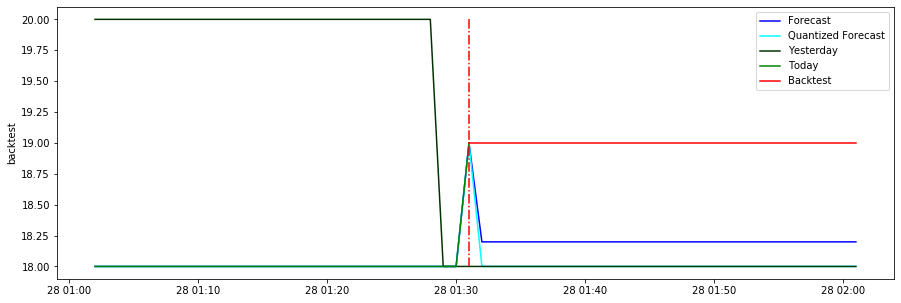

1 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.9364488254635166, 'importance_type': 'gain', 'learning_rate': 0.21523702932117364, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1380, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.5610647335639767, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.8312587738037109


[0]	validation_0-rmse:17.1878
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.4778
[2]	validation_0-rmse:13.9242
[3]	validation_0-rmse:12.5419
[4]	validation_0-rmse:11.2981
[5]	validation_0-rmse:10.1617
[6]	validation_0-rmse:9.14995
[7]	validation_0-rmse:8.23234
[8]	validation_0-rmse:7.41515
[9]	validation_0-rmse:6.67826
[10]	validation_0-rmse:6.01691
[11]	validation_0-rmse:5.4245

[234]	validation_0-rmse:0.009614
[235]	validation_0-rmse:0.009613
[236]	validation_0-rmse:0.009613
[237]	validation_0-rmse:0.009613
[238]	validation_0-rmse:0.009613
[239]	validation_0-rmse:0.009613
[240]	validation_0-rmse:0.009613
[241]	validation_0-rmse:0.009613
[242]	validation_0-rmse:0.009613
[243]	validation_0-rmse:0.009613
[244]	validation_0-rmse:0.009613
[245]	validation_0-rmse:0.009613
[246]	validation_0-rmse:0.009618
[247]	validation_0-rmse:0.009622
[248]	validation_0-rmse:0.009622
[249]	validation_0-rmse:0.009622
[250]	validation_0-rmse:0.009622
[251]	validation_0-rmse:0.00963
[252]	validation_0-rmse:0.00963
[253]	validation_0-rmse:0.00963
[254]	validation_0-rmse:0.009619
[255]	validation_0-rmse:0.00962
[256]	validation_0-rmse:0.00962
[257]	validation_0-rmse:0.00962
[258]	validation_0-rmse:0.009624
[259]	validation_0-rmse:0.009624
[260]	validation_0-rmse:0.009624
[261]	validation_0-rmse:0.009624
[262]	validation_0-rmse:0.009624
[263]	validation_0-rmse:0.009624
[264]	validation

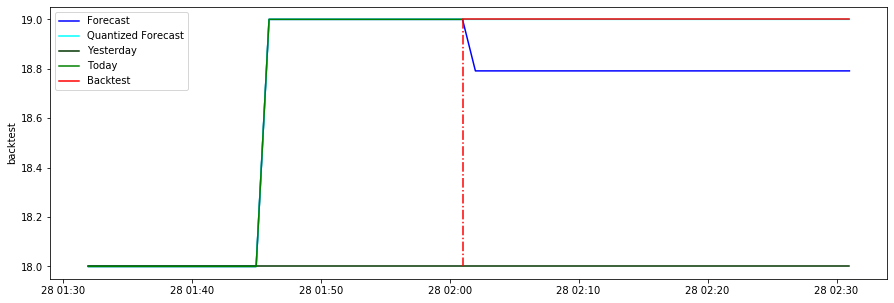

2 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.824549175279343, 'importance_type': 'gain', 'learning_rate': 0.2838376048391101, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1660, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.313503864630637, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.3779926300048828


[0]	validation_0-rmse:17.3111
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.588
[2]	validation_0-rmse:14.0358
[3]	validation_0-rmse:12.6425
[4]	validation_0-rmse:11.3826
[5]	validation_0-rmse:10.2499
[6]	validation_0-rmse:9.22983
[7]	validation_0-rmse:8.31335
[8]	validation_0-rmse:7.48703
[9]	validation_0-rmse:6.74534
[10]	validation_0-rmse:6.07924
[11]	validation_0-rmse:5.47927
[1

[234]	validation_0-rmse:0.002558
[235]	validation_0-rmse:0.002548
[236]	validation_0-rmse:0.002548
[237]	validation_0-rmse:0.002547
[238]	validation_0-rmse:0.002538
[239]	validation_0-rmse:0.002538
[240]	validation_0-rmse:0.002538
[241]	validation_0-rmse:0.00254
[242]	validation_0-rmse:0.00254
[243]	validation_0-rmse:0.002551
[244]	validation_0-rmse:0.002551
[245]	validation_0-rmse:0.002551
[246]	validation_0-rmse:0.002551
[247]	validation_0-rmse:0.002552
[248]	validation_0-rmse:0.002552
[249]	validation_0-rmse:0.002552
[250]	validation_0-rmse:0.002552
[251]	validation_0-rmse:0.002569
[252]	validation_0-rmse:0.002569
[253]	validation_0-rmse:0.002574
[254]	validation_0-rmse:0.002573
[255]	validation_0-rmse:0.00258
[256]	validation_0-rmse:0.002579
[257]	validation_0-rmse:0.002579
[258]	validation_0-rmse:0.002579
[259]	validation_0-rmse:0.002579
[260]	validation_0-rmse:0.002579
[261]	validation_0-rmse:0.002579
[262]	validation_0-rmse:0.00258
[263]	validation_0-rmse:0.00258
[264]	validatio

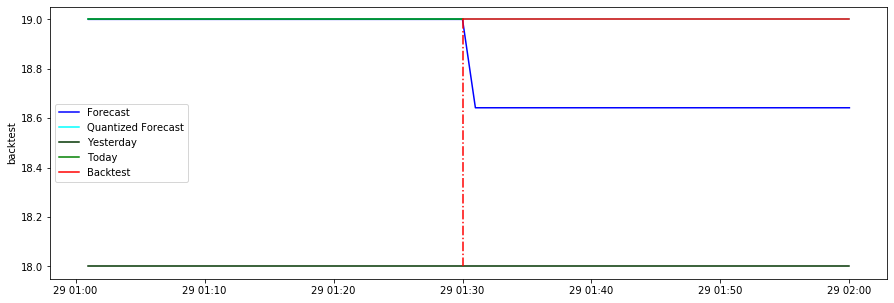

3 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 7.248416682957389, 'importance_type': 'gain', 'learning_rate': 0.23828203306399107, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 590, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.126684591891894, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.47402000427246094


[0]	validation_0-rmse:17.3247
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6001
[2]	validation_0-rmse:14.0464
[3]	validation_0-rmse:12.6517
[4]	validation_0-rmse:11.3906
[5]	validation_0-rmse:10.2572
[6]	validation_0-rmse:9.23719
[7]	validation_0-rmse:8.31969
[8]	validation_0-rmse:7.4927
[9]	validation_0-rmse:6.75012
[10]	validation_0-rmse:6.08335
[11]	validation_0-rmse:5.48269
[

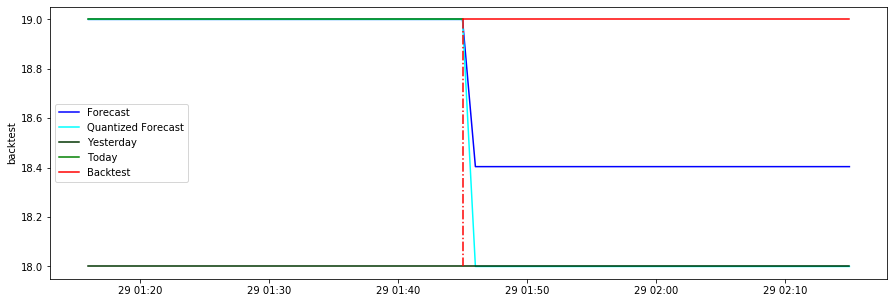

4 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.3597748935853804, 'importance_type': 'gain', 'learning_rate': 0.12209642939110604, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 160, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.375682717455908, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.23056983947753906


[0]	validation_0-rmse:17.281
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5593
[2]	validation_0-rmse:14.0084
[3]	validation_0-rmse:12.6166
[4]	validation_0-rmse:11.357
[5]	validation_0-rmse:10.2259
[6]	validation_0-rmse:9.21141
[7]	validation_0-rmse:8.29507
[8]	validation_0-rmse:7.46922
[9]	validation_0-rmse:6.72824
[10]	validation_0-rmse:6.06292
[11]	validation_0-rmse:5.46372
[

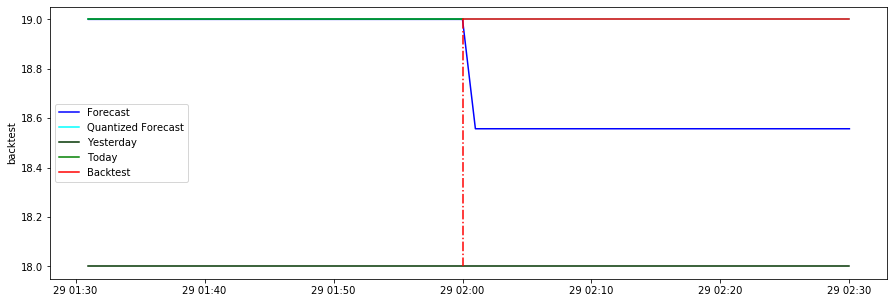

5 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.6111141099896378, 'importance_type': 'gain', 'learning_rate': 0.08183517579503041, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 750, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.159090239894641, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.19449996948242188


[0]	validation_0-rmse:17.2524
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5268
[2]	validation_0-rmse:13.9791
[3]	validation_0-rmse:12.591
[4]	validation_0-rmse:11.3406
[5]	validation_0-rmse:10.2115
[6]	validation_0-rmse:9.19872
[7]	validation_0-rmse:8.28431
[8]	validation_0-rmse:7.45991
[9]	validation_0-rmse:6.72387
[10]	validation_0-rmse:6.0608
[11]	validation_0-rmse:5.4615
[1

[234]	validation_0-rmse:0.008009
[235]	validation_0-rmse:0.008009
[236]	validation_0-rmse:0.008009
[237]	validation_0-rmse:0.008009
[238]	validation_0-rmse:0.008009
[239]	validation_0-rmse:0.008004
[240]	validation_0-rmse:0.008004
[241]	validation_0-rmse:0.008004
[242]	validation_0-rmse:0.008004
[243]	validation_0-rmse:0.008004
[244]	validation_0-rmse:0.008004
[245]	validation_0-rmse:0.008004
[246]	validation_0-rmse:0.008004
[247]	validation_0-rmse:0.008004
[248]	validation_0-rmse:0.008004
[249]	validation_0-rmse:0.008004
[250]	validation_0-rmse:0.008022
[251]	validation_0-rmse:0.008022
[252]	validation_0-rmse:0.008022
[253]	validation_0-rmse:0.008021
[254]	validation_0-rmse:0.00802
[255]	validation_0-rmse:0.00802
[256]	validation_0-rmse:0.00802
[257]	validation_0-rmse:0.00802
[258]	validation_0-rmse:0.00802
[259]	validation_0-rmse:0.008019
[260]	validation_0-rmse:0.008019
[261]	validation_0-rmse:0.008019
[262]	validation_0-rmse:0.008
[263]	validation_0-rmse:0.008
[264]	validation_0-rm

[484]	validation_0-rmse:0.007878
[485]	validation_0-rmse:0.007878
[486]	validation_0-rmse:0.007878
[487]	validation_0-rmse:0.007878
[488]	validation_0-rmse:0.007878
[489]	validation_0-rmse:0.007878
[490]	validation_0-rmse:0.007878
[491]	validation_0-rmse:0.007878
[492]	validation_0-rmse:0.007878
[493]	validation_0-rmse:0.007878
[494]	validation_0-rmse:0.007878
[495]	validation_0-rmse:0.007878
[496]	validation_0-rmse:0.007878
[497]	validation_0-rmse:0.007878
[498]	validation_0-rmse:0.007878
[499]	validation_0-rmse:0.007878
[500]	validation_0-rmse:0.007878
[501]	validation_0-rmse:0.007878
[502]	validation_0-rmse:0.007878
[503]	validation_0-rmse:0.00788
[504]	validation_0-rmse:0.00788
[505]	validation_0-rmse:0.00788
[506]	validation_0-rmse:0.00788
[507]	validation_0-rmse:0.00788
[508]	validation_0-rmse:0.00788
[509]	validation_0-rmse:0.00788
[510]	validation_0-rmse:0.00788
[511]	validation_0-rmse:0.00788
[512]	validation_0-rmse:0.00788
[513]	validation_0-rmse:0.00788
[514]	validation_0-rm

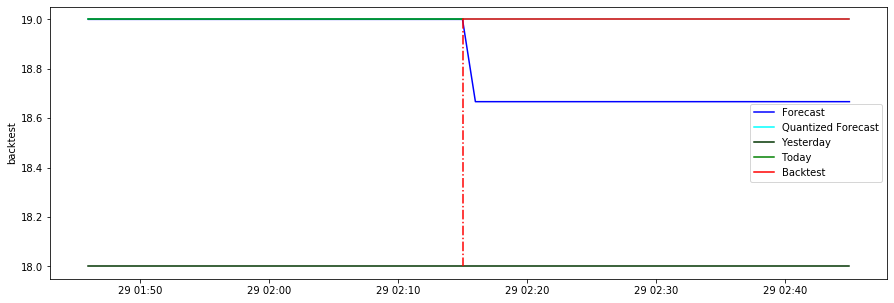

6 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.569110563848401, 'importance_type': 'gain', 'learning_rate': 0.021977414048797474, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1830, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.1453160977082346, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.28769874572753906


[0]	validation_0-rmse:17.22
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5046
[2]	validation_0-rmse:13.9595
[3]	validation_0-rmse:12.5746
[4]	validation_0-rmse:11.3267
[5]	validation_0-rmse:10.2002
[6]	validation_0-rmse:9.18889
[7]	validation_0-rmse:8.27495
[8]	validation_0-rmse:7.45146
[9]	validation_0-rmse:6.71612
[10]	validation_0-rmse:6.05133
[11]	validation_0-rmse:5.45337

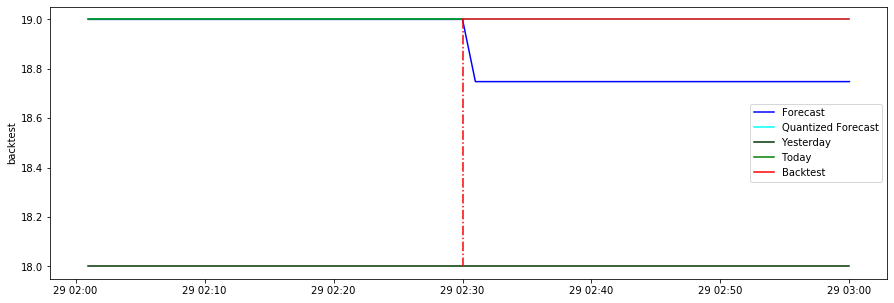

7 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.7717415025219565, 'importance_type': 'gain', 'learning_rate': 0.2421419828614455, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1400, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.597176521619791, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.29604391194455826


[0]	validation_0-rmse:17.2686
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5533
[2]	validation_0-rmse:14.0083
[3]	validation_0-rmse:12.6221
[4]	validation_0-rmse:11.3747
[5]	validation_0-rmse:10.2464
[6]	validation_0-rmse:9.23459
[7]	validation_0-rmse:8.32073
[8]	validation_0-rmse:7.49708
[9]	validation_0-rmse:6.76181
[10]	validation_0-rmse:6.0916
[11]	validation_0-rmse:5.49355


[234]	validation_0-rmse:0.007613
[235]	validation_0-rmse:0.007598
[236]	validation_0-rmse:0.007595
[237]	validation_0-rmse:0.007595
[238]	validation_0-rmse:0.007595
[239]	validation_0-rmse:0.007595
[240]	validation_0-rmse:0.007594
[241]	validation_0-rmse:0.007594
[242]	validation_0-rmse:0.007572
[243]	validation_0-rmse:0.007554
[244]	validation_0-rmse:0.007554
[245]	validation_0-rmse:0.007556
[246]	validation_0-rmse:0.007555
[247]	validation_0-rmse:0.007555
[248]	validation_0-rmse:0.007549
[249]	validation_0-rmse:0.007545
[250]	validation_0-rmse:0.007545
[251]	validation_0-rmse:0.007543
[252]	validation_0-rmse:0.007544
[253]	validation_0-rmse:0.00754
[254]	validation_0-rmse:0.007543
[255]	validation_0-rmse:0.007531
[256]	validation_0-rmse:0.007529
[257]	validation_0-rmse:0.007535
[258]	validation_0-rmse:0.007521
[259]	validation_0-rmse:0.007522
[260]	validation_0-rmse:0.007521
[261]	validation_0-rmse:0.007522
[262]	validation_0-rmse:0.007522
[263]	validation_0-rmse:0.007522
[264]	valid

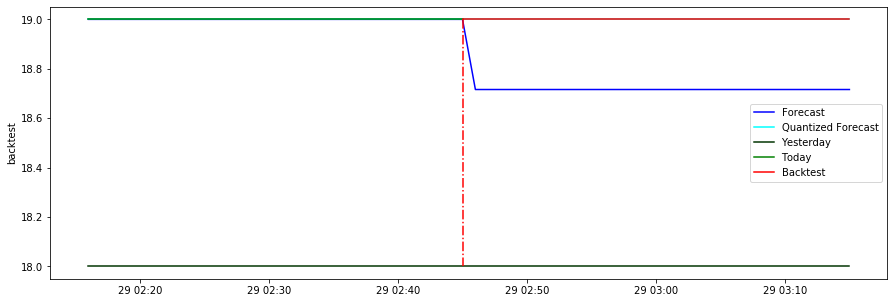

8 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.4799561626390765, 'importance_type': 'gain', 'learning_rate': 0.26319150347202774, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1290, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.221553934033371, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.21701622009277344


[0]	validation_0-rmse:17.2828
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5554
[2]	validation_0-rmse:14.0054
[3]	validation_0-rmse:12.6149
[4]	validation_0-rmse:11.3635
[5]	validation_0-rmse:10.2328
[6]	validation_0-rmse:9.21713
[7]	validation_0-rmse:8.30177
[8]	validation_0-rmse:7.47604
[9]	validation_0-rmse:6.73506
[10]	validation_0-rmse:6.07254
[11]	validation_0-rmse:5.4732

[234]	validation_0-rmse:0.00492
[235]	validation_0-rmse:0.004919
[236]	validation_0-rmse:0.004919
[237]	validation_0-rmse:0.00492
[238]	validation_0-rmse:0.004898
[239]	validation_0-rmse:0.004898
[240]	validation_0-rmse:0.004898
[241]	validation_0-rmse:0.004894
[242]	validation_0-rmse:0.004895
[243]	validation_0-rmse:0.004899
[244]	validation_0-rmse:0.004899
[245]	validation_0-rmse:0.004899
[246]	validation_0-rmse:0.004892
[247]	validation_0-rmse:0.004892
[248]	validation_0-rmse:0.004891
[249]	validation_0-rmse:0.004898
[250]	validation_0-rmse:0.004899
[251]	validation_0-rmse:0.0049
[252]	validation_0-rmse:0.0049
[253]	validation_0-rmse:0.0049
[254]	validation_0-rmse:0.0049
[255]	validation_0-rmse:0.004899
[256]	validation_0-rmse:0.004898
[257]	validation_0-rmse:0.004898
[258]	validation_0-rmse:0.004898
[259]	validation_0-rmse:0.004898
[260]	validation_0-rmse:0.004898
[261]	validation_0-rmse:0.004898
[262]	validation_0-rmse:0.004898
[263]	validation_0-rmse:0.004898
[264]	validation_0-r

[484]	validation_0-rmse:0.004854
[485]	validation_0-rmse:0.004854
[486]	validation_0-rmse:0.004854
[487]	validation_0-rmse:0.004854
[488]	validation_0-rmse:0.004853
[489]	validation_0-rmse:0.004853
[490]	validation_0-rmse:0.004853
[491]	validation_0-rmse:0.004853
[492]	validation_0-rmse:0.004853
[493]	validation_0-rmse:0.004853
[494]	validation_0-rmse:0.004853
[495]	validation_0-rmse:0.004853
[496]	validation_0-rmse:0.004853
[497]	validation_0-rmse:0.004853
[498]	validation_0-rmse:0.004853
[499]	validation_0-rmse:0.004853
[500]	validation_0-rmse:0.004856
[501]	validation_0-rmse:0.004856
[502]	validation_0-rmse:0.004857
[503]	validation_0-rmse:0.00486
[504]	validation_0-rmse:0.00486
[505]	validation_0-rmse:0.004859
[506]	validation_0-rmse:0.004859
[507]	validation_0-rmse:0.004859
[508]	validation_0-rmse:0.004859
[509]	validation_0-rmse:0.004851
[510]	validation_0-rmse:0.004851
[511]	validation_0-rmse:0.004851
[512]	validation_0-rmse:0.004851
[513]	validation_0-rmse:0.004851
[514]	valida

[734]	validation_0-rmse:0.004812
[735]	validation_0-rmse:0.004812
[736]	validation_0-rmse:0.004812
[737]	validation_0-rmse:0.004812
[738]	validation_0-rmse:0.004812
[739]	validation_0-rmse:0.004809
[740]	validation_0-rmse:0.004809
[741]	validation_0-rmse:0.004809
[742]	validation_0-rmse:0.004809
[743]	validation_0-rmse:0.004809
[744]	validation_0-rmse:0.004809
[745]	validation_0-rmse:0.004809
[746]	validation_0-rmse:0.004808
[747]	validation_0-rmse:0.004808
[748]	validation_0-rmse:0.004809
[749]	validation_0-rmse:0.004809
[750]	validation_0-rmse:0.004809
[751]	validation_0-rmse:0.004809
[752]	validation_0-rmse:0.004809
[753]	validation_0-rmse:0.00481
[754]	validation_0-rmse:0.004809
[755]	validation_0-rmse:0.004809
[756]	validation_0-rmse:0.004809
[757]	validation_0-rmse:0.00481
[758]	validation_0-rmse:0.00481
[759]	validation_0-rmse:0.00481
[760]	validation_0-rmse:0.00481
[761]	validation_0-rmse:0.00481
[762]	validation_0-rmse:0.004811
[763]	validation_0-rmse:0.004814
[764]	validation

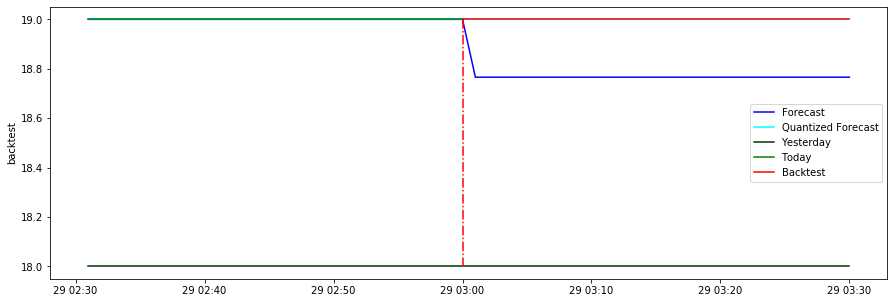

9 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.7405725432651415, 'importance_type': 'gain', 'learning_rate': 0.05939301434754483, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1170, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.210064005342827, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.4125995635986328


[0]	validation_0-rmse:17.3108
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5873
[2]	validation_0-rmse:14.0346
[3]	validation_0-rmse:12.6409
[4]	validation_0-rmse:11.3806
[5]	validation_0-rmse:10.2479
[6]	validation_0-rmse:9.22775
[7]	validation_0-rmse:8.31123
[8]	validation_0-rmse:7.48511
[9]	validation_0-rmse:6.74315
[10]	validation_0-rmse:6.07678
[11]	validation_0-rmse:5.47652

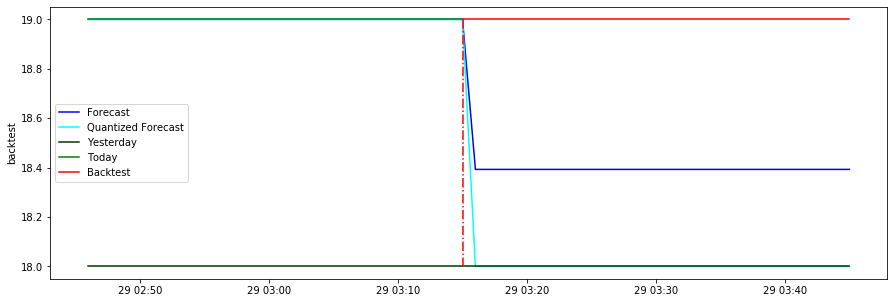

10 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.802348050761666, 'importance_type': 'gain', 'learning_rate': 0.16875060845336434, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 900, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.25752527709870315, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.25681304931640625


[0]	validation_0-rmse:17.3244
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5996
[2]	validation_0-rmse:14.0454
[3]	validation_0-rmse:12.6504
[4]	validation_0-rmse:11.3888
[5]	validation_0-rmse:10.2551
[6]	validation_0-rmse:9.2345
[7]	validation_0-rmse:8.31649
[8]	validation_0-rmse:7.48907
[9]	validation_0-rmse:6.74685
[10]	validation_0-rmse:6.07966
[11]	validation_0-rmse:5.4785

[234]	validation_0-rmse:0.002137
[235]	validation_0-rmse:0.002137
[236]	validation_0-rmse:0.002137
[237]	validation_0-rmse:0.002137
[238]	validation_0-rmse:0.002137
[239]	validation_0-rmse:0.002137
[240]	validation_0-rmse:0.002137
[241]	validation_0-rmse:0.002137
[242]	validation_0-rmse:0.002137
[243]	validation_0-rmse:0.002137
[244]	validation_0-rmse:0.002137
[245]	validation_0-rmse:0.002137
[246]	validation_0-rmse:0.002137
[247]	validation_0-rmse:0.002137
[248]	validation_0-rmse:0.002137
[249]	validation_0-rmse:0.002137
[250]	validation_0-rmse:0.002137
[251]	validation_0-rmse:0.00213
[252]	validation_0-rmse:0.002131
[253]	validation_0-rmse:0.002131
[254]	validation_0-rmse:0.002131
[255]	validation_0-rmse:0.002131
[256]	validation_0-rmse:0.002131
[257]	validation_0-rmse:0.002131
[258]	validation_0-rmse:0.002133
[259]	validation_0-rmse:0.002133
[260]	validation_0-rmse:0.002133
[261]	validation_0-rmse:0.002132
[262]	validation_0-rmse:0.002132
[263]	validation_0-rmse:0.00213
[264]	valida

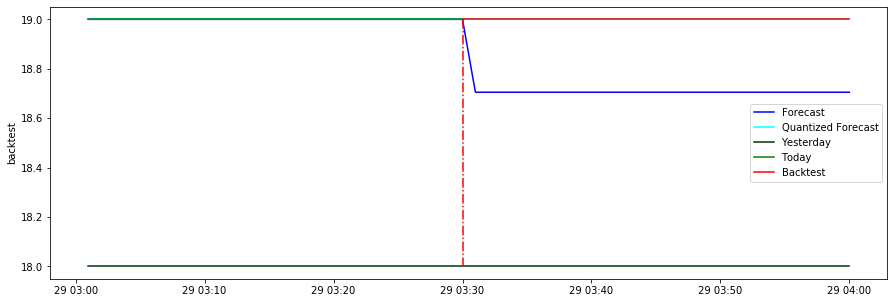

11 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 4.14783723162838, 'importance_type': 'gain', 'learning_rate': 0.19253973404953453, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.350846380142122, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.3309135437011719


[0]	validation_0-rmse:17.3244
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5996
[2]	validation_0-rmse:14.0454
[3]	validation_0-rmse:12.6504
[4]	validation_0-rmse:11.3888
[5]	validation_0-rmse:10.2551
[6]	validation_0-rmse:9.2345
[7]	validation_0-rmse:8.31649
[8]	validation_0-rmse:7.48907
[9]	validation_0-rmse:6.74685
[10]	validation_0-rmse:6.07966
[11]	validation_0-rmse:5.47855
[

[235]	validation_0-rmse:0.002533
[236]	validation_0-rmse:0.002533
[237]	validation_0-rmse:0.002532
[238]	validation_0-rmse:0.002532
[239]	validation_0-rmse:0.002532
[240]	validation_0-rmse:0.002532
[241]	validation_0-rmse:0.002532
[242]	validation_0-rmse:0.002532
[243]	validation_0-rmse:0.002532
[244]	validation_0-rmse:0.002532
[245]	validation_0-rmse:0.002529
[246]	validation_0-rmse:0.002529
[247]	validation_0-rmse:0.002529
[248]	validation_0-rmse:0.002529
[249]	validation_0-rmse:0.002529
[250]	validation_0-rmse:0.002525
[251]	validation_0-rmse:0.002522
[252]	validation_0-rmse:0.002522
[253]	validation_0-rmse:0.002527
[254]	validation_0-rmse:0.002527
[255]	validation_0-rmse:0.002509
[256]	validation_0-rmse:0.002509
[257]	validation_0-rmse:0.002509
[258]	validation_0-rmse:0.002511
[259]	validation_0-rmse:0.002511
[260]	validation_0-rmse:0.002511
[261]	validation_0-rmse:0.002511
[262]	validation_0-rmse:0.002516
[263]	validation_0-rmse:0.002516
[264]	validation_0-rmse:0.002516
[265]	vali

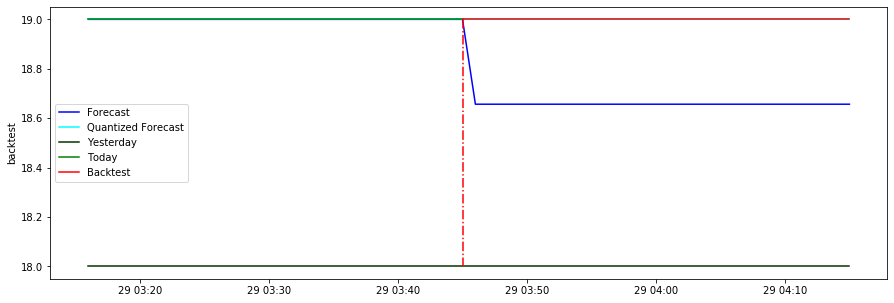

12 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 4.490494796155346, 'importance_type': 'gain', 'learning_rate': 0.09927497943020329, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 320, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.518902750847781, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.3436603546142578


[0]	validation_0-rmse:17.3244
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5996
[2]	validation_0-rmse:14.0454
[3]	validation_0-rmse:12.6504
[4]	validation_0-rmse:11.3888
[5]	validation_0-rmse:10.2551
[6]	validation_0-rmse:9.2345
[7]	validation_0-rmse:8.31649
[8]	validation_0-rmse:7.48907
[9]	validation_0-rmse:6.74685
[10]	validation_0-rmse:6.07966
[11]	validation_0-rmse:5.47855
[

[234]	validation_0-rmse:0.002584
[235]	validation_0-rmse:0.002576
[236]	validation_0-rmse:0.002577
[237]	validation_0-rmse:0.002577
[238]	validation_0-rmse:0.002578
[239]	validation_0-rmse:0.002578
[240]	validation_0-rmse:0.002579
[241]	validation_0-rmse:0.002579
[242]	validation_0-rmse:0.002573
[243]	validation_0-rmse:0.002573
[244]	validation_0-rmse:0.002573
[245]	validation_0-rmse:0.002573
[246]	validation_0-rmse:0.002573
[247]	validation_0-rmse:0.002573
[248]	validation_0-rmse:0.002572
[249]	validation_0-rmse:0.00257
[250]	validation_0-rmse:0.00257
[251]	validation_0-rmse:0.00257
[252]	validation_0-rmse:0.00257
[253]	validation_0-rmse:0.00257
[254]	validation_0-rmse:0.00257
[255]	validation_0-rmse:0.002571
[256]	validation_0-rmse:0.00257
[257]	validation_0-rmse:0.002571
[258]	validation_0-rmse:0.00257
[259]	validation_0-rmse:0.00257
[260]	validation_0-rmse:0.00257
[261]	validation_0-rmse:0.00257
[262]	validation_0-rmse:0.002572
[263]	validation_0-rmse:0.002572
[264]	validation_0-rm

[484]	validation_0-rmse:0.00254
[485]	validation_0-rmse:0.00254
[486]	validation_0-rmse:0.00254
[487]	validation_0-rmse:0.00254
[488]	validation_0-rmse:0.00254
[489]	validation_0-rmse:0.00254
[490]	validation_0-rmse:0.00254
[491]	validation_0-rmse:0.00254
[492]	validation_0-rmse:0.00254
[493]	validation_0-rmse:0.002541
[494]	validation_0-rmse:0.002541
[495]	validation_0-rmse:0.002541
[496]	validation_0-rmse:0.002541
[497]	validation_0-rmse:0.00254
[498]	validation_0-rmse:0.00254
[499]	validation_0-rmse:0.00254
[500]	validation_0-rmse:0.00254
[501]	validation_0-rmse:0.00254
[502]	validation_0-rmse:0.00254
[503]	validation_0-rmse:0.002541
[504]	validation_0-rmse:0.002541
[505]	validation_0-rmse:0.00254
[506]	validation_0-rmse:0.00254
[507]	validation_0-rmse:0.002543
[508]	validation_0-rmse:0.002543
[509]	validation_0-rmse:0.002543
[510]	validation_0-rmse:0.002543
[511]	validation_0-rmse:0.002543
[512]	validation_0-rmse:0.002543
[513]	validation_0-rmse:0.002543
[514]	validation_0-rmse:0.0

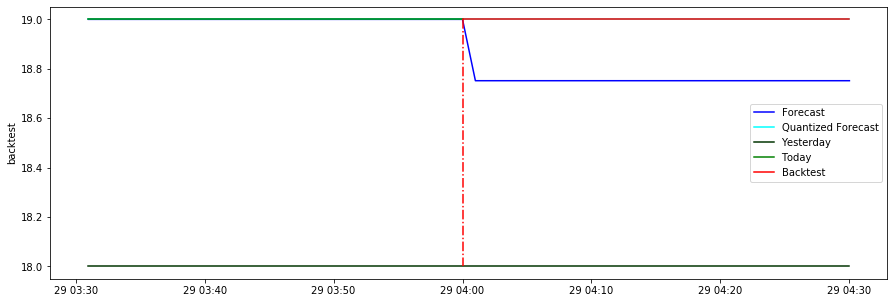

13 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.941951758162297, 'importance_type': 'gain', 'learning_rate': 0.12235273688355026, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 840, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 10.12444560751637, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.4271354675292969


[0]	validation_0-rmse:17.3244
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.5996
[2]	validation_0-rmse:14.0454
[3]	validation_0-rmse:12.6504
[4]	validation_0-rmse:11.3888
[5]	validation_0-rmse:10.2551
[6]	validation_0-rmse:9.2345
[7]	validation_0-rmse:8.31649
[8]	validation_0-rmse:7.48907
[9]	validation_0-rmse:6.74685
[10]	validation_0-rmse:6.07966
[11]	validation_0-rmse:5.47855
[

[234]	validation_0-rmse:0.00304
[235]	validation_0-rmse:0.00304
[236]	validation_0-rmse:0.00304
[237]	validation_0-rmse:0.00304
[238]	validation_0-rmse:0.003038
[239]	validation_0-rmse:0.003038
[240]	validation_0-rmse:0.003038
[241]	validation_0-rmse:0.003038
[242]	validation_0-rmse:0.003038
[243]	validation_0-rmse:0.003038
[244]	validation_0-rmse:0.003038
[245]	validation_0-rmse:0.003038
[246]	validation_0-rmse:0.003038
[247]	validation_0-rmse:0.003039
[248]	validation_0-rmse:0.003038
[249]	validation_0-rmse:0.00304
[250]	validation_0-rmse:0.00304
[251]	validation_0-rmse:0.00304
[252]	validation_0-rmse:0.00304
[253]	validation_0-rmse:0.00304
[254]	validation_0-rmse:0.003038
[255]	validation_0-rmse:0.003038
[256]	validation_0-rmse:0.003038
[257]	validation_0-rmse:0.003039
[258]	validation_0-rmse:0.003039
[259]	validation_0-rmse:0.003037
[260]	validation_0-rmse:0.003037
[261]	validation_0-rmse:0.003037
[262]	validation_0-rmse:0.003037
[263]	validation_0-rmse:0.003036
[264]	validation_0-

[485]	validation_0-rmse:0.003017
[486]	validation_0-rmse:0.003017
[487]	validation_0-rmse:0.003017
[488]	validation_0-rmse:0.003017
[489]	validation_0-rmse:0.003017
[490]	validation_0-rmse:0.003017
[491]	validation_0-rmse:0.003017
[492]	validation_0-rmse:0.003017
[493]	validation_0-rmse:0.003017
[494]	validation_0-rmse:0.003017
[495]	validation_0-rmse:0.003017
[496]	validation_0-rmse:0.003017
[497]	validation_0-rmse:0.003017
[498]	validation_0-rmse:0.003017
[499]	validation_0-rmse:0.003017
[500]	validation_0-rmse:0.003017
[501]	validation_0-rmse:0.003017
[502]	validation_0-rmse:0.003017
[503]	validation_0-rmse:0.003017
[504]	validation_0-rmse:0.003017
[505]	validation_0-rmse:0.003017
[506]	validation_0-rmse:0.003017
[507]	validation_0-rmse:0.003017
[508]	validation_0-rmse:0.003017
[509]	validation_0-rmse:0.003017
[510]	validation_0-rmse:0.003018
[511]	validation_0-rmse:0.003018
[512]	validation_0-rmse:0.003018
[513]	validation_0-rmse:0.003018
[514]	validation_0-rmse:0.003021
[515]	vali

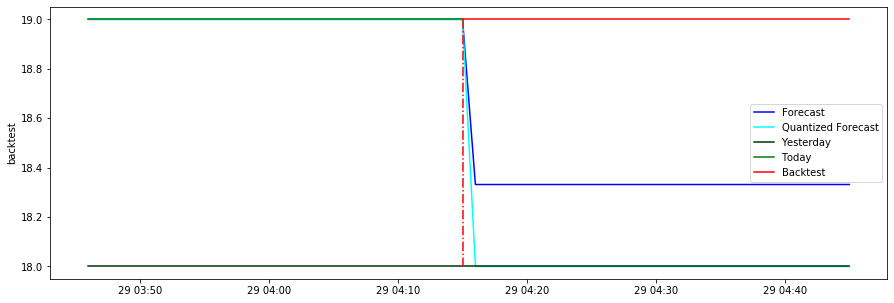

14 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.1268030470893673, 'importance_type': 'gain', 'learning_rate': 0.13342040995846377, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 40, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.036537469033338814, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.2624626159667969


[0]	validation_0-rmse:17.3395
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6134
[2]	validation_0-rmse:14.0578
[3]	validation_0-rmse:12.6612
[4]	validation_0-rmse:11.3983
[5]	validation_0-rmse:10.2637
[6]	validation_0-rmse:9.2416
[7]	validation_0-rmse:8.32244
[8]	validation_0-rmse:7.49405
[9]	validation_0-rmse:6.75167
[10]	validation_0-rmse:6.08026
[11]	validation_0-rmse:5.4779

[234]	validation_0-rmse:0.00434
[235]	validation_0-rmse:0.004339
[236]	validation_0-rmse:0.004339
[237]	validation_0-rmse:0.004338
[238]	validation_0-rmse:0.004338
[239]	validation_0-rmse:0.004338
[240]	validation_0-rmse:0.004339
[241]	validation_0-rmse:0.004339
[242]	validation_0-rmse:0.004339
[243]	validation_0-rmse:0.004336
[244]	validation_0-rmse:0.004336
[245]	validation_0-rmse:0.004324
[246]	validation_0-rmse:0.004324
[247]	validation_0-rmse:0.004324
[248]	validation_0-rmse:0.004324
[249]	validation_0-rmse:0.004324
[250]	validation_0-rmse:0.004325
[251]	validation_0-rmse:0.004324
[252]	validation_0-rmse:0.004324
[253]	validation_0-rmse:0.004319
[254]	validation_0-rmse:0.004319
[255]	validation_0-rmse:0.004313
[256]	validation_0-rmse:0.004313
[257]	validation_0-rmse:0.004313
[258]	validation_0-rmse:0.004313
[259]	validation_0-rmse:0.004314
[260]	validation_0-rmse:0.004314
[261]	validation_0-rmse:0.004314
[262]	validation_0-rmse:0.004313
[263]	validation_0-rmse:0.004313
[264]	valid

[483]	validation_0-rmse:0.004203
[484]	validation_0-rmse:0.004201
[485]	validation_0-rmse:0.004201
[486]	validation_0-rmse:0.004201
[487]	validation_0-rmse:0.004201
[488]	validation_0-rmse:0.004201
[489]	validation_0-rmse:0.004201
[490]	validation_0-rmse:0.004201
[491]	validation_0-rmse:0.004203
[492]	validation_0-rmse:0.004203
[493]	validation_0-rmse:0.004203
[494]	validation_0-rmse:0.004203
[495]	validation_0-rmse:0.004203
[496]	validation_0-rmse:0.004203
[497]	validation_0-rmse:0.004203
[498]	validation_0-rmse:0.004203
[499]	validation_0-rmse:0.004203
[500]	validation_0-rmse:0.004203
[501]	validation_0-rmse:0.004203
[502]	validation_0-rmse:0.004203
[503]	validation_0-rmse:0.004203
[504]	validation_0-rmse:0.004203
[505]	validation_0-rmse:0.004203
[506]	validation_0-rmse:0.004203
[507]	validation_0-rmse:0.004203
[508]	validation_0-rmse:0.004203
[509]	validation_0-rmse:0.004205
[510]	validation_0-rmse:0.004205
[511]	validation_0-rmse:0.004205
[512]	validation_0-rmse:0.004203
[513]	vali

[732]	validation_0-rmse:0.004186
[733]	validation_0-rmse:0.004186
[734]	validation_0-rmse:0.004186
[735]	validation_0-rmse:0.004185
[736]	validation_0-rmse:0.004183
[737]	validation_0-rmse:0.004183
[738]	validation_0-rmse:0.004183
[739]	validation_0-rmse:0.004183
[740]	validation_0-rmse:0.004183
[741]	validation_0-rmse:0.004181
[742]	validation_0-rmse:0.004181
[743]	validation_0-rmse:0.00418
[744]	validation_0-rmse:0.00418
[745]	validation_0-rmse:0.004181
[746]	validation_0-rmse:0.004181
[747]	validation_0-rmse:0.00418
[748]	validation_0-rmse:0.00418
[749]	validation_0-rmse:0.00418
[750]	validation_0-rmse:0.00418
[751]	validation_0-rmse:0.00418
[752]	validation_0-rmse:0.00418
[753]	validation_0-rmse:0.00418
[754]	validation_0-rmse:0.00418
[755]	validation_0-rmse:0.00418
[756]	validation_0-rmse:0.00418
[757]	validation_0-rmse:0.00418
[758]	validation_0-rmse:0.004179
[759]	validation_0-rmse:0.00418
[760]	validation_0-rmse:0.004181
[761]	validation_0-rmse:0.004181
[762]	validation_0-rmse:

[981]	validation_0-rmse:0.004158
[982]	validation_0-rmse:0.004158
[983]	validation_0-rmse:0.004158
[984]	validation_0-rmse:0.004158
[985]	validation_0-rmse:0.004158
[986]	validation_0-rmse:0.004159
[987]	validation_0-rmse:0.004159
[988]	validation_0-rmse:0.004159
[989]	validation_0-rmse:0.004159
[990]	validation_0-rmse:0.004159
[991]	validation_0-rmse:0.004159
[992]	validation_0-rmse:0.004157
[993]	validation_0-rmse:0.004157
[994]	validation_0-rmse:0.004156
[995]	validation_0-rmse:0.004156
[996]	validation_0-rmse:0.004157
[997]	validation_0-rmse:0.004158
[998]	validation_0-rmse:0.004158
[999]	validation_0-rmse:0.004158
[1000]	validation_0-rmse:0.004154
[1001]	validation_0-rmse:0.004154
[1002]	validation_0-rmse:0.004154
[1003]	validation_0-rmse:0.004154
[1004]	validation_0-rmse:0.004153
[1005]	validation_0-rmse:0.004153
[1006]	validation_0-rmse:0.004152
[1007]	validation_0-rmse:0.004152
[1008]	validation_0-rmse:0.004152
[1009]	validation_0-rmse:0.004152
[1010]	validation_0-rmse:0.004152

[1224]	validation_0-rmse:0.004136
[1225]	validation_0-rmse:0.004136
[1226]	validation_0-rmse:0.004136
[1227]	validation_0-rmse:0.004136
[1228]	validation_0-rmse:0.004136
[1229]	validation_0-rmse:0.004135
[1230]	validation_0-rmse:0.004135
[1231]	validation_0-rmse:0.004135
[1232]	validation_0-rmse:0.004135
[1233]	validation_0-rmse:0.004135
[1234]	validation_0-rmse:0.004135
[1235]	validation_0-rmse:0.004135
[1236]	validation_0-rmse:0.004134
[1237]	validation_0-rmse:0.004134
[1238]	validation_0-rmse:0.004134
[1239]	validation_0-rmse:0.004134
[1240]	validation_0-rmse:0.004133
[1241]	validation_0-rmse:0.004133
[1242]	validation_0-rmse:0.004133
[1243]	validation_0-rmse:0.004134
[1244]	validation_0-rmse:0.004134
[1245]	validation_0-rmse:0.004134
[1246]	validation_0-rmse:0.004134
[1247]	validation_0-rmse:0.004134
[1248]	validation_0-rmse:0.004134
[1249]	validation_0-rmse:0.004133
[1250]	validation_0-rmse:0.004133
[1251]	validation_0-rmse:0.004133
[1252]	validation_0-rmse:0.004133
[1253]	validat

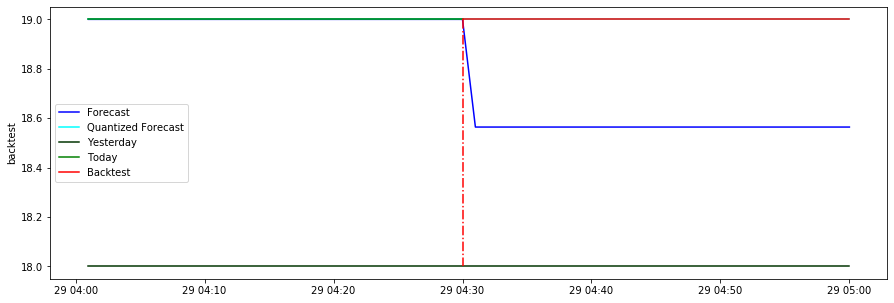

15 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.5300021321828363, 'importance_type': 'gain', 'learning_rate': 0.24057660311311227, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1410, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.42051231299033354, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.09029769897460938


[0]	validation_0-rmse:17.4027
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6744
[2]	validation_0-rmse:14.1163
[3]	validation_0-rmse:12.7172
[4]	validation_0-rmse:11.4532
[5]	validation_0-rmse:10.3162
[6]	validation_0-rmse:9.29239
[7]	validation_0-rmse:8.37178
[8]	validation_0-rmse:7.54197
[9]	validation_0-rmse:6.79463
[10]	validation_0-rmse:6.12561
[11]	validation_0-rmse:5.5

[234]	validation_0-rmse:0.042449
[235]	validation_0-rmse:0.042449
[236]	validation_0-rmse:0.042449
[237]	validation_0-rmse:0.042448
[238]	validation_0-rmse:0.042449
[239]	validation_0-rmse:0.042449
[240]	validation_0-rmse:0.042449
[241]	validation_0-rmse:0.042448
[242]	validation_0-rmse:0.042448
[243]	validation_0-rmse:0.042452
[244]	validation_0-rmse:0.04245
[245]	validation_0-rmse:0.04245
[246]	validation_0-rmse:0.042451
[247]	validation_0-rmse:0.042451
[248]	validation_0-rmse:0.042451
[249]	validation_0-rmse:0.042451
[250]	validation_0-rmse:0.04245
[251]	validation_0-rmse:0.04245
[252]	validation_0-rmse:0.04245
[253]	validation_0-rmse:0.04245
[254]	validation_0-rmse:0.042451
[255]	validation_0-rmse:0.042453
[256]	validation_0-rmse:0.042453
[257]	validation_0-rmse:0.042453
[258]	validation_0-rmse:0.042452
[259]	validation_0-rmse:0.042452
[260]	validation_0-rmse:0.042452
[261]	validation_0-rmse:0.042452
[262]	validation_0-rmse:0.042452
[263]	validation_0-rmse:0.042453
[264]	validation

[484]	validation_0-rmse:0.042382
[485]	validation_0-rmse:0.042382
[486]	validation_0-rmse:0.042382
[487]	validation_0-rmse:0.042382
[488]	validation_0-rmse:0.042382
[489]	validation_0-rmse:0.042382
[490]	validation_0-rmse:0.042382
[491]	validation_0-rmse:0.042382
[492]	validation_0-rmse:0.042382
[493]	validation_0-rmse:0.042381
[494]	validation_0-rmse:0.042381
[495]	validation_0-rmse:0.042379
[496]	validation_0-rmse:0.042379
[497]	validation_0-rmse:0.042379
[498]	validation_0-rmse:0.042379
[499]	validation_0-rmse:0.042379
[500]	validation_0-rmse:0.042379
[501]	validation_0-rmse:0.04238
[502]	validation_0-rmse:0.042379
[503]	validation_0-rmse:0.042379
[504]	validation_0-rmse:0.042379
[505]	validation_0-rmse:0.042379
[506]	validation_0-rmse:0.04238
[507]	validation_0-rmse:0.04238
[508]	validation_0-rmse:0.04238
[509]	validation_0-rmse:0.042379
[510]	validation_0-rmse:0.042379
[511]	validation_0-rmse:0.042379
[512]	validation_0-rmse:0.042379
[513]	validation_0-rmse:0.04238
[514]	validatio

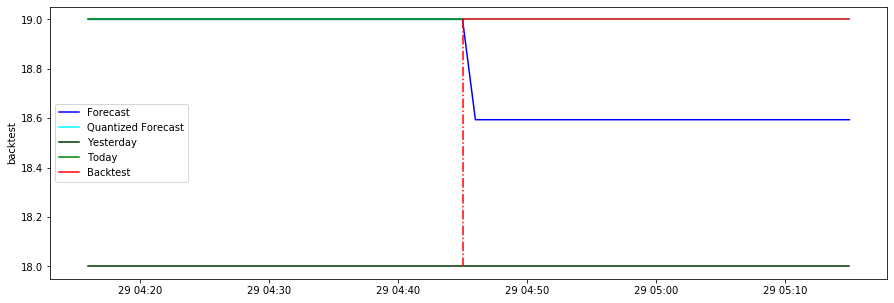

16 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.593461688305856, 'importance_type': 'gain', 'learning_rate': 0.12434149726348062, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1950, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.7585861940166945, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.40382957458496094


[0]	validation_0-rmse:17.3996
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6686
[2]	validation_0-rmse:14.1081
[3]	validation_0-rmse:12.706
[4]	validation_0-rmse:11.4451
[5]	validation_0-rmse:10.306
[6]	validation_0-rmse:9.27957
[7]	validation_0-rmse:8.35282
[8]	validation_0-rmse:7.52117
[9]	validation_0-rmse:6.77197
[10]	validation_0-rmse:6.10022
[11]	validation_0-rmse:5.49574

[234]	validation_0-rmse:0.005075
[235]	validation_0-rmse:0.005077
[236]	validation_0-rmse:0.005077
[237]	validation_0-rmse:0.005077
[238]	validation_0-rmse:0.005077
[239]	validation_0-rmse:0.005077
[240]	validation_0-rmse:0.005077
[241]	validation_0-rmse:0.005077
[242]	validation_0-rmse:0.005077
[243]	validation_0-rmse:0.005078
[244]	validation_0-rmse:0.005078
[245]	validation_0-rmse:0.005078
[246]	validation_0-rmse:0.005078
[247]	validation_0-rmse:0.005078
[248]	validation_0-rmse:0.005078
[249]	validation_0-rmse:0.005078
[250]	validation_0-rmse:0.005076
[251]	validation_0-rmse:0.005076
[252]	validation_0-rmse:0.00507
[253]	validation_0-rmse:0.005071
[254]	validation_0-rmse:0.005071
[255]	validation_0-rmse:0.005077
[256]	validation_0-rmse:0.005077
[257]	validation_0-rmse:0.005077
[258]	validation_0-rmse:0.005077
[259]	validation_0-rmse:0.005077
[260]	validation_0-rmse:0.005077
[261]	validation_0-rmse:0.005078
[262]	validation_0-rmse:0.005078
[263]	validation_0-rmse:0.005078
[264]	valid

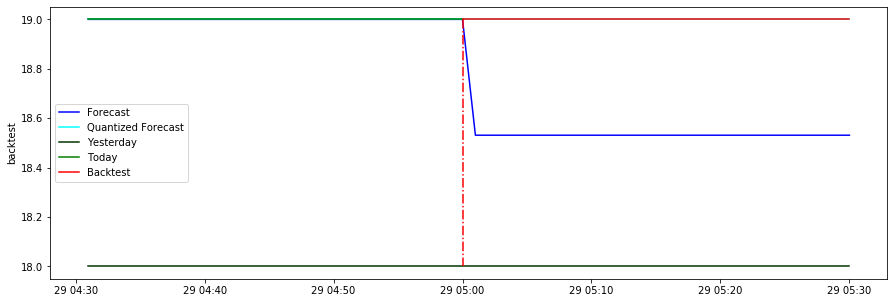

17 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.1968596396575839, 'importance_type': 'gain', 'learning_rate': 0.12007335131551283, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1510, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 5.248955774323792, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.2174835205078125


[0]	validation_0-rmse:17.4458
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.7122
[2]	validation_0-rmse:14.1497
[3]	validation_0-rmse:12.7455
[4]	validation_0-rmse:11.4824
[5]	validation_0-rmse:10.3418
[6]	validation_0-rmse:9.30992
[7]	validation_0-rmse:8.3853
[8]	validation_0-rmse:7.55228
[9]	validation_0-rmse:6.79825
[10]	validation_0-rmse:6.12469
[11]	validation_0-rmse:5.51868

[234]	validation_0-rmse:0.002282
[235]	validation_0-rmse:0.002275
[236]	validation_0-rmse:0.002275
[237]	validation_0-rmse:0.002274
[238]	validation_0-rmse:0.002273
[239]	validation_0-rmse:0.002274
[240]	validation_0-rmse:0.002274
[241]	validation_0-rmse:0.002274
[242]	validation_0-rmse:0.002273
[243]	validation_0-rmse:0.002272
[244]	validation_0-rmse:0.002271
[245]	validation_0-rmse:0.002273
[246]	validation_0-rmse:0.002275
[247]	validation_0-rmse:0.002275
[248]	validation_0-rmse:0.002273
[249]	validation_0-rmse:0.002273
[250]	validation_0-rmse:0.002273
[251]	validation_0-rmse:0.002271
[252]	validation_0-rmse:0.002268
[253]	validation_0-rmse:0.002268
[254]	validation_0-rmse:0.002262
[255]	validation_0-rmse:0.002257
[256]	validation_0-rmse:0.002252
[257]	validation_0-rmse:0.002254
[258]	validation_0-rmse:0.002255
[259]	validation_0-rmse:0.002254
[260]	validation_0-rmse:0.002254
[261]	validation_0-rmse:0.002254
[262]	validation_0-rmse:0.002254
[263]	validation_0-rmse:0.002254
[264]	vali

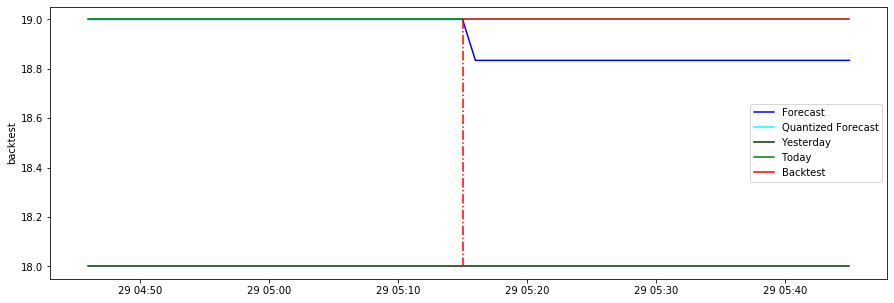

18 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.996413747366701, 'importance_type': 'gain', 'learning_rate': 0.0520744984526214, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.8862815850004664, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.21796035766601562


[0]	validation_0-rmse:17.4442
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.7098
[2]	validation_0-rmse:14.1462
[3]	validation_0-rmse:12.7408
[4]	validation_0-rmse:11.4766
[5]	validation_0-rmse:10.3352
[6]	validation_0-rmse:9.30324
[7]	validation_0-rmse:8.37771
[8]	validation_0-rmse:7.54392
[9]	validation_0-rmse:6.78987
[10]	validation_0-rmse:6.11563
[11]	validation_0-rmse:5.5090

[234]	validation_0-rmse:0.001747
[235]	validation_0-rmse:0.001747
[236]	validation_0-rmse:0.001748
[237]	validation_0-rmse:0.001748
[238]	validation_0-rmse:0.001748
[239]	validation_0-rmse:0.001748
[240]	validation_0-rmse:0.001748
[241]	validation_0-rmse:0.001748
[242]	validation_0-rmse:0.001748
[243]	validation_0-rmse:0.001748
[244]	validation_0-rmse:0.001748
[245]	validation_0-rmse:0.001748
[246]	validation_0-rmse:0.001748
[247]	validation_0-rmse:0.001748
[248]	validation_0-rmse:0.001748
[249]	validation_0-rmse:0.001748
[250]	validation_0-rmse:0.001748
[251]	validation_0-rmse:0.001748
[252]	validation_0-rmse:0.001748
[253]	validation_0-rmse:0.001748
[254]	validation_0-rmse:0.001748
[255]	validation_0-rmse:0.001748
[256]	validation_0-rmse:0.001748
[257]	validation_0-rmse:0.001748
[258]	validation_0-rmse:0.00175
[259]	validation_0-rmse:0.00175
[260]	validation_0-rmse:0.00175
[261]	validation_0-rmse:0.00175
[262]	validation_0-rmse:0.00175
[263]	validation_0-rmse:0.00175
[264]	validation

[485]	validation_0-rmse:0.00172
[486]	validation_0-rmse:0.00172
[487]	validation_0-rmse:0.00172
[488]	validation_0-rmse:0.00172
[489]	validation_0-rmse:0.00172
[490]	validation_0-rmse:0.00172
[491]	validation_0-rmse:0.00172
[492]	validation_0-rmse:0.00172
[493]	validation_0-rmse:0.00172
[494]	validation_0-rmse:0.00172
[495]	validation_0-rmse:0.001718
[496]	validation_0-rmse:0.001718
[497]	validation_0-rmse:0.001718
[498]	validation_0-rmse:0.001715
[499]	validation_0-rmse:0.001715
[500]	validation_0-rmse:0.001715
[501]	validation_0-rmse:0.001715
[502]	validation_0-rmse:0.001715
[503]	validation_0-rmse:0.001715
[504]	validation_0-rmse:0.001715
[505]	validation_0-rmse:0.001715
[506]	validation_0-rmse:0.001715
[507]	validation_0-rmse:0.001715
[508]	validation_0-rmse:0.001715
[509]	validation_0-rmse:0.001715
[510]	validation_0-rmse:0.001715
[511]	validation_0-rmse:0.001715
[512]	validation_0-rmse:0.001715
[513]	validation_0-rmse:0.001715
[514]	validation_0-rmse:0.001715
[515]	validation_0-r

[736]	validation_0-rmse:0.001685
[737]	validation_0-rmse:0.001685
[738]	validation_0-rmse:0.001685
[739]	validation_0-rmse:0.001685
[740]	validation_0-rmse:0.001685
[741]	validation_0-rmse:0.001685
[742]	validation_0-rmse:0.001685
[743]	validation_0-rmse:0.001685
[744]	validation_0-rmse:0.001685
[745]	validation_0-rmse:0.001685
[746]	validation_0-rmse:0.001685
[747]	validation_0-rmse:0.001686
[748]	validation_0-rmse:0.001686
[749]	validation_0-rmse:0.001686
[750]	validation_0-rmse:0.001686
[751]	validation_0-rmse:0.001686
Stopping. Best iteration:
[651]	validation_0-rmse:0.001685



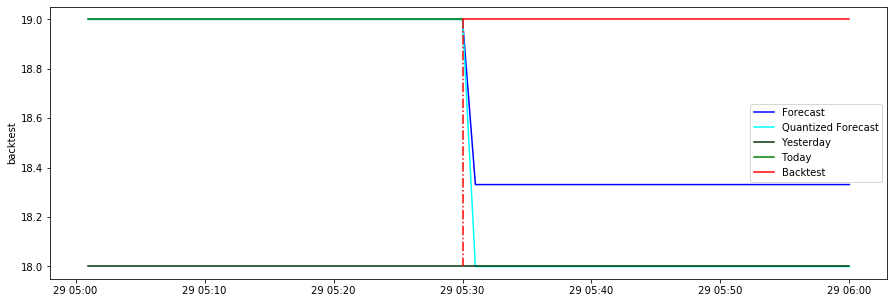

19 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.059000207437033, 'importance_type': 'gain', 'learning_rate': 0.14171536217201572, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1780, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 12.805320988379743, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.5038700103759766


[0]	validation_0-rmse:17.4461
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.7129
[2]	validation_0-rmse:14.1504
[3]	validation_0-rmse:12.7459
[4]	validation_0-rmse:11.4822
[5]	validation_0-rmse:10.3416
[6]	validation_0-rmse:9.30976
[7]	validation_0-rmse:8.38489
[8]	validation_0-rmse:7.55166
[9]	validation_0-rmse:6.79887
[10]	validation_0-rmse:6.12551
[11]	validation_0-rmse:5.5194

[234]	validation_0-rmse:0.057265
[235]	validation_0-rmse:0.057265
[236]	validation_0-rmse:0.057271
[237]	validation_0-rmse:0.05726
[238]	validation_0-rmse:0.057296
[239]	validation_0-rmse:0.057301
[240]	validation_0-rmse:0.057305
[241]	validation_0-rmse:0.057301
[242]	validation_0-rmse:0.0573
[243]	validation_0-rmse:0.0573
[244]	validation_0-rmse:0.0573
[245]	validation_0-rmse:0.057265
[246]	validation_0-rmse:0.057265
[247]	validation_0-rmse:0.057267
[248]	validation_0-rmse:0.057269
[249]	validation_0-rmse:0.057254
[250]	validation_0-rmse:0.057244
[251]	validation_0-rmse:0.057244
[252]	validation_0-rmse:0.05721
[253]	validation_0-rmse:0.057226
[254]	validation_0-rmse:0.057226
[255]	validation_0-rmse:0.057226
[256]	validation_0-rmse:0.057225
[257]	validation_0-rmse:0.057224
[258]	validation_0-rmse:0.057234
[259]	validation_0-rmse:0.057234
[260]	validation_0-rmse:0.057241
[261]	validation_0-rmse:0.057259
[262]	validation_0-rmse:0.057259
[263]	validation_0-rmse:0.057249
[264]	validation_0

[483]	validation_0-rmse:0.057097
[484]	validation_0-rmse:0.057097
[485]	validation_0-rmse:0.057097
[486]	validation_0-rmse:0.057097
[487]	validation_0-rmse:0.057097
[488]	validation_0-rmse:0.057106
[489]	validation_0-rmse:0.057106
[490]	validation_0-rmse:0.057106
[491]	validation_0-rmse:0.057106
[492]	validation_0-rmse:0.057106
[493]	validation_0-rmse:0.057106
[494]	validation_0-rmse:0.057096
[495]	validation_0-rmse:0.057096
[496]	validation_0-rmse:0.057096
[497]	validation_0-rmse:0.057096
[498]	validation_0-rmse:0.057093
[499]	validation_0-rmse:0.057093
[500]	validation_0-rmse:0.057092
[501]	validation_0-rmse:0.057096
[502]	validation_0-rmse:0.057096
[503]	validation_0-rmse:0.057096
[504]	validation_0-rmse:0.057096
[505]	validation_0-rmse:0.057096
[506]	validation_0-rmse:0.057096
[507]	validation_0-rmse:0.057096
[508]	validation_0-rmse:0.057105
[509]	validation_0-rmse:0.057105
[510]	validation_0-rmse:0.057105
[511]	validation_0-rmse:0.057085
[512]	validation_0-rmse:0.057085
[513]	vali

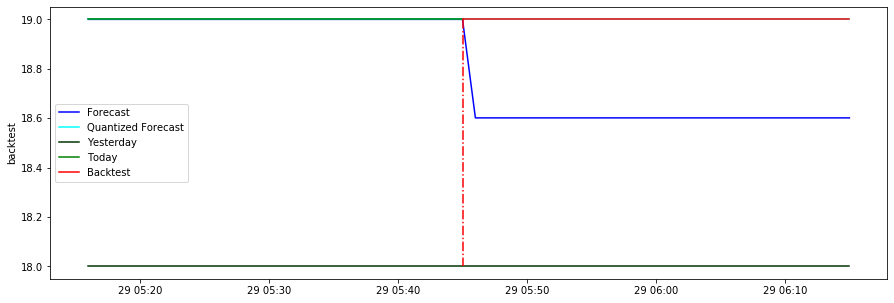

20 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 6.821549736930843, 'importance_type': 'gain', 'learning_rate': 0.22410462728065458, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 730, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.5752873680520825, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.45783424377441406


[0]	validation_0-rmse:17.3988
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6695
[2]	validation_0-rmse:14.1107
[3]	validation_0-rmse:12.7089
[4]	validation_0-rmse:11.4481
[5]	validation_0-rmse:10.311
[6]	validation_0-rmse:9.28564
[7]	validation_0-rmse:8.3599
[8]	validation_0-rmse:7.52924
[9]	validation_0-rmse:6.77833
[10]	validation_0-rmse:6.10732
[11]	validation_0-rmse:5.50273


[234]	validation_0-rmse:0.014368
[235]	validation_0-rmse:0.014367
[236]	validation_0-rmse:0.014368
[237]	validation_0-rmse:0.014368
[238]	validation_0-rmse:0.014368
[239]	validation_0-rmse:0.014363
[240]	validation_0-rmse:0.014366
[241]	validation_0-rmse:0.014366
[242]	validation_0-rmse:0.014375
[243]	validation_0-rmse:0.014375
[244]	validation_0-rmse:0.014383
[245]	validation_0-rmse:0.014383
[246]	validation_0-rmse:0.014383
[247]	validation_0-rmse:0.014384
[248]	validation_0-rmse:0.014375
[249]	validation_0-rmse:0.014375
[250]	validation_0-rmse:0.01437
[251]	validation_0-rmse:0.014368
[252]	validation_0-rmse:0.014372
[253]	validation_0-rmse:0.014375
[254]	validation_0-rmse:0.014374
[255]	validation_0-rmse:0.014406
[256]	validation_0-rmse:0.014405
[257]	validation_0-rmse:0.014405
[258]	validation_0-rmse:0.014399
[259]	validation_0-rmse:0.014399
[260]	validation_0-rmse:0.014402
[261]	validation_0-rmse:0.014402
[262]	validation_0-rmse:0.014403
[263]	validation_0-rmse:0.014403
[264]	valid

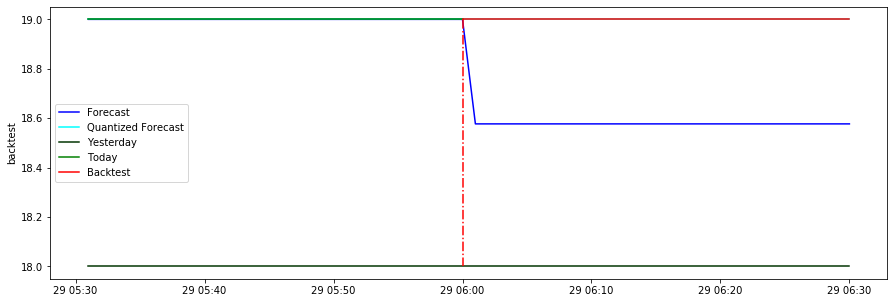

21 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.468712081951292, 'importance_type': 'gain', 'learning_rate': 0.2665202730985379, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1530, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 8.05116470023967, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.452880859375


[0]	validation_0-rmse:17.3713
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6433
[2]	validation_0-rmse:14.0913
[3]	validation_0-rmse:12.6949
[4]	validation_0-rmse:11.4392
[5]	validation_0-rmse:10.3071
[6]	validation_0-rmse:9.2873
[7]	validation_0-rmse:8.37043
[8]	validation_0-rmse:7.54276
[9]	validation_0-rmse:6.79908
[10]	validation_0-rmse:6.12983
[11]	validation_0-rmse:5.52916
[12]	v

[235]	validation_0-rmse:0.08661
[236]	validation_0-rmse:0.086612
[237]	validation_0-rmse:0.086612
[238]	validation_0-rmse:0.086611
[239]	validation_0-rmse:0.086612
[240]	validation_0-rmse:0.086615
[241]	validation_0-rmse:0.086615
[242]	validation_0-rmse:0.086608
[243]	validation_0-rmse:0.086569
[244]	validation_0-rmse:0.086569
[245]	validation_0-rmse:0.086568
[246]	validation_0-rmse:0.086567
[247]	validation_0-rmse:0.086567
[248]	validation_0-rmse:0.086554
[249]	validation_0-rmse:0.086554
[250]	validation_0-rmse:0.086553
[251]	validation_0-rmse:0.086509
[252]	validation_0-rmse:0.086512
[253]	validation_0-rmse:0.086471
[254]	validation_0-rmse:0.086498
[255]	validation_0-rmse:0.086514
[256]	validation_0-rmse:0.086513
[257]	validation_0-rmse:0.086513
[258]	validation_0-rmse:0.086513
[259]	validation_0-rmse:0.086512
[260]	validation_0-rmse:0.086512
[261]	validation_0-rmse:0.086512
[262]	validation_0-rmse:0.086512
[263]	validation_0-rmse:0.086512
Stopping. Best iteration:
[163]	validation_0

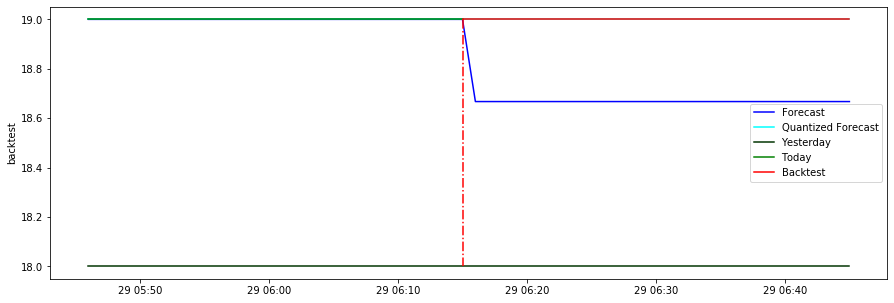

22 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.5120068115120175, 'importance_type': 'gain', 'learning_rate': 0.17609637584013124, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 310, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 9.880853764702916, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.4177207946777344


[0]	validation_0-rmse:17.1704
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.469
[2]	validation_0-rmse:13.9355
[3]	validation_0-rmse:12.5551
[4]	validation_0-rmse:11.312
[5]	validation_0-rmse:10.1938
[6]	validation_0-rmse:9.18556
[7]	validation_0-rmse:8.27521
[8]	validation_0-rmse:7.45746
[9]	validation_0-rmse:6.71945
[10]	validation_0-rmse:6.05658
[11]	validation_0-rmse:5.45988
[

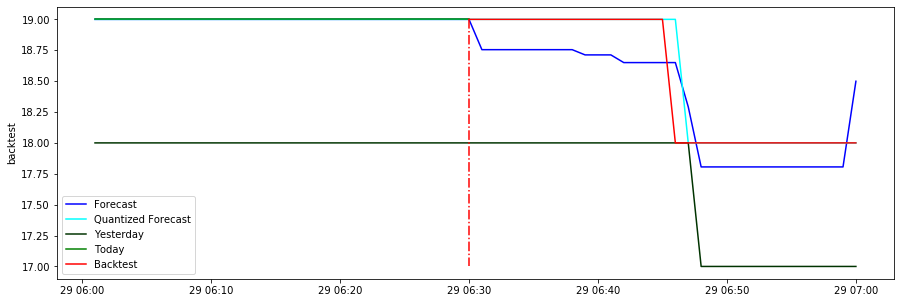

23 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.372231938104459, 'importance_type': 'gain', 'learning_rate': 0.20584694720976063, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 650, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.6496388813836984, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.38134183457262216


[0]	validation_0-rmse:16.7938
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.1123
[2]	validation_0-rmse:13.6044
[3]	validation_0-rmse:12.2474
[4]	validation_0-rmse:11.0213
[5]	validation_0-rmse:9.92249
[6]	validation_0-rmse:8.93242
[7]	validation_0-rmse:8.04107
[8]	validation_0-rmse:7.23784
[9]	validation_0-rmse:6.52187
[10]	validation_0-rmse:5.87677
[11]	validation_0-rmse:5.3008

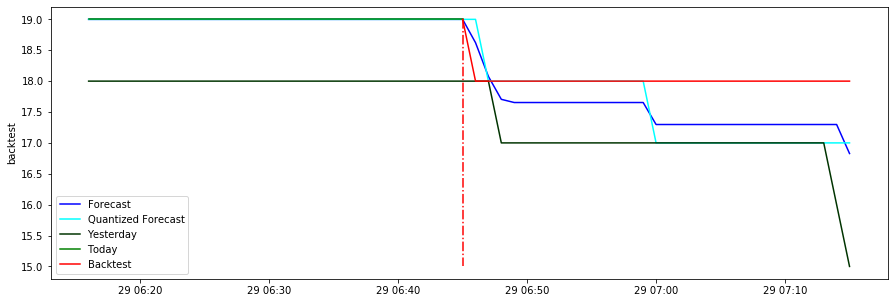

24 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.590976873736179, 'importance_type': 'gain', 'learning_rate': 0.05213358317672752, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 560, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.6203903075084334, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.24219608178619656


[0]	validation_0-rmse:16.5103
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.8736
[2]	validation_0-rmse:13.3959
[3]	validation_0-rmse:12.07
[4]	validation_0-rmse:10.8714
[5]	validation_0-rmse:9.78716
[6]	validation_0-rmse:8.81917
[7]	validation_0-rmse:7.94267
[8]	validation_0-rmse:7.16116
[9]	validation_0-rmse:6.45621
[10]	validation_0-rmse:5.82779
[11]	validation_0-rmse:5.25915


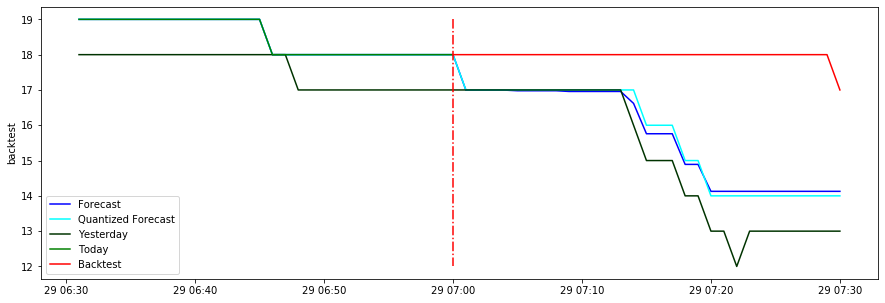

25 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.7998783972855716, 'importance_type': 'gain', 'learning_rate': 0.25899866392531207, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1590, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 8.242609021242519, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.4626160151167698


[0]	validation_0-rmse:16.0656
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.482
[2]	validation_0-rmse:13.0532
[3]	validation_0-rmse:11.7694
[4]	validation_0-rmse:10.6122
[5]	validation_0-rmse:9.57273
[6]	validation_0-rmse:8.63854
[7]	validation_0-rmse:7.79381
[8]	validation_0-rmse:7.03485
[9]	validation_0-rmse:6.35758
[10]	validation_0-rmse:5.73529
[11]	validation_0-rmse:5.18483

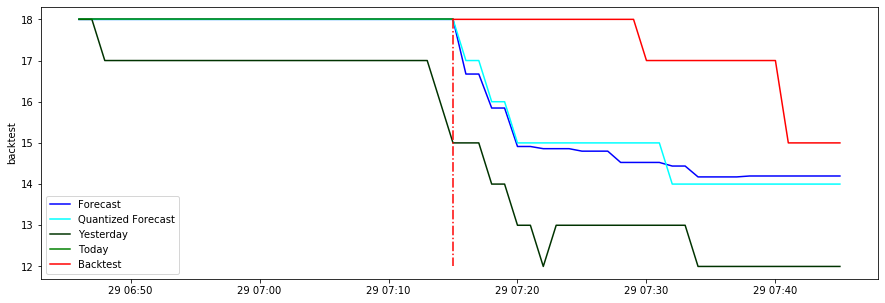

26 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.916909727549228, 'importance_type': 'gain', 'learning_rate': 0.21976487337717818, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1210, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.9354787269703417, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.5380845332256854


[0]	validation_0-rmse:15.4992
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:13.983
[2]	validation_0-rmse:12.6127
[3]	validation_0-rmse:11.3925
[4]	validation_0-rmse:10.2853
[5]	validation_0-rmse:9.28226
[6]	validation_0-rmse:8.38645
[7]	validation_0-rmse:7.58252
[8]	validation_0-rmse:6.85881
[9]	validation_0-rmse:6.2008
[10]	validation_0-rmse:5.59746
[11]	validation_0-rmse:5.07249


[234]	validation_0-rmse:0.286467
[235]	validation_0-rmse:0.286377
[236]	validation_0-rmse:0.286356
[237]	validation_0-rmse:0.286358
[238]	validation_0-rmse:0.286341
[239]	validation_0-rmse:0.286341
[240]	validation_0-rmse:0.286337
[241]	validation_0-rmse:0.286345
[242]	validation_0-rmse:0.286333
[243]	validation_0-rmse:0.286213
[244]	validation_0-rmse:0.286221
[245]	validation_0-rmse:0.286171
[246]	validation_0-rmse:0.286117
[247]	validation_0-rmse:0.286131
[248]	validation_0-rmse:0.286116
[249]	validation_0-rmse:0.286151
[250]	validation_0-rmse:0.286048
[251]	validation_0-rmse:0.286078
[252]	validation_0-rmse:0.286045
[253]	validation_0-rmse:0.286039
[254]	validation_0-rmse:0.286106
[255]	validation_0-rmse:0.286077
[256]	validation_0-rmse:0.28599
[257]	validation_0-rmse:0.28599
[258]	validation_0-rmse:0.286036
[259]	validation_0-rmse:0.286041
[260]	validation_0-rmse:0.286036
[261]	validation_0-rmse:0.286014
[262]	validation_0-rmse:0.286003
[263]	validation_0-rmse:0.286001
[264]	valida

[483]	validation_0-rmse:0.285374
[484]	validation_0-rmse:0.28537
[485]	validation_0-rmse:0.285372
[486]	validation_0-rmse:0.285372
[487]	validation_0-rmse:0.28537
[488]	validation_0-rmse:0.285371
[489]	validation_0-rmse:0.285378
[490]	validation_0-rmse:0.285375
[491]	validation_0-rmse:0.285374
[492]	validation_0-rmse:0.285375
[493]	validation_0-rmse:0.285374
[494]	validation_0-rmse:0.285373
[495]	validation_0-rmse:0.285369
[496]	validation_0-rmse:0.285369
[497]	validation_0-rmse:0.285369
[498]	validation_0-rmse:0.28537
[499]	validation_0-rmse:0.28537
[500]	validation_0-rmse:0.285369
[501]	validation_0-rmse:0.28537
[502]	validation_0-rmse:0.285368
[503]	validation_0-rmse:0.285367
[504]	validation_0-rmse:0.285366
[505]	validation_0-rmse:0.285367
[506]	validation_0-rmse:0.285366
[507]	validation_0-rmse:0.285364
[508]	validation_0-rmse:0.285366
[509]	validation_0-rmse:0.28537
[510]	validation_0-rmse:0.285374
[511]	validation_0-rmse:0.285372
[512]	validation_0-rmse:0.285372
[513]	validation

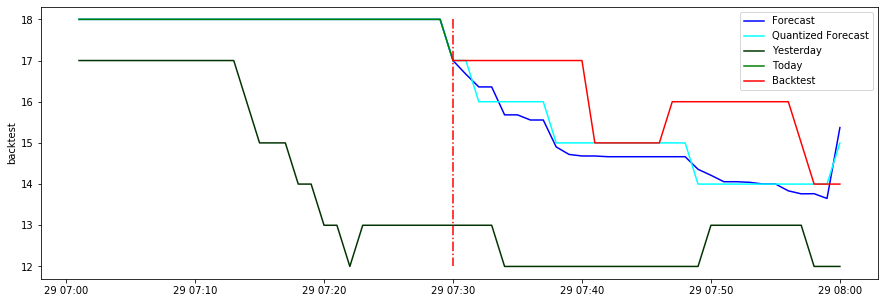

27 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 7.134472445433888, 'importance_type': 'gain', 'learning_rate': 0.17187568696700867, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 580, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 5.636969377429601, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.6509350464276529


[0]	validation_0-rmse:14.5809
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:13.1689
[2]	validation_0-rmse:11.8922
[3]	validation_0-rmse:10.7392
[4]	validation_0-rmse:9.69438
[5]	validation_0-rmse:8.75735
[6]	validation_0-rmse:7.9169
[7]	validation_0-rmse:7.15581
[8]	validation_0-rmse:6.47186
[9]	validation_0-rmse:5.85129
[10]	validation_0-rmse:5.29856
[11]	validation_0-rmse:4.79878
[

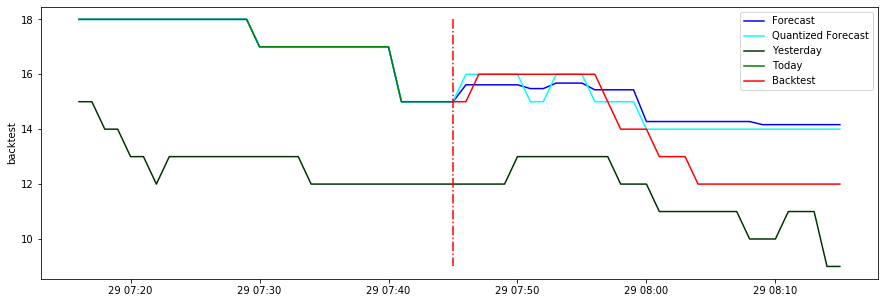

28 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.337773697762194, 'importance_type': 'gain', 'learning_rate': 0.058502929115550495, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1280, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.4654914788262454, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.0059800063697772


[0]	validation_0-rmse:13.7754
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:12.4429
[2]	validation_0-rmse:11.2419
[3]	validation_0-rmse:10.1531
[4]	validation_0-rmse:9.17031
[5]	validation_0-rmse:8.30445
[6]	validation_0-rmse:7.52748
[7]	validation_0-rmse:6.814
[8]	validation_0-rmse:6.1754
[9]	validation_0-rmse:5.59551
[10]	validation_0-rmse:5.08741
[11]	validation_0-rmse:4.61618


[234]	validation_0-rmse:0.341318
[235]	validation_0-rmse:0.341461
[236]	validation_0-rmse:0.34144
[237]	validation_0-rmse:0.341409
[238]	validation_0-rmse:0.341383
[239]	validation_0-rmse:0.341366
[240]	validation_0-rmse:0.341382
[241]	validation_0-rmse:0.341357
[242]	validation_0-rmse:0.341412
[243]	validation_0-rmse:0.341501
[244]	validation_0-rmse:0.341474
[245]	validation_0-rmse:0.341402
[246]	validation_0-rmse:0.341348
[247]	validation_0-rmse:0.341349
[248]	validation_0-rmse:0.341347
[249]	validation_0-rmse:0.341332
[250]	validation_0-rmse:0.341349
[251]	validation_0-rmse:0.341222
[252]	validation_0-rmse:0.341231
[253]	validation_0-rmse:0.341341
[254]	validation_0-rmse:0.341261
[255]	validation_0-rmse:0.341232
[256]	validation_0-rmse:0.341315
[257]	validation_0-rmse:0.341294
[258]	validation_0-rmse:0.341182
[259]	validation_0-rmse:0.341177
[260]	validation_0-rmse:0.341161
[261]	validation_0-rmse:0.341154
[262]	validation_0-rmse:0.341179
[263]	validation_0-rmse:0.341172
[264]	valid

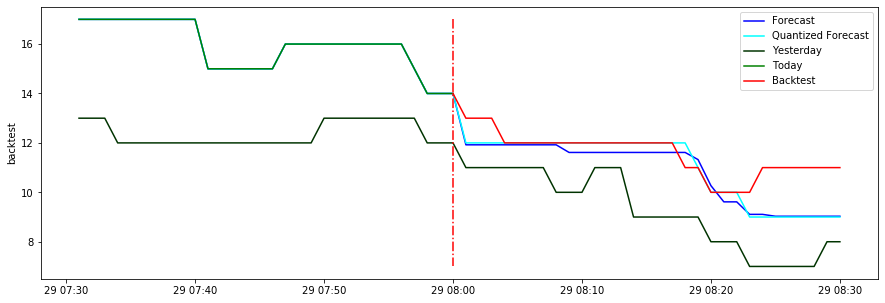

29 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.21955684017312183, 'importance_type': 'gain', 'learning_rate': 0.07620860740386012, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 370, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.1972157977668918, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.312862578291052


[0]	validation_0-rmse:12.7244
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.517
[2]	validation_0-rmse:10.4488
[3]	validation_0-rmse:9.46516
[4]	validation_0-rmse:8.5778
[5]	validation_0-rmse:7.78781
[6]	validation_0-rmse:7.06434
[7]	validation_0-rmse:6.38807
[8]	validation_0-rmse:5.79637
[9]	validation_0-rmse:5.26241
[10]	validation_0-rmse:4.76334
[11]	validation_0-rmse:4.31755


[234]	validation_0-rmse:0.394499
[235]	validation_0-rmse:0.394452
[236]	validation_0-rmse:0.394519
[237]	validation_0-rmse:0.39451
[238]	validation_0-rmse:0.394587
[239]	validation_0-rmse:0.394555
[240]	validation_0-rmse:0.394537
[241]	validation_0-rmse:0.394528
[242]	validation_0-rmse:0.394573
[243]	validation_0-rmse:0.394518
[244]	validation_0-rmse:0.394484
[245]	validation_0-rmse:0.394502
[246]	validation_0-rmse:0.394435
[247]	validation_0-rmse:0.394467
[248]	validation_0-rmse:0.394481
[249]	validation_0-rmse:0.394425
[250]	validation_0-rmse:0.39442
[251]	validation_0-rmse:0.39426
[252]	validation_0-rmse:0.394269
[253]	validation_0-rmse:0.394291
[254]	validation_0-rmse:0.394255
[255]	validation_0-rmse:0.394373
[256]	validation_0-rmse:0.3945
[257]	validation_0-rmse:0.394464
[258]	validation_0-rmse:0.39443
[259]	validation_0-rmse:0.394451
[260]	validation_0-rmse:0.394427
[261]	validation_0-rmse:0.394431
[262]	validation_0-rmse:0.394438
[263]	validation_0-rmse:0.394453
[264]	validation

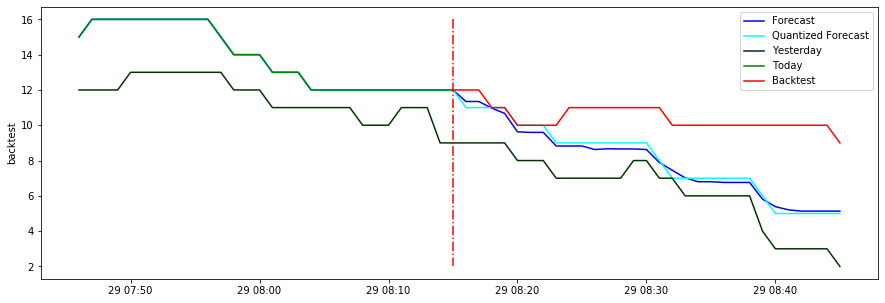

30 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 9.424674797122156, 'importance_type': 'gain', 'learning_rate': 0.08484883815411484, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1390, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.994233736838661, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.4805455932780127


[0]	validation_0-rmse:11.6453
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.543
[2]	validation_0-rmse:9.56887
[3]	validation_0-rmse:8.68648
[4]	validation_0-rmse:7.8768
[5]	validation_0-rmse:7.16167
[6]	validation_0-rmse:6.49314
[7]	validation_0-rmse:5.88871
[8]	validation_0-rmse:5.36922
[9]	validation_0-rmse:4.88576
[10]	validation_0-rmse:4.42986
[11]	validation_0-rmse:4.05471
[

[234]	validation_0-rmse:0.467413
[235]	validation_0-rmse:0.467334
[236]	validation_0-rmse:0.467351
[237]	validation_0-rmse:0.467374
[238]	validation_0-rmse:0.467237
[239]	validation_0-rmse:0.467243
[240]	validation_0-rmse:0.467284
[241]	validation_0-rmse:0.4673
[242]	validation_0-rmse:0.467327
[243]	validation_0-rmse:0.466951
[244]	validation_0-rmse:0.466957
[245]	validation_0-rmse:0.466954
[246]	validation_0-rmse:0.466955
[247]	validation_0-rmse:0.466941
[248]	validation_0-rmse:0.467015
[249]	validation_0-rmse:0.467127
[250]	validation_0-rmse:0.467161
[251]	validation_0-rmse:0.466986
[252]	validation_0-rmse:0.466964
[253]	validation_0-rmse:0.466929
[254]	validation_0-rmse:0.466776
[255]	validation_0-rmse:0.466886
[256]	validation_0-rmse:0.466764
[257]	validation_0-rmse:0.466911
[258]	validation_0-rmse:0.466722
[259]	validation_0-rmse:0.46675
[260]	validation_0-rmse:0.466731
[261]	validation_0-rmse:0.466722
[262]	validation_0-rmse:0.466803
[263]	validation_0-rmse:0.466828
[264]	validat

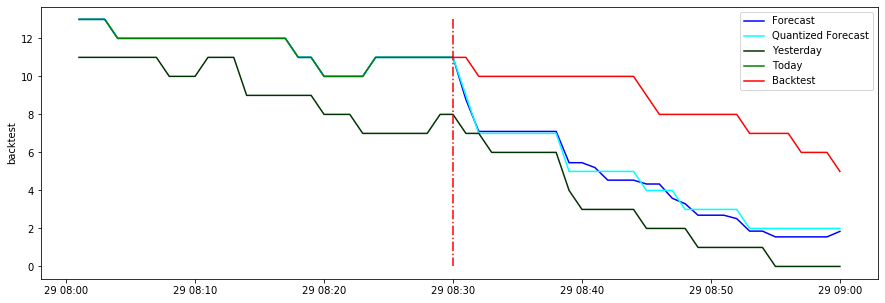

31 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 7.862396409060325, 'importance_type': 'gain', 'learning_rate': 0.07603670643383892, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1620, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.4970590042253824, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 4.461412685999939


[0]	validation_0-rmse:10.3701
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:9.42389
[2]	validation_0-rmse:8.57414
[3]	validation_0-rmse:7.81856
[4]	validation_0-rmse:7.1307
[5]	validation_0-rmse:6.47808
[6]	validation_0-rmse:5.89371
[7]	validation_0-rmse:5.36376
[8]	validation_0-rmse:4.94122
[9]	validation_0-rmse:4.51262
[10]	validation_0-rmse:4.11875
[11]	validation_0-rmse:3.8046
[

[235]	validation_0-rmse:0.567365
[236]	validation_0-rmse:0.567363
[237]	validation_0-rmse:0.567354
[238]	validation_0-rmse:0.567313
[239]	validation_0-rmse:0.567285
[240]	validation_0-rmse:0.567274
[241]	validation_0-rmse:0.567278
[242]	validation_0-rmse:0.567402
[243]	validation_0-rmse:0.567351
[244]	validation_0-rmse:0.567337
[245]	validation_0-rmse:0.567478
[246]	validation_0-rmse:0.567284
[247]	validation_0-rmse:0.567318
[248]	validation_0-rmse:0.567253
[249]	validation_0-rmse:0.567321
[250]	validation_0-rmse:0.567128
[251]	validation_0-rmse:0.56708
[252]	validation_0-rmse:0.567047
[253]	validation_0-rmse:0.566895
[254]	validation_0-rmse:0.566705
[255]	validation_0-rmse:0.566525
[256]	validation_0-rmse:0.566374
[257]	validation_0-rmse:0.566513
[258]	validation_0-rmse:0.566515
[259]	validation_0-rmse:0.566509
[260]	validation_0-rmse:0.566511
[261]	validation_0-rmse:0.566479
[262]	validation_0-rmse:0.566548
[263]	validation_0-rmse:0.566529
[264]	validation_0-rmse:0.566406
[265]	valid

[485]	validation_0-rmse:0.564139
[486]	validation_0-rmse:0.564137
[487]	validation_0-rmse:0.564135
[488]	validation_0-rmse:0.564133
[489]	validation_0-rmse:0.564167
[490]	validation_0-rmse:0.564137
[491]	validation_0-rmse:0.564134
[492]	validation_0-rmse:0.564134
[493]	validation_0-rmse:0.564107
[494]	validation_0-rmse:0.564107
[495]	validation_0-rmse:0.564112
[496]	validation_0-rmse:0.564109
[497]	validation_0-rmse:0.564107
[498]	validation_0-rmse:0.564112
[499]	validation_0-rmse:0.564113
[500]	validation_0-rmse:0.56411
[501]	validation_0-rmse:0.564099
[502]	validation_0-rmse:0.564084
[503]	validation_0-rmse:0.564077
[504]	validation_0-rmse:0.564078
[505]	validation_0-rmse:0.564073
[506]	validation_0-rmse:0.564072
[507]	validation_0-rmse:0.564073
[508]	validation_0-rmse:0.564065
[509]	validation_0-rmse:0.564062
[510]	validation_0-rmse:0.564055
[511]	validation_0-rmse:0.564059
[512]	validation_0-rmse:0.564049
[513]	validation_0-rmse:0.564057
[514]	validation_0-rmse:0.564048
[515]	valid

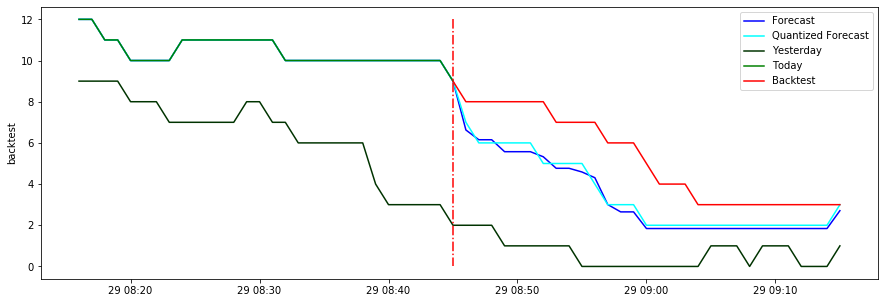

32 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.4966935828563575, 'importance_type': 'gain', 'learning_rate': 0.25151230495782523, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 770, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.8193217168181257, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.20774261165198


[0]	validation_0-rmse:8.53478
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.73754
[2]	validation_0-rmse:7.02996
[3]	validation_0-rmse:6.37971
[4]	validation_0-rmse:5.79928
[5]	validation_0-rmse:5.28628
[6]	validation_0-rmse:4.81562
[7]	validation_0-rmse:4.39605
[8]	validation_0-rmse:4.04977
[9]	validation_0-rmse:3.70016
[10]	validation_0-rmse:3.3795
[11]	validation_0-rmse:3.13143
[

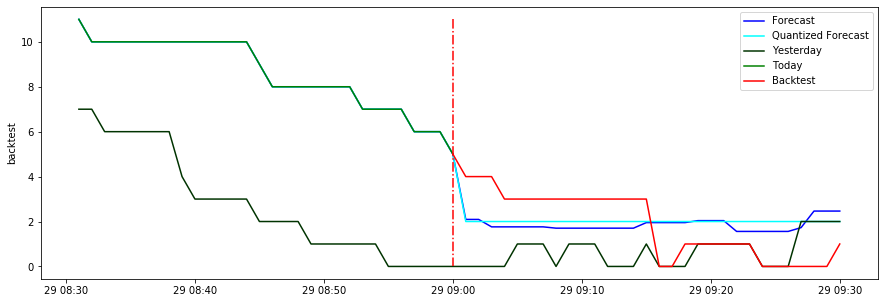

33 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.3622270459032939, 'importance_type': 'gain', 'learning_rate': 0.11397513274302028, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 760, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 22.106673627655958, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.6416439506098301


[0]	validation_0-rmse:8.31537
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.59865
[2]	validation_0-rmse:6.93314
[3]	validation_0-rmse:6.33588
[4]	validation_0-rmse:5.80985
[5]	validation_0-rmse:5.32771
[6]	validation_0-rmse:4.90502
[7]	validation_0-rmse:4.50103
[8]	validation_0-rmse:4.23566
[9]	validation_0-rmse:3.91479
[10]	validation_0-rmse:3.60972
[11]	validation_0-rmse:3.4088

[235]	validation_0-rmse:0.609439
[236]	validation_0-rmse:0.609429
[237]	validation_0-rmse:0.60938
[238]	validation_0-rmse:0.609353
[239]	validation_0-rmse:0.609324
[240]	validation_0-rmse:0.609341
[241]	validation_0-rmse:0.609345
[242]	validation_0-rmse:0.609519
[243]	validation_0-rmse:0.60933
[244]	validation_0-rmse:0.60934
[245]	validation_0-rmse:0.609269
[246]	validation_0-rmse:0.609283
[247]	validation_0-rmse:0.609289
[248]	validation_0-rmse:0.609138
[249]	validation_0-rmse:0.609023
[250]	validation_0-rmse:0.609108
[251]	validation_0-rmse:0.608887
[252]	validation_0-rmse:0.60895
[253]	validation_0-rmse:0.609044
[254]	validation_0-rmse:0.609064
[255]	validation_0-rmse:0.609155
[256]	validation_0-rmse:0.609268
[257]	validation_0-rmse:0.609295
[258]	validation_0-rmse:0.60941
[259]	validation_0-rmse:0.609428
[260]	validation_0-rmse:0.609397
[261]	validation_0-rmse:0.60938
[262]	validation_0-rmse:0.609547
[263]	validation_0-rmse:0.609511
[264]	validation_0-rmse:0.609563
[265]	validation

[484]	validation_0-rmse:0.607828
Stopping. Best iteration:
[384]	validation_0-rmse:0.607656



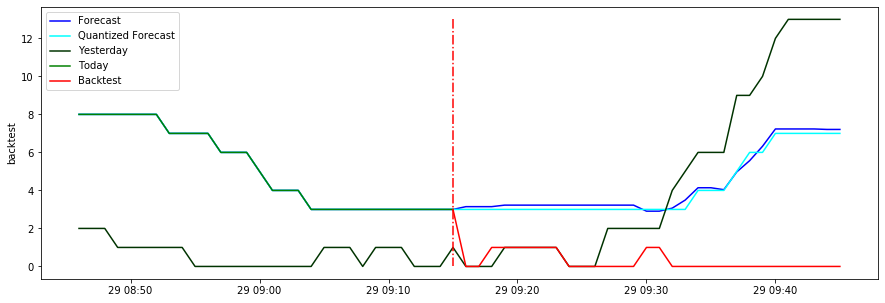

34 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 4.594071224733854, 'importance_type': 'gain', 'learning_rate': 0.26769634478361826, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 780, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.1948114175216595, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 5.946708936009957


[0]	validation_0-rmse:7.63847
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.94249
[2]	validation_0-rmse:6.31728
[3]	validation_0-rmse:5.71711
[4]	validation_0-rmse:5.19181
[5]	validation_0-rmse:4.72964
[6]	validation_0-rmse:4.34161
[7]	validation_0-rmse:3.96544
[8]	validation_0-rmse:3.70656
[9]	validation_0-rmse:3.42694
[10]	validation_0-rmse:3.12934
[11]	validation_0-rmse:2.94157


[234]	validation_0-rmse:0.654804
[235]	validation_0-rmse:0.654968
[236]	validation_0-rmse:0.655042
[237]	validation_0-rmse:0.65507
[238]	validation_0-rmse:0.655239
[239]	validation_0-rmse:0.655258
[240]	validation_0-rmse:0.655231
[241]	validation_0-rmse:0.655254
[242]	validation_0-rmse:0.655248
[243]	validation_0-rmse:0.655119
[244]	validation_0-rmse:0.655115
[245]	validation_0-rmse:0.655055
[246]	validation_0-rmse:0.655151
[247]	validation_0-rmse:0.655154
[248]	validation_0-rmse:0.655209
[249]	validation_0-rmse:0.655246
[250]	validation_0-rmse:0.655285
[251]	validation_0-rmse:0.655179
[252]	validation_0-rmse:0.655216
[253]	validation_0-rmse:0.655174
[254]	validation_0-rmse:0.655219
[255]	validation_0-rmse:0.655147
[256]	validation_0-rmse:0.655201
[257]	validation_0-rmse:0.655199
[258]	validation_0-rmse:0.655175
[259]	validation_0-rmse:0.655165
[260]	validation_0-rmse:0.655175
[261]	validation_0-rmse:0.655171
[262]	validation_0-rmse:0.655207
[263]	validation_0-rmse:0.655194
[264]	valid

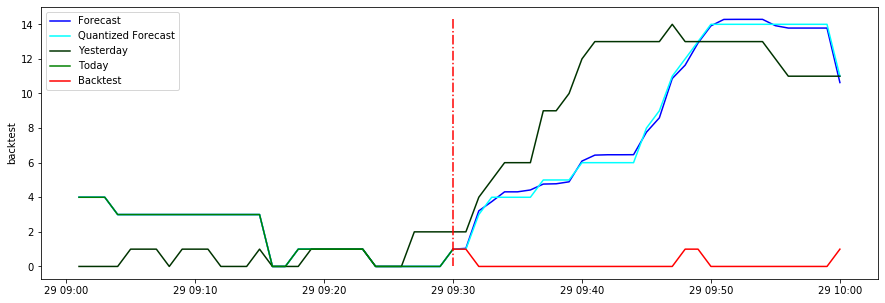

35 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 8.442901135558929, 'importance_type': 'gain', 'learning_rate': 0.1182560687303345, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1990, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.412218864645119, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 9.54048053778163


[0]	validation_0-rmse:8.13476
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.38661
[2]	validation_0-rmse:6.68817
[3]	validation_0-rmse:6.07228
[4]	validation_0-rmse:5.50687
[5]	validation_0-rmse:5.00997
[6]	validation_0-rmse:4.58417
[7]	validation_0-rmse:4.16216
[8]	validation_0-rmse:3.88515
[9]	validation_0-rmse:3.57632
[10]	validation_0-rmse:3.25074
[11]	validation_0-rmse:3.04809
[1

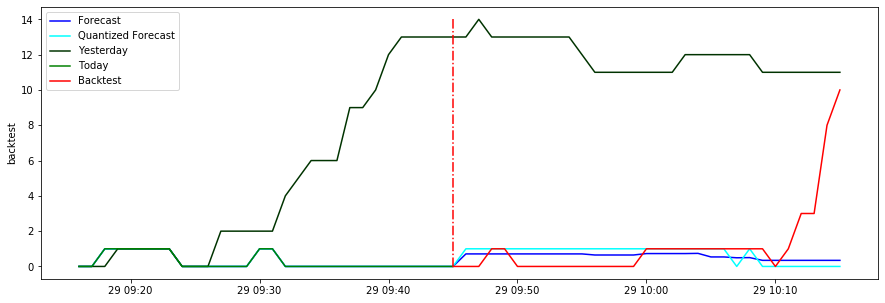

36 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.5530845168576786, 'importance_type': 'gain', 'learning_rate': 0.06971852912580546, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 840, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.519510993820334, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.3312875876587187


[0]	validation_0-rmse:8.21455
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.4083
[2]	validation_0-rmse:6.67855
[3]	validation_0-rmse:6.01943
[4]	validation_0-rmse:5.42553
[5]	validation_0-rmse:4.89193
[6]	validation_0-rmse:4.41759
[7]	validation_0-rmse:3.98746
[8]	validation_0-rmse:3.69743
[9]	validation_0-rmse:3.34966
[10]	validation_0-rmse:3.02377
[11]	validation_0-rmse:2.81415


[234]	validation_0-rmse:0.342378
[235]	validation_0-rmse:0.342299
[236]	validation_0-rmse:0.342287
[237]	validation_0-rmse:0.342302
[238]	validation_0-rmse:0.342308
[239]	validation_0-rmse:0.342337
[240]	validation_0-rmse:0.342306
[241]	validation_0-rmse:0.342299
[242]	validation_0-rmse:0.342262
[243]	validation_0-rmse:0.342229
[244]	validation_0-rmse:0.342219
[245]	validation_0-rmse:0.342221
[246]	validation_0-rmse:0.342219
[247]	validation_0-rmse:0.342202
[248]	validation_0-rmse:0.342122
[249]	validation_0-rmse:0.34215
[250]	validation_0-rmse:0.341932
[251]	validation_0-rmse:0.341952
[252]	validation_0-rmse:0.341907
[253]	validation_0-rmse:0.341986
[254]	validation_0-rmse:0.34195
[255]	validation_0-rmse:0.341961
[256]	validation_0-rmse:0.341886
[257]	validation_0-rmse:0.34188
[258]	validation_0-rmse:0.341685
[259]	validation_0-rmse:0.3417
[260]	validation_0-rmse:0.341709
[261]	validation_0-rmse:0.341702
[262]	validation_0-rmse:0.341667
[263]	validation_0-rmse:0.341674
[264]	validatio

[484]	validation_0-rmse:0.341044
[485]	validation_0-rmse:0.341042
[486]	validation_0-rmse:0.34104
[487]	validation_0-rmse:0.341037
[488]	validation_0-rmse:0.341038
[489]	validation_0-rmse:0.341019
[490]	validation_0-rmse:0.341019
[491]	validation_0-rmse:0.341019
[492]	validation_0-rmse:0.341023
[493]	validation_0-rmse:0.341033
[494]	validation_0-rmse:0.341031
[495]	validation_0-rmse:0.34102
[496]	validation_0-rmse:0.341019
[497]	validation_0-rmse:0.34102
[498]	validation_0-rmse:0.341019
[499]	validation_0-rmse:0.341019
[500]	validation_0-rmse:0.341019
[501]	validation_0-rmse:0.341014
[502]	validation_0-rmse:0.341011
[503]	validation_0-rmse:0.341018
[504]	validation_0-rmse:0.341018
[505]	validation_0-rmse:0.341015
[506]	validation_0-rmse:0.341016
[507]	validation_0-rmse:0.341014
[508]	validation_0-rmse:0.341014
[509]	validation_0-rmse:0.341017
[510]	validation_0-rmse:0.341016
[511]	validation_0-rmse:0.341017
[512]	validation_0-rmse:0.341004
[513]	validation_0-rmse:0.341003
[514]	validat

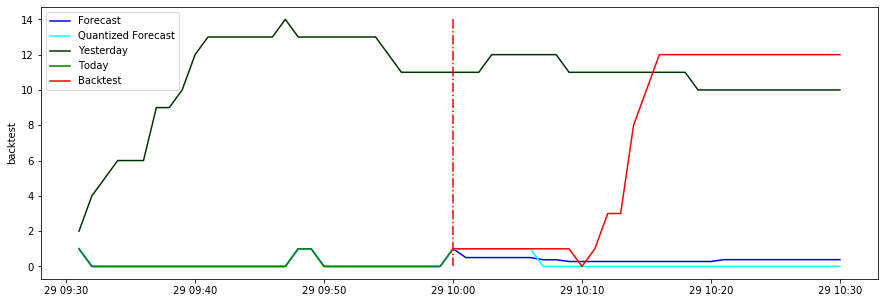

37 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.3056820233351107, 'importance_type': 'gain', 'learning_rate': 0.2705212922729316, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1680, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 7.386419626175435, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 8.532405936302338


[0]	validation_0-rmse:8.21775
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.46063
[2]	validation_0-rmse:6.76871
[3]	validation_0-rmse:6.15571
[4]	validation_0-rmse:5.5909
[5]	validation_0-rmse:5.08528
[6]	validation_0-rmse:4.64102
[7]	validation_0-rmse:4.22389
[8]	validation_0-rmse:3.95151
[9]	validation_0-rmse:3.62109
[10]	validation_0-rmse:3.31024
[11]	validation_0-rmse:3.12596
[

[235]	validation_0-rmse:0.615962
[236]	validation_0-rmse:0.616026
[237]	validation_0-rmse:0.616017
[238]	validation_0-rmse:0.615968
[239]	validation_0-rmse:0.615964
[240]	validation_0-rmse:0.615956
[241]	validation_0-rmse:0.615959
[242]	validation_0-rmse:0.616015
[243]	validation_0-rmse:0.616072
[244]	validation_0-rmse:0.616077
[245]	validation_0-rmse:0.616122
[246]	validation_0-rmse:0.616122
[247]	validation_0-rmse:0.61609
[248]	validation_0-rmse:0.616104
[249]	validation_0-rmse:0.616118
[250]	validation_0-rmse:0.616173
[251]	validation_0-rmse:0.616239
[252]	validation_0-rmse:0.616278
[253]	validation_0-rmse:0.616187
[254]	validation_0-rmse:0.616147
[255]	validation_0-rmse:0.616186
[256]	validation_0-rmse:0.616166
[257]	validation_0-rmse:0.616165
[258]	validation_0-rmse:0.616101
[259]	validation_0-rmse:0.616119
[260]	validation_0-rmse:0.6161
[261]	validation_0-rmse:0.616087
[262]	validation_0-rmse:0.616088
[263]	validation_0-rmse:0.616105
[264]	validation_0-rmse:0.616055
[265]	validat

[485]	validation_0-rmse:0.614996
[486]	validation_0-rmse:0.614998
[487]	validation_0-rmse:0.614997
[488]	validation_0-rmse:0.614999
[489]	validation_0-rmse:0.614996
[490]	validation_0-rmse:0.614987
[491]	validation_0-rmse:0.614983
[492]	validation_0-rmse:0.614984
[493]	validation_0-rmse:0.614984
[494]	validation_0-rmse:0.614981
[495]	validation_0-rmse:0.614976
[496]	validation_0-rmse:0.614976
[497]	validation_0-rmse:0.614976
[498]	validation_0-rmse:0.614976
[499]	validation_0-rmse:0.614976
[500]	validation_0-rmse:0.614972
[501]	validation_0-rmse:0.614967
[502]	validation_0-rmse:0.61496
[503]	validation_0-rmse:0.614952
[504]	validation_0-rmse:0.614952
[505]	validation_0-rmse:0.614951
[506]	validation_0-rmse:0.614952
[507]	validation_0-rmse:0.614945
[508]	validation_0-rmse:0.614946
[509]	validation_0-rmse:0.614945
[510]	validation_0-rmse:0.614946
[511]	validation_0-rmse:0.614946
[512]	validation_0-rmse:0.614952
[513]	validation_0-rmse:0.61495
[514]	validation_0-rmse:0.61495
[515]	validat

[734]	validation_0-rmse:0.614888
[735]	validation_0-rmse:0.614885
[736]	validation_0-rmse:0.614885
[737]	validation_0-rmse:0.614885
[738]	validation_0-rmse:0.614885
[739]	validation_0-rmse:0.614883
[740]	validation_0-rmse:0.614886
[741]	validation_0-rmse:0.614888
[742]	validation_0-rmse:0.614889
[743]	validation_0-rmse:0.614889
[744]	validation_0-rmse:0.614889
[745]	validation_0-rmse:0.614888
[746]	validation_0-rmse:0.614888
[747]	validation_0-rmse:0.614889
[748]	validation_0-rmse:0.614887
[749]	validation_0-rmse:0.614887
[750]	validation_0-rmse:0.614889
[751]	validation_0-rmse:0.614885
[752]	validation_0-rmse:0.614887
[753]	validation_0-rmse:0.614886
[754]	validation_0-rmse:0.614887
[755]	validation_0-rmse:0.614886
[756]	validation_0-rmse:0.614886
[757]	validation_0-rmse:0.614888
[758]	validation_0-rmse:0.614884
[759]	validation_0-rmse:0.614887
[760]	validation_0-rmse:0.614887
[761]	validation_0-rmse:0.614887
[762]	validation_0-rmse:0.614887
[763]	validation_0-rmse:0.614883
[764]	vali

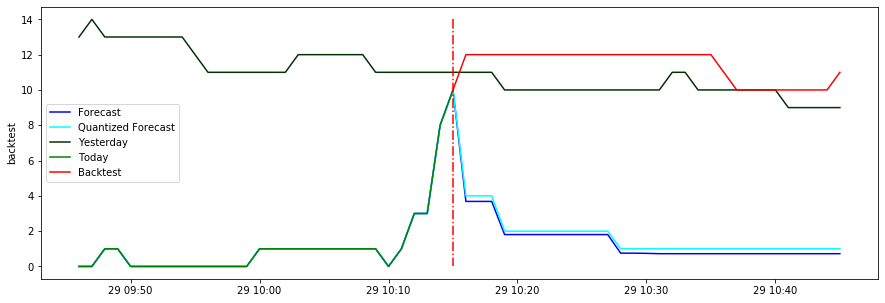

38 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.2198677168802075, 'importance_type': 'gain', 'learning_rate': 0.12325676559193396, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 950, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.0785811898420072, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 10.400284487222882


[0]	validation_0-rmse:7.65199
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.92242
[2]	validation_0-rmse:6.26233
[3]	validation_0-rmse:5.6776
[4]	validation_0-rmse:5.15393
[5]	validation_0-rmse:4.66412
[6]	validation_0-rmse:4.25211
[7]	validation_0-rmse:3.87703
[8]	validation_0-rmse:3.62212
[9]	validation_0-rmse:3.32761
[10]	validation_0-rmse:3.03866
[11]	validation_0-rmse:2.86677

[235]	validation_0-rmse:0.680997
[236]	validation_0-rmse:0.680957
[237]	validation_0-rmse:0.680937
[238]	validation_0-rmse:0.680933
[239]	validation_0-rmse:0.680916
[240]	validation_0-rmse:0.680935
[241]	validation_0-rmse:0.68094
[242]	validation_0-rmse:0.680893
[243]	validation_0-rmse:0.680861
[244]	validation_0-rmse:0.680848
[245]	validation_0-rmse:0.680828
[246]	validation_0-rmse:0.680779
[247]	validation_0-rmse:0.680763
[248]	validation_0-rmse:0.680773
[249]	validation_0-rmse:0.680603
[250]	validation_0-rmse:0.68072
[251]	validation_0-rmse:0.680629
[252]	validation_0-rmse:0.680585
[253]	validation_0-rmse:0.680578
[254]	validation_0-rmse:0.680738
[255]	validation_0-rmse:0.680456
[256]	validation_0-rmse:0.680318
[257]	validation_0-rmse:0.680321
[258]	validation_0-rmse:0.68029
[259]	validation_0-rmse:0.68025
[260]	validation_0-rmse:0.680228
[261]	validation_0-rmse:0.680228
[262]	validation_0-rmse:0.680207
[263]	validation_0-rmse:0.680191
[264]	validation_0-rmse:0.680171
[265]	validati

[485]	validation_0-rmse:0.67665
[486]	validation_0-rmse:0.67665
[487]	validation_0-rmse:0.676651
[488]	validation_0-rmse:0.676652
[489]	validation_0-rmse:0.676649
[490]	validation_0-rmse:0.67665
[491]	validation_0-rmse:0.676654
[492]	validation_0-rmse:0.676655
[493]	validation_0-rmse:0.676659
[494]	validation_0-rmse:0.676661
[495]	validation_0-rmse:0.676659
[496]	validation_0-rmse:0.676658
[497]	validation_0-rmse:0.676656
[498]	validation_0-rmse:0.676655
[499]	validation_0-rmse:0.676653
[500]	validation_0-rmse:0.67665
[501]	validation_0-rmse:0.676645
[502]	validation_0-rmse:0.676647
[503]	validation_0-rmse:0.676666
[504]	validation_0-rmse:0.676668
[505]	validation_0-rmse:0.676668
[506]	validation_0-rmse:0.67666
[507]	validation_0-rmse:0.676682
[508]	validation_0-rmse:0.676665
[509]	validation_0-rmse:0.676665
[510]	validation_0-rmse:0.676661
[511]	validation_0-rmse:0.676662
[512]	validation_0-rmse:0.676662
[513]	validation_0-rmse:0.676658
[514]	validation_0-rmse:0.676659
[515]	validatio

[734]	validation_0-rmse:0.676588
[735]	validation_0-rmse:0.676586
[736]	validation_0-rmse:0.676588
[737]	validation_0-rmse:0.676588
[738]	validation_0-rmse:0.676588
[739]	validation_0-rmse:0.676588
[740]	validation_0-rmse:0.676595
[741]	validation_0-rmse:0.676594
[742]	validation_0-rmse:0.676597
[743]	validation_0-rmse:0.676598
[744]	validation_0-rmse:0.676598
[745]	validation_0-rmse:0.676597
[746]	validation_0-rmse:0.676597
[747]	validation_0-rmse:0.676594
[748]	validation_0-rmse:0.676594
[749]	validation_0-rmse:0.676594
[750]	validation_0-rmse:0.676594
[751]	validation_0-rmse:0.676594
[752]	validation_0-rmse:0.676576
[753]	validation_0-rmse:0.676576
[754]	validation_0-rmse:0.676574
[755]	validation_0-rmse:0.676574
[756]	validation_0-rmse:0.676576
[757]	validation_0-rmse:0.676574
[758]	validation_0-rmse:0.676574
[759]	validation_0-rmse:0.676573
[760]	validation_0-rmse:0.676572
[761]	validation_0-rmse:0.67657
[762]	validation_0-rmse:0.676573
[763]	validation_0-rmse:0.676569
[764]	valid

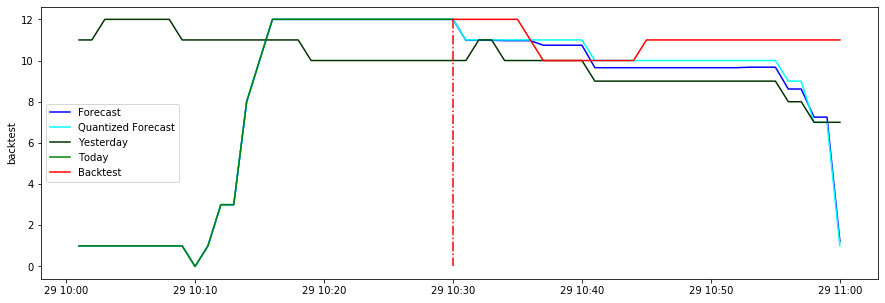

39 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.567615181404769, 'importance_type': 'gain', 'learning_rate': 0.22564363910761873, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 510, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.4299195425411675, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.130823457314527


[0]	validation_0-rmse:7.29374
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.57953
[2]	validation_0-rmse:5.92332
[3]	validation_0-rmse:5.33745
[4]	validation_0-rmse:4.83122
[5]	validation_0-rmse:4.3736
[6]	validation_0-rmse:3.96047
[7]	validation_0-rmse:3.59083
[8]	validation_0-rmse:3.33219
[9]	validation_0-rmse:3.03157
[10]	validation_0-rmse:2.75426
[11]	validation_0-rmse:2.57258
[

[234]	validation_0-rmse:0.533213
[235]	validation_0-rmse:0.533081
[236]	validation_0-rmse:0.533119
[237]	validation_0-rmse:0.533134
[238]	validation_0-rmse:0.533195
[239]	validation_0-rmse:0.533191
[240]	validation_0-rmse:0.533192
[241]	validation_0-rmse:0.533199
[242]	validation_0-rmse:0.533206
[243]	validation_0-rmse:0.533182
[244]	validation_0-rmse:0.533126
[245]	validation_0-rmse:0.533149
[246]	validation_0-rmse:0.533121
[247]	validation_0-rmse:0.533137
[248]	validation_0-rmse:0.533195
[249]	validation_0-rmse:0.533226
[250]	validation_0-rmse:0.53312
[251]	validation_0-rmse:0.532959
[252]	validation_0-rmse:0.532961
[253]	validation_0-rmse:0.532905
[254]	validation_0-rmse:0.532914
[255]	validation_0-rmse:0.532876
[256]	validation_0-rmse:0.53291
[257]	validation_0-rmse:0.532895
[258]	validation_0-rmse:0.532937
[259]	validation_0-rmse:0.532997
[260]	validation_0-rmse:0.533029
[261]	validation_0-rmse:0.533055
[262]	validation_0-rmse:0.533002
[263]	validation_0-rmse:0.533006
[264]	valida

[484]	validation_0-rmse:0.532044
[485]	validation_0-rmse:0.532044
[486]	validation_0-rmse:0.532042
[487]	validation_0-rmse:0.532045
[488]	validation_0-rmse:0.532046
[489]	validation_0-rmse:0.532052
[490]	validation_0-rmse:0.532045
[491]	validation_0-rmse:0.532045
[492]	validation_0-rmse:0.532045
[493]	validation_0-rmse:0.532043
[494]	validation_0-rmse:0.532045
[495]	validation_0-rmse:0.532055
[496]	validation_0-rmse:0.532054
[497]	validation_0-rmse:0.532051
[498]	validation_0-rmse:0.532054
[499]	validation_0-rmse:0.532055
[500]	validation_0-rmse:0.532049
[501]	validation_0-rmse:0.532047
[502]	validation_0-rmse:0.532047
[503]	validation_0-rmse:0.532045
[504]	validation_0-rmse:0.532046
[505]	validation_0-rmse:0.532047
[506]	validation_0-rmse:0.532052
[507]	validation_0-rmse:0.532055
[508]	validation_0-rmse:0.532046
[509]	validation_0-rmse:0.532047
[510]	validation_0-rmse:0.532044
[511]	validation_0-rmse:0.532042
[512]	validation_0-rmse:0.532051
[513]	validation_0-rmse:0.532046
[514]	vali

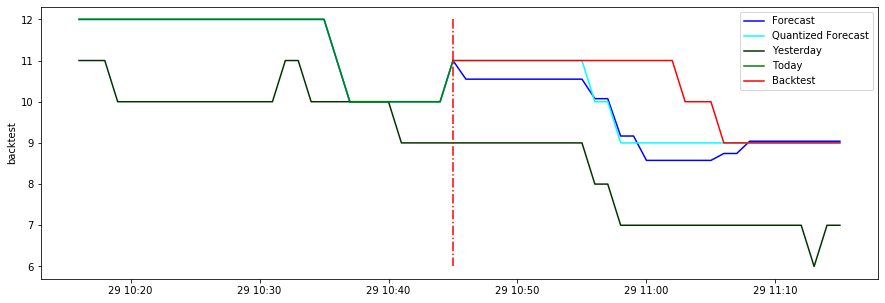

40 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.8821572133940805, 'importance_type': 'gain', 'learning_rate': 0.20737224065448598, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1850, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.1490556785471295, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.8950758174122756


[0]	validation_0-rmse:7.07158
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.36472
[2]	validation_0-rmse:5.72621
[3]	validation_0-rmse:5.15476
[4]	validation_0-rmse:4.652
[5]	validation_0-rmse:4.19423
[6]	validation_0-rmse:3.77808
[7]	validation_0-rmse:3.40004
[8]	validation_0-rmse:3.13368
[9]	validation_0-rmse:2.83098
[10]	validation_0-rmse:2.56422
[11]	validation_0-rmse:2.38579

[234]	validation_0-rmse:0.676682
[235]	validation_0-rmse:0.676593
[236]	validation_0-rmse:0.676603
[237]	validation_0-rmse:0.67659
[238]	validation_0-rmse:0.676589
[239]	validation_0-rmse:0.676625
[240]	validation_0-rmse:0.676637
[241]	validation_0-rmse:0.67664
[242]	validation_0-rmse:0.676619
[243]	validation_0-rmse:0.676622
[244]	validation_0-rmse:0.676615
[245]	validation_0-rmse:0.676612
[246]	validation_0-rmse:0.67663
[247]	validation_0-rmse:0.676633
[248]	validation_0-rmse:0.67664
[249]	validation_0-rmse:0.676603
[250]	validation_0-rmse:0.676633
[251]	validation_0-rmse:0.676646
[252]	validation_0-rmse:0.67662
[253]	validation_0-rmse:0.67666
[254]	validation_0-rmse:0.676695
[255]	validation_0-rmse:0.676664
[256]	validation_0-rmse:0.676659
[257]	validation_0-rmse:0.676664
[258]	validation_0-rmse:0.676686
[259]	validation_0-rmse:0.676674
[260]	validation_0-rmse:0.676683
[261]	validation_0-rmse:0.676672
[262]	validation_0-rmse:0.676701
[263]	validation_0-rmse:0.676706
[264]	validation

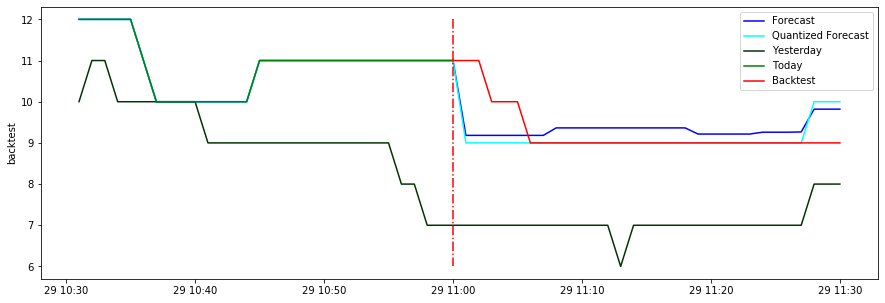

41 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.5305013688204452, 'importance_type': 'gain', 'learning_rate': 0.2365035756856527, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 18.858241509407968, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.3012707101031713


[0]	validation_0-rmse:7.54642
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.84324
[2]	validation_0-rmse:6.19335
[3]	validation_0-rmse:5.62411
[4]	validation_0-rmse:5.0965
[5]	validation_0-rmse:4.61531
[6]	validation_0-rmse:4.1984
[7]	validation_0-rmse:3.80769
[8]	validation_0-rmse:3.50788
[9]	validation_0-rmse:3.20272
[10]	validation_0-rmse:2.92087
[11]	validation_0-rmse:2.71211
[

[235]	validation_0-rmse:0.458688
[236]	validation_0-rmse:0.458696
[237]	validation_0-rmse:0.458635
[238]	validation_0-rmse:0.458588
[239]	validation_0-rmse:0.458564
[240]	validation_0-rmse:0.458567
[241]	validation_0-rmse:0.458584
[242]	validation_0-rmse:0.458626
[243]	validation_0-rmse:0.458588
[244]	validation_0-rmse:0.458574
[245]	validation_0-rmse:0.458498
[246]	validation_0-rmse:0.45844
[247]	validation_0-rmse:0.458411
[248]	validation_0-rmse:0.458374
[249]	validation_0-rmse:0.458359
[250]	validation_0-rmse:0.458346
[251]	validation_0-rmse:0.458317
[252]	validation_0-rmse:0.458308
[253]	validation_0-rmse:0.458348
[254]	validation_0-rmse:0.458453
[255]	validation_0-rmse:0.458421
[256]	validation_0-rmse:0.458359
[257]	validation_0-rmse:0.45834
[258]	validation_0-rmse:0.458319
[259]	validation_0-rmse:0.458322
[260]	validation_0-rmse:0.458309
[261]	validation_0-rmse:0.458293
[262]	validation_0-rmse:0.458233
[263]	validation_0-rmse:0.458232
[264]	validation_0-rmse:0.458242
[265]	valida

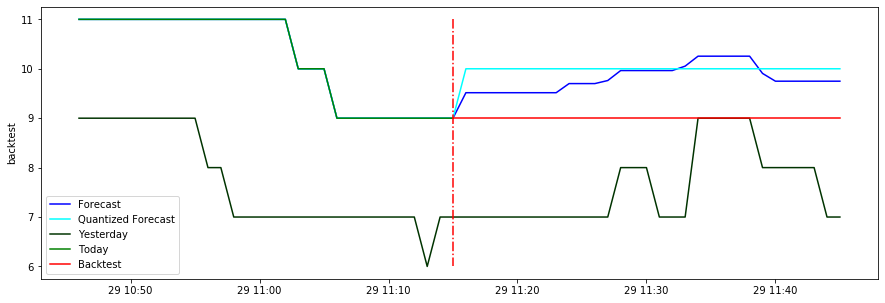

42 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.0046492019453233, 'importance_type': 'gain', 'learning_rate': 0.09828174614692038, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1280, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 7.82020286359693, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.088191597379075


[0]	validation_0-rmse:7.3025
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.59095
[2]	validation_0-rmse:5.95909
[3]	validation_0-rmse:5.37806
[4]	validation_0-rmse:4.85488
[5]	validation_0-rmse:4.3819
[6]	validation_0-rmse:3.97434
[7]	validation_0-rmse:3.6037
[8]	validation_0-rmse:3.30848
[9]	validation_0-rmse:3.01855
[10]	validation_0-rmse:2.74129
[11]	validation_0-rmse:2.54021
[12

[234]	validation_0-rmse:0.460763
[235]	validation_0-rmse:0.460787
[236]	validation_0-rmse:0.460709
[237]	validation_0-rmse:0.4607
[238]	validation_0-rmse:0.460617
[239]	validation_0-rmse:0.460619
[240]	validation_0-rmse:0.460615
[241]	validation_0-rmse:0.460622
[242]	validation_0-rmse:0.46062
[243]	validation_0-rmse:0.460662
[244]	validation_0-rmse:0.460667
[245]	validation_0-rmse:0.460605
[246]	validation_0-rmse:0.460654
[247]	validation_0-rmse:0.460648
[248]	validation_0-rmse:0.460622
[249]	validation_0-rmse:0.460351
[250]	validation_0-rmse:0.460204
[251]	validation_0-rmse:0.460026
[252]	validation_0-rmse:0.459957
[253]	validation_0-rmse:0.459912
[254]	validation_0-rmse:0.459869
[255]	validation_0-rmse:0.459715
[256]	validation_0-rmse:0.459613
[257]	validation_0-rmse:0.459621
[258]	validation_0-rmse:0.459701
[259]	validation_0-rmse:0.459666
[260]	validation_0-rmse:0.459667
[261]	validation_0-rmse:0.45967
[262]	validation_0-rmse:0.459643
[263]	validation_0-rmse:0.459648
[264]	validati

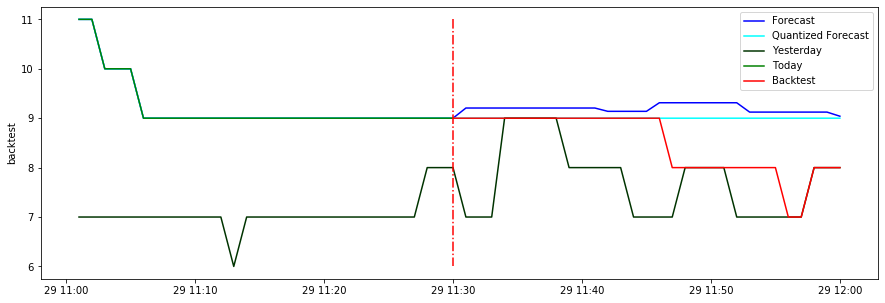

43 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.2248698722555447, 'importance_type': 'gain', 'learning_rate': 0.2619336773103315, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1530, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.659264827014123, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.940521913688711


[0]	validation_0-rmse:7.23265
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.5386
[2]	validation_0-rmse:5.90164
[3]	validation_0-rmse:5.32812
[4]	validation_0-rmse:4.81614
[5]	validation_0-rmse:4.3512
[6]	validation_0-rmse:3.93202
[7]	validation_0-rmse:3.56735
[8]	validation_0-rmse:3.26945
[9]	validation_0-rmse:2.96672
[10]	validation_0-rmse:2.69906
[11]	validation_0-rmse:2.50044
[1

[234]	validation_0-rmse:0.53212
[235]	validation_0-rmse:0.532147
[236]	validation_0-rmse:0.532189
[237]	validation_0-rmse:0.532176
[238]	validation_0-rmse:0.532231
[239]	validation_0-rmse:0.532252
[240]	validation_0-rmse:0.532238
[241]	validation_0-rmse:0.532246
[242]	validation_0-rmse:0.532268
[243]	validation_0-rmse:0.532366
[244]	validation_0-rmse:0.532357
[245]	validation_0-rmse:0.532374
[246]	validation_0-rmse:0.532344
[247]	validation_0-rmse:0.532351
[248]	validation_0-rmse:0.532421
[249]	validation_0-rmse:0.532279
[250]	validation_0-rmse:0.532216
[251]	validation_0-rmse:0.532198
[252]	validation_0-rmse:0.532157
[253]	validation_0-rmse:0.532155
[254]	validation_0-rmse:0.532184
[255]	validation_0-rmse:0.532239
[256]	validation_0-rmse:0.532231
[257]	validation_0-rmse:0.532206
[258]	validation_0-rmse:0.532173
[259]	validation_0-rmse:0.532164
[260]	validation_0-rmse:0.532141
[261]	validation_0-rmse:0.53217
[262]	validation_0-rmse:0.532203
[263]	validation_0-rmse:0.532188
[264]	valida

[483]	validation_0-rmse:0.531442
[484]	validation_0-rmse:0.531449
[485]	validation_0-rmse:0.531447
[486]	validation_0-rmse:0.531452
[487]	validation_0-rmse:0.531453
[488]	validation_0-rmse:0.531456
[489]	validation_0-rmse:0.531455
[490]	validation_0-rmse:0.531451
[491]	validation_0-rmse:0.531452
[492]	validation_0-rmse:0.53145
[493]	validation_0-rmse:0.53145
[494]	validation_0-rmse:0.531448
[495]	validation_0-rmse:0.531446
[496]	validation_0-rmse:0.531446
[497]	validation_0-rmse:0.531445
[498]	validation_0-rmse:0.531443
[499]	validation_0-rmse:0.531443
[500]	validation_0-rmse:0.531436
[501]	validation_0-rmse:0.531434
[502]	validation_0-rmse:0.531444
[503]	validation_0-rmse:0.531439
[504]	validation_0-rmse:0.53144
[505]	validation_0-rmse:0.531441
[506]	validation_0-rmse:0.531443
[507]	validation_0-rmse:0.531444
[508]	validation_0-rmse:0.531443
[509]	validation_0-rmse:0.531443
[510]	validation_0-rmse:0.531446
[511]	validation_0-rmse:0.531441
[512]	validation_0-rmse:0.531434
[513]	validat

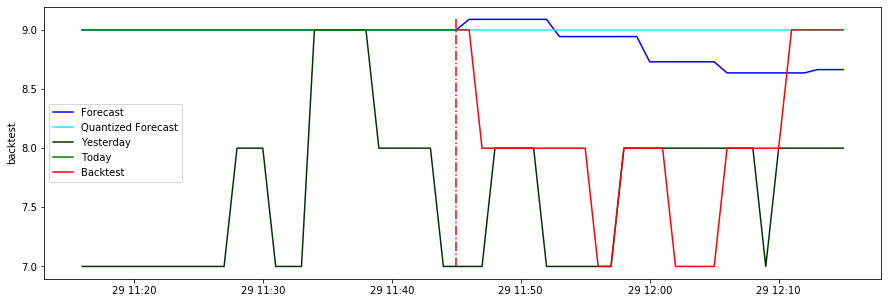

44 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.228288451500763, 'importance_type': 'gain', 'learning_rate': 0.2209302637257173, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1110, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.686602489381199, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.144466890564598


[0]	validation_0-rmse:6.968
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.27739
[2]	validation_0-rmse:5.6721
[3]	validation_0-rmse:5.11242
[4]	validation_0-rmse:4.61709
[5]	validation_0-rmse:4.17381
[6]	validation_0-rmse:3.76315
[7]	validation_0-rmse:3.40809
[8]	validation_0-rmse:3.12411
[9]	validation_0-rmse:2.82424
[10]	validation_0-rmse:2.56331
[11]	validation_0-rmse:2.35181
[12]

[234]	validation_0-rmse:0.287079
[235]	validation_0-rmse:0.287143
[236]	validation_0-rmse:0.287221
[237]	validation_0-rmse:0.287183
[238]	validation_0-rmse:0.28714
[239]	validation_0-rmse:0.287141
[240]	validation_0-rmse:0.287158
[241]	validation_0-rmse:0.28712
[242]	validation_0-rmse:0.287078
[243]	validation_0-rmse:0.287072
[244]	validation_0-rmse:0.287074
[245]	validation_0-rmse:0.287106
[246]	validation_0-rmse:0.287071
[247]	validation_0-rmse:0.287056
[248]	validation_0-rmse:0.286973
[249]	validation_0-rmse:0.286978
[250]	validation_0-rmse:0.287059
[251]	validation_0-rmse:0.287128
[252]	validation_0-rmse:0.287081
[253]	validation_0-rmse:0.28721
[254]	validation_0-rmse:0.287232
[255]	validation_0-rmse:0.28729
[256]	validation_0-rmse:0.287359
[257]	validation_0-rmse:0.2874
[258]	validation_0-rmse:0.287424
[259]	validation_0-rmse:0.28741
[260]	validation_0-rmse:0.287426
[261]	validation_0-rmse:0.287408
[262]	validation_0-rmse:0.28746
[263]	validation_0-rmse:0.287449
[264]	validation_0

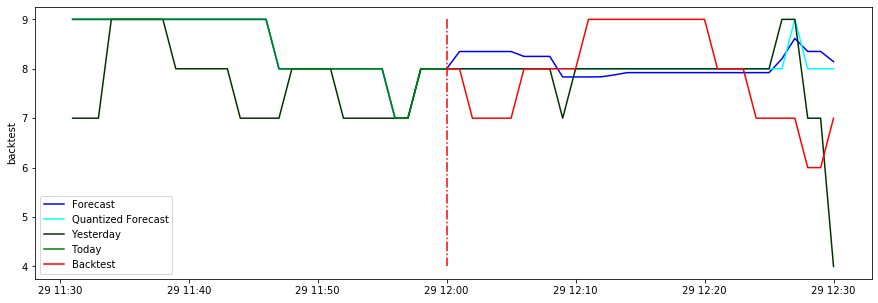

45 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.0301228599530106, 'importance_type': 'gain', 'learning_rate': 0.16383970322655167, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1470, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.35810715281762745, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.073535011064602


[0]	validation_0-rmse:6.67856
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.06145
[2]	validation_0-rmse:5.49253
[3]	validation_0-rmse:4.98099
[4]	validation_0-rmse:4.52252
[5]	validation_0-rmse:4.11605
[6]	validation_0-rmse:3.74315
[7]	validation_0-rmse:3.40753
[8]	validation_0-rmse:3.14372
[9]	validation_0-rmse:2.87676
[10]	validation_0-rmse:2.62426
[11]	validation_0-rmse:2.443

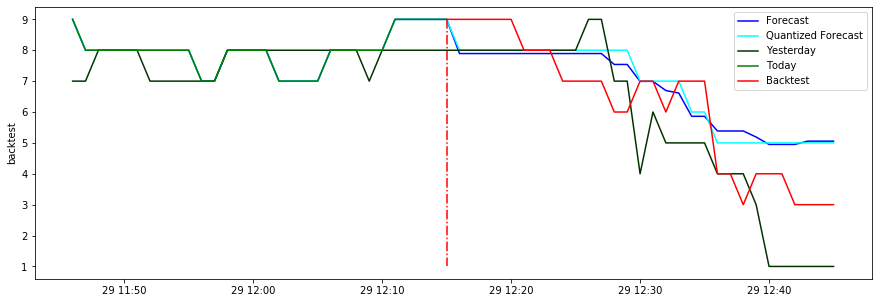

46 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 9.716116258423373, 'importance_type': 'gain', 'learning_rate': 0.014708568725218887, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1820, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.5084267750632327, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.0879058828621229


[0]	validation_0-rmse:6.27301
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.68351
[2]	validation_0-rmse:5.14074
[3]	validation_0-rmse:4.65173
[4]	validation_0-rmse:4.22394
[5]	validation_0-rmse:3.8426
[6]	validation_0-rmse:3.52316
[7]	validation_0-rmse:3.19519
[8]	validation_0-rmse:2.98685
[9]	validation_0-rmse:2.7597
[10]	validation_0-rmse:2.5084
[11]	validation_0-rmse:2.35284


[234]	validation_0-rmse:0.524145
[235]	validation_0-rmse:0.52442
[236]	validation_0-rmse:0.524422
[237]	validation_0-rmse:0.524399
[238]	validation_0-rmse:0.52449
[239]	validation_0-rmse:0.524496
[240]	validation_0-rmse:0.524516
[241]	validation_0-rmse:0.524495
[242]	validation_0-rmse:0.524399
[243]	validation_0-rmse:0.524549
[244]	validation_0-rmse:0.524517
[245]	validation_0-rmse:0.524431
[246]	validation_0-rmse:0.524344
[247]	validation_0-rmse:0.524361
[248]	validation_0-rmse:0.524368
[249]	validation_0-rmse:0.524527
[250]	validation_0-rmse:0.524539
[251]	validation_0-rmse:0.524505
[252]	validation_0-rmse:0.524299
[253]	validation_0-rmse:0.524244
[254]	validation_0-rmse:0.524199
[255]	validation_0-rmse:0.524134
[256]	validation_0-rmse:0.52406
[257]	validation_0-rmse:0.523869
[258]	validation_0-rmse:0.523826
[259]	validation_0-rmse:0.523748
[260]	validation_0-rmse:0.523759
[261]	validation_0-rmse:0.523742
[262]	validation_0-rmse:0.52372
[263]	validation_0-rmse:0.523692
[264]	validati

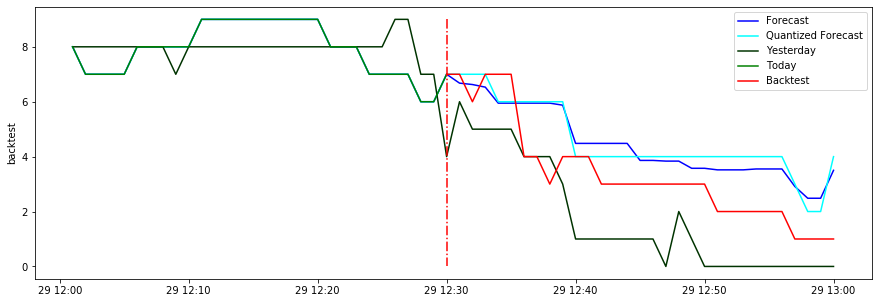

47 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.0086449027198208, 'importance_type': 'gain', 'learning_rate': 0.17437595617988724, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 7.17024414067345, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.2192324023142302


[0]	validation_0-rmse:5.89382
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.34785
[2]	validation_0-rmse:4.85704
[3]	validation_0-rmse:4.41262
[4]	validation_0-rmse:4.00583
[5]	validation_0-rmse:3.63553
[6]	validation_0-rmse:3.34093
[7]	validation_0-rmse:3.04314
[8]	validation_0-rmse:2.85799
[9]	validation_0-rmse:2.64563
[10]	validation_0-rmse:2.43564
[11]	validation_0-rmse:2.31504


[235]	validation_0-rmse:0.57973
[236]	validation_0-rmse:0.579683
[237]	validation_0-rmse:0.579641
[238]	validation_0-rmse:0.579629
[239]	validation_0-rmse:0.579601
[240]	validation_0-rmse:0.579597
[241]	validation_0-rmse:0.579586
[242]	validation_0-rmse:0.57954
[243]	validation_0-rmse:0.57954
[244]	validation_0-rmse:0.57956
[245]	validation_0-rmse:0.579537
[246]	validation_0-rmse:0.57952
[247]	validation_0-rmse:0.579504
[248]	validation_0-rmse:0.579465
[249]	validation_0-rmse:0.579539
[250]	validation_0-rmse:0.579501
[251]	validation_0-rmse:0.579532
[252]	validation_0-rmse:0.579547
[253]	validation_0-rmse:0.579421
[254]	validation_0-rmse:0.579461
[255]	validation_0-rmse:0.579404
[256]	validation_0-rmse:0.579409
[257]	validation_0-rmse:0.579419
[258]	validation_0-rmse:0.579389
[259]	validation_0-rmse:0.57934
[260]	validation_0-rmse:0.579312
[261]	validation_0-rmse:0.579328
[262]	validation_0-rmse:0.579275
[263]	validation_0-rmse:0.579261
[264]	validation_0-rmse:0.579221
[265]	validation

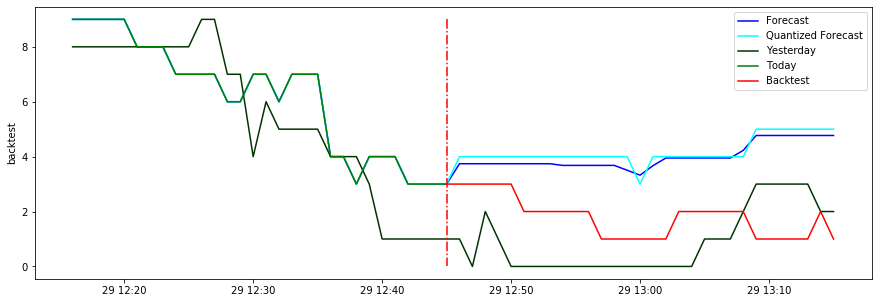

48 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.2379314988440924, 'importance_type': 'gain', 'learning_rate': 0.13066891609512776, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1270, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 5.503663930003544, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.9525892467790595


[0]	validation_0-rmse:5.72138
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.17124
[2]	validation_0-rmse:4.68881
[3]	validation_0-rmse:4.24056
[4]	validation_0-rmse:3.84654
[5]	validation_0-rmse:3.48244
[6]	validation_0-rmse:3.17815
[7]	validation_0-rmse:2.89533
[8]	validation_0-rmse:2.73089
[9]	validation_0-rmse:2.50415
[10]	validation_0-rmse:2.28039
[11]	validation_0-rmse:2.1578

[234]	validation_0-rmse:0.450245
[235]	validation_0-rmse:0.450142
[236]	validation_0-rmse:0.450129
[237]	validation_0-rmse:0.450119
[238]	validation_0-rmse:0.449963
[239]	validation_0-rmse:0.449957
[240]	validation_0-rmse:0.449938
[241]	validation_0-rmse:0.449901
[242]	validation_0-rmse:0.449908
[243]	validation_0-rmse:0.449739
[244]	validation_0-rmse:0.449735
[245]	validation_0-rmse:0.449574
[246]	validation_0-rmse:0.449532
[247]	validation_0-rmse:0.449515
[248]	validation_0-rmse:0.449423
[249]	validation_0-rmse:0.449439
[250]	validation_0-rmse:0.449301
[251]	validation_0-rmse:0.449019
[252]	validation_0-rmse:0.448972
[253]	validation_0-rmse:0.449044
[254]	validation_0-rmse:0.449042
[255]	validation_0-rmse:0.44904
[256]	validation_0-rmse:0.449064
[257]	validation_0-rmse:0.448939
[258]	validation_0-rmse:0.448813
[259]	validation_0-rmse:0.448822
[260]	validation_0-rmse:0.448832
[261]	validation_0-rmse:0.448847
[262]	validation_0-rmse:0.44887
[263]	validation_0-rmse:0.448874
[264]	valida

[483]	validation_0-rmse:0.445589
[484]	validation_0-rmse:0.445591
[485]	validation_0-rmse:0.445588
[486]	validation_0-rmse:0.445589
[487]	validation_0-rmse:0.44558
[488]	validation_0-rmse:0.445582
[489]	validation_0-rmse:0.445579
[490]	validation_0-rmse:0.445574
[491]	validation_0-rmse:0.445569
[492]	validation_0-rmse:0.445569
[493]	validation_0-rmse:0.445566
[494]	validation_0-rmse:0.445569
[495]	validation_0-rmse:0.445565
[496]	validation_0-rmse:0.445565
[497]	validation_0-rmse:0.445567
[498]	validation_0-rmse:0.445564
[499]	validation_0-rmse:0.445563
[500]	validation_0-rmse:0.445568
[501]	validation_0-rmse:0.445571
[502]	validation_0-rmse:0.445569
[503]	validation_0-rmse:0.445568
[504]	validation_0-rmse:0.445567
[505]	validation_0-rmse:0.445567
[506]	validation_0-rmse:0.445557
[507]	validation_0-rmse:0.445548
[508]	validation_0-rmse:0.445536
[509]	validation_0-rmse:0.445536
[510]	validation_0-rmse:0.445547
[511]	validation_0-rmse:0.445547
[512]	validation_0-rmse:0.445535
[513]	valid

[732]	validation_0-rmse:0.445405
[733]	validation_0-rmse:0.445405
[734]	validation_0-rmse:0.445402
[735]	validation_0-rmse:0.445402
[736]	validation_0-rmse:0.445404
[737]	validation_0-rmse:0.445405
[738]	validation_0-rmse:0.445405
[739]	validation_0-rmse:0.445406
[740]	validation_0-rmse:0.445406
[741]	validation_0-rmse:0.445407
[742]	validation_0-rmse:0.4454
[743]	validation_0-rmse:0.4454
[744]	validation_0-rmse:0.4454
[745]	validation_0-rmse:0.445399
[746]	validation_0-rmse:0.4454
[747]	validation_0-rmse:0.4454
[748]	validation_0-rmse:0.445401
[749]	validation_0-rmse:0.445404
[750]	validation_0-rmse:0.445404
[751]	validation_0-rmse:0.445406
[752]	validation_0-rmse:0.445406
[753]	validation_0-rmse:0.445411
[754]	validation_0-rmse:0.445411
[755]	validation_0-rmse:0.445409
[756]	validation_0-rmse:0.445405
[757]	validation_0-rmse:0.445404
[758]	validation_0-rmse:0.445404
[759]	validation_0-rmse:0.445404
[760]	validation_0-rmse:0.445402
[761]	validation_0-rmse:0.445398
[762]	validation_0-r

[982]	validation_0-rmse:0.445361
[983]	validation_0-rmse:0.44536
[984]	validation_0-rmse:0.445359
[985]	validation_0-rmse:0.445359
[986]	validation_0-rmse:0.445359
[987]	validation_0-rmse:0.44536
[988]	validation_0-rmse:0.44536
[989]	validation_0-rmse:0.44536
[990]	validation_0-rmse:0.44536
[991]	validation_0-rmse:0.44536
[992]	validation_0-rmse:0.445362
[993]	validation_0-rmse:0.445362
[994]	validation_0-rmse:0.445364
[995]	validation_0-rmse:0.445364
[996]	validation_0-rmse:0.445364
[997]	validation_0-rmse:0.445365
[998]	validation_0-rmse:0.445365
[999]	validation_0-rmse:0.445365
[1000]	validation_0-rmse:0.445367
[1001]	validation_0-rmse:0.445367
[1002]	validation_0-rmse:0.445367
[1003]	validation_0-rmse:0.445364
[1004]	validation_0-rmse:0.445364
[1005]	validation_0-rmse:0.445364
[1006]	validation_0-rmse:0.445366
[1007]	validation_0-rmse:0.445367
[1008]	validation_0-rmse:0.445367
[1009]	validation_0-rmse:0.445367
[1010]	validation_0-rmse:0.445366
[1011]	validation_0-rmse:0.445365
[101

[1224]	validation_0-rmse:0.445344
[1225]	validation_0-rmse:0.445344
[1226]	validation_0-rmse:0.445343
[1227]	validation_0-rmse:0.445341
[1228]	validation_0-rmse:0.445342
[1229]	validation_0-rmse:0.445342
[1230]	validation_0-rmse:0.445343
[1231]	validation_0-rmse:0.445346
[1232]	validation_0-rmse:0.445346
[1233]	validation_0-rmse:0.445342
[1234]	validation_0-rmse:0.445342
[1235]	validation_0-rmse:0.445342
[1236]	validation_0-rmse:0.445342
[1237]	validation_0-rmse:0.445342
[1238]	validation_0-rmse:0.445342
[1239]	validation_0-rmse:0.445342
[1240]	validation_0-rmse:0.445341
[1241]	validation_0-rmse:0.445341
[1242]	validation_0-rmse:0.445341
[1243]	validation_0-rmse:0.445341
[1244]	validation_0-rmse:0.44534
[1245]	validation_0-rmse:0.44534
[1246]	validation_0-rmse:0.445341
[1247]	validation_0-rmse:0.445339
[1248]	validation_0-rmse:0.445339
[1249]	validation_0-rmse:0.445338
[1250]	validation_0-rmse:0.445336
[1251]	validation_0-rmse:0.445336
[1252]	validation_0-rmse:0.445336
[1253]	validatio

[1466]	validation_0-rmse:0.445326
[1467]	validation_0-rmse:0.445326
[1468]	validation_0-rmse:0.445325
[1469]	validation_0-rmse:0.445325
[1470]	validation_0-rmse:0.445325
[1471]	validation_0-rmse:0.445324
[1472]	validation_0-rmse:0.445324
[1473]	validation_0-rmse:0.445324
[1474]	validation_0-rmse:0.445323
[1475]	validation_0-rmse:0.445323
[1476]	validation_0-rmse:0.445325
[1477]	validation_0-rmse:0.445325
[1478]	validation_0-rmse:0.445325
[1479]	validation_0-rmse:0.445325
[1480]	validation_0-rmse:0.445326
[1481]	validation_0-rmse:0.445326
[1482]	validation_0-rmse:0.445324
[1483]	validation_0-rmse:0.445324
[1484]	validation_0-rmse:0.445323
[1485]	validation_0-rmse:0.445325
[1486]	validation_0-rmse:0.445325
[1487]	validation_0-rmse:0.445325
[1488]	validation_0-rmse:0.445324
[1489]	validation_0-rmse:0.445326
[1490]	validation_0-rmse:0.445326
[1491]	validation_0-rmse:0.445326
[1492]	validation_0-rmse:0.445326
[1493]	validation_0-rmse:0.445326
[1494]	validation_0-rmse:0.445326
[1495]	validat

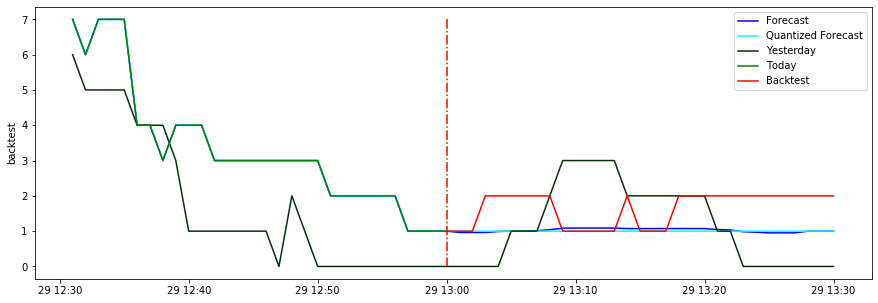

49 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 9.205901094671683, 'importance_type': 'gain', 'learning_rate': 0.04452081513093595, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 850, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 12.651792784938062, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.7808460233030383


[0]	validation_0-rmse:5.90484
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.33263
[2]	validation_0-rmse:4.81458
[3]	validation_0-rmse:4.35189
[4]	validation_0-rmse:3.95146
[5]	validation_0-rmse:3.58045
[6]	validation_0-rmse:3.25929
[7]	validation_0-rmse:2.96903
[8]	validation_0-rmse:2.76918
[9]	validation_0-rmse:2.53035
[10]	validation_0-rmse:2.31266
[11]	validation_0-rmse:2.17785

[234]	validation_0-rmse:0.667774
[235]	validation_0-rmse:0.667575
[236]	validation_0-rmse:0.667517
[237]	validation_0-rmse:0.667534
[238]	validation_0-rmse:0.667559
[239]	validation_0-rmse:0.667521
[240]	validation_0-rmse:0.667529
[241]	validation_0-rmse:0.667536
[242]	validation_0-rmse:0.667502
[243]	validation_0-rmse:0.667442
[244]	validation_0-rmse:0.667425
[245]	validation_0-rmse:0.667368
[246]	validation_0-rmse:0.667405
[247]	validation_0-rmse:0.667398
[248]	validation_0-rmse:0.667381
[249]	validation_0-rmse:0.667117
[250]	validation_0-rmse:0.66705
[251]	validation_0-rmse:0.667091
[252]	validation_0-rmse:0.667081
[253]	validation_0-rmse:0.667054
[254]	validation_0-rmse:0.667073
[255]	validation_0-rmse:0.666925
[256]	validation_0-rmse:0.666965
[257]	validation_0-rmse:0.666958
[258]	validation_0-rmse:0.66702
[259]	validation_0-rmse:0.666971
[260]	validation_0-rmse:0.666955
[261]	validation_0-rmse:0.666957
[262]	validation_0-rmse:0.666947
[263]	validation_0-rmse:0.666966
[264]	valida

[484]	validation_0-rmse:0.665294
[485]	validation_0-rmse:0.665294
[486]	validation_0-rmse:0.665293
[487]	validation_0-rmse:0.665295
[488]	validation_0-rmse:0.665297
[489]	validation_0-rmse:0.665302
[490]	validation_0-rmse:0.665303
[491]	validation_0-rmse:0.665321
[492]	validation_0-rmse:0.665321
[493]	validation_0-rmse:0.665314
[494]	validation_0-rmse:0.665315
[495]	validation_0-rmse:0.665318
[496]	validation_0-rmse:0.665317
[497]	validation_0-rmse:0.665315
[498]	validation_0-rmse:0.665316
[499]	validation_0-rmse:0.665315
[500]	validation_0-rmse:0.665314
[501]	validation_0-rmse:0.665315
[502]	validation_0-rmse:0.665307
[503]	validation_0-rmse:0.665305
[504]	validation_0-rmse:0.665302
[505]	validation_0-rmse:0.665303
[506]	validation_0-rmse:0.665304
[507]	validation_0-rmse:0.665305
[508]	validation_0-rmse:0.665297
[509]	validation_0-rmse:0.665299
[510]	validation_0-rmse:0.665306
[511]	validation_0-rmse:0.665306
[512]	validation_0-rmse:0.665312
[513]	validation_0-rmse:0.665312
[514]	vali

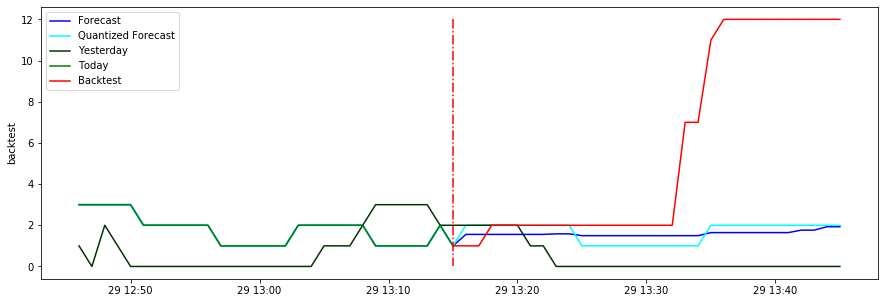

50 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.656155578317274, 'importance_type': 'gain', 'learning_rate': 0.06878922957539077, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1180, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.264504655410682, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 6.337554668994347


[0]	validation_0-rmse:6.606
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.96068
[2]	validation_0-rmse:5.3671
[3]	validation_0-rmse:4.8369
[4]	validation_0-rmse:4.36491
[5]	validation_0-rmse:3.9411
[6]	validation_0-rmse:3.5942
[7]	validation_0-rmse:3.24533
[8]	validation_0-rmse:3.02221
[9]	validation_0-rmse:2.77617
[10]	validation_0-rmse:2.51384
[11]	validation_0-rmse:2.39306
[12]	v

[234]	validation_0-rmse:0.582403
[235]	validation_0-rmse:0.582316
[236]	validation_0-rmse:0.582419
[237]	validation_0-rmse:0.582382
[238]	validation_0-rmse:0.582413
[239]	validation_0-rmse:0.58242
[240]	validation_0-rmse:0.582431
[241]	validation_0-rmse:0.582397
[242]	validation_0-rmse:0.58244
[243]	validation_0-rmse:0.58237
[244]	validation_0-rmse:0.582346
[245]	validation_0-rmse:0.582392
[246]	validation_0-rmse:0.582282
[247]	validation_0-rmse:0.582271
[248]	validation_0-rmse:0.582292
[249]	validation_0-rmse:0.582062
[250]	validation_0-rmse:0.581844
[251]	validation_0-rmse:0.581845
[252]	validation_0-rmse:0.581856
[253]	validation_0-rmse:0.582006
[254]	validation_0-rmse:0.581952
[255]	validation_0-rmse:0.58194
[256]	validation_0-rmse:0.581861
[257]	validation_0-rmse:0.581836
[258]	validation_0-rmse:0.581839
[259]	validation_0-rmse:0.581837
[260]	validation_0-rmse:0.58182
[261]	validation_0-rmse:0.581832
[262]	validation_0-rmse:0.581837
[263]	validation_0-rmse:0.581834
[264]	validatio

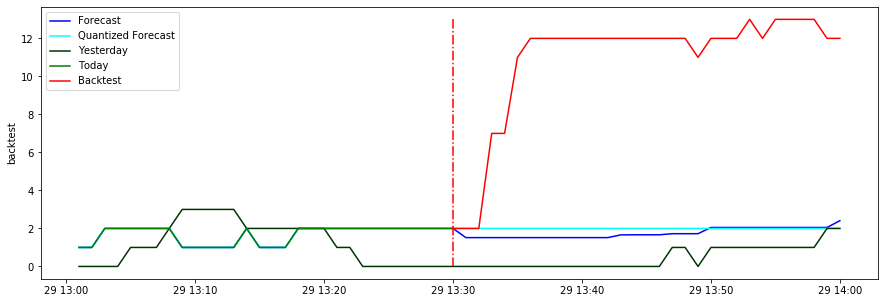

51 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.05033026699974408, 'importance_type': 'gain', 'learning_rate': 0.16351501133973975, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1150, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 8.222085637857516, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 9.81123559160183


[0]	validation_0-rmse:7.74625
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.02129
[2]	validation_0-rmse:6.3665
[3]	validation_0-rmse:5.78083
[4]	validation_0-rmse:5.25461
[5]	validation_0-rmse:4.77006
[6]	validation_0-rmse:4.35343
[7]	validation_0-rmse:3.95887
[8]	validation_0-rmse:3.63609
[9]	validation_0-rmse:3.33338
[10]	validation_0-rmse:3.04026
[11]	validation_0-rmse:2.8283
[

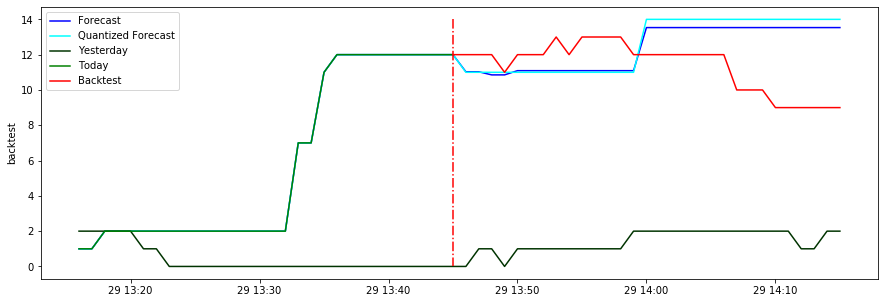

52 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.15843313020461713, 'importance_type': 'gain', 'learning_rate': 0.12173244865265664, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 160, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 5.25328589736964, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.4620837463648235


[0]	validation_0-rmse:9.03089
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.20241
[2]	validation_0-rmse:7.44318
[3]	validation_0-rmse:6.77517
[4]	validation_0-rmse:6.14778
[5]	validation_0-rmse:5.5882
[6]	validation_0-rmse:5.10968
[7]	validation_0-rmse:4.63856
[8]	validation_0-rmse:4.25263
[9]	validation_0-rmse:3.88856
[10]	validation_0-rmse:3.56843
[11]	validation_0-rmse:3.32619


[235]	validation_0-rmse:0.564359
[236]	validation_0-rmse:0.564304
[237]	validation_0-rmse:0.56436
[238]	validation_0-rmse:0.564362
[239]	validation_0-rmse:0.5643
[240]	validation_0-rmse:0.564328
[241]	validation_0-rmse:0.564314
[242]	validation_0-rmse:0.564389
[243]	validation_0-rmse:0.564362
[244]	validation_0-rmse:0.564365
[245]	validation_0-rmse:0.564458
[246]	validation_0-rmse:0.564501
[247]	validation_0-rmse:0.564492
[248]	validation_0-rmse:0.564489
[249]	validation_0-rmse:0.564538
[250]	validation_0-rmse:0.564409
[251]	validation_0-rmse:0.564263
[252]	validation_0-rmse:0.564323
[253]	validation_0-rmse:0.56411
[254]	validation_0-rmse:0.563847
[255]	validation_0-rmse:0.563742
[256]	validation_0-rmse:0.563561
[257]	validation_0-rmse:0.563504
[258]	validation_0-rmse:0.563555
[259]	validation_0-rmse:0.563558
[260]	validation_0-rmse:0.563534
[261]	validation_0-rmse:0.563506
[262]	validation_0-rmse:0.56345
[263]	validation_0-rmse:0.563411
[264]	validation_0-rmse:0.563338
[265]	validatio

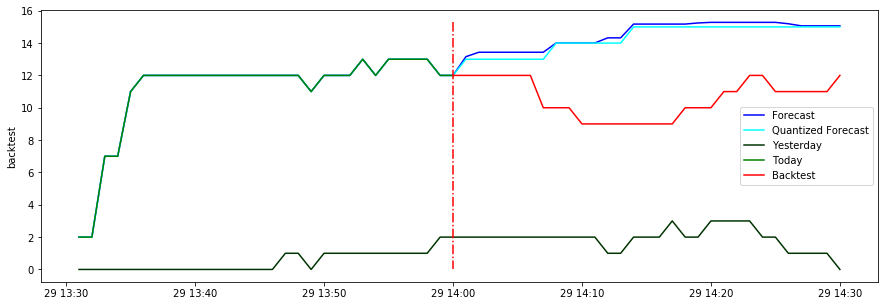

53 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.6088719670169649, 'importance_type': 'gain', 'learning_rate': 0.03318142509916505, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1220, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.5210091165133701, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 4.257964542477051


[0]	validation_0-rmse:9.47286
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.58464
[2]	validation_0-rmse:7.76295
[3]	validation_0-rmse:7.04056
[4]	validation_0-rmse:6.37282
[5]	validation_0-rmse:5.77093
[6]	validation_0-rmse:5.25895
[7]	validation_0-rmse:4.78667
[8]	validation_0-rmse:4.36436
[9]	validation_0-rmse:3.98796
[10]	validation_0-rmse:3.65105
[11]	validation_0-rmse:3.3486

[234]	validation_0-rmse:0.473939
[235]	validation_0-rmse:0.473922
[236]	validation_0-rmse:0.474039
[237]	validation_0-rmse:0.474041
[238]	validation_0-rmse:0.474007
[239]	validation_0-rmse:0.474026
[240]	validation_0-rmse:0.474046
[241]	validation_0-rmse:0.474048
[242]	validation_0-rmse:0.474021
[243]	validation_0-rmse:0.473847
[244]	validation_0-rmse:0.473845
[245]	validation_0-rmse:0.473948
[246]	validation_0-rmse:0.473968
[247]	validation_0-rmse:0.473983
[248]	validation_0-rmse:0.474053
[249]	validation_0-rmse:0.474021
[250]	validation_0-rmse:0.474078
[251]	validation_0-rmse:0.474018
[252]	validation_0-rmse:0.474146
[253]	validation_0-rmse:0.474061
[254]	validation_0-rmse:0.474101
[255]	validation_0-rmse:0.474221
[256]	validation_0-rmse:0.474131
[257]	validation_0-rmse:0.474114
[258]	validation_0-rmse:0.474063
[259]	validation_0-rmse:0.474156
[260]	validation_0-rmse:0.474174
[261]	validation_0-rmse:0.474186
[262]	validation_0-rmse:0.474183
[263]	validation_0-rmse:0.474169
[264]	vali

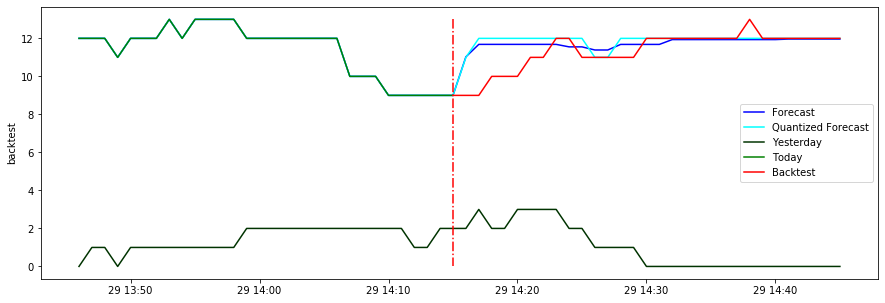

54 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.1792622804312543, 'importance_type': 'gain', 'learning_rate': 0.20516000184828334, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1540, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.5746223779082404, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.1233538693577285


[0]	validation_0-rmse:9.14399
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.25915
[2]	validation_0-rmse:7.44498
[3]	validation_0-rmse:6.73771
[4]	validation_0-rmse:6.07789
[5]	validation_0-rmse:5.50642
[6]	validation_0-rmse:4.98513
[7]	validation_0-rmse:4.48682
[8]	validation_0-rmse:4.07118
[9]	validation_0-rmse:3.7016
[10]	validation_0-rmse:3.33821
[11]	validation_0-rmse:3.0507

[234]	validation_0-rmse:0.569745
[235]	validation_0-rmse:0.569872
[236]	validation_0-rmse:0.569837
[237]	validation_0-rmse:0.569813
[238]	validation_0-rmse:0.569728
[239]	validation_0-rmse:0.569721
[240]	validation_0-rmse:0.569722
[241]	validation_0-rmse:0.569728
[242]	validation_0-rmse:0.569826
[243]	validation_0-rmse:0.56971
[244]	validation_0-rmse:0.569694
[245]	validation_0-rmse:0.569787
[246]	validation_0-rmse:0.569641
[247]	validation_0-rmse:0.569652
[248]	validation_0-rmse:0.56966
[249]	validation_0-rmse:0.569658
[250]	validation_0-rmse:0.569529
[251]	validation_0-rmse:0.569472
[252]	validation_0-rmse:0.569479
[253]	validation_0-rmse:0.569494
[254]	validation_0-rmse:0.569485
[255]	validation_0-rmse:0.569485
[256]	validation_0-rmse:0.569364
[257]	validation_0-rmse:0.569381
[258]	validation_0-rmse:0.569391
[259]	validation_0-rmse:0.569346
[260]	validation_0-rmse:0.569338
[261]	validation_0-rmse:0.569336
[262]	validation_0-rmse:0.569322
[263]	validation_0-rmse:0.569351
[264]	valida

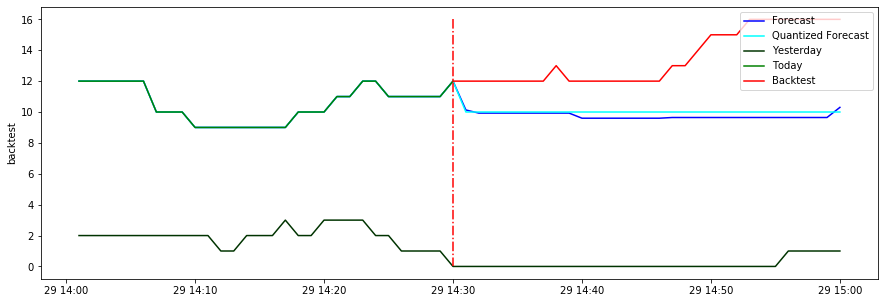

55 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.5579054668219605, 'importance_type': 'gain', 'learning_rate': 0.06072427210253567, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1750, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 11.23979762556981, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 4.198265311732799


[0]	validation_0-rmse:9.08858
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.17744
[2]	validation_0-rmse:7.35964
[3]	validation_0-rmse:6.62067
[4]	validation_0-rmse:5.96688
[5]	validation_0-rmse:5.38158
[6]	validation_0-rmse:4.84277
[7]	validation_0-rmse:4.37899
[8]	validation_0-rmse:3.97142
[9]	validation_0-rmse:3.58331
[10]	validation_0-rmse:3.25646
[11]	validation_0-rmse:2.96207

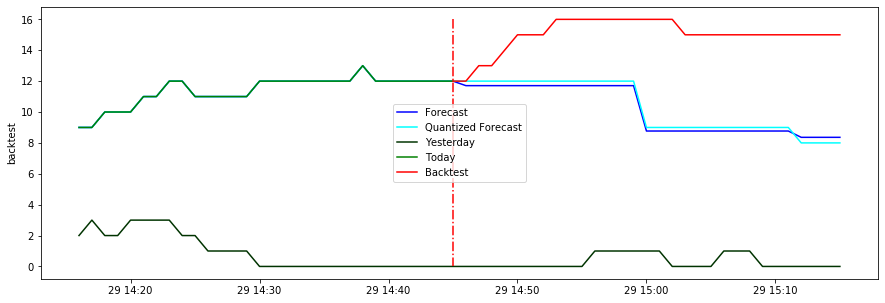

56 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.6331674299711463, 'importance_type': 'gain', 'learning_rate': 0.28424828862109686, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1110, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 7.768619922852367, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 4.910559697625912


[0]	validation_0-rmse:9.16405
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.2945
[2]	validation_0-rmse:7.52886
[3]	validation_0-rmse:6.82606
[4]	validation_0-rmse:6.21221
[5]	validation_0-rmse:5.64108
[6]	validation_0-rmse:5.14154
[7]	validation_0-rmse:4.69278
[8]	validation_0-rmse:4.28069
[9]	validation_0-rmse:3.91122
[10]	validation_0-rmse:3.5809
[11]	validation_0-rmse:3.29165
[

[234]	validation_0-rmse:0.4453
[235]	validation_0-rmse:0.445287
[236]	validation_0-rmse:0.445225
[237]	validation_0-rmse:0.445267
[238]	validation_0-rmse:0.445268
[239]	validation_0-rmse:0.445234
[240]	validation_0-rmse:0.445218
[241]	validation_0-rmse:0.445241
[242]	validation_0-rmse:0.445279
[243]	validation_0-rmse:0.445324
[244]	validation_0-rmse:0.445317
[245]	validation_0-rmse:0.445287
[246]	validation_0-rmse:0.445102
[247]	validation_0-rmse:0.445121
[248]	validation_0-rmse:0.445071
[249]	validation_0-rmse:0.44497
[250]	validation_0-rmse:0.4447
[251]	validation_0-rmse:0.444826
[252]	validation_0-rmse:0.444848
[253]	validation_0-rmse:0.445031
[254]	validation_0-rmse:0.444935
[255]	validation_0-rmse:0.445002
[256]	validation_0-rmse:0.444949
[257]	validation_0-rmse:0.44505
[258]	validation_0-rmse:0.444938
[259]	validation_0-rmse:0.444948
[260]	validation_0-rmse:0.444964
[261]	validation_0-rmse:0.444949
[262]	validation_0-rmse:0.444912
[263]	validation_0-rmse:0.444922
[264]	validation

[484]	validation_0-rmse:0.443812
[485]	validation_0-rmse:0.44381
[486]	validation_0-rmse:0.443808
[487]	validation_0-rmse:0.443807
[488]	validation_0-rmse:0.443807
[489]	validation_0-rmse:0.443802
[490]	validation_0-rmse:0.443782
[491]	validation_0-rmse:0.443775
[492]	validation_0-rmse:0.443775
[493]	validation_0-rmse:0.443781
[494]	validation_0-rmse:0.443782
[495]	validation_0-rmse:0.443792
[496]	validation_0-rmse:0.443789
[497]	validation_0-rmse:0.443787
[498]	validation_0-rmse:0.443788
[499]	validation_0-rmse:0.443788
[500]	validation_0-rmse:0.443789
[501]	validation_0-rmse:0.443789
[502]	validation_0-rmse:0.443784
[503]	validation_0-rmse:0.443782
[504]	validation_0-rmse:0.443781
[505]	validation_0-rmse:0.443783
[506]	validation_0-rmse:0.443784
[507]	validation_0-rmse:0.443788
Stopping. Best iteration:
[407]	validation_0-rmse:0.443758



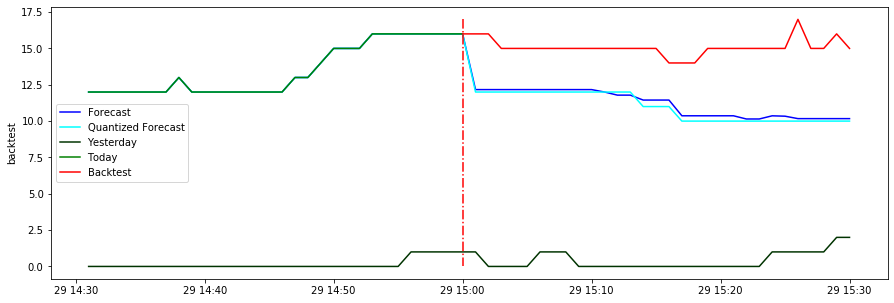

57 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.3530413157434973, 'importance_type': 'gain', 'learning_rate': 0.09821575272447619, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 390, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 18.076225072677552, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 3.818424081242069


[0]	validation_0-rmse:8.89843
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.04909
[2]	validation_0-rmse:7.29264
[3]	validation_0-rmse:6.61186
[4]	validation_0-rmse:5.99871
[5]	validation_0-rmse:5.44844
[6]	validation_0-rmse:4.94106
[7]	validation_0-rmse:4.4962
[8]	validation_0-rmse:4.10243
[9]	validation_0-rmse:3.74548
[10]	validation_0-rmse:3.41374
[11]	validation_0-rmse:3.14334


[235]	validation_0-rmse:0.718705
[236]	validation_0-rmse:0.718779
[237]	validation_0-rmse:0.718827
[238]	validation_0-rmse:0.718855
[239]	validation_0-rmse:0.718876
[240]	validation_0-rmse:0.718894
[241]	validation_0-rmse:0.718926
[242]	validation_0-rmse:0.718901
[243]	validation_0-rmse:0.718904
[244]	validation_0-rmse:0.718921
[245]	validation_0-rmse:0.71892
[246]	validation_0-rmse:0.71892
[247]	validation_0-rmse:0.718911
[248]	validation_0-rmse:0.718939
[249]	validation_0-rmse:0.718995
[250]	validation_0-rmse:0.718953
[251]	validation_0-rmse:0.719042
[252]	validation_0-rmse:0.719002
[253]	validation_0-rmse:0.718901
[254]	validation_0-rmse:0.71893
[255]	validation_0-rmse:0.718879
[256]	validation_0-rmse:0.718934
[257]	validation_0-rmse:0.718816
[258]	validation_0-rmse:0.718607
[259]	validation_0-rmse:0.718568
[260]	validation_0-rmse:0.718587
[261]	validation_0-rmse:0.718556
[262]	validation_0-rmse:0.71858
[263]	validation_0-rmse:0.718549
[264]	validation_0-rmse:0.71847
[265]	validatio

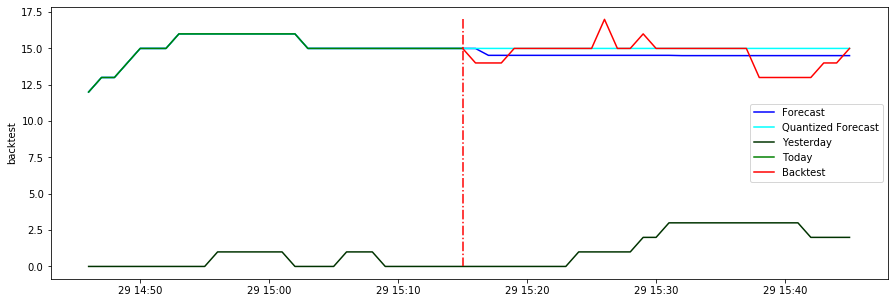

58 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 4.818161714806827, 'importance_type': 'gain', 'learning_rate': 0.22923721009836065, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1150, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 12.900595950565524, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.9984021523996286


[0]	validation_0-rmse:8.82561
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.96503
[2]	validation_0-rmse:7.20126
[3]	validation_0-rmse:6.51192
[4]	validation_0-rmse:5.89399
[5]	validation_0-rmse:5.33056
[6]	validation_0-rmse:4.82955
[7]	validation_0-rmse:4.38175
[8]	validation_0-rmse:3.98002
[9]	validation_0-rmse:3.61298
[10]	validation_0-rmse:3.26869
[11]	validation_0-rmse:2.9822

[234]	validation_0-rmse:0.405392
[235]	validation_0-rmse:0.405239
[236]	validation_0-rmse:0.405247
[237]	validation_0-rmse:0.405268
[238]	validation_0-rmse:0.405258
[239]	validation_0-rmse:0.405241
[240]	validation_0-rmse:0.40522
[241]	validation_0-rmse:0.405237
[242]	validation_0-rmse:0.405154
[243]	validation_0-rmse:0.40509
[244]	validation_0-rmse:0.405073
[245]	validation_0-rmse:0.405039
[246]	validation_0-rmse:0.404942
[247]	validation_0-rmse:0.404934
[248]	validation_0-rmse:0.404961
[249]	validation_0-rmse:0.404992
[250]	validation_0-rmse:0.404911
[251]	validation_0-rmse:0.40485
[252]	validation_0-rmse:0.404809
[253]	validation_0-rmse:0.40467
[254]	validation_0-rmse:0.404714
[255]	validation_0-rmse:0.404613
[256]	validation_0-rmse:0.404575
[257]	validation_0-rmse:0.404605
[258]	validation_0-rmse:0.404589
[259]	validation_0-rmse:0.404515
[260]	validation_0-rmse:0.404521
[261]	validation_0-rmse:0.404526
[262]	validation_0-rmse:0.404521
[263]	validation_0-rmse:0.404489
[264]	validati

[484]	validation_0-rmse:0.401842
[485]	validation_0-rmse:0.40184
[486]	validation_0-rmse:0.401839
[487]	validation_0-rmse:0.401833
[488]	validation_0-rmse:0.401831
[489]	validation_0-rmse:0.40183
[490]	validation_0-rmse:0.401854
[491]	validation_0-rmse:0.401852
[492]	validation_0-rmse:0.401854
[493]	validation_0-rmse:0.401842
[494]	validation_0-rmse:0.401842
[495]	validation_0-rmse:0.401828
[496]	validation_0-rmse:0.40183
[497]	validation_0-rmse:0.401826
[498]	validation_0-rmse:0.401826
[499]	validation_0-rmse:0.401826
[500]	validation_0-rmse:0.401814
[501]	validation_0-rmse:0.401814
[502]	validation_0-rmse:0.401807
[503]	validation_0-rmse:0.40182
[504]	validation_0-rmse:0.401817
[505]	validation_0-rmse:0.401822
[506]	validation_0-rmse:0.401818
[507]	validation_0-rmse:0.401822
[508]	validation_0-rmse:0.401824
[509]	validation_0-rmse:0.401823
[510]	validation_0-rmse:0.401813
[511]	validation_0-rmse:0.401797
[512]	validation_0-rmse:0.401795
[513]	validation_0-rmse:0.401796
[514]	validati

[734]	validation_0-rmse:0.401675
[735]	validation_0-rmse:0.401675
[736]	validation_0-rmse:0.401672
[737]	validation_0-rmse:0.401673
[738]	validation_0-rmse:0.401674
[739]	validation_0-rmse:0.401678
[740]	validation_0-rmse:0.401681
[741]	validation_0-rmse:0.401681
[742]	validation_0-rmse:0.401681
[743]	validation_0-rmse:0.40168
[744]	validation_0-rmse:0.401681
[745]	validation_0-rmse:0.401677
[746]	validation_0-rmse:0.401677
[747]	validation_0-rmse:0.401676
[748]	validation_0-rmse:0.401676
[749]	validation_0-rmse:0.401675
[750]	validation_0-rmse:0.401677
[751]	validation_0-rmse:0.401678
[752]	validation_0-rmse:0.401677
[753]	validation_0-rmse:0.401678
[754]	validation_0-rmse:0.401678
[755]	validation_0-rmse:0.401675
[756]	validation_0-rmse:0.401676
[757]	validation_0-rmse:0.401678
[758]	validation_0-rmse:0.401677
[759]	validation_0-rmse:0.401675
[760]	validation_0-rmse:0.401676
[761]	validation_0-rmse:0.401676
[762]	validation_0-rmse:0.401672
[763]	validation_0-rmse:0.401665
[764]	valid

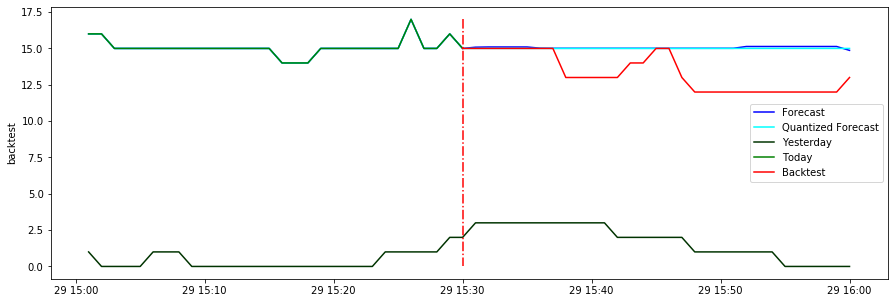

59 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.486563481430256, 'importance_type': 'gain', 'learning_rate': 0.12080721022804736, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 530, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.776355693576215, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.9500136066606397


[0]	validation_0-rmse:9.33048
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.45955
[2]	validation_0-rmse:7.67695
[3]	validation_0-rmse:6.96431
[4]	validation_0-rmse:6.32964
[5]	validation_0-rmse:5.75148
[6]	validation_0-rmse:5.24196
[7]	validation_0-rmse:4.7685
[8]	validation_0-rmse:4.37468
[9]	validation_0-rmse:3.99785
[10]	validation_0-rmse:3.63208
[11]	validation_0-rmse:3.3529
[1

[234]	validation_0-rmse:0.48441
[235]	validation_0-rmse:0.484317
[236]	validation_0-rmse:0.48426
[237]	validation_0-rmse:0.484274
[238]	validation_0-rmse:0.484224
[239]	validation_0-rmse:0.484194
[240]	validation_0-rmse:0.48417
[241]	validation_0-rmse:0.484168
[242]	validation_0-rmse:0.484152
[243]	validation_0-rmse:0.484119
[244]	validation_0-rmse:0.48411
[245]	validation_0-rmse:0.484051
[246]	validation_0-rmse:0.484029
[247]	validation_0-rmse:0.484013
[248]	validation_0-rmse:0.48395
[249]	validation_0-rmse:0.483868
[250]	validation_0-rmse:0.483751
[251]	validation_0-rmse:0.483891
[252]	validation_0-rmse:0.48378
[253]	validation_0-rmse:0.483774
[254]	validation_0-rmse:0.483734
[255]	validation_0-rmse:0.483813
[256]	validation_0-rmse:0.483855
[257]	validation_0-rmse:0.483808
[258]	validation_0-rmse:0.483855
[259]	validation_0-rmse:0.48384
[260]	validation_0-rmse:0.483808
[261]	validation_0-rmse:0.483838
[262]	validation_0-rmse:0.483823
[263]	validation_0-rmse:0.483823
[264]	validation_

[484]	validation_0-rmse:0.482626
[485]	validation_0-rmse:0.482626
[486]	validation_0-rmse:0.482625
[487]	validation_0-rmse:0.482621
[488]	validation_0-rmse:0.482621
[489]	validation_0-rmse:0.482615
[490]	validation_0-rmse:0.482625
[491]	validation_0-rmse:0.482628
[492]	validation_0-rmse:0.482626
[493]	validation_0-rmse:0.482622
[494]	validation_0-rmse:0.482622
[495]	validation_0-rmse:0.482608
[496]	validation_0-rmse:0.482608
[497]	validation_0-rmse:0.482611
[498]	validation_0-rmse:0.482626
[499]	validation_0-rmse:0.482626
[500]	validation_0-rmse:0.482597
[501]	validation_0-rmse:0.482596
[502]	validation_0-rmse:0.482598
[503]	validation_0-rmse:0.482591
[504]	validation_0-rmse:0.482591
[505]	validation_0-rmse:0.482592
[506]	validation_0-rmse:0.482592
[507]	validation_0-rmse:0.482602
[508]	validation_0-rmse:0.482602
[509]	validation_0-rmse:0.482605
[510]	validation_0-rmse:0.48261
[511]	validation_0-rmse:0.482611
[512]	validation_0-rmse:0.482614
[513]	validation_0-rmse:0.482616
[514]	valid

[734]	validation_0-rmse:0.482587
[735]	validation_0-rmse:0.482586
[736]	validation_0-rmse:0.482592
[737]	validation_0-rmse:0.48259
[738]	validation_0-rmse:0.482589
[739]	validation_0-rmse:0.482589
[740]	validation_0-rmse:0.482585
[741]	validation_0-rmse:0.482586
[742]	validation_0-rmse:0.482587
[743]	validation_0-rmse:0.482586
[744]	validation_0-rmse:0.482586
[745]	validation_0-rmse:0.482586
[746]	validation_0-rmse:0.482586
[747]	validation_0-rmse:0.48258
[748]	validation_0-rmse:0.482578
[749]	validation_0-rmse:0.482577
[750]	validation_0-rmse:0.482576
[751]	validation_0-rmse:0.482575
[752]	validation_0-rmse:0.482577
[753]	validation_0-rmse:0.482578
[754]	validation_0-rmse:0.482576
[755]	validation_0-rmse:0.482577
[756]	validation_0-rmse:0.482578
[757]	validation_0-rmse:0.482576
[758]	validation_0-rmse:0.482576
[759]	validation_0-rmse:0.482577
[760]	validation_0-rmse:0.482577
[761]	validation_0-rmse:0.482578
[762]	validation_0-rmse:0.482578
[763]	validation_0-rmse:0.482579
[764]	valida

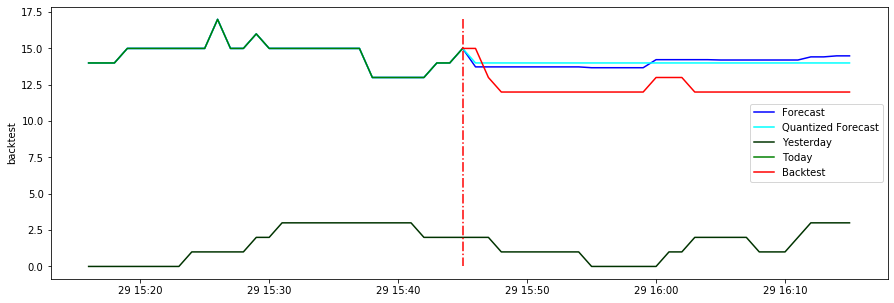

60 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 9.893094073855833, 'importance_type': 'gain', 'learning_rate': 0.18693870695817805, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1310, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 5.019019400612433, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.1224494201930804


[0]	validation_0-rmse:9.01156
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.11378
[2]	validation_0-rmse:7.31694
[3]	validation_0-rmse:6.60427
[4]	validation_0-rmse:5.96002
[5]	validation_0-rmse:5.38394
[6]	validation_0-rmse:4.85565
[7]	validation_0-rmse:4.38866
[8]	validation_0-rmse:3.99704
[9]	validation_0-rmse:3.6216
[10]	validation_0-rmse:3.2798
[11]	validation_0-rmse:2.99578
[

[234]	validation_0-rmse:0.358158
[235]	validation_0-rmse:0.358136
[236]	validation_0-rmse:0.358122
[237]	validation_0-rmse:0.358104
[238]	validation_0-rmse:0.358026
[239]	validation_0-rmse:0.358022
[240]	validation_0-rmse:0.358007
[241]	validation_0-rmse:0.358013
[242]	validation_0-rmse:0.358039
[243]	validation_0-rmse:0.358131
[244]	validation_0-rmse:0.358115
[245]	validation_0-rmse:0.358079
[246]	validation_0-rmse:0.358146
[247]	validation_0-rmse:0.358144
[248]	validation_0-rmse:0.358115
[249]	validation_0-rmse:0.358366
[250]	validation_0-rmse:0.358453
[251]	validation_0-rmse:0.35845
[252]	validation_0-rmse:0.358473
[253]	validation_0-rmse:0.358529
[254]	validation_0-rmse:0.358588
[255]	validation_0-rmse:0.358619
[256]	validation_0-rmse:0.358658
[257]	validation_0-rmse:0.358661
[258]	validation_0-rmse:0.358559
[259]	validation_0-rmse:0.358558
[260]	validation_0-rmse:0.358559
[261]	validation_0-rmse:0.358542
[262]	validation_0-rmse:0.358527
[263]	validation_0-rmse:0.358539
[264]	valid

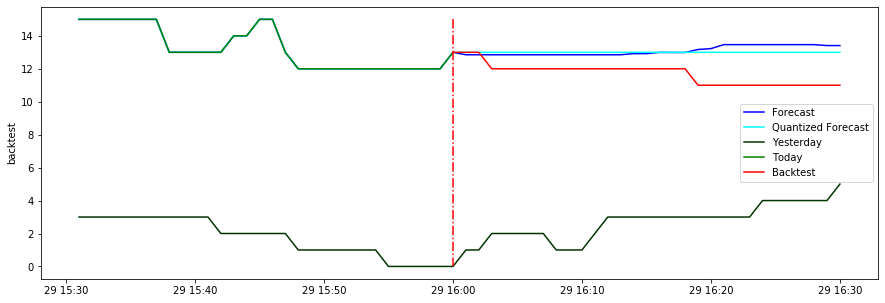

61 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 4.917535122384468, 'importance_type': 'gain', 'learning_rate': 0.055930178485450455, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 950, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.637594726209366, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.8593836202914638


[0]	validation_0-rmse:9.33002
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.42647
[2]	validation_0-rmse:7.60918
[3]	validation_0-rmse:6.87961
[4]	validation_0-rmse:6.21988
[5]	validation_0-rmse:5.62529
[6]	validation_0-rmse:5.0937
[7]	validation_0-rmse:4.60567
[8]	validation_0-rmse:4.18422
[9]	validation_0-rmse:3.80266
[10]	validation_0-rmse:3.44409
[11]	validation_0-rmse:3.1406
[

[234]	validation_0-rmse:0.323535
[235]	validation_0-rmse:0.323387
[236]	validation_0-rmse:0.323338
[237]	validation_0-rmse:0.323317
[238]	validation_0-rmse:0.323276
[239]	validation_0-rmse:0.323296
[240]	validation_0-rmse:0.323303
[241]	validation_0-rmse:0.32336
[242]	validation_0-rmse:0.323343
[243]	validation_0-rmse:0.32331
[244]	validation_0-rmse:0.323295
[245]	validation_0-rmse:0.323276
[246]	validation_0-rmse:0.323254
[247]	validation_0-rmse:0.323225
[248]	validation_0-rmse:0.323417
[249]	validation_0-rmse:0.323432
[250]	validation_0-rmse:0.323485
[251]	validation_0-rmse:0.323665
[252]	validation_0-rmse:0.323716
[253]	validation_0-rmse:0.323676
[254]	validation_0-rmse:0.323712
[255]	validation_0-rmse:0.323794
[256]	validation_0-rmse:0.323844
[257]	validation_0-rmse:0.323815
[258]	validation_0-rmse:0.323865
[259]	validation_0-rmse:0.323915
[260]	validation_0-rmse:0.323938
[261]	validation_0-rmse:0.323922
[262]	validation_0-rmse:0.323968
[263]	validation_0-rmse:0.323988
[264]	valida

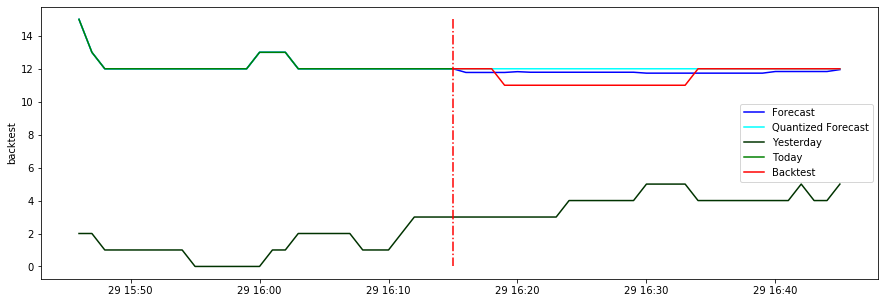

62 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 7.598936088493133, 'importance_type': 'gain', 'learning_rate': 0.11365546884707534, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.837438414152551, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.593092974481403


[0]	validation_0-rmse:9.4842
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.55458
[2]	validation_0-rmse:7.73213
[3]	validation_0-rmse:6.98093
[4]	validation_0-rmse:6.31408
[5]	validation_0-rmse:5.70552
[6]	validation_0-rmse:5.16462
[7]	validation_0-rmse:4.67776
[8]	validation_0-rmse:4.23756
[9]	validation_0-rmse:3.84821
[10]	validation_0-rmse:3.48729
[11]	validation_0-rmse:3.17965
[1

[234]	validation_0-rmse:0.351679
[235]	validation_0-rmse:0.35162
[236]	validation_0-rmse:0.351477
[237]	validation_0-rmse:0.351473
[238]	validation_0-rmse:0.351481
[239]	validation_0-rmse:0.351493
[240]	validation_0-rmse:0.351535
[241]	validation_0-rmse:0.351524
[242]	validation_0-rmse:0.351475
[243]	validation_0-rmse:0.3513
[244]	validation_0-rmse:0.351315
[245]	validation_0-rmse:0.351219
[246]	validation_0-rmse:0.351224
[247]	validation_0-rmse:0.351224
[248]	validation_0-rmse:0.351278
[249]	validation_0-rmse:0.351445
[250]	validation_0-rmse:0.351543
[251]	validation_0-rmse:0.351544
[252]	validation_0-rmse:0.351491
[253]	validation_0-rmse:0.351575
[254]	validation_0-rmse:0.351627
[255]	validation_0-rmse:0.351688
[256]	validation_0-rmse:0.351512
[257]	validation_0-rmse:0.351486
[258]	validation_0-rmse:0.351363
[259]	validation_0-rmse:0.351313
[260]	validation_0-rmse:0.351319
[261]	validation_0-rmse:0.351328
[262]	validation_0-rmse:0.351353
[263]	validation_0-rmse:0.351358
[264]	validat

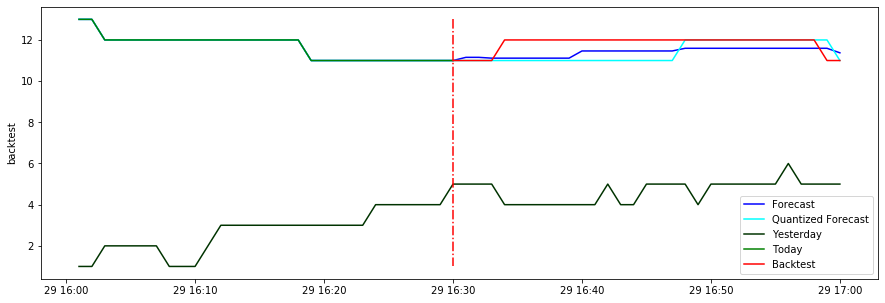

63 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.087149763830406, 'importance_type': 'gain', 'learning_rate': 0.18899246245121468, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1340, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 11.521100783113495, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.8230996265473475


[0]	validation_0-rmse:9.57742
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8.62326
[2]	validation_0-rmse:7.77554
[3]	validation_0-rmse:7.01444
[4]	validation_0-rmse:6.3236
[5]	validation_0-rmse:5.70759
[6]	validation_0-rmse:5.14577
[7]	validation_0-rmse:4.64017
[8]	validation_0-rmse:4.19447
[9]	validation_0-rmse:3.79113
[10]	validation_0-rmse:3.42058
[11]	validation_0-rmse:3.1503


[235]	validation_0-rmse:0.326031
[236]	validation_0-rmse:0.326029
[237]	validation_0-rmse:0.32602
[238]	validation_0-rmse:0.326
[239]	validation_0-rmse:0.325986
[240]	validation_0-rmse:0.325994
[241]	validation_0-rmse:0.325996
[242]	validation_0-rmse:0.325826
[243]	validation_0-rmse:0.325903
[244]	validation_0-rmse:0.325906
[245]	validation_0-rmse:0.325934
[246]	validation_0-rmse:0.325922
[247]	validation_0-rmse:0.325914
[248]	validation_0-rmse:0.325926
[249]	validation_0-rmse:0.32595
[250]	validation_0-rmse:0.325955
[251]	validation_0-rmse:0.325969
[252]	validation_0-rmse:0.325915
[253]	validation_0-rmse:0.325812
[254]	validation_0-rmse:0.325879
[255]	validation_0-rmse:0.325956
[256]	validation_0-rmse:0.326067
[257]	validation_0-rmse:0.326138
[258]	validation_0-rmse:0.326237
[259]	validation_0-rmse:0.326233
[260]	validation_0-rmse:0.326204
[261]	validation_0-rmse:0.32621
[262]	validation_0-rmse:0.326223
[263]	validation_0-rmse:0.326227
[264]	validation_0-rmse:0.326382
[265]	validation

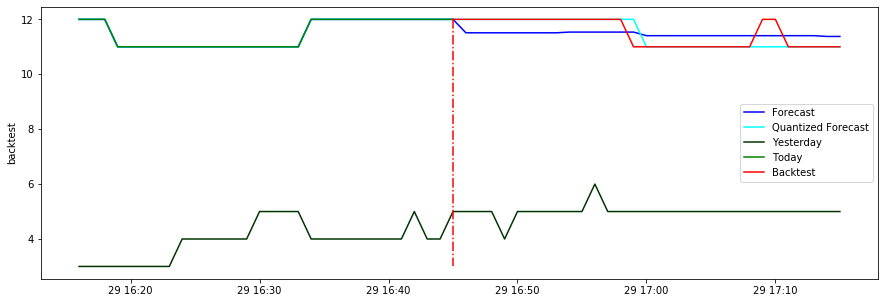

64 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 6.832445058266775, 'importance_type': 'gain', 'learning_rate': 0.04702346855889013, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 80, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.05520071419580811, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.6483481730330668


[0]	validation_0-rmse:10.3429
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:9.34781
[2]	validation_0-rmse:8.44747
[3]	validation_0-rmse:7.64623
[4]	validation_0-rmse:6.91791
[5]	validation_0-rmse:6.26248
[6]	validation_0-rmse:5.67975
[7]	validation_0-rmse:5.13627
[8]	validation_0-rmse:4.67414
[9]	validation_0-rmse:4.24355
[10]	validation_0-rmse:3.83646
[11]	validation_0-rmse:3.50574

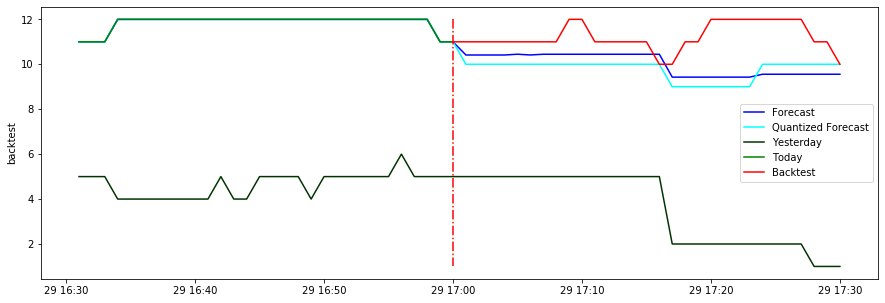

65 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.7536086203073897, 'importance_type': 'gain', 'learning_rate': 0.03918569057496696, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.4449531370889638, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.6107014447526402


[0]	validation_0-rmse:10.7278
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:9.69916
[2]	validation_0-rmse:8.77142
[3]	validation_0-rmse:7.93923
[4]	validation_0-rmse:7.17792
[5]	validation_0-rmse:6.49238
[6]	validation_0-rmse:5.89822
[7]	validation_0-rmse:5.35094
[8]	validation_0-rmse:4.88161
[9]	validation_0-rmse:4.44051
[10]	validation_0-rmse:4.02387
[11]	validation_0-rmse:3.678

[234]	validation_0-rmse:0.670681
[235]	validation_0-rmse:0.670682
[236]	validation_0-rmse:0.670685
[237]	validation_0-rmse:0.670658
[238]	validation_0-rmse:0.670634
[239]	validation_0-rmse:0.670678
[240]	validation_0-rmse:0.670686
[241]	validation_0-rmse:0.670662
[242]	validation_0-rmse:0.670661
[243]	validation_0-rmse:0.670669
[244]	validation_0-rmse:0.670641
[245]	validation_0-rmse:0.670685
[246]	validation_0-rmse:0.670635
[247]	validation_0-rmse:0.67063
[248]	validation_0-rmse:0.670615
[249]	validation_0-rmse:0.67062
[250]	validation_0-rmse:0.670538
[251]	validation_0-rmse:0.670451
[252]	validation_0-rmse:0.670449
[253]	validation_0-rmse:0.670297
[254]	validation_0-rmse:0.670496
[255]	validation_0-rmse:0.670344
[256]	validation_0-rmse:0.670403
[257]	validation_0-rmse:0.670439
[258]	validation_0-rmse:0.67053
[259]	validation_0-rmse:0.67052
[260]	validation_0-rmse:0.670525
[261]	validation_0-rmse:0.670526
[262]	validation_0-rmse:0.67052
[263]	validation_0-rmse:0.670549
[264]	validatio

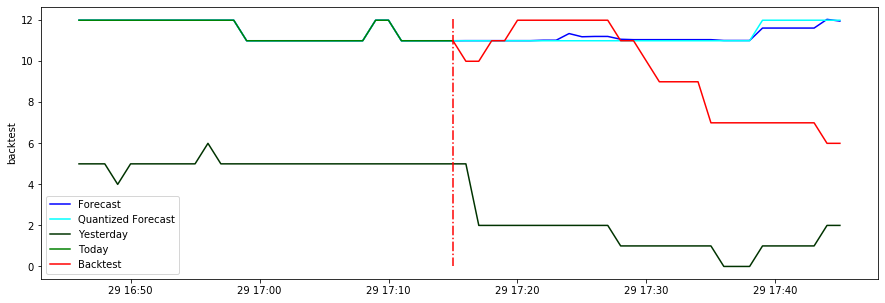

66 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 8.486627514362873, 'importance_type': 'gain', 'learning_rate': 0.12708291317984977, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1410, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.4868355061355167, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.8367603087448057


[0]	validation_0-rmse:11.2532
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.1583
[2]	validation_0-rmse:9.19629
[3]	validation_0-rmse:8.31391
[4]	validation_0-rmse:7.54315
[5]	validation_0-rmse:6.85311
[6]	validation_0-rmse:6.23389
[7]	validation_0-rmse:5.65597
[8]	validation_0-rmse:5.1638
[9]	validation_0-rmse:4.71382
[10]	validation_0-rmse:4.27118
[11]	validation_0-rmse:3.9115


[234]	validation_0-rmse:0.604933
[235]	validation_0-rmse:0.605025
[236]	validation_0-rmse:0.605043
[237]	validation_0-rmse:0.605038
[238]	validation_0-rmse:0.605064
[239]	validation_0-rmse:0.60507
[240]	validation_0-rmse:0.605069
[241]	validation_0-rmse:0.605085
[242]	validation_0-rmse:0.605111
[243]	validation_0-rmse:0.605131
[244]	validation_0-rmse:0.605141
[245]	validation_0-rmse:0.605143
[246]	validation_0-rmse:0.605116
[247]	validation_0-rmse:0.605111
[248]	validation_0-rmse:0.605128
[249]	validation_0-rmse:0.605175
[250]	validation_0-rmse:0.605161
[251]	validation_0-rmse:0.605179
[252]	validation_0-rmse:0.605223
[253]	validation_0-rmse:0.60509
[254]	validation_0-rmse:0.605072
[255]	validation_0-rmse:0.605317
[256]	validation_0-rmse:0.605271
[257]	validation_0-rmse:0.605257
[258]	validation_0-rmse:0.605431
[259]	validation_0-rmse:0.605455
[260]	validation_0-rmse:0.605469
[261]	validation_0-rmse:0.605493
[262]	validation_0-rmse:0.605476
[263]	validation_0-rmse:0.605468
[264]	valida

[483]	validation_0-rmse:0.603387
[484]	validation_0-rmse:0.60338
[485]	validation_0-rmse:0.603378
[486]	validation_0-rmse:0.603378
[487]	validation_0-rmse:0.603378
[488]	validation_0-rmse:0.603378
[489]	validation_0-rmse:0.603365
[490]	validation_0-rmse:0.60334
[491]	validation_0-rmse:0.603348
[492]	validation_0-rmse:0.603348
[493]	validation_0-rmse:0.603341
[494]	validation_0-rmse:0.603341
[495]	validation_0-rmse:0.603338
[496]	validation_0-rmse:0.603339
[497]	validation_0-rmse:0.603339
[498]	validation_0-rmse:0.603338
[499]	validation_0-rmse:0.603338
[500]	validation_0-rmse:0.603324
[501]	validation_0-rmse:0.603327
[502]	validation_0-rmse:0.603303
[503]	validation_0-rmse:0.603299
[504]	validation_0-rmse:0.603298
[505]	validation_0-rmse:0.603303
[506]	validation_0-rmse:0.603301
[507]	validation_0-rmse:0.603303
[508]	validation_0-rmse:0.603297
[509]	validation_0-rmse:0.603296
[510]	validation_0-rmse:0.603297
[511]	validation_0-rmse:0.603303
[512]	validation_0-rmse:0.6033
[513]	validati

[733]	validation_0-rmse:0.603168
[734]	validation_0-rmse:0.603167
[735]	validation_0-rmse:0.603167
[736]	validation_0-rmse:0.603165
[737]	validation_0-rmse:0.603166
[738]	validation_0-rmse:0.603166
[739]	validation_0-rmse:0.603166
[740]	validation_0-rmse:0.60317
[741]	validation_0-rmse:0.603171
[742]	validation_0-rmse:0.603168
[743]	validation_0-rmse:0.603168
Stopping. Best iteration:
[643]	validation_0-rmse:0.603149



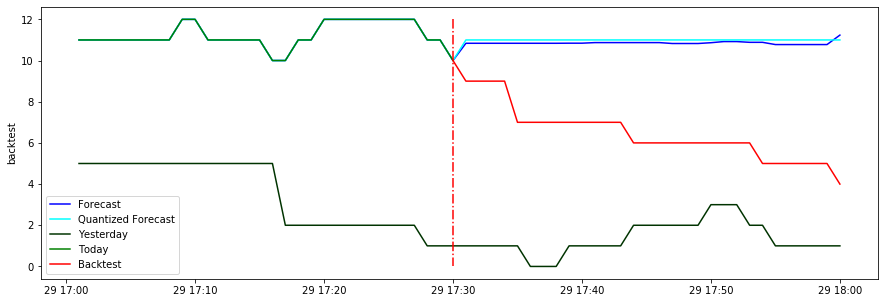

67 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.222255391692649, 'importance_type': 'gain', 'learning_rate': 0.2898741629137019, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.590343854795593, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 4.951651251009138


[0]	validation_0-rmse:11.7641
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.6577
[2]	validation_0-rmse:9.65236
[3]	validation_0-rmse:8.7522
[4]	validation_0-rmse:7.92902
[5]	validation_0-rmse:7.19499
[6]	validation_0-rmse:6.523
[7]	validation_0-rmse:5.91761
[8]	validation_0-rmse:5.42127
[9]	validation_0-rmse:4.94304
[10]	validation_0-rmse:4.48969
[11]	validation_0-rmse:4.12723
[12]

[234]	validation_0-rmse:0.503224
[235]	validation_0-rmse:0.503225
[236]	validation_0-rmse:0.503162
[237]	validation_0-rmse:0.503121
[238]	validation_0-rmse:0.503149
[239]	validation_0-rmse:0.503143
[240]	validation_0-rmse:0.503173
[241]	validation_0-rmse:0.503186
[242]	validation_0-rmse:0.503302
[243]	validation_0-rmse:0.503202
[244]	validation_0-rmse:0.503241
[245]	validation_0-rmse:0.503212
[246]	validation_0-rmse:0.50319
[247]	validation_0-rmse:0.503237
[248]	validation_0-rmse:0.503223
[249]	validation_0-rmse:0.503215
[250]	validation_0-rmse:0.503168
[251]	validation_0-rmse:0.503171
[252]	validation_0-rmse:0.50316
[253]	validation_0-rmse:0.502953
[254]	validation_0-rmse:0.502958
[255]	validation_0-rmse:0.502904
[256]	validation_0-rmse:0.503109
[257]	validation_0-rmse:0.503133
[258]	validation_0-rmse:0.502967
[259]	validation_0-rmse:0.502905
[260]	validation_0-rmse:0.502903
[261]	validation_0-rmse:0.502939
[262]	validation_0-rmse:0.502883
[263]	validation_0-rmse:0.502907
[264]	valida

[484]	validation_0-rmse:0.502032
[485]	validation_0-rmse:0.502031
[486]	validation_0-rmse:0.502033
[487]	validation_0-rmse:0.502042
[488]	validation_0-rmse:0.502042
[489]	validation_0-rmse:0.502043
[490]	validation_0-rmse:0.502036
[491]	validation_0-rmse:0.502037
[492]	validation_0-rmse:0.502037
[493]	validation_0-rmse:0.50205
[494]	validation_0-rmse:0.502048
[495]	validation_0-rmse:0.502057
[496]	validation_0-rmse:0.502056
[497]	validation_0-rmse:0.502057
[498]	validation_0-rmse:0.50206
[499]	validation_0-rmse:0.502061
[500]	validation_0-rmse:0.502061
[501]	validation_0-rmse:0.50206
[502]	validation_0-rmse:0.502069
[503]	validation_0-rmse:0.502072
[504]	validation_0-rmse:0.50207
[505]	validation_0-rmse:0.50207
[506]	validation_0-rmse:0.502078
[507]	validation_0-rmse:0.502082
[508]	validation_0-rmse:0.502092
[509]	validation_0-rmse:0.502095
[510]	validation_0-rmse:0.502095
[511]	validation_0-rmse:0.502096
[512]	validation_0-rmse:0.502095
[513]	validation_0-rmse:0.502098
[514]	validatio

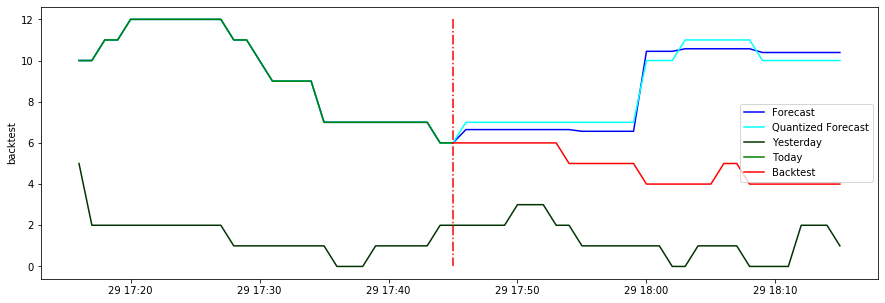

68 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.425005619762469, 'importance_type': 'gain', 'learning_rate': 0.11644262245597833, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1190, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.158058228926841, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 4.924307147630921


[0]	validation_0-rmse:12.1218
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.9564
[2]	validation_0-rmse:9.90213
[3]	validation_0-rmse:8.95575
[4]	validation_0-rmse:8.1057
[5]	validation_0-rmse:7.33886
[6]	validation_0-rmse:6.639
[7]	validation_0-rmse:6.01521
[8]	validation_0-rmse:5.49344
[9]	validation_0-rmse:4.9851
[10]	validation_0-rmse:4.51363
[11]	validation_0-rmse:4.1292
[12]	

[234]	validation_0-rmse:0.55646
[235]	validation_0-rmse:0.556454
[236]	validation_0-rmse:0.556342
[237]	validation_0-rmse:0.556348
[238]	validation_0-rmse:0.556301
[239]	validation_0-rmse:0.55631
[240]	validation_0-rmse:0.556353
[241]	validation_0-rmse:0.556337
[242]	validation_0-rmse:0.556354
[243]	validation_0-rmse:0.556455
[244]	validation_0-rmse:0.556441
[245]	validation_0-rmse:0.556468
[246]	validation_0-rmse:0.556375
[247]	validation_0-rmse:0.556385
[248]	validation_0-rmse:0.556511
[249]	validation_0-rmse:0.556522
[250]	validation_0-rmse:0.556463
[251]	validation_0-rmse:0.556543
[252]	validation_0-rmse:0.556493
[253]	validation_0-rmse:0.556389
[254]	validation_0-rmse:0.556268
[255]	validation_0-rmse:0.556109
[256]	validation_0-rmse:0.555918
[257]	validation_0-rmse:0.55594
[258]	validation_0-rmse:0.5559
[259]	validation_0-rmse:0.555886
[260]	validation_0-rmse:0.555884
[261]	validation_0-rmse:0.555878
[262]	validation_0-rmse:0.555871
[263]	validation_0-rmse:0.555858
[264]	validatio

[484]	validation_0-rmse:0.553406
[485]	validation_0-rmse:0.553406
[486]	validation_0-rmse:0.553406
[487]	validation_0-rmse:0.553403
[488]	validation_0-rmse:0.553402
[489]	validation_0-rmse:0.553401
[490]	validation_0-rmse:0.553391
[491]	validation_0-rmse:0.553376
[492]	validation_0-rmse:0.553376
[493]	validation_0-rmse:0.553365
[494]	validation_0-rmse:0.553365
[495]	validation_0-rmse:0.553345
[496]	validation_0-rmse:0.553347
[497]	validation_0-rmse:0.553347
[498]	validation_0-rmse:0.553355
[499]	validation_0-rmse:0.553352
[500]	validation_0-rmse:0.553351
[501]	validation_0-rmse:0.553344
[502]	validation_0-rmse:0.553319
[503]	validation_0-rmse:0.553323
[504]	validation_0-rmse:0.553324
[505]	validation_0-rmse:0.553321
[506]	validation_0-rmse:0.55331
[507]	validation_0-rmse:0.553313
[508]	validation_0-rmse:0.553303
[509]	validation_0-rmse:0.553304
[510]	validation_0-rmse:0.553292
[511]	validation_0-rmse:0.553294
[512]	validation_0-rmse:0.553291
[513]	validation_0-rmse:0.553289
[514]	valid

[733]	validation_0-rmse:0.553199
[734]	validation_0-rmse:0.553199
[735]	validation_0-rmse:0.553199
[736]	validation_0-rmse:0.5532
[737]	validation_0-rmse:0.553199
[738]	validation_0-rmse:0.5532
[739]	validation_0-rmse:0.5532
[740]	validation_0-rmse:0.553199
[741]	validation_0-rmse:0.5532
[742]	validation_0-rmse:0.553202
[743]	validation_0-rmse:0.553202
[744]	validation_0-rmse:0.553203
[745]	validation_0-rmse:0.553208
[746]	validation_0-rmse:0.55321
[747]	validation_0-rmse:0.553204
[748]	validation_0-rmse:0.553203
[749]	validation_0-rmse:0.553203
[750]	validation_0-rmse:0.553203
[751]	validation_0-rmse:0.553202
[752]	validation_0-rmse:0.553203
[753]	validation_0-rmse:0.553205
[754]	validation_0-rmse:0.553205
[755]	validation_0-rmse:0.553205
[756]	validation_0-rmse:0.553205
[757]	validation_0-rmse:0.553205
[758]	validation_0-rmse:0.553206
[759]	validation_0-rmse:0.553206
[760]	validation_0-rmse:0.553206
[761]	validation_0-rmse:0.553205
[762]	validation_0-rmse:0.553205
[763]	validation_0-

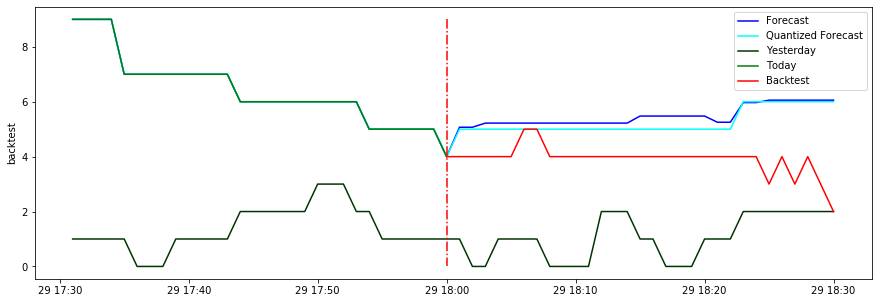

69 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 4.299860502024222, 'importance_type': 'gain', 'learning_rate': 0.02949959715571928, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 850, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 11.1971107060612, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.2609764484010157


[0]	validation_0-rmse:12.6055
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.4024
[2]	validation_0-rmse:10.3172
[3]	validation_0-rmse:9.33321
[4]	validation_0-rmse:8.43255
[5]	validation_0-rmse:7.62185
[6]	validation_0-rmse:6.89623
[7]	validation_0-rmse:6.23885
[8]	validation_0-rmse:5.68378
[9]	validation_0-rmse:5.15415
[10]	validation_0-rmse:4.65236
[11]	validation_0-rmse:4.25385
[

[235]	validation_0-rmse:0.508469
[236]	validation_0-rmse:0.508504
[237]	validation_0-rmse:0.508499
[238]	validation_0-rmse:0.508586
[239]	validation_0-rmse:0.508592
[240]	validation_0-rmse:0.508596
[241]	validation_0-rmse:0.508621
[242]	validation_0-rmse:0.508591
[243]	validation_0-rmse:0.508612
[244]	validation_0-rmse:0.508624
[245]	validation_0-rmse:0.508602
[246]	validation_0-rmse:0.508521
[247]	validation_0-rmse:0.508526
[248]	validation_0-rmse:0.50851
[249]	validation_0-rmse:0.508438
[250]	validation_0-rmse:0.508337
[251]	validation_0-rmse:0.508349
[252]	validation_0-rmse:0.508378
[253]	validation_0-rmse:0.508561
[254]	validation_0-rmse:0.508754
[255]	validation_0-rmse:0.508754
[256]	validation_0-rmse:0.50885
[257]	validation_0-rmse:0.508925
[258]	validation_0-rmse:0.509011
[259]	validation_0-rmse:0.508998
[260]	validation_0-rmse:0.508995
[261]	validation_0-rmse:0.509003
[262]	validation_0-rmse:0.509025
[263]	validation_0-rmse:0.50903
[264]	validation_0-rmse:0.509076
[265]	validat

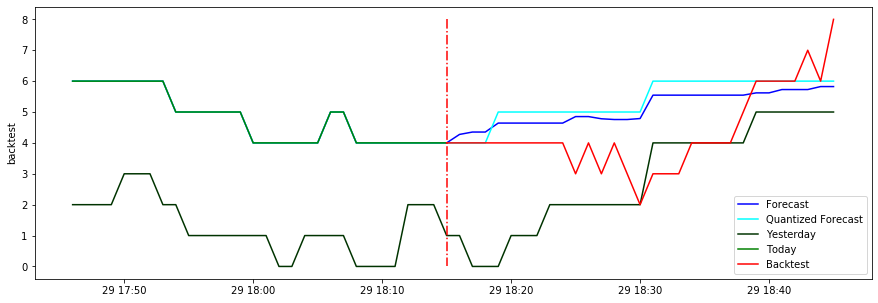

70 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.6389783308071062, 'importance_type': 'gain', 'learning_rate': 0.22534269128264364, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1930, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.733809407697384, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.2818247896924195


[0]	validation_0-rmse:13.2283
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.9864
[2]	validation_0-rmse:10.8448
[3]	validation_0-rmse:9.831
[4]	validation_0-rmse:8.90455
[5]	validation_0-rmse:8.06116
[6]	validation_0-rmse:7.31361
[7]	validation_0-rmse:6.62732
[8]	validation_0-rmse:6.03803
[9]	validation_0-rmse:5.47922
[10]	validation_0-rmse:4.96277
[11]	validation_0-rmse:4.56831


[234]	validation_0-rmse:0.453843
[235]	validation_0-rmse:0.453635
[236]	validation_0-rmse:0.453659
[237]	validation_0-rmse:0.453644
[238]	validation_0-rmse:0.453759
[239]	validation_0-rmse:0.453774
[240]	validation_0-rmse:0.453798
[241]	validation_0-rmse:0.453784
[242]	validation_0-rmse:0.453737
[243]	validation_0-rmse:0.453805
[244]	validation_0-rmse:0.453792
[245]	validation_0-rmse:0.453779
[246]	validation_0-rmse:0.453824
[247]	validation_0-rmse:0.453784
[248]	validation_0-rmse:0.453742
[249]	validation_0-rmse:0.453539
[250]	validation_0-rmse:0.453698
[251]	validation_0-rmse:0.453697
[252]	validation_0-rmse:0.453639
[253]	validation_0-rmse:0.453674
[254]	validation_0-rmse:0.453583
[255]	validation_0-rmse:0.453601
[256]	validation_0-rmse:0.453533
[257]	validation_0-rmse:0.453573
[258]	validation_0-rmse:0.45365
[259]	validation_0-rmse:0.453652
[260]	validation_0-rmse:0.453668
[261]	validation_0-rmse:0.453664
[262]	validation_0-rmse:0.453567
[263]	validation_0-rmse:0.45356
[264]	valida

[483]	validation_0-rmse:0.451164
[484]	validation_0-rmse:0.451171
[485]	validation_0-rmse:0.451171
[486]	validation_0-rmse:0.451165
[487]	validation_0-rmse:0.45116
[488]	validation_0-rmse:0.451162
[489]	validation_0-rmse:0.451166
[490]	validation_0-rmse:0.451163
[491]	validation_0-rmse:0.451157
[492]	validation_0-rmse:0.451157
[493]	validation_0-rmse:0.451159
[494]	validation_0-rmse:0.451156
[495]	validation_0-rmse:0.451157
[496]	validation_0-rmse:0.451156
[497]	validation_0-rmse:0.451155
[498]	validation_0-rmse:0.451158
[499]	validation_0-rmse:0.451155
[500]	validation_0-rmse:0.45115
[501]	validation_0-rmse:0.451152
[502]	validation_0-rmse:0.451119
[503]	validation_0-rmse:0.451117
[504]	validation_0-rmse:0.451116
[505]	validation_0-rmse:0.451114
[506]	validation_0-rmse:0.451112
[507]	validation_0-rmse:0.451109
[508]	validation_0-rmse:0.451101
[509]	validation_0-rmse:0.4511
[510]	validation_0-rmse:0.451104
[511]	validation_0-rmse:0.451093
[512]	validation_0-rmse:0.451081
[513]	validati

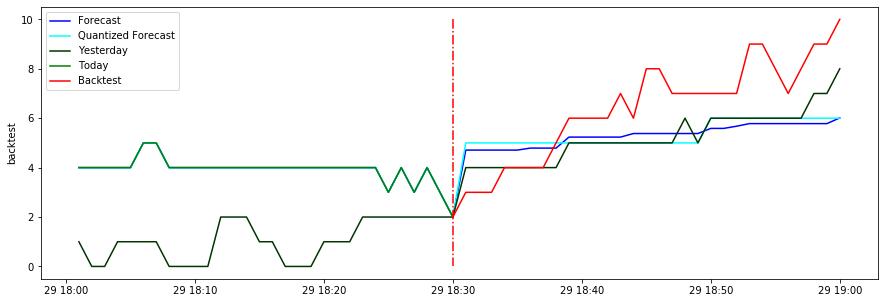

71 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.594948906278338, 'importance_type': 'gain', 'learning_rate': 0.2848043356611661, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 130, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 12.469753003744596, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.9556621481186678


[0]	validation_0-rmse:13.4095
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:12.0964
[2]	validation_0-rmse:10.9163
[3]	validation_0-rmse:9.8235
[4]	validation_0-rmse:8.83856
[5]	validation_0-rmse:7.95704
[6]	validation_0-rmse:7.16181
[7]	validation_0-rmse:6.4502
[8]	validation_0-rmse:5.87582
[9]	validation_0-rmse:5.28501
[10]	validation_0-rmse:4.7642
[11]	validation_0-rmse:4.33121
[12

[234]	validation_0-rmse:0.478712
[235]	validation_0-rmse:0.478677
[236]	validation_0-rmse:0.478632
[237]	validation_0-rmse:0.478627
[238]	validation_0-rmse:0.478585
[239]	validation_0-rmse:0.478621
[240]	validation_0-rmse:0.478589
[241]	validation_0-rmse:0.478634
[242]	validation_0-rmse:0.478563
[243]	validation_0-rmse:0.478903
[244]	validation_0-rmse:0.478915
[245]	validation_0-rmse:0.478908
[246]	validation_0-rmse:0.478867
[247]	validation_0-rmse:0.47886
[248]	validation_0-rmse:0.478774
[249]	validation_0-rmse:0.478982
[250]	validation_0-rmse:0.478804
[251]	validation_0-rmse:0.47886
[252]	validation_0-rmse:0.478835
[253]	validation_0-rmse:0.478741
[254]	validation_0-rmse:0.478542
[255]	validation_0-rmse:0.478515
[256]	validation_0-rmse:0.478577
[257]	validation_0-rmse:0.478516
[258]	validation_0-rmse:0.478517
[259]	validation_0-rmse:0.478524
[260]	validation_0-rmse:0.478514
[261]	validation_0-rmse:0.478497
[262]	validation_0-rmse:0.478542
[263]	validation_0-rmse:0.478523
[264]	valida

[484]	validation_0-rmse:0.476655
[485]	validation_0-rmse:0.476654
[486]	validation_0-rmse:0.476654
[487]	validation_0-rmse:0.476653
[488]	validation_0-rmse:0.476653
[489]	validation_0-rmse:0.476658
[490]	validation_0-rmse:0.476658
[491]	validation_0-rmse:0.476659
[492]	validation_0-rmse:0.476661
[493]	validation_0-rmse:0.476638
[494]	validation_0-rmse:0.476636
[495]	validation_0-rmse:0.476635
[496]	validation_0-rmse:0.476635
[497]	validation_0-rmse:0.476633
[498]	validation_0-rmse:0.476624
[499]	validation_0-rmse:0.476627
[500]	validation_0-rmse:0.476623
[501]	validation_0-rmse:0.476624
[502]	validation_0-rmse:0.47662
[503]	validation_0-rmse:0.476627
[504]	validation_0-rmse:0.476628
[505]	validation_0-rmse:0.476628
[506]	validation_0-rmse:0.476632
[507]	validation_0-rmse:0.476639
[508]	validation_0-rmse:0.476639
[509]	validation_0-rmse:0.476641
[510]	validation_0-rmse:0.476647
[511]	validation_0-rmse:0.476649
[512]	validation_0-rmse:0.476646
[513]	validation_0-rmse:0.476645
[514]	valid

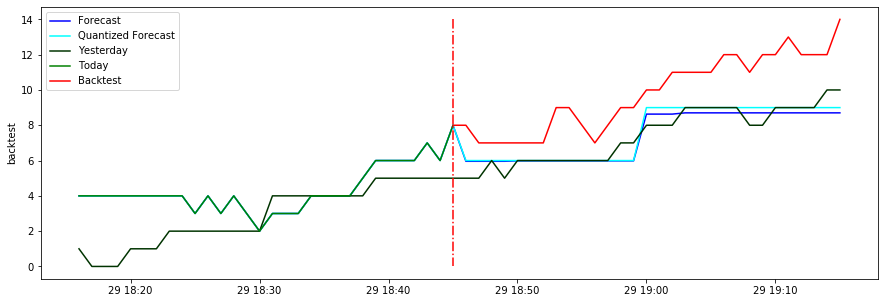

72 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.0581145204087683, 'importance_type': 'gain', 'learning_rate': 0.12603759979562093, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1440, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 13.172410024719964, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.536171349243918


[0]	validation_0-rmse:14.453
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:13.1088
[2]	validation_0-rmse:11.9066
[3]	validation_0-rmse:10.8036
[4]	validation_0-rmse:9.77937
[5]	validation_0-rmse:8.84948
[6]	validation_0-rmse:8.05292
[7]	validation_0-rmse:7.31706
[8]	validation_0-rmse:6.68016
[9]	validation_0-rmse:6.07313
[10]	validation_0-rmse:5.53014
[11]	validation_0-rmse:5.0681


[235]	validation_0-rmse:0.54182
[236]	validation_0-rmse:0.54171
[237]	validation_0-rmse:0.541708
[238]	validation_0-rmse:0.541602
[239]	validation_0-rmse:0.541596
[240]	validation_0-rmse:0.541597
[241]	validation_0-rmse:0.541608
[242]	validation_0-rmse:0.541612
[243]	validation_0-rmse:0.541662
[244]	validation_0-rmse:0.541659
[245]	validation_0-rmse:0.541675
[246]	validation_0-rmse:0.541655
[247]	validation_0-rmse:0.541622
[248]	validation_0-rmse:0.541412
[249]	validation_0-rmse:0.541592
[250]	validation_0-rmse:0.541675
[251]	validation_0-rmse:0.541706
[252]	validation_0-rmse:0.541706
[253]	validation_0-rmse:0.541648
[254]	validation_0-rmse:0.541747
[255]	validation_0-rmse:0.541735
[256]	validation_0-rmse:0.54184
[257]	validation_0-rmse:0.541898
[258]	validation_0-rmse:0.541998
[259]	validation_0-rmse:0.542035
[260]	validation_0-rmse:0.542053
[261]	validation_0-rmse:0.542054
[262]	validation_0-rmse:0.542107
[263]	validation_0-rmse:0.542101
[264]	validation_0-rmse:0.542083
[265]	validat

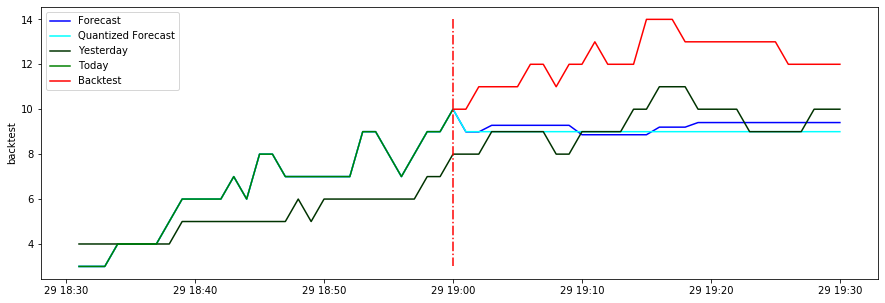

73 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.530488184075306, 'importance_type': 'gain', 'learning_rate': 0.2540483610447828, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1400, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 10.583217488719352, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 2.45188909344707


[0]	validation_0-rmse:14.2958
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:12.8812
[2]	validation_0-rmse:11.6094
[3]	validation_0-rmse:10.4745
[4]	validation_0-rmse:9.45149
[5]	validation_0-rmse:8.53124
[6]	validation_0-rmse:7.69277
[7]	validation_0-rmse:6.95748
[8]	validation_0-rmse:6.2868
[9]	validation_0-rmse:5.66738
[10]	validation_0-rmse:5.09699
[11]	validation_0-rmse:4.62566
[1

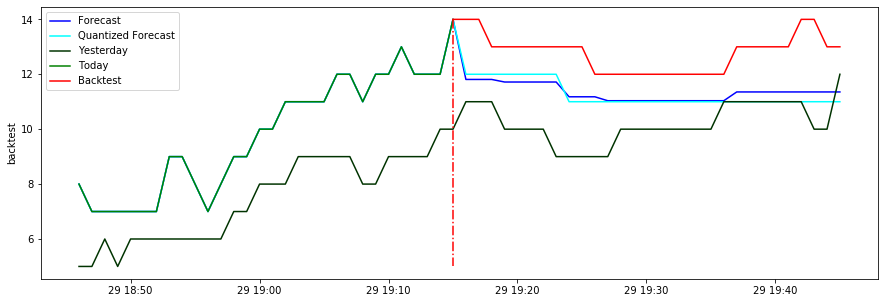

74 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.15061073638271472, 'importance_type': 'gain', 'learning_rate': 0.2873992080761745, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 700, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 15.508023522772149, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.1365311420170818


[0]	validation_0-rmse:15.2217
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:13.7409
[2]	validation_0-rmse:12.4146
[3]	validation_0-rmse:11.2236
[4]	validation_0-rmse:10.1447
[5]	validation_0-rmse:9.17467
[6]	validation_0-rmse:8.3186
[7]	validation_0-rmse:7.54101
[8]	validation_0-rmse:6.84938
[9]	validation_0-rmse:6.2191
[10]	validation_0-rmse:5.6479
[11]	validation_0-rmse:5.16379
[

[235]	validation_0-rmse:0.543035
[236]	validation_0-rmse:0.542963
[237]	validation_0-rmse:0.542903
[238]	validation_0-rmse:0.543085
[239]	validation_0-rmse:0.543088
[240]	validation_0-rmse:0.543104
[241]	validation_0-rmse:0.543122
[242]	validation_0-rmse:0.543221
[243]	validation_0-rmse:0.543319
[244]	validation_0-rmse:0.543324
[245]	validation_0-rmse:0.543413
[246]	validation_0-rmse:0.543302
[247]	validation_0-rmse:0.543227
[248]	validation_0-rmse:0.543218
[249]	validation_0-rmse:0.543422
[250]	validation_0-rmse:0.543308
[251]	validation_0-rmse:0.543527
[252]	validation_0-rmse:0.543568
[253]	validation_0-rmse:0.543473
[254]	validation_0-rmse:0.543452
[255]	validation_0-rmse:0.543458
[256]	validation_0-rmse:0.543314
[257]	validation_0-rmse:0.54352
[258]	validation_0-rmse:0.543613
[259]	validation_0-rmse:0.54353
[260]	validation_0-rmse:0.543554
[261]	validation_0-rmse:0.543535
[262]	validation_0-rmse:0.54352
[263]	validation_0-rmse:0.543516
[264]	validation_0-rmse:0.543577
[265]	validat

[485]	validation_0-rmse:0.541906
[486]	validation_0-rmse:0.541908
[487]	validation_0-rmse:0.541924
[488]	validation_0-rmse:0.541924
[489]	validation_0-rmse:0.541938
[490]	validation_0-rmse:0.541941
[491]	validation_0-rmse:0.541935
[492]	validation_0-rmse:0.541931
[493]	validation_0-rmse:0.541917
[494]	validation_0-rmse:0.541916
[495]	validation_0-rmse:0.541929
[496]	validation_0-rmse:0.54193
[497]	validation_0-rmse:0.541929
[498]	validation_0-rmse:0.541938
[499]	validation_0-rmse:0.541938
[500]	validation_0-rmse:0.541938
[501]	validation_0-rmse:0.541921
[502]	validation_0-rmse:0.541902
[503]	validation_0-rmse:0.541899
[504]	validation_0-rmse:0.541903
[505]	validation_0-rmse:0.541912
[506]	validation_0-rmse:0.541912
[507]	validation_0-rmse:0.541913
[508]	validation_0-rmse:0.541913
[509]	validation_0-rmse:0.541914
[510]	validation_0-rmse:0.54193
[511]	validation_0-rmse:0.541927
[512]	validation_0-rmse:0.541941
[513]	validation_0-rmse:0.541946
[514]	validation_0-rmse:0.541947
[515]	valida

[735]	validation_0-rmse:0.541838
[736]	validation_0-rmse:0.541839
[737]	validation_0-rmse:0.541837
[738]	validation_0-rmse:0.541839
[739]	validation_0-rmse:0.541834
[740]	validation_0-rmse:0.541835
[741]	validation_0-rmse:0.541836
[742]	validation_0-rmse:0.541837
[743]	validation_0-rmse:0.541839
[744]	validation_0-rmse:0.541839
[745]	validation_0-rmse:0.541839
[746]	validation_0-rmse:0.541839
[747]	validation_0-rmse:0.541837
[748]	validation_0-rmse:0.541838
[749]	validation_0-rmse:0.541841
[750]	validation_0-rmse:0.541841
[751]	validation_0-rmse:0.541839
[752]	validation_0-rmse:0.541835
[753]	validation_0-rmse:0.541839
[754]	validation_0-rmse:0.541838
[755]	validation_0-rmse:0.54184
[756]	validation_0-rmse:0.541838
[757]	validation_0-rmse:0.541829
[758]	validation_0-rmse:0.541829
[759]	validation_0-rmse:0.54183
[760]	validation_0-rmse:0.541832
[761]	validation_0-rmse:0.541832
[762]	validation_0-rmse:0.541832
[763]	validation_0-rmse:0.541834
[764]	validation_0-rmse:0.541832
[765]	valida

[985]	validation_0-rmse:0.541822
[986]	validation_0-rmse:0.541821
[987]	validation_0-rmse:0.541819
[988]	validation_0-rmse:0.541819
[989]	validation_0-rmse:0.541818
[990]	validation_0-rmse:0.54182
[991]	validation_0-rmse:0.541815
[992]	validation_0-rmse:0.541817
[993]	validation_0-rmse:0.541817
[994]	validation_0-rmse:0.541817
[995]	validation_0-rmse:0.541816
[996]	validation_0-rmse:0.541817
[997]	validation_0-rmse:0.541819
[998]	validation_0-rmse:0.541817
[999]	validation_0-rmse:0.541821
[1000]	validation_0-rmse:0.54182
[1001]	validation_0-rmse:0.54182
[1002]	validation_0-rmse:0.541819
[1003]	validation_0-rmse:0.541819
[1004]	validation_0-rmse:0.541819
[1005]	validation_0-rmse:0.541819
[1006]	validation_0-rmse:0.541818
[1007]	validation_0-rmse:0.541818
[1008]	validation_0-rmse:0.541819
[1009]	validation_0-rmse:0.541819
[1010]	validation_0-rmse:0.541819
[1011]	validation_0-rmse:0.541815
[1012]	validation_0-rmse:0.541815
[1013]	validation_0-rmse:0.541814
[1014]	validation_0-rmse:0.54181

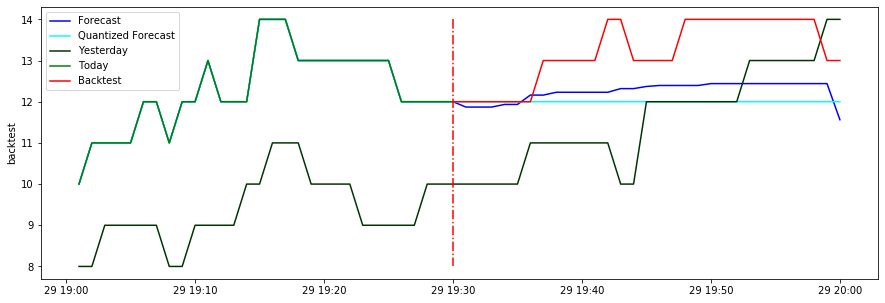

75 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 9.131753741504962, 'importance_type': 'gain', 'learning_rate': 0.13438989227047582, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 4.524182462470268, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.1631161068288431


[0]	validation_0-rmse:15.2172
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:13.7009
[2]	validation_0-rmse:12.3382
[3]	validation_0-rmse:11.1181
[4]	validation_0-rmse:10.0156
[5]	validation_0-rmse:9.02446
[6]	validation_0-rmse:8.14435
[7]	validation_0-rmse:7.3456
[8]	validation_0-rmse:6.64879
[9]	validation_0-rmse:6.0072
[10]	validation_0-rmse:5.43487
[11]	validation_0-rmse:4.93529
[1

[235]	validation_0-rmse:0.597583
[236]	validation_0-rmse:0.597544
[237]	validation_0-rmse:0.597536
[238]	validation_0-rmse:0.597511
[239]	validation_0-rmse:0.597512
[240]	validation_0-rmse:0.597532
[241]	validation_0-rmse:0.597523
[242]	validation_0-rmse:0.59758
[243]	validation_0-rmse:0.597305
[244]	validation_0-rmse:0.597297
[245]	validation_0-rmse:0.597284
[246]	validation_0-rmse:0.59729
[247]	validation_0-rmse:0.597301
[248]	validation_0-rmse:0.597305
[249]	validation_0-rmse:0.597136
[250]	validation_0-rmse:0.596844
[251]	validation_0-rmse:0.596369
[252]	validation_0-rmse:0.596374
[253]	validation_0-rmse:0.596428
[254]	validation_0-rmse:0.596277
[255]	validation_0-rmse:0.596361
[256]	validation_0-rmse:0.596597
[257]	validation_0-rmse:0.596673
[258]	validation_0-rmse:0.597085
[259]	validation_0-rmse:0.597021
[260]	validation_0-rmse:0.597009
[261]	validation_0-rmse:0.596998
[262]	validation_0-rmse:0.597021
[263]	validation_0-rmse:0.59703
[264]	validation_0-rmse:0.596732
[265]	validat

[485]	validation_0-rmse:0.594119
[486]	validation_0-rmse:0.594121
[487]	validation_0-rmse:0.594125
[488]	validation_0-rmse:0.594126
[489]	validation_0-rmse:0.594121
[490]	validation_0-rmse:0.594121
[491]	validation_0-rmse:0.59412
[492]	validation_0-rmse:0.594122
[493]	validation_0-rmse:0.594127
[494]	validation_0-rmse:0.594126
[495]	validation_0-rmse:0.594141
[496]	validation_0-rmse:0.59414
[497]	validation_0-rmse:0.59414
[498]	validation_0-rmse:0.594141
[499]	validation_0-rmse:0.594141
[500]	validation_0-rmse:0.594114
[501]	validation_0-rmse:0.594105
[502]	validation_0-rmse:0.594099
[503]	validation_0-rmse:0.594082
[504]	validation_0-rmse:0.594082
[505]	validation_0-rmse:0.594084
[506]	validation_0-rmse:0.594089
[507]	validation_0-rmse:0.594065
[508]	validation_0-rmse:0.594077
[509]	validation_0-rmse:0.594073
[510]	validation_0-rmse:0.594055
[511]	validation_0-rmse:0.594055
[512]	validation_0-rmse:0.594063
[513]	validation_0-rmse:0.59406
[514]	validation_0-rmse:0.594058
[515]	validati

[735]	validation_0-rmse:0.593961
[736]	validation_0-rmse:0.593969
[737]	validation_0-rmse:0.593967
[738]	validation_0-rmse:0.593968
[739]	validation_0-rmse:0.593967
[740]	validation_0-rmse:0.593967
[741]	validation_0-rmse:0.593967
[742]	validation_0-rmse:0.593965
[743]	validation_0-rmse:0.593966
[744]	validation_0-rmse:0.593967
[745]	validation_0-rmse:0.593967
[746]	validation_0-rmse:0.593968
[747]	validation_0-rmse:0.593968
[748]	validation_0-rmse:0.593969
[749]	validation_0-rmse:0.593969
[750]	validation_0-rmse:0.59397
[751]	validation_0-rmse:0.593969
[752]	validation_0-rmse:0.593968
[753]	validation_0-rmse:0.593967
[754]	validation_0-rmse:0.593967
[755]	validation_0-rmse:0.593968
[756]	validation_0-rmse:0.593967
[757]	validation_0-rmse:0.593974
[758]	validation_0-rmse:0.593968
[759]	validation_0-rmse:0.593971
[760]	validation_0-rmse:0.593969
[761]	validation_0-rmse:0.593969
[762]	validation_0-rmse:0.59397
[763]	validation_0-rmse:0.59397
[764]	validation_0-rmse:0.59397
[765]	validati

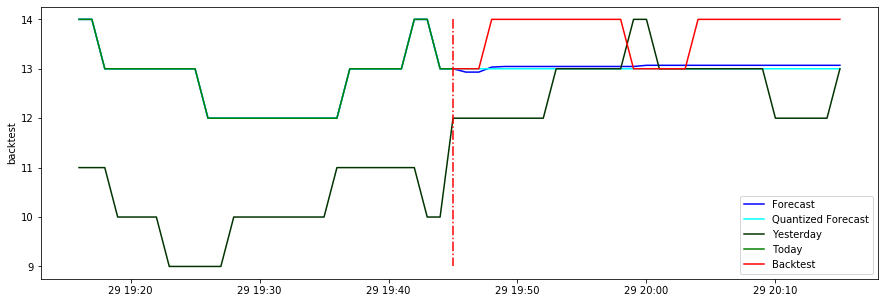

76 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.24838322804869972, 'importance_type': 'gain', 'learning_rate': 0.17231667129599518, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1130, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 8.575142104408517, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.8274229729695504


[0]	validation_0-rmse:15.5203
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:13.9778
[2]	validation_0-rmse:12.5947
[3]	validation_0-rmse:11.3465
[4]	validation_0-rmse:10.2231
[5]	validation_0-rmse:9.21414
[6]	validation_0-rmse:8.3032
[7]	validation_0-rmse:7.48701
[8]	validation_0-rmse:6.76599
[9]	validation_0-rmse:6.10371
[10]	validation_0-rmse:5.51098
[11]	validation_0-rmse:4.9875

[234]	validation_0-rmse:0.484538
[235]	validation_0-rmse:0.484702
[236]	validation_0-rmse:0.484697
[237]	validation_0-rmse:0.484683
[238]	validation_0-rmse:0.484855
[239]	validation_0-rmse:0.484887
[240]	validation_0-rmse:0.484879
[241]	validation_0-rmse:0.48491
[242]	validation_0-rmse:0.484813
[243]	validation_0-rmse:0.484971
[244]	validation_0-rmse:0.484969
[245]	validation_0-rmse:0.485032
[246]	validation_0-rmse:0.484909
[247]	validation_0-rmse:0.484888
[248]	validation_0-rmse:0.484883
[249]	validation_0-rmse:0.484866
[250]	validation_0-rmse:0.484531
[251]	validation_0-rmse:0.484581
[252]	validation_0-rmse:0.484564
[253]	validation_0-rmse:0.484785
[254]	validation_0-rmse:0.484937
[255]	validation_0-rmse:0.485004
[256]	validation_0-rmse:0.484963
[257]	validation_0-rmse:0.484997
[258]	validation_0-rmse:0.485088
[259]	validation_0-rmse:0.485104
[260]	validation_0-rmse:0.48514
[261]	validation_0-rmse:0.485157
[262]	validation_0-rmse:0.485166
[263]	validation_0-rmse:0.485159
[264]	valida

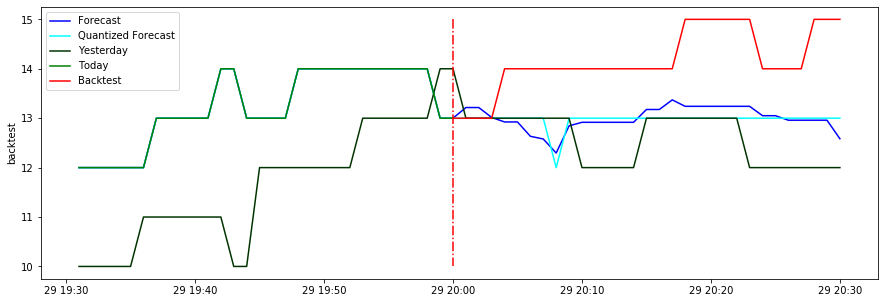

77 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.6400138333369894, 'importance_type': 'gain', 'learning_rate': 0.1583990727898767, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 830, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.3365337538286264, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.2461057748648634


[0]	validation_0-rmse:15.7367
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.1858
[2]	validation_0-rmse:12.7917
[3]	validation_0-rmse:11.5428
[4]	validation_0-rmse:10.4132
[5]	validation_0-rmse:9.39621
[6]	validation_0-rmse:8.4821
[7]	validation_0-rmse:7.65835
[8]	validation_0-rmse:6.92922
[9]	validation_0-rmse:6.26206
[10]	validation_0-rmse:5.66421
[11]	validation_0-rmse:5.13854


[235]	validation_0-rmse:0.26327
[236]	validation_0-rmse:0.26339
[237]	validation_0-rmse:0.263313
[238]	validation_0-rmse:0.263367
[239]	validation_0-rmse:0.263441
[240]	validation_0-rmse:0.263461
[241]	validation_0-rmse:0.263589
[242]	validation_0-rmse:0.263699
[243]	validation_0-rmse:0.263716
[244]	validation_0-rmse:0.263778
[245]	validation_0-rmse:0.26369
[246]	validation_0-rmse:0.263764
[247]	validation_0-rmse:0.263799
[248]	validation_0-rmse:0.263861
[249]	validation_0-rmse:0.263708
[250]	validation_0-rmse:0.263498
[251]	validation_0-rmse:0.263355
[252]	validation_0-rmse:0.263407
[253]	validation_0-rmse:0.263644
[254]	validation_0-rmse:0.263727
[255]	validation_0-rmse:0.263733
[256]	validation_0-rmse:0.26376
[257]	validation_0-rmse:0.26384
[258]	validation_0-rmse:0.263797
[259]	validation_0-rmse:0.263834
[260]	validation_0-rmse:0.263869
[261]	validation_0-rmse:0.263888
[262]	validation_0-rmse:0.263994
[263]	validation_0-rmse:0.264011
[264]	validation_0-rmse:0.263956
[265]	validatio

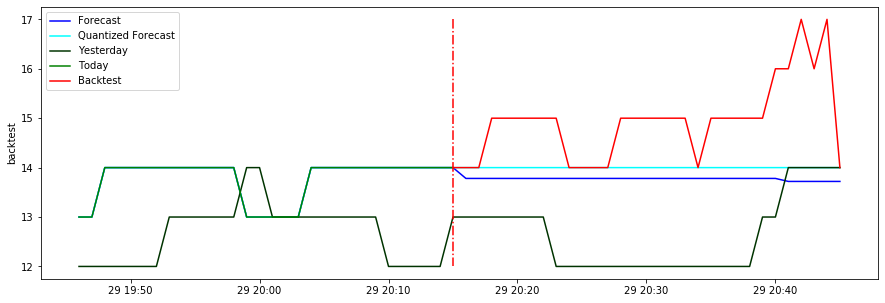

78 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.196272961622296, 'importance_type': 'gain', 'learning_rate': 0.26467621183959134, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 720, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 2.549626006108518, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.8294876948694438


[0]	validation_0-rmse:15.6624
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.1091
[2]	validation_0-rmse:12.7146
[3]	validation_0-rmse:11.4606
[4]	validation_0-rmse:10.3325
[5]	validation_0-rmse:9.31233
[6]	validation_0-rmse:8.39653
[7]	validation_0-rmse:7.56955
[8]	validation_0-rmse:6.83767
[9]	validation_0-rmse:6.16938
[10]	validation_0-rmse:5.56774
[11]	validation_0-rmse:5.038
[1

[234]	validation_0-rmse:0.311745
[235]	validation_0-rmse:0.311816
[236]	validation_0-rmse:0.311734
[237]	validation_0-rmse:0.311743
[238]	validation_0-rmse:0.311727
[239]	validation_0-rmse:0.311727
[240]	validation_0-rmse:0.311739
[241]	validation_0-rmse:0.311744
[242]	validation_0-rmse:0.311691
[243]	validation_0-rmse:0.311689
[244]	validation_0-rmse:0.311699
[245]	validation_0-rmse:0.311738
[246]	validation_0-rmse:0.311775
[247]	validation_0-rmse:0.311784
[248]	validation_0-rmse:0.31179
[249]	validation_0-rmse:0.311741
[250]	validation_0-rmse:0.311709
[251]	validation_0-rmse:0.31177
[252]	validation_0-rmse:0.311783
[253]	validation_0-rmse:0.311864
[254]	validation_0-rmse:0.311853
[255]	validation_0-rmse:0.31184
[256]	validation_0-rmse:0.311821
[257]	validation_0-rmse:0.311803
[258]	validation_0-rmse:0.311824
[259]	validation_0-rmse:0.311807
[260]	validation_0-rmse:0.311805
[261]	validation_0-rmse:0.311804
[262]	validation_0-rmse:0.311768
[263]	validation_0-rmse:0.311767
[264]	validat

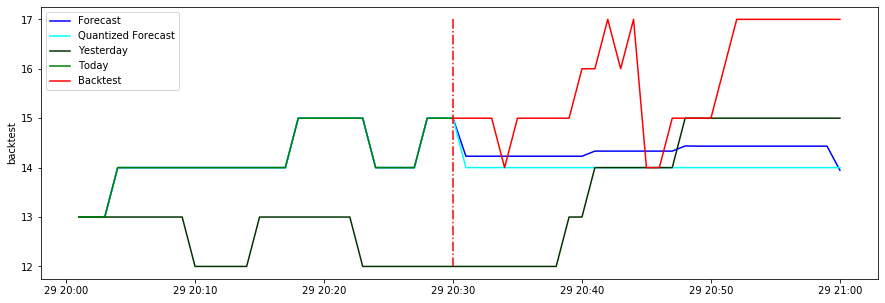

79 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.348948971074682, 'importance_type': 'gain', 'learning_rate': 0.13423006109089675, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 460, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.6166362664023253, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.6775804526021485


[0]	validation_0-rmse:15.7967
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.2334
[2]	validation_0-rmse:12.8296
[3]	validation_0-rmse:11.5656
[4]	validation_0-rmse:10.431
[5]	validation_0-rmse:9.4061
[6]	validation_0-rmse:8.48506
[7]	validation_0-rmse:7.65424
[8]	validation_0-rmse:6.91109
[9]	validation_0-rmse:6.24069
[10]	validation_0-rmse:5.63145
[11]	validation_0-rmse:5.09286
[

[234]	validation_0-rmse:0.352276
Stopping. Best iteration:
[134]	validation_0-rmse:0.348233



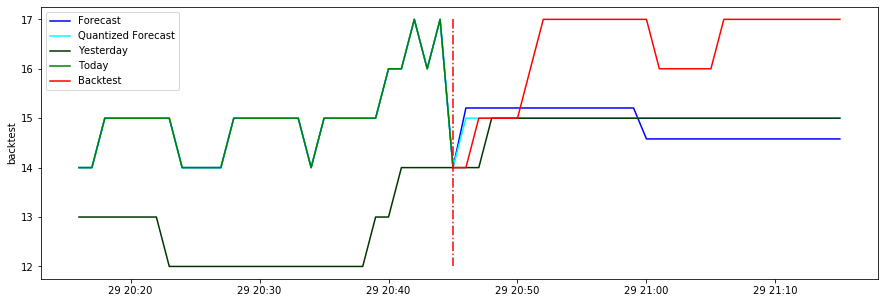

80 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 7.316320212570075, 'importance_type': 'gain', 'learning_rate': 0.29459802320543216, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1400, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.7916206606222178, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.790658756982812


[0]	validation_0-rmse:15.9705
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.3896
[2]	validation_0-rmse:12.9671
[3]	validation_0-rmse:11.6914
[4]	validation_0-rmse:10.5441
[5]	validation_0-rmse:9.50841
[6]	validation_0-rmse:8.57197
[7]	validation_0-rmse:7.73485
[8]	validation_0-rmse:6.97859
[9]	validation_0-rmse:6.29474
[10]	validation_0-rmse:5.67912
[11]	validation_0-rmse:5.13107

[235]	validation_0-rmse:0.322891
[236]	validation_0-rmse:0.322826
[237]	validation_0-rmse:0.322815
[238]	validation_0-rmse:0.322798
[239]	validation_0-rmse:0.322797
[240]	validation_0-rmse:0.32279
[241]	validation_0-rmse:0.322778
[242]	validation_0-rmse:0.322782
[243]	validation_0-rmse:0.322695
[244]	validation_0-rmse:0.322707
[245]	validation_0-rmse:0.322711
[246]	validation_0-rmse:0.322692
[247]	validation_0-rmse:0.322701
[248]	validation_0-rmse:0.322687
[249]	validation_0-rmse:0.322707
[250]	validation_0-rmse:0.322753
[251]	validation_0-rmse:0.322724
[252]	validation_0-rmse:0.322682
[253]	validation_0-rmse:0.322695
[254]	validation_0-rmse:0.322723
[255]	validation_0-rmse:0.322698
[256]	validation_0-rmse:0.322699
[257]	validation_0-rmse:0.322689
[258]	validation_0-rmse:0.322646
[259]	validation_0-rmse:0.322644
[260]	validation_0-rmse:0.322637
[261]	validation_0-rmse:0.322644
[262]	validation_0-rmse:0.322633
[263]	validation_0-rmse:0.322631
[264]	validation_0-rmse:0.322578
[265]	valid

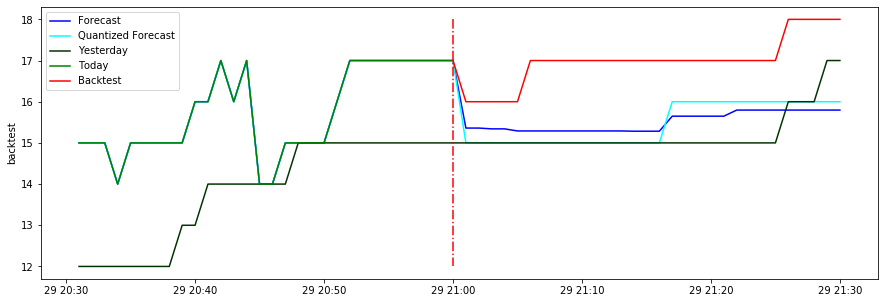

81 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 3.5784888305838525, 'importance_type': 'gain', 'learning_rate': 0.1747332806036722, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1630, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 10.999423048701546, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.5296430106209733


[0]	validation_0-rmse:16.4112
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.8036
[2]	validation_0-rmse:13.3553
[3]	validation_0-rmse:12.0559
[4]	validation_0-rmse:10.8853
[5]	validation_0-rmse:9.82903
[6]	validation_0-rmse:8.87396
[7]	validation_0-rmse:8.01777
[8]	validation_0-rmse:7.24319
[9]	validation_0-rmse:6.5459
[10]	validation_0-rmse:5.91942
[11]	validation_0-rmse:5.35768

[234]	validation_0-rmse:0.307095
[235]	validation_0-rmse:0.307077
[236]	validation_0-rmse:0.307068
[237]	validation_0-rmse:0.307039
[238]	validation_0-rmse:0.307021
[239]	validation_0-rmse:0.307031
[240]	validation_0-rmse:0.307035
[241]	validation_0-rmse:0.30702
[242]	validation_0-rmse:0.307039
[243]	validation_0-rmse:0.307038
[244]	validation_0-rmse:0.307027
[245]	validation_0-rmse:0.307008
[246]	validation_0-rmse:0.307016
[247]	validation_0-rmse:0.306996
[248]	validation_0-rmse:0.306988
[249]	validation_0-rmse:0.307016
[250]	validation_0-rmse:0.307009
[251]	validation_0-rmse:0.306975
[252]	validation_0-rmse:0.306951
[253]	validation_0-rmse:0.306963
[254]	validation_0-rmse:0.306918
[255]	validation_0-rmse:0.30694
[256]	validation_0-rmse:0.306899
[257]	validation_0-rmse:0.306892
[258]	validation_0-rmse:0.30684
[259]	validation_0-rmse:0.306832
[260]	validation_0-rmse:0.306835
[261]	validation_0-rmse:0.306834
[262]	validation_0-rmse:0.306829
[263]	validation_0-rmse:0.306826
[264]	validat

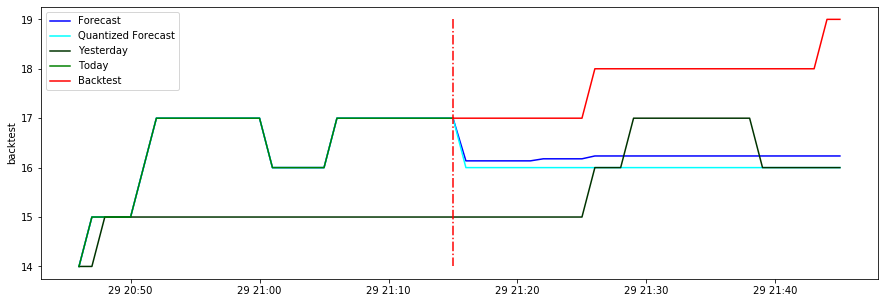

82 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.970250112057058, 'importance_type': 'gain', 'learning_rate': 0.18115215986925068, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 12.159907253814854, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.512800113517708


[0]	validation_0-rmse:16.6029
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:14.9737
[2]	validation_0-rmse:13.5072
[3]	validation_0-rmse:12.1831
[4]	validation_0-rmse:11.0002
[5]	validation_0-rmse:9.92976
[6]	validation_0-rmse:8.95988
[7]	validation_0-rmse:8.09221
[8]	validation_0-rmse:7.30899
[9]	validation_0-rmse:6.60349
[10]	validation_0-rmse:5.96591
[11]	validation_0-rmse:5.39644


[235]	validation_0-rmse:0.198218
[236]	validation_0-rmse:0.198235
[237]	validation_0-rmse:0.198232
[238]	validation_0-rmse:0.198264
[239]	validation_0-rmse:0.198251
[240]	validation_0-rmse:0.198261
[241]	validation_0-rmse:0.198269
[242]	validation_0-rmse:0.198265
[243]	validation_0-rmse:0.198179
[244]	validation_0-rmse:0.198162
[245]	validation_0-rmse:0.198179
[246]	validation_0-rmse:0.198182
[247]	validation_0-rmse:0.198166
[248]	validation_0-rmse:0.198224
[249]	validation_0-rmse:0.198202
[250]	validation_0-rmse:0.198122
[251]	validation_0-rmse:0.198097
[252]	validation_0-rmse:0.19809
[253]	validation_0-rmse:0.19804
[254]	validation_0-rmse:0.198067
[255]	validation_0-rmse:0.198084
[256]	validation_0-rmse:0.198056
[257]	validation_0-rmse:0.198057
[258]	validation_0-rmse:0.198144
[259]	validation_0-rmse:0.198122
[260]	validation_0-rmse:0.198121
[261]	validation_0-rmse:0.198115
[262]	validation_0-rmse:0.19812
[263]	validation_0-rmse:0.198121
[264]	validation_0-rmse:0.198078
[265]	validat

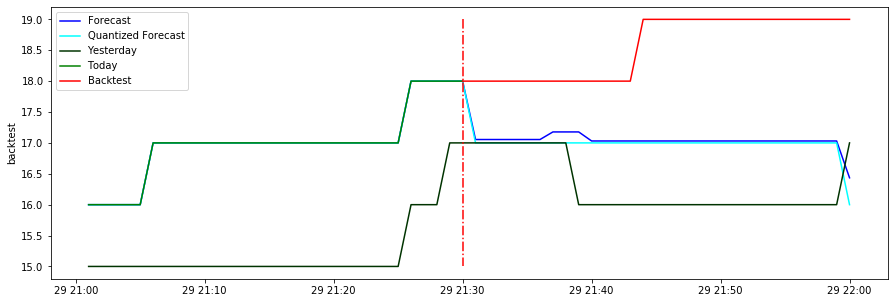

83 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.4858738582821207, 'importance_type': 'gain', 'learning_rate': 0.12289921767094361, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.805608495754003, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.2967950008921596


[0]	validation_0-rmse:16.8295
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.172
[2]	validation_0-rmse:13.6809
[3]	validation_0-rmse:12.3383
[4]	validation_0-rmse:11.1365
[5]	validation_0-rmse:10.0486
[6]	validation_0-rmse:9.06502
[7]	validation_0-rmse:8.18381
[8]	validation_0-rmse:7.3893
[9]	validation_0-rmse:6.67349
[10]	validation_0-rmse:6.02578
[11]	validation_0-rmse:5.45116
[

[234]	validation_0-rmse:0.24088
[235]	validation_0-rmse:0.240838
[236]	validation_0-rmse:0.240826
[237]	validation_0-rmse:0.240817
[238]	validation_0-rmse:0.240788
[239]	validation_0-rmse:0.240785
[240]	validation_0-rmse:0.24079
[241]	validation_0-rmse:0.240783
[242]	validation_0-rmse:0.240793
[243]	validation_0-rmse:0.240802
[244]	validation_0-rmse:0.240795
[245]	validation_0-rmse:0.240788
[246]	validation_0-rmse:0.24079
[247]	validation_0-rmse:0.240785
[248]	validation_0-rmse:0.240791
[249]	validation_0-rmse:0.240781
[250]	validation_0-rmse:0.240733
[251]	validation_0-rmse:0.240702
[252]	validation_0-rmse:0.240698
[253]	validation_0-rmse:0.240695
[254]	validation_0-rmse:0.240692
[255]	validation_0-rmse:0.240633
[256]	validation_0-rmse:0.240591
[257]	validation_0-rmse:0.240563
[258]	validation_0-rmse:0.240566
[259]	validation_0-rmse:0.240561
[260]	validation_0-rmse:0.240556
[261]	validation_0-rmse:0.24055
[262]	validation_0-rmse:0.240557
[263]	validation_0-rmse:0.240546
[264]	validati

[484]	validation_0-rmse:0.239993
[485]	validation_0-rmse:0.239993
[486]	validation_0-rmse:0.239994
[487]	validation_0-rmse:0.239994
[488]	validation_0-rmse:0.239995
[489]	validation_0-rmse:0.239996
[490]	validation_0-rmse:0.239996
[491]	validation_0-rmse:0.239996
[492]	validation_0-rmse:0.239997
[493]	validation_0-rmse:0.239992
[494]	validation_0-rmse:0.239992
[495]	validation_0-rmse:0.239985
[496]	validation_0-rmse:0.239986
[497]	validation_0-rmse:0.239983
[498]	validation_0-rmse:0.239982
[499]	validation_0-rmse:0.239981
[500]	validation_0-rmse:0.239985
[501]	validation_0-rmse:0.239985
[502]	validation_0-rmse:0.239977
[503]	validation_0-rmse:0.239977
[504]	validation_0-rmse:0.239977
[505]	validation_0-rmse:0.239977
[506]	validation_0-rmse:0.239977
[507]	validation_0-rmse:0.239977
[508]	validation_0-rmse:0.239975
[509]	validation_0-rmse:0.239976
[510]	validation_0-rmse:0.239982
[511]	validation_0-rmse:0.239982
[512]	validation_0-rmse:0.239986
[513]	validation_0-rmse:0.239986
[514]	vali

[733]	validation_0-rmse:0.239925
[734]	validation_0-rmse:0.239925
[735]	validation_0-rmse:0.239925
[736]	validation_0-rmse:0.239925
[737]	validation_0-rmse:0.239925
[738]	validation_0-rmse:0.239925
[739]	validation_0-rmse:0.239925
[740]	validation_0-rmse:0.239926
[741]	validation_0-rmse:0.239926
[742]	validation_0-rmse:0.239926
[743]	validation_0-rmse:0.239926
[744]	validation_0-rmse:0.239926
[745]	validation_0-rmse:0.239927
[746]	validation_0-rmse:0.239927
[747]	validation_0-rmse:0.239927
[748]	validation_0-rmse:0.239927
[749]	validation_0-rmse:0.239926
[750]	validation_0-rmse:0.239926
[751]	validation_0-rmse:0.239926
[752]	validation_0-rmse:0.239926
[753]	validation_0-rmse:0.239926
[754]	validation_0-rmse:0.239927
[755]	validation_0-rmse:0.239926
[756]	validation_0-rmse:0.239924
[757]	validation_0-rmse:0.239925
[758]	validation_0-rmse:0.239924
[759]	validation_0-rmse:0.239924
[760]	validation_0-rmse:0.239922
[761]	validation_0-rmse:0.239921
[762]	validation_0-rmse:0.239921
[763]	vali

[982]	validation_0-rmse:0.239885
[983]	validation_0-rmse:0.239886
[984]	validation_0-rmse:0.239886
[985]	validation_0-rmse:0.239886
[986]	validation_0-rmse:0.239888
[987]	validation_0-rmse:0.239888
[988]	validation_0-rmse:0.239888
[989]	validation_0-rmse:0.239887
[990]	validation_0-rmse:0.239887
[991]	validation_0-rmse:0.239893
[992]	validation_0-rmse:0.239893
[993]	validation_0-rmse:0.239893
[994]	validation_0-rmse:0.239893
Stopping. Best iteration:
[894]	validation_0-rmse:0.23988



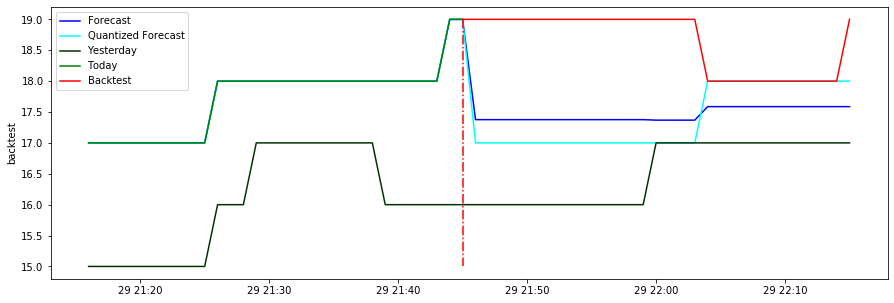

84 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.68818377391443, 'importance_type': 'gain', 'learning_rate': 0.17603546047411409, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1790, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.6307299604818262, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 1.3615137191074003


[0]	validation_0-rmse:16.9259
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.2501
[2]	validation_0-rmse:13.7413
[3]	validation_0-rmse:12.3827
[4]	validation_0-rmse:11.162
[5]	validation_0-rmse:10.0603
[6]	validation_0-rmse:9.06476
[7]	validation_0-rmse:8.17254
[8]	validation_0-rmse:7.36848
[9]	validation_0-rmse:6.63967
[10]	validation_0-rmse:5.98599
[11]	validation_0-rmse:5.40061


[235]	validation_0-rmse:0.202541
[236]	validation_0-rmse:0.202545
[237]	validation_0-rmse:0.202523
[238]	validation_0-rmse:0.20253
[239]	validation_0-rmse:0.202536
[240]	validation_0-rmse:0.202538
[241]	validation_0-rmse:0.202536
[242]	validation_0-rmse:0.202529
[243]	validation_0-rmse:0.202528
[244]	validation_0-rmse:0.202527
[245]	validation_0-rmse:0.202521
[246]	validation_0-rmse:0.202506
[247]	validation_0-rmse:0.202506
[248]	validation_0-rmse:0.202499
[249]	validation_0-rmse:0.20249
[250]	validation_0-rmse:0.20249
[251]	validation_0-rmse:0.202471
[252]	validation_0-rmse:0.202465
[253]	validation_0-rmse:0.202399
[254]	validation_0-rmse:0.202414
[255]	validation_0-rmse:0.20242
[256]	validation_0-rmse:0.202416
[257]	validation_0-rmse:0.20244
[258]	validation_0-rmse:0.202427
[259]	validation_0-rmse:0.202423
[260]	validation_0-rmse:0.20241
[261]	validation_0-rmse:0.202412
[262]	validation_0-rmse:0.2024
[263]	validation_0-rmse:0.202385
[264]	validation_0-rmse:0.202316
[265]	validation_0

[485]	validation_0-rmse:0.202058
[486]	validation_0-rmse:0.202058
[487]	validation_0-rmse:0.202058
[488]	validation_0-rmse:0.202058
[489]	validation_0-rmse:0.202057
[490]	validation_0-rmse:0.202067
[491]	validation_0-rmse:0.202062
[492]	validation_0-rmse:0.202063
[493]	validation_0-rmse:0.202063
[494]	validation_0-rmse:0.202063
[495]	validation_0-rmse:0.202063
[496]	validation_0-rmse:0.202063
[497]	validation_0-rmse:0.202063
[498]	validation_0-rmse:0.202063
[499]	validation_0-rmse:0.202062
[500]	validation_0-rmse:0.202062
[501]	validation_0-rmse:0.202062
[502]	validation_0-rmse:0.202062
[503]	validation_0-rmse:0.202062
[504]	validation_0-rmse:0.202062
[505]	validation_0-rmse:0.202062
[506]	validation_0-rmse:0.202062
[507]	validation_0-rmse:0.202064
[508]	validation_0-rmse:0.202064
[509]	validation_0-rmse:0.202063
[510]	validation_0-rmse:0.202063
[511]	validation_0-rmse:0.202063
[512]	validation_0-rmse:0.202063
[513]	validation_0-rmse:0.202064
[514]	validation_0-rmse:0.202062
[515]	vali

[734]	validation_0-rmse:0.202013
[735]	validation_0-rmse:0.202012
[736]	validation_0-rmse:0.202012
[737]	validation_0-rmse:0.202012
[738]	validation_0-rmse:0.202012
[739]	validation_0-rmse:0.202009
[740]	validation_0-rmse:0.202008
[741]	validation_0-rmse:0.202009
[742]	validation_0-rmse:0.20201
[743]	validation_0-rmse:0.20201
[744]	validation_0-rmse:0.202009
[745]	validation_0-rmse:0.202009
[746]	validation_0-rmse:0.202009
[747]	validation_0-rmse:0.202009
[748]	validation_0-rmse:0.202009
[749]	validation_0-rmse:0.202009
[750]	validation_0-rmse:0.202009
[751]	validation_0-rmse:0.202009
[752]	validation_0-rmse:0.202009
[753]	validation_0-rmse:0.202008
[754]	validation_0-rmse:0.202008
[755]	validation_0-rmse:0.20201
[756]	validation_0-rmse:0.20201
[757]	validation_0-rmse:0.20201
[758]	validation_0-rmse:0.20201
[759]	validation_0-rmse:0.202008
[760]	validation_0-rmse:0.202009
[761]	validation_0-rmse:0.202009
[762]	validation_0-rmse:0.202008
[763]	validation_0-rmse:0.202008
[764]	validation

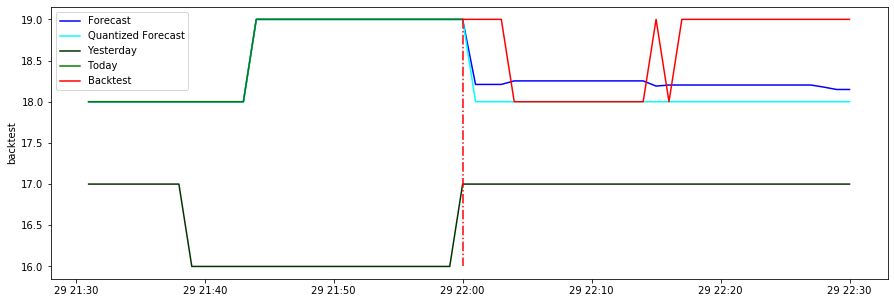

85 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.6541472855669994, 'importance_type': 'gain', 'learning_rate': 0.02766010869801131, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 25.312570002577257, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.8751650764697895


[0]	validation_0-rmse:16.988
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.3066
[2]	validation_0-rmse:13.7917
[3]	validation_0-rmse:12.4261
[4]	validation_0-rmse:11.1976
[5]	validation_0-rmse:10.0906
[6]	validation_0-rmse:9.08902
[7]	validation_0-rmse:8.19277
[8]	validation_0-rmse:7.39042
[9]	validation_0-rmse:6.66033
[10]	validation_0-rmse:6.00396
[11]	validation_0-rmse:5.4191

[235]	validation_0-rmse:0.221197
[236]	validation_0-rmse:0.221207
[237]	validation_0-rmse:0.221211
[238]	validation_0-rmse:0.221203
[239]	validation_0-rmse:0.221204
[240]	validation_0-rmse:0.221204
[241]	validation_0-rmse:0.221202
[242]	validation_0-rmse:0.221215
[243]	validation_0-rmse:0.221211
[244]	validation_0-rmse:0.221211
[245]	validation_0-rmse:0.22118
[246]	validation_0-rmse:0.221183
[247]	validation_0-rmse:0.221184
[248]	validation_0-rmse:0.221171
[249]	validation_0-rmse:0.221211
[250]	validation_0-rmse:0.221136
[251]	validation_0-rmse:0.221123
[252]	validation_0-rmse:0.221106
[253]	validation_0-rmse:0.221059
[254]	validation_0-rmse:0.221003
[255]	validation_0-rmse:0.221039
[256]	validation_0-rmse:0.221113
[257]	validation_0-rmse:0.221126
[258]	validation_0-rmse:0.221138
[259]	validation_0-rmse:0.221136
[260]	validation_0-rmse:0.221137
[261]	validation_0-rmse:0.221141
[262]	validation_0-rmse:0.221156
[263]	validation_0-rmse:0.221156
[264]	validation_0-rmse:0.221121
[265]	valid

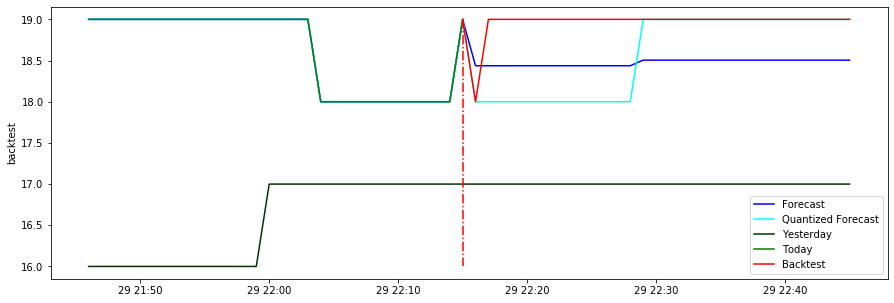

86 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.5447984005157402, 'importance_type': 'gain', 'learning_rate': 0.2777159557664839, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1940, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.2981027700989705, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.5849536584627061


[0]	validation_0-rmse:17.0782
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.3909
[2]	validation_0-rmse:13.8706
[3]	validation_0-rmse:12.504
[4]	validation_0-rmse:11.2726
[5]	validation_0-rmse:10.1633
[6]	validation_0-rmse:9.16005
[7]	validation_0-rmse:8.25982
[8]	validation_0-rmse:7.45375
[9]	validation_0-rmse:6.72154
[10]	validation_0-rmse:6.06262
[11]	validation_0-rmse:5.47659

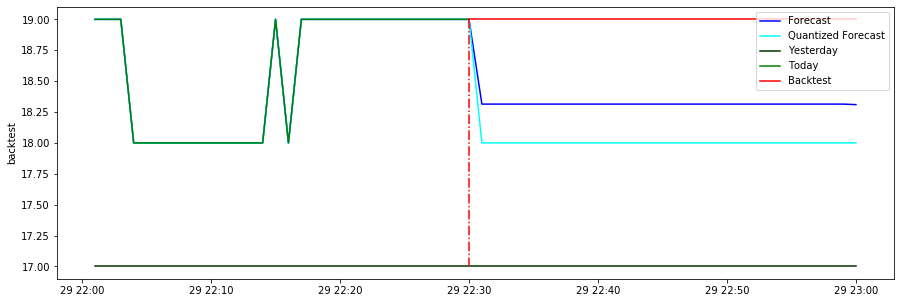

87 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 6.281701935736537, 'importance_type': 'gain', 'learning_rate': 0.14631984294898578, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1110, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 3.2569090111710883, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.8051127448624904


[0]	validation_0-rmse:17.0468
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.3578
[2]	validation_0-rmse:13.8415
[3]	validation_0-rmse:12.4737
[4]	validation_0-rmse:11.2443
[5]	validation_0-rmse:10.1368
[6]	validation_0-rmse:9.13596
[7]	validation_0-rmse:8.23757
[8]	validation_0-rmse:7.43203
[9]	validation_0-rmse:6.70877
[10]	validation_0-rmse:6.05194
[11]	validation_0-rmse:5.4686

[234]	validation_0-rmse:0.149214
[235]	validation_0-rmse:0.149211
[236]	validation_0-rmse:0.149212
[237]	validation_0-rmse:0.149214
[238]	validation_0-rmse:0.149212
[239]	validation_0-rmse:0.149212
[240]	validation_0-rmse:0.149212
[241]	validation_0-rmse:0.149205
[242]	validation_0-rmse:0.149198
[243]	validation_0-rmse:0.149207
[244]	validation_0-rmse:0.14921
[245]	validation_0-rmse:0.149204
[246]	validation_0-rmse:0.149197
[247]	validation_0-rmse:0.149207
[248]	validation_0-rmse:0.149197
[249]	validation_0-rmse:0.149166
[250]	validation_0-rmse:0.149152
[251]	validation_0-rmse:0.149107
[252]	validation_0-rmse:0.149101
[253]	validation_0-rmse:0.149098
[254]	validation_0-rmse:0.149102
[255]	validation_0-rmse:0.149102
[256]	validation_0-rmse:0.149074
[257]	validation_0-rmse:0.149075
[258]	validation_0-rmse:0.149058
[259]	validation_0-rmse:0.149064
[260]	validation_0-rmse:0.149063
[261]	validation_0-rmse:0.149074
[262]	validation_0-rmse:0.149071
[263]	validation_0-rmse:0.149069
[264]	valid

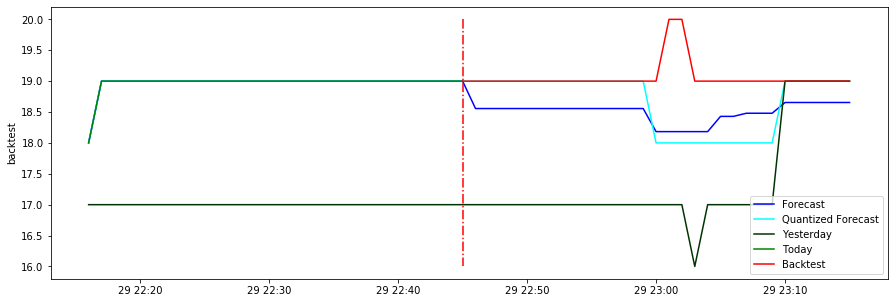

88 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 5.4938637316774, 'importance_type': 'gain', 'learning_rate': 0.08431031596403524, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1820, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 5.137100777092659, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.5209482992021657


[0]	validation_0-rmse:17.1856
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.4863
[2]	validation_0-rmse:13.9585
[3]	validation_0-rmse:12.5869
[4]	validation_0-rmse:11.3525
[5]	validation_0-rmse:10.2416
[6]	validation_0-rmse:9.24187
[7]	validation_0-rmse:8.33642
[8]	validation_0-rmse:7.52569
[9]	validation_0-rmse:6.79621
[10]	validation_0-rmse:6.13464
[11]	validation_0-rmse:5.54331
[

[234]	validation_0-rmse:0.19116
[235]	validation_0-rmse:0.191134
[236]	validation_0-rmse:0.191129
[237]	validation_0-rmse:0.191125
[238]	validation_0-rmse:0.191121
[239]	validation_0-rmse:0.191121
[240]	validation_0-rmse:0.191124
[241]	validation_0-rmse:0.191124
[242]	validation_0-rmse:0.191112
[243]	validation_0-rmse:0.19107
[244]	validation_0-rmse:0.191068
[245]	validation_0-rmse:0.191027
[246]	validation_0-rmse:0.191035
[247]	validation_0-rmse:0.191035
[248]	validation_0-rmse:0.191067
[249]	validation_0-rmse:0.191049
[250]	validation_0-rmse:0.191028
[251]	validation_0-rmse:0.191024
[252]	validation_0-rmse:0.191019
[253]	validation_0-rmse:0.191018
[254]	validation_0-rmse:0.190994
[255]	validation_0-rmse:0.190978
[256]	validation_0-rmse:0.19099
[257]	validation_0-rmse:0.190987
[258]	validation_0-rmse:0.191019
[259]	validation_0-rmse:0.190993
[260]	validation_0-rmse:0.190989
[261]	validation_0-rmse:0.190989
[262]	validation_0-rmse:0.190997
[263]	validation_0-rmse:0.190995
[264]	validat

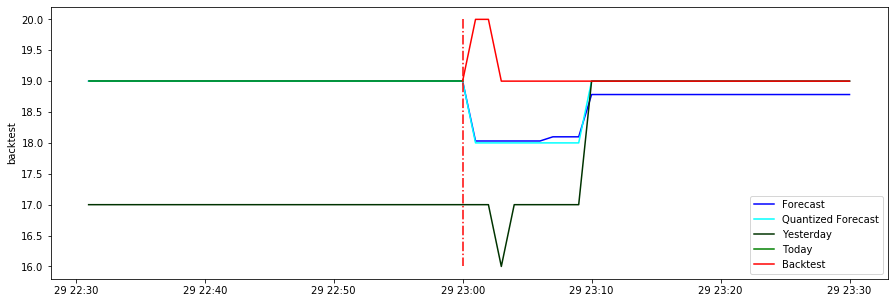

89 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 2.7182340563305187, 'importance_type': 'gain', 'learning_rate': 0.15093746316406845, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1.2324401796513988, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.7091361846483631


[0]	validation_0-rmse:17.1653
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.4521
[2]	validation_0-rmse:13.9116
[3]	validation_0-rmse:12.5286
[4]	validation_0-rmse:11.2843
[5]	validation_0-rmse:10.166
[6]	validation_0-rmse:9.15797
[7]	validation_0-rmse:8.25113
[8]	validation_0-rmse:7.43374
[9]	validation_0-rmse:6.69979
[10]	validation_0-rmse:6.03562
[11]	validation_0-rmse:5.43829

[234]	validation_0-rmse:0.181347
[235]	validation_0-rmse:0.181375
[236]	validation_0-rmse:0.181363
[237]	validation_0-rmse:0.181365
[238]	validation_0-rmse:0.181374
[239]	validation_0-rmse:0.181374
[240]	validation_0-rmse:0.181374
[241]	validation_0-rmse:0.181377
[242]	validation_0-rmse:0.181366
[243]	validation_0-rmse:0.181299
[244]	validation_0-rmse:0.181298
[245]	validation_0-rmse:0.181303
[246]	validation_0-rmse:0.181312
[247]	validation_0-rmse:0.181311
[248]	validation_0-rmse:0.18133
[249]	validation_0-rmse:0.181347
[250]	validation_0-rmse:0.181363
[251]	validation_0-rmse:0.181373
[252]	validation_0-rmse:0.181375
[253]	validation_0-rmse:0.181373
[254]	validation_0-rmse:0.181379
[255]	validation_0-rmse:0.181391
[256]	validation_0-rmse:0.181396
[257]	validation_0-rmse:0.181392
[258]	validation_0-rmse:0.18142
[259]	validation_0-rmse:0.181459
[260]	validation_0-rmse:0.181459
[261]	validation_0-rmse:0.181459
[262]	validation_0-rmse:0.181469
[263]	validation_0-rmse:0.181468
[264]	valida

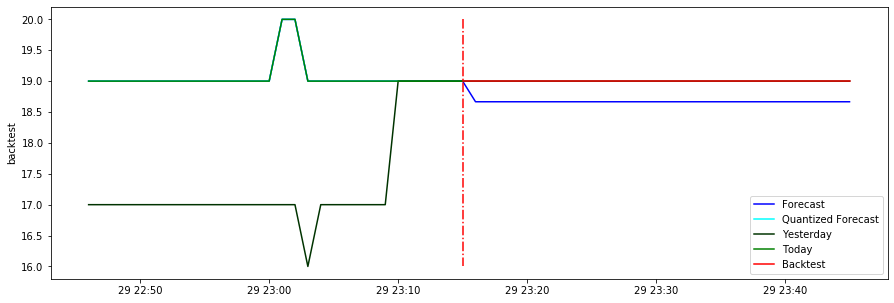

90 / 97
Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1.7669713493991768, 'importance_type': 'gain', 'learning_rate': 0.1313891643133655, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 6.7465201890606785, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
RMSE: 0.1571369171142578




In [26]:
# Generating all availiable graphics

for i in range(df_result.shape[0]):
    model_generation_viz(df_result.hour[i], 30, df_result.best_parameters[i])
    print(i+1,"/",len(time_list)+1)
    print("Best parameters:",df_result.best_parameters[i])
    print("RMSE:",df_result.rmse_f_b[i])
    print()
    print()

### C. Save trained model

In [31]:
from joblib import dump, load

dump(xgb_model, "/Users/stephanetatar/Documents/Jedha/Projets/XGBOOST/xgb_model_saved.joblib")
dump(xgb_model_final, "/Users/stephanetatar/Documents/Jedha/Projets/XGBOOST/xgb_model_saved.joblib")

NameError: name 'xgb_model_final' is not defined

### C. Load trained model

In [9]:
xgb_model = load("/Users/stephanetatar/Documents/Jedha/Projets/XGBOOST/xgb_model.joblib")
xgb_model_final = load("/Users/stephanetatar/Documents/Jedha/Projets/XGBOOST/xgb_model_final.joblib)


df_result.to_csv("/Users/stephanetatar/Documents/Jedha/Projets/XGBOOST/model_XGBoost_results.csv")

08:00:00
07:30:00
[0]	validation_0-rmse:13.7754
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:12.4429
[2]	validation_0-rmse:11.2419
[3]	validation_0-rmse:10.1531
[4]	validation_0-rmse:9.17031
[5]	validation_0-rmse:8.30445
[6]	validation_0-rmse:7.52748
[7]	validation_0-rmse:6.814
[8]	validation_0-rmse:6.1754
[9]	validation_0-rmse:5.59551
[10]	validation_0-rmse:5.08741
[11]	validation_0-rmse:4.61618
[12]	validation_0-rmse:4.19983
[13]	validation_0-rmse:3.81191
[14]	validation_0-rmse:3.4847
[15]	validation_0-rmse:3.1755
[16]	validation_0-rmse:2.88967
[17]	validation_0-rmse:2.63645
[18]	validation_0-rmse:2.4095
[19]	validation_0-rmse:2.20366
[20]	validation_0-rmse:2.01342
[21]	validation_0-rmse:1.84922
[22]	validation_0-rmse:1.69951
[23]	validation_0-rmse:1.56341
[24]	validation_0-rmse:1.43596
[25]	validation_0-rmse:1.32363
[26]	validation_0-rmse:1.22761
[27]	validation_0-rmse:1.13241
[28]	validation_0-rmse:1.05133
[29]	validation_0-rmse:0.979527
[

[251]	validation_0-rmse:0.341222
[252]	validation_0-rmse:0.341231
[253]	validation_0-rmse:0.341341
[254]	validation_0-rmse:0.341261
[255]	validation_0-rmse:0.341232
[256]	validation_0-rmse:0.341315
[257]	validation_0-rmse:0.341294
[258]	validation_0-rmse:0.341182
[259]	validation_0-rmse:0.341177
[260]	validation_0-rmse:0.341161
[261]	validation_0-rmse:0.341154
[262]	validation_0-rmse:0.341179
[263]	validation_0-rmse:0.341172
[264]	validation_0-rmse:0.341238
[265]	validation_0-rmse:0.341228
[266]	validation_0-rmse:0.341204
[267]	validation_0-rmse:0.341201
[268]	validation_0-rmse:0.341224
[269]	validation_0-rmse:0.341228
[270]	validation_0-rmse:0.341182
[271]	validation_0-rmse:0.341212
[272]	validation_0-rmse:0.341269
[273]	validation_0-rmse:0.34126
[274]	validation_0-rmse:0.341333
[275]	validation_0-rmse:0.341415
[276]	validation_0-rmse:0.34139
[277]	validation_0-rmse:0.341373
[278]	validation_0-rmse:0.34136
[279]	validation_0-rmse:0.341415
[280]	validation_0-rmse:0.341449
[281]	validat

['08:00:00',
 0.8269485279699355,
 0.752772652709081,
 0.6892456415147842,
 {'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 1.1846338098331777,
  'importance_type': 'gain',
  'learning_rate': 0.2004523784426996,
  'max_delta_step': 0,
  'max_depth': 12,
  'min_child_weight': 1,
  'missing': None,
  'n_estimators': 120,
  'n_jobs': -1,
  'nthread': None,
  'objective': 'reg:squarederror',
  'random_state': 0,
  'reg_alpha': 12.429713539844553,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': None,
  'silent': None,
  'subsample': 1,
  'verbosity': 1},
 37.016151018000016]

06:15:00
05:45:00
[0]	validation_0-rmse:17.3713
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:15.6433
[2]	validation_0-rmse:14.0913
[3]	validation_0-rmse:12.6949
[4]	validation_0-rmse:11.4392
[5]	validation_0-rmse:10.3071
[6]	validation_0-rmse:9.2873
[7]	validation_0-rmse:8.37043
[8]	validation_0-rmse:7.54276
[9]	validation_0-rmse:6.79908
[10]	validation_0-rmse:6.12983
[11]	validation_0-rmse:5.52916
[12]	validation_0-rmse:4.98788
[13]	validation_0-rmse:4.49662
[14]	validation_0-rmse:4.05478
[15]	validation_0-rmse:3.65627
[16]	validation_0-rmse:3.29846
[17]	validation_0-rmse:2.97724
[18]	validation_0-rmse:2.68747
[19]	validation_0-rmse:2.42832
[20]	validation_0-rmse:2.19298
[21]	validation_0-rmse:1.98191
[22]	validation_0-rmse:1.79214
[23]	validation_0-rmse:1.61845
[24]	validation_0-rmse:1.4645
[25]	validation_0-rmse:1.32418
[26]	validation_0-rmse:1.20034
[27]	validation_0-rmse:1.08301
[28]	validation_0-rmse:0.979838
[29]	validation_0-rmse:0.888

[251]	validation_0-rmse:0.086509
[252]	validation_0-rmse:0.086512
[253]	validation_0-rmse:0.086471
[254]	validation_0-rmse:0.086498
[255]	validation_0-rmse:0.086514
[256]	validation_0-rmse:0.086513
[257]	validation_0-rmse:0.086513
[258]	validation_0-rmse:0.086513
[259]	validation_0-rmse:0.086512
[260]	validation_0-rmse:0.086512
[261]	validation_0-rmse:0.086512
[262]	validation_0-rmse:0.086512
[263]	validation_0-rmse:0.086512
Stopping. Best iteration:
[163]	validation_0-rmse:0.086308



['06:15:00',
 0.4092369079589844,
 0.0,
 0.28721232442037653,
 {'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 4.921905663292884,
  'importance_type': 'gain',
  'learning_rate': 0.12356694436746204,
  'max_delta_step': 0,
  'max_depth': 12,
  'min_child_weight': 1,
  'missing': None,
  'n_estimators': 1940,
  'n_jobs': -1,
  'nthread': None,
  'objective': 'reg:squarederror',
  'random_state': 0,
  'reg_alpha': 5.758804368087967,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': None,
  'silent': None,
  'subsample': 1,
  'verbosity': 1},
 59.724554289000025]

### C. Train/Test Preprocessing

### C. Training on full time serie to optimize before prediction

In [ ]:
print(X_fut)
print(y_fut)

In [ ]:
pred_model

## IV - Making the prediction up to the time variation and creating  assessment dataframe

## V - Graphic Prediction

### A. Full Prediction

### B. Around the time variation

Improvements:
- algo for the right periode
- indexing with time

In [ ]:
# Loading data temperature
data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.date_range(start='2005', end='2010-Q4', freq='QS-OCT')
dataset = pd.Series(data, index)

In [ ]:
index_date = pd.date_range(start=df_cycle.date[0], end=df_cycle.shape[0],freq="T")

In [ ]:
index_date

In [ ]:
df_cycle.shape

In [ ]:
df = pd.DataFrame(columns=["actual","forecast"], index = index_date)
df.actual = (np.concatenate((train,test), axis = 0))
df.forecast = (np.concatenate((train,pred), axis = 0))
df.head()

In [ ]:
df = pd.DataFrame(columns=["actual","forecast"], index = index_date)
df.actual = (np.concatenate((train,test), axis = 0))

In [ ]:
df

In [ ]:
len(np.concatenate((train,pred), axis = 0))

removing "2020_01_15" from the data list
Adding time index

In [ ]:
import xgboost
    xgb_reg = xgboost.XGBRegressor()
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    
xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
